# TR.AI.NS Project


## Condition Simulations

This notebook is designed to simulate how the client average waiting time and total train covered distance are affected by the the variation of the number of trains and the client broadcast radius. 

For this simulation it is specified that the frequency of clients is set to 25 (this parameter is explained further below), the step speed is 2 s/step and the train speed is 20 m/s.

Here we present 49 simulations, with the number of trains varying from 4 to 10 trains, and the broadcast radius is specified as $ r = m_d i/10 $, where $ m_d $ is the map diagonal (i.e., the diagonal of the smallest rectangle that encompasses the whole map) and $ i $ is an integer between 4 and 10. The simulations terminate when the trains manage to deliver 15 clients to their desired destinations. Each simulation is repeated 60 times, to average over the random arrivals of clients.

The map used to run the simulations is saved in the library folder, with the name of "map_grid", which is presented in the simulations below (the map is printed before the simulation loop starts). Alternatively, one can check the map files in the project folder.

This test has been run using version 4.1 of the code, written in Python 3.7.

---

## Packages

In [1]:
# Library import

libFolder = "TR.AI.NS" # Library name

import sys, os
sys.path.append( os.path.join(os.path.dirname(sys.path[0])) + "/" + libFolder )

# Setting needed code version
#import version
#version.set_version('multipleClients')


from Train import Train
from Client import Client, CliModes
from Network import Network

import csv
import numpy as np
from random import randint
import time
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

## Parameters

In [2]:
# Setting the simulation conditions

mapPath = "../TR.AI.NS/map_grid"    # Map file path

cliDataFile = "datasets/normal_map-grid_60rep_2000iter.npz"

total_steps_run = -1              # Variable to limit the amount of simulation loops to be performed
total_clients_finished = 15       # Variable to limit the amount of clients to be delivered

simRepeat = 60                     # Number of times each simulation is repeated (to garner statistics)

frequency_of_clients = 20    # Parameter to determine the client frequency

trainSpeed = 20         # Speed the trains moves in the railway network the map (m/s)

logName = "/Volumes/Amy's HDD/TCC - TRAINS/log_simulation-nTrains-broadRadius-v4.1.txt"     # Output log file. Stores all states of all trains and 
                                                # clients during each simulation loop

## Pre-processing

In [3]:
# Performance testing variables

n_trains = []
c_radius = []

m_del_time = {}
d_del_time = {}

m_wait_time = {}
d_wait_time = {}

m_answ_time = {}
d_answ_time = {}

m_train_dist = {}
d_train_dist = {}

client_time = []
client_pos = []

numberOfClientsPickedUpOnTheWay = {}

In [4]:
# Auxiliary classes

class Simulation:
    def __init__(self):
        self.devices = []
        self.trainRange = 0
        self.clientRange = 0

Reading map file (../TR.AI.NS/map_grid)
	Going over graph info
	 - Map contains 81 vertices and 144 edges
	Going over vertices positions
	 - Got positions of the 81 vertices. 19 are stations
	Going over graph edges
	 - Read over 144 edges in graph


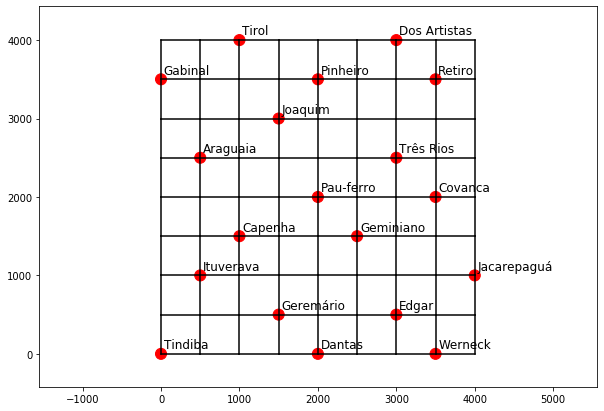

Figure 1: Map of the 'mapBig' file, that is being used in this notebook as the track/station system the trains transit in


In [5]:
# Loading map

print("Reading map file (%s)" % mapPath)

# Getting CSV file names
graphInfo = "%s/Sheet 1-Graph Info.csv" % mapPath
vertices = "%s/Sheet 1-Vertices Positions.csv" % mapPath
connections = "%s/Sheet 1-Connection Matrix.csv" % mapPath


# Reading Graph Info table
print("\tGoing over graph info")

nVertices = 0
nEdges = 0
map_size = 0
with open(graphInfo) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            if not row[0] == "Number of vertices":
                raise Exception("Wrong input file format. See map input format")
            nVertices = int(row[1])
        elif line_count == 1:
            if not row[0] == "Number of connections":
                raise Exception("Wrong input file format. See map input format")
            nEdges = int(row[1])
        else:
            if not row[0] == "Map size":
                raise Exception("Wrong input file format. See map input format")
            map_size = float(row[1])
        line_count += 1
                                
    print("\t - Map contains %d vertices and %d edges" % (nVertices, nEdges))

# Reading Vertices Positions table
print("\tGoing over vertices positions")
                                
vert_pos = []
stoppingPoints = {}
stoppingPointsPos = []
with open(vertices) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = -1
    for row in csv_reader:
        if line_count == -1:
            line_count += 1
            continue
        vert_pos += [(float(row[1]), float(row[2]))]
        if row[0][0] != "_":
            stoppingPoints[row[0]] = line_count
            stoppingPointsPos += [(float(row[1]), float(row[2]))]
        line_count += 1
    if line_count != nVertices:
        raise Exception("Wrong input file format. The number of vertices given doesn't match the number of vertices specified")
    print("\t - Got positions of the %d vertices. %d are stations" %
          (nVertices, len(stoppingPoints.keys())))
                                
# Reading Connection Matrix table
print("\tGoing over graph edges")
                                
edges = np.ndarray(shape=(nVertices, nVertices), dtype=float)
edges.fill(-1)
                                
# Availability dictionary
availability = {}
                                
with open(connections) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    edge_count = 0
    for row in csv_reader:
        for i in range(nVertices):
            if row[i] != "":
                edges[line_count][i] = float(row[i])
                if line_count != i:
                    a = max(line_count, i)
                    b = min(line_count, i)
                    availability[ (a, b) ] = True
                if line_count > i:
                    edge_count += 1
        line_count += 1
    if nEdges != edge_count:
        raise Exception("Wrong input file format. Number of edges given doesn't match the specified number")
    print("\t - Read over %d edges in graph" % edge_count)

    
# Printing the map
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.axis('equal')

nEdgesDrawn = 0
for i in range(nVertices):
    for j in range(nVertices):
        if j >= i:
            break
        if edges[i][j] > 0:
            ax.plot([vert_pos[i][0], vert_pos[j][0]], [vert_pos[i][1], vert_pos[j][1]], 'k', zorder=-4)
            nEdgesDrawn += 1

xmin, xmax, ymin, ymax = ax.axis()
scale = (ymax-ymin) * .016  # Scale fator to print visible circles
for ponto in stoppingPoints.keys():
    pos = vert_pos[stoppingPoints[ponto]]
    c = plt.Circle(pos, radius=scale, color='r', zorder=-5)
    ax.add_patch(c)
    ax.text(pos[0] + scale*.5, pos[1] + scale, ponto, fontsize=12, wrap=True, zorder=-3)

xmin, xmax, ymin, ymax = ax.axis()
diverge = .05
xmin = xmin - (xmax - xmin) * diverge
xmax = xmax + (xmax - xmin) * diverge
ymin = ymin - (ymax - ymin) * diverge
ymax = ymax + (ymax - ymin) * diverge
ax.axis([xmin, xmax, ymin, ymax])

plt.show()
print("Figure 1: Map of the 'mapBig' file, that is being used in this notebook as the track/station system the trains transit in")

In [6]:
# Loading client creation dataset

client_dataset = np.load(cliDataFile)
client_creation = client_dataset.get("client")
client_position = client_dataset.get("init_stat")
client_destination = client_dataset.get("fin_stat")

## Experimental determination of the train request reception radius

Text commenting experiments can be checked in the original notebook.

<!--- Through experimentation and analysis simulation implemented and the map that is currently being used, it soon became clear that just applying ten numbers evenly distributed between 0 and 1 to the range parameter wouldn't be a very good way to make this test. The radius of one tenth of the map radius reaches only approximately $353\,$m (since the diagonal of this map has $3522,78\,$m). This distance, with this road configuration, is not enough to even reach the edges adjacent to the stopping points. This means that only trains that pass directly over the stopping points will be able to receive the requests, and therefore this radius is not coherent with this simulation. --->

<!--- Through experimentation it was verified that, for a minimum of 5 trains, a radius of 1057$~$m (30% of the map diagonal) made it possible for the system to deliver the 15 clients in every simulation. To make this possible, since in this case too much relies on the luck that the starting point of the train will be close enough to a stopping point (otherwise the train would never receive any client request at all), it was stipulated that, for this test, the trains will all be given initial positions at stopping points. It is only logical that this would many times make the system more efficient, considering these are the points the requests will be handled in regardless. This test is also made so that, once the first 15 clients are put into the simulation, no other clients are created. So it is guaranteed that for the simulation to finish successfully, every client must be delivered to their stopping point. --->

In [37]:
# NUMBER OF TRAINS:
n_trains = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#------------------
# CLIENT RANGE
c_radius = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
#------------------
step_speed = 1               # Passage of time for each simulation loop (s/step)

In [8]:
# Creating simulations log file

# logFile = open(logName, "w")

In [9]:
for clientRange in c_radius:
    m_del_time[clientRange] = []
    d_del_time[clientRange] = []
    m_wait_time[clientRange] = []
    d_wait_time[clientRange] = []
    m_answ_time[clientRange] = []
    d_answ_time[clientRange] = []
    m_train_dist[clientRange] = []
    d_train_dist[clientRange] = []
    numberOfClientsPickedUpOnTheWay[clientRange] = {}
    
    # Creating Network
    sim = Simulation()
    net = Network(sim, log=False)
    sim.clientRange = int(map_size * clientRange)
    sim.trainRange = 3 * sim.clientRange
    
    for nTrains in n_trains:
        deliveryTimeList = []
        waitTimeList = []
        answTimeList = []
        trainDistanceRun = []
        numberOfClientsPickedUpOnTheWay[clientRange][nTrains] = []

        for turn in range(simRepeat):
            print("Simulation with {} trains, range {}. Turn {}".format(nTrains, clientRange, turn+1))
            # Zeroing variables
            waitingTime = {}
            answerTime = {}
            deliveryTime = {}
            numberOfClientsPickedUpOnTheWay[clientRange][nTrains] += [0]
            checkedList = []

            sim.devices = []

            for key in availability.keys():
                availability[key] = True

            # Creating train objects

            v_step = step_speed

            for i in range(nTrains):
                idx = randint(0, len(stoppingPointsPos) - 1)
                pos = stoppingPointsPos[ idx ]
                tr = Train(i, pos, v_step, mapPath, availability, net, vMax = trainSpeed, log=False)
                sim.devices += [tr]

            # Creating initial client conditions
            nClients = 0
            currCli = 0.5
            clientList = []
            outingClients = {}

            # Looping simulation

            simTime = 0
            out_file = ""
            finished = False

            while not finished:
                clockcount = simTime * v_step
                clockcount = float(clockcount)
                hour = int(clockcount // 3600)
                clockcount %= 3600
                minutes = int(clockcount // 60)
                clockcount %= 60
                seconds = int (clockcount)
                # print( "Simulation counter: {:02d}:{:02d}:{:02d} ({} iterations)".
                #                             format(hour, minutes, seconds, simTime) )

                # Creating random clients
                if currCli < total_clients_finished:
                    r = client_creation[turn][simTime]
                    if r % frequency_of_clients == 0:
                        init = client_position[turn][simTime]
                        fin = client_destination[turn][simTime]
                        if fin == init:
                            fin += 1
                            if fin == len(stoppingPointsPos):
                                fin = 0
                        pos = stoppingPointsPos[init]
                        dest = stoppingPointsPos[fin]
                        cl = Client(currCli, pos, dest, v_step, mapPath, net, log=False)
                        sim.devices += [cl]
                        clientList += [cl]
                        client_time += [simTime]
                        client_pos += [init]
                        currCli += 1

                # Run all devices
                for device in sim.devices:
                    device.step()

                for client in clientList:
                    # Remove clients from list
                    if client.mode == CliModes.dropoff:
                        if client not in outingClients.keys():
                            outingClients[client] = 0
                        else:
                            outingClients[client] += 1
                        if outingClients[client] >= 10:
                            # Getting client waiting time statistics
                            waitingTime[client.id] = client.waitingTime*step_speed
                            answerTime[client.id] = client.timeTillRequest*step_speed
                            deliveryTime[client.id] = client.serviceTime*step_speed

                            # Removing client from simulation
                            sim.devices.remove(client)
                            clientList.remove(client)
                            client.kill()
                            nClients += 1
                            
                        # Add client picked on the way stats
                        #  NOTE: This is not the best way to do it. Should probably consider 
                        #        adding this measurement to train code
                        if client.mode == CliModes.moving:
                            if client not in checkedList:
                                checkedList += [client]
                                trainId = client.train
                                print(client.id, trainId)
                                for dev in sim.devices:
                                    if dev.id == trainId:
                                        print(client.id, dev.id, dev.inCourseClients)
                                        if len(dev.inCourseClients) > 1:
                                            numberOfClientsPickedUpOnTheWay[clientRange][nTrains][turn] += 1
                                        break

                # Simulation log
                out_file += "Simulation step {}, timer {}\n".format(simTime, simTime*v_step)
                for device in sim.devices:
                    out_file += "\tDevice {}, mode {}: position {}\n".format(device.id, device.mode, device.pos)
                    if isinstance(device, Train):
                        out_file += "\t  Processing request {}\n".format(device.unprocessedReqs)
                        out_file += "\t  Path {}\n".format(device.path)
                        out_file += "\t  Goals (current goal is {}) {}\n".format(device.currentGoal, device.goals)
                        out_file += "\t  In course clients {}\n".format(device.inCourseClients)
                        out_file += "\t  Clients list {}\n".format(device.client)
                    elif isinstance(device, Client):
                        out_file += "\t  Destination: {}.\n".format(device.destiny)
                        out_file += "\t  Train that will pick me up {}\n".format(device.train)
                    out_file += "\t  Message buffer {}\n".format(device.messageBuffer)
                out_file += "\n"

                # Simulation step counter
                simTime += 1

                # Check for simulation closure
                if total_steps_run != -1:
                    if simTime >= total_steps_run:
                        finished = True
                elif nClients != -1:
                    if nClients >= total_clients_finished:
                        finished = True

            print("Finished simulation!")
            out_file += "The end"
            
            # logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))


            # Waiting time statistics

            print("Total time waited by clients: {}".format(waitingTime))
            print("Time waited by clients until they got a train answer: {}".format(answerTime))

            print("Non serviced clients: ")
            for client in clientList:
                if client.mode not in [CliModes.moving, CliModes.dropoff]:
                    print("Client {} is in mode {} and has a total waiting time of {} simulation counts".\
                          format(client.id, client.mode, client.waitingTime))


            # Average waiting time
            sumTime = 0
            for value in waitingTime.values():
                sumTime += value

            waitTimeList += [ sumTime/len(waitingTime.keys()) ]

            sumTime = 0
            for value in answerTime.values():
                sumTime += value

            answTimeList += [ sumTime/len(answerTime.keys()) ]
            
            sumTime = 0
            for value in deliveryTime.values():
                sumTime += value
                
            deliveryTimeList += [ sumTime/len(deliveryTime.keys()) ]
            
            # TODO: Make version that is normalized by distance!

            print("Average waiting time for {} trains: {}".format(nTrains, waitTimeList[turn]))
            print("Serviced {} clients in {} simulation counts\n".format(len(waitingTime.keys()), simTime))

            # Train distances
            sumDistance = 0
            for dev in sim.devices:
                if isinstance(dev, Train):
                    sumDistance += dev.totalDistanceRun

            trainDistanceRun += [sumDistance]

            
        sizeLists = len(waitTimeList)
        sumTime = 0
        sumTime2 = 0
        sumTimeTot = 0
        sumDistance = 0

        for i in range(sizeLists):
            sumTime += waitTimeList[i]
            sumTime2 += answTimeList[i]
            sumTimeTot += deliveryTimeList[i]
            sumDistance += trainDistanceRun[i]

        meanDeliveryTime = sumTimeTot/sizeLists
        meanWaitTime = sumTime/sizeLists
        meanAnswerTime = sumTime2/sizeLists
        totalDistance = sumDistance/sizeLists

        sumTime = 0
        sumTime2 = 0
        sumTimeTot = 0
        sumDistance = 0

        for i in range(sizeLists):
            sumTime += (waitTimeList[i] - meanWaitTime)**2
            sumTime2 += (answTimeList[i] - meanAnswerTime)**2
            sumTimeTot += (deliveryTimeList[i] - meanDeliveryTime)**2
            sumDistance += (trainDistanceRun[i] - totalDistance)**2
        
        devDeliveryTime = sqrt(sumTimeTot/sizeLists)
        devWaitTime = sqrt(sumTime/sizeLists)
        devAnswerTime = sqrt(sumTime2/sizeLists)
        devDistance = sqrt(sumDistance/sizeLists)
        
        m_del_time[clientRange] += [meanDeliveryTime]
        m_wait_time[clientRange] += [meanWaitTime]
        m_answ_time[clientRange] += [meanAnswerTime]
        m_train_dist[clientRange] += [totalDistance]

        d_del_time[clientRange] += [devDeliveryTime]
        d_wait_time[clientRange] += [devWaitTime]
        d_answ_time[clientRange] += [devAnswerTime]
        d_train_dist[clientRange] += [devDistance]

        print("Average waiting time for {} trains: {}".format(nTrains, meanWaitTime))
        print("Average total train percourse for {} trains: {}".format(nTrains, totalDistance))
        print("\t (Distances of each simulation: {} )".format(trainDistanceRun))
        print("\n")

Simulation with 5 trains, range 1. Turn 1
Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 125, 4.5: 172, 2.5: 248, 8.5: 221, 3.5: 123, 6.5: 154, 7.5: 332, 5.5: 420, 11.5: 319, 10.5: 403, 13.5: 420, 9.5: 404, 12.5: 609, 14.5: 619}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 50, 4.5: 47, 2.5: 48, 8.5: 57, 3.5: 48, 6.5: 48, 7.5: 47, 5.5: 48, 11.5: 48, 10.5: 47, 13.5: 47, 9.5: 49, 12.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 5 trains: 307.8
Serviced 15 clients in 1055 simulation counts

Simulation with 5 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 123, 0.5: 122, 5.5: 130, 3.5: 124, 4.5: 219, 7.5: 234, 8.5: 123, 2.5: 222, 6.5: 406, 9.5: 322, 11.5: 486, 12.5: 444, 14.5: 615, 10.5: 616, 13.5: 545}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 5.5: 46, 3.5: 47, 4.5: 48, 7.5: 47, 8.5: 48, 2.5: 47, 6.5: 47, 9.5: 47, 11.5: 50, 12.5: 52, 14.5: 57, 10.5: 48, 13.5: 52}
No

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 147, 4.5: 124, 3.5: 222, 2.5: 238, 6.5: 123, 5.5: 198, 8.5: 137, 7.5: 294, 13.5: 93, 12.5: 163, 11.5: 398, 10.5: 515, 9.5: 524, 14.5: 583}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 4.5: 49, 3.5: 47, 2.5: 47, 6.5: 48, 5.5: 48, 8.5: 46, 7.5: 47, 13.5: 56, 12.5: 56, 11.5: 56, 10.5: 49, 9.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 253.86666666666667
Serviced 15 clients in 1064 simulation counts

Simulation with 5 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 163, 0.5: 198, 3.5: 124, 1.5: 123, 10.5: 211, 7.5: 257, 6.5: 418, 4.5: 313, 5.5: 403, 11.5: 524, 13.5: 298, 12.5: 424, 9.5: 672, 14.5: 598, 8.5: 732}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 3.5: 49, 1.5: 48, 10.5: 61, 7.5: 48, 6.5: 48, 4.5: 48, 5.5: 49, 11.5: 46, 13.5: 47, 12.5: 47, 9.5: 52, 14.5: 48, 8.5: 48}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 151, 0.5: 125, 1.5: 150, 3.5: 125, 7.5: 150, 6.5: 269, 5.5: 400, 4.5: 277, 12.5: 357, 10.5: 385, 8.5: 515, 11.5: 501, 9.5: 598, 13.5: 591, 14.5: 819}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 50, 1.5: 50, 3.5: 50, 7.5: 50, 6.5: 47, 5.5: 50, 4.5: 47, 12.5: 50, 10.5: 50, 8.5: 47, 11.5: 50, 9.5: 54, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 360.8666666666667
Serviced 15 clients in 1330 simulation counts

Simulation with 5 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 6.5: 165, 0.5: 99, 2.5: 199, 4.5: 247, 3.5: 151, 5.5: 402, 10.5: 302, 7.5: 520, 8.5: 356, 11.5: 336, 13.5: 532, 12.5: 530, 9.5: 546, 14.5: 724}
Time waited by clients until they got a train answer: {1.5: 49, 6.5: 49, 0.5: 49, 2.5: 49, 4.5: 47, 3.5: 51, 5.5: 47, 10.5: 48, 7.5: 59, 8.5: 49, 11.5: 47, 13.5: 52, 12.5: 47, 9.5: 50, 14.5: 60}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 99, 3.5: 118, 0.5: 123, 4.5: 127, 1.5: 211, 7.5: 268, 5.5: 465, 6.5: 480, 8.5: 461, 12.5: 470, 11.5: 122, 13.5: 702, 9.5: 721, 10.5: 569, 14.5: 822}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 61, 0.5: 48, 4.5: 52, 1.5: 61, 7.5: 49, 5.5: 72, 6.5: 48, 8.5: 61, 12.5: 52, 11.5: 56, 13.5: 91, 9.5: 109, 10.5: 69, 14.5: 72}
Non serviced clients: 
Average waiting time for 5 trains: 383.8666666666667
Serviced 15 clients in 1173 simulation counts

Simulation with 5 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 122, 0.5: 147, 2.5: 48, 3.5: 126, 1.5: 148, 6.5: 265, 5.5: 345, 10.5: 139, 8.5: 289, 7.5: 294, 11.5: 465, 9.5: 527, 14.5: 374, 12.5: 639, 13.5: 803}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 47, 2.5: 47, 3.5: 51, 1.5: 48, 6.5: 47, 5.5: 47, 10.5: 47, 8.5: 61, 7.5: 51, 11.5: 47, 9.5: 51, 14.5: 49, 12.5: 47, 13.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 126, 2.5: 125, 5.5: 155, 1.5: 155, 7.5: 163, 4.5: 162, 3.5: 127, 8.5: 245, 13.5: 168, 6.5: 242, 11.5: 343, 14.5: 206, 12.5: 433, 9.5: 408, 10.5: 491}
Time waited by clients until they got a train answer: {0.5: 51, 2.5: 50, 5.5: 55, 1.5: 80, 7.5: 50, 4.5: 62, 3.5: 52, 8.5: 57, 13.5: 47, 6.5: 50, 11.5: 50, 14.5: 51, 12.5: 47, 9.5: 51, 10.5: 50}
Non serviced clients: 
Average waiting time for 6 trains: 236.6
Serviced 15 clients in 824 simulation counts

Simulation with 6 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 55, 1.5: 200, 3.5: 122, 4.5: 172, 2.5: 48, 7.5: 159, 8.5: 124, 10.5: 315, 6.5: 359, 9.5: 335, 13.5: 207, 12.5: 369, 14.5: 610, 11.5: 563}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 1.5: 50, 3.5: 47, 4.5: 47, 2.5: 47, 7.5: 48, 8.5: 49, 10.5: 47, 6.5: 47, 9.5: 49, 13.5: 50, 12.5: 48, 14.5: 57, 11.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 122, 4.5: 173, 7.5: 49, 1.5: 247, 2.5: 213, 5.5: 123, 8.5: 98, 9.5: 155, 12.5: 247, 6.5: 318, 10.5: 378, 11.5: 318, 14.5: 503, 13.5: 588}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 47, 4.5: 48, 7.5: 48, 1.5: 47, 2.5: 47, 5.5: 48, 8.5: 48, 9.5: 46, 12.5: 58, 6.5: 47, 10.5: 49, 11.5: 47, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 6 trains: 238.73333333333332
Serviced 15 clients in 1218 simulation counts

Simulation with 6 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 201, 9.5: 128, 3.5: 125, 2.5: 200, 1.5: 52, 10.5: 174, 7.5: 269, 6.5: 366, 13.5: 186, 5.5: 404, 4.5: 341, 12.5: 436, 8.5: 70, 14.5: 610, 11.5: 763}
Time waited by clients until they got a train answer: {0.5: 51, 9.5: 53, 3.5: 50, 2.5: 50, 1.5: 51, 10.5: 61, 7.5: 52, 6.5: 51, 13.5: 47, 5.5: 57, 4.5: 50, 12.5: 47, 8.5: 46, 14.5: 51, 11.5: 47}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 125, 1.5: 124, 4.5: 48, 7.5: 156, 3.5: 172, 13.5: 122, 11.5: 271, 6.5: 243, 5.5: 374, 12.5: 363, 8.5: 492, 10.5: 410, 9.5: 597, 14.5: 553}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 1.5: 49, 4.5: 47, 7.5: 47, 3.5: 47, 13.5: 47, 11.5: 47, 6.5: 47, 5.5: 47, 12.5: 48, 8.5: 47, 10.5: 47, 9.5: 49, 14.5: 48}
Non serviced clients: 
Average waiting time for 6 trains: 273.2
Serviced 15 clients in 1064 simulation counts

Simulation with 6 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 150, 0.5: 51, 7.5: 190, 2.5: 175, 4.5: 197, 3.5: 110, 6.5: 393, 5.5: 355, 10.5: 328, 11.5: 197, 12.5: 402, 8.5: 413, 9.5: 499, 13.5: 589, 14.5: 688}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 50, 7.5: 50, 2.5: 50, 4.5: 47, 3.5: 50, 6.5: 47, 5.5: 47, 10.5: 52, 11.5: 47, 12.5: 47, 8.5: 50, 9.5: 50, 13.5: 52, 14.5: 53}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {3.5: 159, 7.5: 115, 0.5: 125, 5.5: 168, 1.5: 211, 2.5: 277, 4.5: 176, 6.5: 326, 14.5: 293, 8.5: 410, 10.5: 321, 11.5: 547, 13.5: 552, 12.5: 519, 9.5: 641}
Time waited by clients until they got a train answer: {3.5: 59, 7.5: 66, 0.5: 50, 5.5: 56, 1.5: 61, 2.5: 56, 4.5: 51, 6.5: 52, 14.5: 79, 8.5: 53, 10.5: 86, 11.5: 76, 13.5: 62, 12.5: 51, 9.5: 55}
Non serviced clients: 
Average waiting time for 6 trains: 322.6666666666667
Serviced 15 clients in 853 simulation counts

Simulation with 6 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 125, 5.5: 51, 4.5: 158, 2.5: 52, 1.5: 129, 3.5: 201, 9.5: 126, 6.5: 278, 8.5: 240, 10.5: 176, 12.5: 238, 7.5: 369, 11.5: 416, 13.5: 462, 14.5: 399}
Time waited by clients until they got a train answer: {0.5: 50, 5.5: 50, 4.5: 46, 2.5: 51, 1.5: 54, 3.5: 51, 9.5: 51, 6.5: 47, 8.5: 62, 10.5: 47, 12.5: 47, 7.5: 51, 11.5: 50, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 51, 1.5: 124, 4.5: 102, 5.5: 210, 3.5: 53, 8.5: 214, 11.5: 123, 7.5: 261, 6.5: 175, 12.5: 267, 9.5: 123, 14.5: 150, 13.5: 349, 10.5: 424}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 50, 1.5: 49, 4.5: 52, 5.5: 48, 3.5: 52, 8.5: 57, 11.5: 48, 7.5: 48, 6.5: 49, 12.5: 47, 9.5: 48, 14.5: 48, 13.5: 47, 10.5: 48}
Non serviced clients: 
Average waiting time for 7 trains: 178.33333333333334
Serviced 15 clients in 762 simulation counts

Simulation with 7 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 123, 5.5: 131, 4.5: 147, 3.5: 123, 9.5: 49, 10.5: 103, 8.5: 99, 7.5: 243, 2.5: 199, 14.5: 323, 6.5: 350, 12.5: 256, 11.5: 568, 13.5: 500}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 5.5: 46, 4.5: 48, 3.5: 48, 9.5: 48, 10.5: 53, 8.5: 49, 7.5: 48, 2.5: 49, 14.5: 57, 6.5: 48, 12.5: 47, 11.5: 49, 13.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 97, 3.5: 49, 4.5: 123, 7.5: 48, 2.5: 202, 6.5: 122, 5.5: 122, 8.5: 98, 9.5: 105, 10.5: 222, 12.5: 246, 11.5: 313, 14.5: 498, 13.5: 392}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 3.5: 48, 4.5: 48, 7.5: 47, 2.5: 47, 6.5: 47, 5.5: 47, 8.5: 48, 9.5: 47, 10.5: 47, 12.5: 57, 11.5: 47, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 7 trains: 179.0
Serviced 15 clients in 1022 simulation counts

Simulation with 7 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 2.5: 123, 7.5: 49, 10.5: 169, 1.5: 124, 4.5: 49, 3.5: 297, 12.5: 128, 5.5: 311, 14.5: 328, 8.5: 467, 6.5: 469, 13.5: 256, 11.5: 515, 9.5: 605}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 7.5: 48, 10.5: 51, 1.5: 49, 4.5: 48, 3.5: 47, 12.5: 47, 5.5: 51, 14.5: 47, 8.5: 50, 6.5: 47, 13.5: 47, 11.5: 47, 9.5: 50}
Non serviced clients: 
Average waiting time for 7 

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 49, 5.5: 49, 11.5: 49, 1.5: 147, 3.5: 122, 6.5: 166, 7.5: 247, 4.5: 200, 14.5: 104, 8.5: 335, 12.5: 424, 10.5: 381, 13.5: 410, 9.5: 452}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 5.5: 48, 11.5: 48, 1.5: 47, 3.5: 47, 6.5: 47, 7.5: 47, 4.5: 47, 14.5: 46, 8.5: 47, 12.5: 48, 10.5: 47, 13.5: 47, 9.5: 48}
Non serviced clients: 
Average waiting time for 7 trains: 212.26666666666668
Serviced 15 clients in 889 simulation counts

Simulation with 7 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 7.5: 158, 5.5: 112, 2.5: 123, 0.5: 124, 10.5: 58, 4.5: 222, 12.5: 168, 6.5: 343, 3.5: 224, 11.5: 158, 9.5: 256, 13.5: 349, 8.5: 433, 14.5: 455}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 58, 5.5: 48, 2.5: 48, 0.5: 49, 10.5: 57, 4.5: 47, 12.5: 47, 6.5: 49, 3.5: 49, 11.5: 46, 9.5: 53, 13.5: 55, 8.5: 49, 14.5: 61}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 97, 0.5: 98, 3.5: 159, 6.5: 150, 4.5: 99, 5.5: 200, 1.5: 234, 11.5: 235, 8.5: 233, 9.5: 307, 7.5: 323, 12.5: 279, 13.5: 470, 14.5: 501, 10.5: 471}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 48, 3.5: 59, 6.5: 50, 4.5: 49, 5.5: 50, 1.5: 59, 11.5: 46, 8.5: 47, 9.5: 56, 7.5: 48, 12.5: 66, 13.5: 49, 14.5: 59, 10.5: 66}
Non serviced clients: 
Average waiting time for 7 trains: 257.06666666666666
Serviced 15 clients in 859 simulation counts

Simulation with 7 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 125, 5.5: 127, 4.5: 184, 2.5: 61, 1.5: 144, 3.5: 225, 12.5: 97, 6.5: 293, 8.5: 255, 9.5: 309, 10.5: 201, 13.5: 279, 7.5: 393, 11.5: 431, 14.5: 473}
Time waited by clients until they got a train answer: {0.5: 50, 5.5: 52, 4.5: 47, 2.5: 60, 1.5: 56, 3.5: 50, 12.5: 47, 6.5: 47, 8.5: 60, 9.5: 50, 10.5: 47, 13.5: 47, 7.5: 50, 11.5: 52, 14.5: 52}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 98, 5.5: 124, 2.5: 132, 1.5: 129, 4.5: 101, 8.5: 219, 7.5: 219, 3.5: 151, 9.5: 98, 10.5: 178, 6.5: 205, 14.5: 105, 12.5: 288, 11.5: 357, 13.5: 307}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 49, 2.5: 57, 1.5: 54, 4.5: 51, 8.5: 60, 7.5: 48, 3.5: 51, 9.5: 48, 10.5: 47, 6.5: 55, 14.5: 47, 12.5: 49, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 180.73333333333332
Serviced 15 clients in 646 simulation counts

Simulation with 8 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 127, 0.5: 124, 4.5: 100, 7.5: 66, 5.5: 200, 3.5: 149, 11.5: 50, 2.5: 124, 8.5: 173, 6.5: 311, 9.5: 347, 12.5: 298, 13.5: 291, 10.5: 520, 14.5: 622}
Time waited by clients until they got a train answer: {1.5: 52, 0.5: 49, 4.5: 50, 7.5: 47, 5.5: 47, 3.5: 49, 11.5: 49, 2.5: 49, 8.5: 48, 6.5: 49, 9.5: 50, 12.5: 47, 13.5: 51, 10.5: 49, 14.5: 57}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 99, 2.5: 50, 1.5: 99, 4.5: 124, 3.5: 199, 5.5: 124, 6.5: 170, 8.5: 114, 7.5: 172, 9.5: 106, 10.5: 226, 12.5: 211, 11.5: 315, 13.5: 226, 14.5: 500}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 49, 1.5: 49, 4.5: 49, 3.5: 49, 5.5: 49, 6.5: 49, 8.5: 46, 7.5: 47, 9.5: 46, 10.5: 51, 12.5: 47, 11.5: 47, 13.5: 51, 14.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 182.33333333333334
Serviced 15 clients in 976 simulation counts

Simulation with 8 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 97, 8.5: 107, 3.5: 149, 6.5: 100, 10.5: 187, 5.5: 97, 9.5: 277, 1.5: 148, 12.5: 129, 14.5: 235, 4.5: 238, 7.5: 431, 11.5: 544, 13.5: 532}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 8.5: 57, 3.5: 49, 6.5: 50, 10.5: 68, 5.5: 47, 9.5: 61, 1.5: 48, 12.5: 54, 14.5: 48, 4.5: 47, 7.5: 48, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 100, 11.5: 48, 3.5: 48, 1.5: 147, 7.5: 181, 10.5: 123, 4.5: 199, 14.5: 103, 6.5: 218, 5.5: 401, 12.5: 423, 8.5: 486, 13.5: 561, 9.5: 599}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 11.5: 47, 3.5: 47, 1.5: 47, 7.5: 47, 10.5: 48, 4.5: 47, 14.5: 46, 6.5: 47, 5.5: 50, 12.5: 52, 8.5: 47, 13.5: 48, 9.5: 50}
Non serviced clients: 
Average waiting time for 8 trains: 245.66666666666666
Serviced 15 clients in 1036 simulation counts

Simulation with 8 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 2.5: 52, 7.5: 135, 6.5: 165, 10.5: 52, 0.5: 124, 4.5: 187, 12.5: 145, 13.5: 171, 3.5: 200, 8.5: 188, 5.5: 442, 11.5: 276, 9.5: 586, 14.5: 764}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 51, 7.5: 60, 6.5: 49, 10.5: 51, 0.5: 49, 4.5: 47, 12.5: 47, 13.5: 53, 3.5: 50, 8.5: 50, 5.5: 47, 11.5: 47, 9.5: 50, 14.5: 60}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {2.5: 50, 3.5: 59, 5.5: 125, 8.5: 49, 4.5: 49, 1.5: 135, 0.5: 123, 9.5: 206, 6.5: 227, 12.5: 259, 11.5: 345, 7.5: 358, 13.5: 399, 10.5: 381, 14.5: 536}
Time waited by clients until they got a train answer: {2.5: 49, 3.5: 58, 5.5: 50, 8.5: 48, 4.5: 48, 1.5: 60, 0.5: 48, 9.5: 49, 6.5: 52, 12.5: 49, 11.5: 48, 7.5: 48, 13.5: 48, 10.5: 60, 14.5: 61}
Non serviced clients: 
Average waiting time for 8 trains: 220.06666666666666
Serviced 15 clients in 887 simulation counts

Simulation with 8 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 123, 1.5: 123, 3.5: 127, 2.5: 123, 12.5: 48, 7.5: 123, 13.5: 97, 8.5: 236, 10.5: 122, 9.5: 288, 6.5: 370, 11.5: 418, 14.5: 258}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 48, 1.5: 48, 3.5: 48, 2.5: 48, 12.5: 47, 7.5: 48, 13.5: 47, 8.5: 58, 10.5: 47, 9.5: 49, 6.5: 47, 11.5: 48, 14.5: 51}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 60, 1.5: 54, 0.5: 99, 4.5: 104, 5.5: 281, 10.5: 101, 7.5: 254, 6.5: 176, 3.5: 179, 9.5: 125, 8.5: 425, 11.5: 382, 13.5: 342, 12.5: 478, 14.5: 317}
Time waited by clients until they got a train answer: {2.5: 59, 1.5: 53, 0.5: 49, 4.5: 54, 5.5: 51, 10.5: 47, 7.5: 49, 6.5: 63, 3.5: 61, 9.5: 50, 8.5: 51, 11.5: 49, 13.5: 47, 12.5: 51, 14.5: 49}
Non serviced clients: 
Average waiting time for 9 trains: 225.13333333333333
Serviced 15 clients in 754 simulation counts

Simulation with 9 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 122, 4.5: 48, 5.5: 122, 7.5: 64, 3.5: 122, 6.5: 97, 2.5: 48, 8.5: 49, 14.5: 188, 9.5: 100, 11.5: 122, 10.5: 328, 13.5: 165, 12.5: 276}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 4.5: 47, 5.5: 47, 7.5: 47, 3.5: 47, 6.5: 47, 2.5: 47, 8.5: 48, 14.5: 57, 9.5: 50, 11.5: 47, 10.5: 47, 13.5: 51, 12.5: 47}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {0.5: 99, 3.5: 50, 2.5: 50, 1.5: 125, 4.5: 99, 7.5: 50, 9.5: 81, 10.5: 175, 5.5: 186, 12.5: 150, 6.5: 196, 8.5: 200, 11.5: 359, 13.5: 225, 14.5: 380}
Time waited by clients until they got a train answer: {0.5: 49, 3.5: 49, 2.5: 49, 1.5: 50, 4.5: 49, 7.5: 49, 9.5: 67, 10.5: 50, 5.5: 49, 12.5: 50, 6.5: 49, 8.5: 50, 11.5: 47, 13.5: 50, 14.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 161.66666666666666
Serviced 15 clients in 857 simulation counts

Simulation with 9 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 123, 6.5: 49, 3.5: 124, 1.5: 49, 10.5: 157, 8.5: 143, 5.5: 101, 7.5: 191, 9.5: 252, 4.5: 123, 14.5: 228, 12.5: 253, 11.5: 429, 13.5: 292}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 6.5: 48, 3.5: 49, 1.5: 48, 10.5: 51, 8.5: 49, 5.5: 51, 7.5: 48, 9.5: 52, 4.5: 48, 14.5: 48, 12.5: 49, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 49, 1.5: 123, 4.5: 48, 7.5: 157, 12.5: 150, 6.5: 167, 3.5: 173, 10.5: 124, 11.5: 271, 5.5: 373, 8.5: 413, 13.5: 488, 9.5: 571, 14.5: 792}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 1.5: 48, 4.5: 47, 7.5: 48, 12.5: 50, 6.5: 47, 3.5: 48, 10.5: 49, 11.5: 48, 5.5: 52, 8.5: 47, 13.5: 47, 9.5: 52, 14.5: 48}
Non serviced clients: 
Average waiting time for 9 trains: 263.26666666666665
Serviced 15 clients in 1303 simulation counts

Simulation with 9 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 2.5: 49, 0.5: 48, 5.5: 111, 4.5: 123, 10.5: 55, 13.5: 53, 6.5: 255, 11.5: 97, 9.5: 255, 3.5: 345, 8.5: 353, 14.5: 433, 7.5: 692, 12.5: 702}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 48, 0.5: 47, 5.5: 47, 4.5: 48, 10.5: 54, 13.5: 52, 6.5: 49, 11.5: 47, 9.5: 49, 3.5: 48, 8.5: 47, 14.5: 58, 7.5: 55, 12.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 59, 3.5: 117, 6.5: 149, 5.5: 150, 4.5: 124, 8.5: 97, 0.5: 123, 1.5: 218, 11.5: 242, 9.5: 265, 7.5: 388, 13.5: 380, 10.5: 358, 12.5: 475, 14.5: 566}
Time waited by clients until they got a train answer: {2.5: 58, 3.5: 67, 6.5: 49, 5.5: 50, 4.5: 49, 8.5: 47, 0.5: 48, 1.5: 68, 11.5: 50, 9.5: 50, 7.5: 48, 13.5: 53, 10.5: 68, 12.5: 49, 14.5: 62}
Non serviced clients: 
Average waiting time for 9 trains: 247.4
Serviced 15 clients in 917 simulation counts

Simulation with 9 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 4.5: 134, 2.5: 48, 1.5: 141, 5.5: 198, 8.5: 59, 3.5: 197, 12.5: 49, 10.5: 48, 6.5: 290, 11.5: 234, 9.5: 380, 7.5: 365, 14.5: 209, 13.5: 448}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 2.5: 47, 1.5: 49, 5.5: 48, 8.5: 58, 3.5: 47, 12.5: 48, 10.5: 47, 6.5: 47, 11.5: 50, 9.5: 48, 7.5: 48, 14.5: 53, 13.5: 47}
Non serviced clients: 
Average waiting time for 9

Finished simulation!
Total time waited by clients: {2.5: 61, 0.5: 99, 4.5: 54, 1.5: 127, 5.5: 149, 12.5: 97, 11.5: 99, 8.5: 217, 3.5: 109, 7.5: 244, 9.5: 50, 10.5: 133, 6.5: 227, 13.5: 256, 14.5: 259}
Time waited by clients until they got a train answer: {2.5: 60, 0.5: 49, 4.5: 53, 1.5: 52, 5.5: 49, 12.5: 47, 11.5: 49, 8.5: 57, 3.5: 59, 7.5: 49, 9.5: 49, 10.5: 47, 6.5: 53, 13.5: 49, 14.5: 49}
Non serviced clients: 
Average waiting time for 10 trains: 145.4
Serviced 15 clients in 695 simulation counts

Simulation with 10 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 122, 5.5: 55, 4.5: 97, 7.5: 48, 6.5: 75, 3.5: 122, 2.5: 48, 14.5: 157, 11.5: 98, 12.5: 48, 8.5: 97, 10.5: 332, 9.5: 341, 13.5: 215}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 5.5: 47, 4.5: 47, 7.5: 47, 6.5: 47, 3.5: 47, 2.5: 47, 14.5: 57, 11.5: 48, 12.5: 47, 8.5: 47, 10.5: 48, 9.5: 48, 13.5: 51}
Non serviced clients: 
Average waiting time for 10 trains

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 1.5: 98, 3.5: 97, 4.5: 124, 6.5: 51, 5.5: 123, 10.5: 149, 7.5: 122, 8.5: 132, 9.5: 126, 12.5: 173, 11.5: 315, 14.5: 312, 13.5: 222}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 1.5: 48, 3.5: 47, 4.5: 49, 6.5: 50, 5.5: 48, 10.5: 49, 7.5: 47, 8.5: 47, 9.5: 51, 12.5: 57, 11.5: 49, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 142.66666666666666
Serviced 15 clients in 852 simulation counts

Simulation with 10 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 7.5: 49, 3.5: 148, 6.5: 122, 8.5: 177, 1.5: 122, 4.5: 49, 12.5: 122, 10.5: 297, 11.5: 354, 13.5: 149, 14.5: 296, 5.5: 335, 9.5: 604}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 7.5: 48, 3.5: 48, 6.5: 47, 8.5: 52, 1.5: 47, 4.5: 48, 12.5: 47, 10.5: 51, 11.5: 47, 13.5: 47, 14.5: 47, 5.5: 54, 9.5: 62}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 49, 5.5: 50, 11.5: 49, 1.5: 123, 4.5: 48, 13.5: 48, 3.5: 123, 7.5: 157, 10.5: 98, 6.5: 167, 14.5: 99, 8.5: 315, 12.5: 261, 9.5: 453}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 5.5: 49, 11.5: 48, 1.5: 48, 4.5: 47, 13.5: 47, 3.5: 48, 7.5: 47, 10.5: 48, 6.5: 50, 14.5: 49, 8.5: 48, 12.5: 49, 9.5: 48}
Non serviced clients: 
Average waiting time for 10 trains: 139.33333333333334
Serviced 15 clients in 890 simulation counts

Simulation with 10 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 2.5: 48, 4.5: 125, 0.5: 122, 8.5: 49, 9.5: 49, 5.5: 187, 6.5: 254, 3.5: 123, 10.5: 147, 14.5: 226, 13.5: 260, 7.5: 470, 11.5: 242, 12.5: 480}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 47, 4.5: 50, 0.5: 47, 8.5: 48, 9.5: 48, 5.5: 51, 6.5: 47, 3.5: 48, 10.5: 47, 14.5: 51, 13.5: 50, 7.5: 56, 11.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 99, 6.5: 101, 3.5: 135, 4.5: 53, 1.5: 148, 5.5: 164, 12.5: 70, 0.5: 123, 13.5: 152, 11.5: 179, 8.5: 235, 9.5: 283, 7.5: 371, 14.5: 297, 10.5: 317}
Time waited by clients until they got a train answer: {2.5: 49, 6.5: 51, 3.5: 60, 4.5: 52, 1.5: 63, 5.5: 64, 12.5: 69, 0.5: 48, 13.5: 52, 11.5: 54, 8.5: 49, 9.5: 48, 7.5: 53, 14.5: 54, 10.5: 79}
Non serviced clients: 
Average waiting time for 10 trains: 181.8
Serviced 15 clients in 705 simulation counts

Simulation with 10 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 5.5: 50, 4.5: 97, 3.5: 50, 2.5: 56, 1.5: 128, 11.5: 50, 7.5: 124, 13.5: 48, 9.5: 204, 12.5: 97, 6.5: 277, 14.5: 54, 8.5: 251, 10.5: 137}
Time waited by clients until they got a train answer: {0.5: 49, 5.5: 49, 4.5: 47, 3.5: 49, 2.5: 55, 1.5: 53, 11.5: 49, 7.5: 49, 13.5: 47, 9.5: 49, 12.5: 47, 6.5: 47, 14.5: 53, 8.5: 62, 10.5: 47}
Non serviced clients: 
Average waiting time for 10 tr

Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 123, 2.5: 126, 1.5: 126, 4.5: 98, 3.5: 48, 7.5: 159, 12.5: 98, 8.5: 216, 10.5: 122, 11.5: 233, 9.5: 122, 6.5: 243, 13.5: 255, 14.5: 174}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 2.5: 51, 1.5: 51, 4.5: 48, 3.5: 47, 7.5: 48, 12.5: 48, 8.5: 58, 10.5: 47, 11.5: 47, 9.5: 47, 6.5: 49, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 151.0
Serviced 15 clients in 610 simulation counts

Simulation with 11 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 61, 0.5: 122, 4.5: 48, 5.5: 123, 7.5: 64, 6.5: 48, 3.5: 123, 11.5: 48, 2.5: 123, 8.5: 98, 14.5: 244, 12.5: 122, 13.5: 165, 9.5: 340, 10.5: 384}
Time waited by clients until they got a train answer: {1.5: 60, 0.5: 47, 4.5: 47, 5.5: 47, 7.5: 47, 6.5: 47, 3.5: 48, 11.5: 47, 2.5: 48, 8.5: 48, 14.5: 57, 12.5: 47, 13.5: 49, 9.5: 49, 10.5: 48}
Non serviced clients: 
Average waiting time for 11 

Finished simulation!
Total time waited by clients: {0.5: 100, 3.5: 56, 4.5: 54, 1.5: 99, 2.5: 100, 5.5: 50, 7.5: 51, 9.5: 71, 10.5: 175, 6.5: 170, 12.5: 249, 11.5: 243, 8.5: 276, 14.5: 428, 13.5: 440}
Time waited by clients until they got a train answer: {0.5: 50, 3.5: 55, 4.5: 53, 1.5: 49, 2.5: 50, 5.5: 49, 7.5: 50, 9.5: 70, 10.5: 50, 6.5: 51, 12.5: 54, 11.5: 54, 8.5: 50, 14.5: 47, 13.5: 53}
Non serviced clients: 
Average waiting time for 11 trains: 170.8
Serviced 15 clients in 1070 simulation counts

Simulation with 11 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 124, 3.5: 125, 1.5: 49, 8.5: 125, 6.5: 98, 7.5: 143, 5.5: 100, 4.5: 99, 10.5: 274, 9.5: 369, 12.5: 253, 11.5: 405, 14.5: 452, 13.5: 361}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 49, 3.5: 50, 1.5: 48, 8.5: 50, 6.5: 48, 7.5: 48, 5.5: 50, 4.5: 49, 10.5: 53, 9.5: 54, 12.5: 48, 11.5: 47, 14.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 11

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 129, 5.5: 100, 8.5: 97, 1.5: 123, 3.5: 97, 4.5: 48, 7.5: 156, 10.5: 122, 9.5: 122, 13.5: 172, 12.5: 261, 14.5: 122, 6.5: 247, 11.5: 467}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 54, 5.5: 50, 8.5: 47, 1.5: 48, 3.5: 47, 4.5: 47, 7.5: 47, 10.5: 47, 9.5: 47, 13.5: 47, 12.5: 47, 14.5: 47, 6.5: 52, 11.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 154.06666666666666
Serviced 15 clients in 818 simulation counts

Simulation with 11 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 7.5: 132, 2.5: 123, 0.5: 122, 5.5: 162, 8.5: 48, 9.5: 50, 4.5: 147, 3.5: 97, 10.5: 129, 14.5: 135, 12.5: 150, 6.5: 330, 13.5: 223, 11.5: 217}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 57, 2.5: 48, 0.5: 47, 5.5: 47, 8.5: 47, 9.5: 49, 4.5: 47, 3.5: 47, 10.5: 54, 14.5: 60, 12.5: 47, 6.5: 49, 13.5: 58, 11.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 131, 0.5: 100, 3.5: 163, 6.5: 152, 4.5: 100, 5.5: 178, 1.5: 211, 13.5: 256, 9.5: 311, 14.5: 171, 7.5: 315, 8.5: 394, 10.5: 331, 12.5: 443, 11.5: 529}
Time waited by clients until they got a train answer: {2.5: 56, 0.5: 50, 3.5: 63, 6.5: 77, 4.5: 50, 5.5: 53, 1.5: 61, 13.5: 56, 9.5: 55, 14.5: 71, 7.5: 52, 8.5: 52, 10.5: 66, 12.5: 49, 11.5: 73}
Non serviced clients: 
Average waiting time for 11 trains: 252.33333333333334
Serviced 15 clients in 744 simulation counts

Simulation with 11 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 98, 5.5: 51, 4.5: 131, 6.5: 48, 1.5: 117, 11.5: 49, 2.5: 123, 3.5: 162, 7.5: 49, 12.5: 49, 13.5: 48, 10.5: 48, 9.5: 307, 8.5: 293, 14.5: 140}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 50, 4.5: 46, 6.5: 47, 1.5: 48, 11.5: 48, 2.5: 48, 3.5: 48, 7.5: 48, 12.5: 48, 13.5: 47, 10.5: 47, 9.5: 55, 8.5: 58, 14.5: 51}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 58, 0.5: 122, 5.5: 122, 1.5: 133, 12.5: 49, 8.5: 167, 4.5: 177, 7.5: 159, 6.5: 74, 3.5: 154, 9.5: 123, 13.5: 206, 14.5: 172, 11.5: 355, 10.5: 333}
Time waited by clients until they got a train answer: {2.5: 57, 0.5: 47, 5.5: 47, 1.5: 58, 12.5: 48, 8.5: 62, 4.5: 52, 7.5: 49, 6.5: 47, 3.5: 54, 9.5: 48, 13.5: 47, 14.5: 47, 11.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 12 trains: 160.26666666666668
Serviced 15 clients in 665 simulation counts

Simulation with 12 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 97, 1.5: 125, 4.5: 147, 5.5: 215, 3.5: 122, 7.5: 147, 6.5: 155, 8.5: 49, 9.5: 102, 2.5: 125, 11.5: 98, 14.5: 238, 13.5: 155, 10.5: 402, 12.5: 299}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 50, 4.5: 47, 5.5: 47, 3.5: 47, 7.5: 47, 6.5: 47, 8.5: 48, 9.5: 52, 2.5: 50, 11.5: 48, 14.5: 57, 13.5: 55, 10.5: 47, 12.5: 47}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 3.5: 52, 2.5: 49, 4.5: 129, 7.5: 48, 12.5: 59, 10.5: 128, 6.5: 128, 8.5: 98, 5.5: 123, 11.5: 123, 9.5: 137, 14.5: 252, 13.5: 178}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 3.5: 51, 2.5: 48, 4.5: 54, 7.5: 47, 12.5: 58, 10.5: 53, 6.5: 53, 8.5: 48, 5.5: 48, 11.5: 48, 9.5: 54, 14.5: 47, 13.5: 53}
Non serviced clients: 
Average waiting time for 12 trains: 106.66666666666667
Serviced 15 clients in 808 simulation counts

Simulation with 12 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 124, 3.5: 49, 9.5: 68, 1.5: 48, 10.5: 147, 11.5: 123, 8.5: 180, 4.5: 48, 5.5: 149, 12.5: 125, 6.5: 230, 7.5: 305, 14.5: 292, 13.5: 406}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 3.5: 48, 9.5: 67, 1.5: 47, 10.5: 72, 11.5: 48, 8.5: 55, 4.5: 47, 5.5: 49, 12.5: 50, 6.5: 47, 7.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 48, 3.5: 48, 11.5: 48, 8.5: 147, 1.5: 124, 10.5: 48, 13.5: 49, 7.5: 148, 6.5: 165, 4.5: 216, 5.5: 385, 12.5: 430, 9.5: 456, 14.5: 384}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 3.5: 47, 11.5: 47, 8.5: 47, 1.5: 47, 10.5: 47, 13.5: 48, 7.5: 48, 6.5: 50, 4.5: 47, 5.5: 58, 12.5: 49, 9.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 12 trains: 182.93333333333334
Serviced 15 clients in 896 simulation counts

Simulation with 12 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 2.5: 49, 6.5: 99, 5.5: 51, 4.5: 54, 7.5: 134, 3.5: 50, 0.5: 122, 8.5: 48, 14.5: 70, 12.5: 122, 13.5: 141, 9.5: 136, 11.5: 122, 10.5: 214}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 48, 6.5: 49, 5.5: 50, 4.5: 53, 7.5: 59, 3.5: 49, 0.5: 47, 8.5: 47, 14.5: 69, 12.5: 47, 13.5: 57, 9.5: 61, 11.5: 47, 10.5: 62}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {2.5: 60, 9.5: 52, 0.5: 49, 6.5: 131, 3.5: 153, 12.5: 57, 1.5: 151, 8.5: 139, 5.5: 270, 7.5: 263, 10.5: 125, 4.5: 232, 11.5: 323, 13.5: 488, 14.5: 441}
Time waited by clients until they got a train answer: {2.5: 59, 9.5: 51, 0.5: 48, 6.5: 56, 3.5: 78, 12.5: 56, 1.5: 76, 8.5: 64, 5.5: 72, 7.5: 50, 10.5: 75, 4.5: 57, 11.5: 82, 13.5: 58, 14.5: 85}
Non serviced clients: 
Average waiting time for 12 trains: 195.6
Serviced 15 clients in 792 simulation counts

Simulation with 12 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 48, 4.5: 122, 1.5: 148, 7.5: 49, 3.5: 126, 2.5: 122, 9.5: 125, 12.5: 48, 10.5: 48, 13.5: 97, 11.5: 199, 8.5: 259, 6.5: 379, 14.5: 208}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 4.5: 47, 1.5: 48, 7.5: 48, 3.5: 47, 2.5: 47, 9.5: 50, 12.5: 47, 10.5: 47, 13.5: 47, 11.5: 47, 8.5: 58, 6.5: 47, 14.5: 52}
Non serviced clients: 
Average waiting time for 12

Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 48, 1.5: 100, 2.5: 130, 4.5: 99, 7.5: 98, 12.5: 49, 8.5: 204, 3.5: 105, 9.5: 51, 10.5: 129, 14.5: 113, 6.5: 253, 11.5: 291, 13.5: 243}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 1.5: 50, 2.5: 55, 4.5: 49, 7.5: 48, 12.5: 48, 8.5: 60, 3.5: 55, 9.5: 50, 10.5: 47, 14.5: 47, 6.5: 49, 11.5: 48, 13.5: 48}
Non serviced clients: 
Average waiting time for 13 trains: 130.73333333333332
Serviced 15 clients in 582 simulation counts

Simulation with 13 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 107, 0.5: 97, 4.5: 48, 7.5: 48, 5.5: 180, 3.5: 122, 2.5: 51, 14.5: 130, 11.5: 53, 9.5: 107, 8.5: 123, 6.5: 271, 12.5: 280, 13.5: 287, 10.5: 502}
Time waited by clients until they got a train answer: {1.5: 57, 0.5: 47, 4.5: 47, 7.5: 47, 5.5: 47, 3.5: 47, 2.5: 50, 14.5: 55, 11.5: 52, 9.5: 57, 8.5: 48, 6.5: 47, 12.5: 55, 13.5: 58, 10.5: 57}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 48, 4.5: 48, 1.5: 97, 2.5: 97, 6.5: 48, 7.5: 48, 11.5: 49, 5.5: 122, 9.5: 49, 10.5: 175, 8.5: 197, 12.5: 246, 14.5: 233, 13.5: 317}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 47, 4.5: 47, 1.5: 47, 2.5: 47, 6.5: 47, 7.5: 47, 11.5: 48, 5.5: 47, 9.5: 48, 10.5: 50, 8.5: 47, 12.5: 57, 14.5: 47, 13.5: 50}
Non serviced clients: 
Average waiting time for 13 trains: 121.46666666666667
Serviced 15 clients in 947 simulation counts

Simulation with 13 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 98, 10.5: 66, 6.5: 49, 3.5: 123, 1.5: 49, 7.5: 123, 8.5: 150, 11.5: 124, 4.5: 49, 9.5: 251, 5.5: 137, 12.5: 139, 14.5: 305, 13.5: 224}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 10.5: 65, 6.5: 48, 3.5: 48, 1.5: 48, 7.5: 48, 8.5: 53, 11.5: 49, 4.5: 48, 9.5: 59, 5.5: 62, 12.5: 48, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 122, 5.5: 102, 11.5: 48, 3.5: 48, 8.5: 122, 7.5: 97, 4.5: 48, 10.5: 48, 1.5: 148, 6.5: 167, 12.5: 261, 13.5: 208, 9.5: 326, 14.5: 278}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 47, 5.5: 52, 11.5: 47, 3.5: 47, 8.5: 47, 7.5: 47, 4.5: 47, 10.5: 47, 1.5: 48, 6.5: 47, 12.5: 47, 13.5: 48, 9.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 138.2
Serviced 15 clients in 789 simulation counts

Simulation with 13 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 122, 2.5: 132, 0.5: 97, 4.5: 128, 3.5: 49, 9.5: 55, 5.5: 186, 14.5: 108, 10.5: 133, 13.5: 127, 8.5: 122, 6.5: 339, 7.5: 404, 12.5: 348, 11.5: 260}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 48, 0.5: 47, 4.5: 53, 3.5: 48, 9.5: 54, 5.5: 50, 14.5: 58, 10.5: 58, 13.5: 52, 8.5: 47, 6.5: 49, 7.5: 55, 12.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time for 13

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 79, 2.5: 136, 5.5: 129, 9.5: 125, 11.5: 142, 6.5: 156, 3.5: 155, 7.5: 180, 8.5: 230, 4.5: 303, 13.5: 399, 12.5: 386, 14.5: 358, 10.5: 365}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 78, 2.5: 61, 5.5: 54, 9.5: 50, 11.5: 67, 6.5: 56, 3.5: 80, 7.5: 55, 8.5: 48, 4.5: 53, 13.5: 59, 12.5: 52, 14.5: 69, 10.5: 74}
Non serviced clients: 
Average waiting time for 13 trains: 212.8
Serviced 15 clients in 753 simulation counts

Simulation with 13 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 6.5: 48, 1.5: 106, 5.5: 124, 11.5: 49, 3.5: 138, 2.5: 134, 7.5: 123, 13.5: 48, 12.5: 156, 10.5: 122, 9.5: 321, 14.5: 106, 8.5: 322}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 49, 6.5: 47, 1.5: 56, 5.5: 49, 11.5: 48, 3.5: 49, 2.5: 59, 7.5: 48, 13.5: 47, 12.5: 47, 10.5: 47, 9.5: 54, 14.5: 56, 8.5: 58}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 49, 8.5: 58, 4.5: 49, 2.5: 130, 1.5: 123, 7.5: 98, 12.5: 50, 3.5: 50, 9.5: 49, 13.5: 123, 10.5: 163, 11.5: 235, 14.5: 98, 6.5: 247}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 8.5: 57, 4.5: 48, 2.5: 55, 1.5: 48, 7.5: 48, 12.5: 49, 3.5: 49, 9.5: 48, 13.5: 48, 10.5: 48, 11.5: 48, 14.5: 48, 6.5: 54}
Non serviced clients: 
Average waiting time for 14 trains: 104.73333333333333
Serviced 15 clients in 558 simulation counts

Simulation with 14 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 124, 5.5: 55, 3.5: 48, 4.5: 98, 7.5: 48, 6.5: 77, 2.5: 55, 11.5: 48, 14.5: 189, 9.5: 126, 8.5: 123, 13.5: 55, 12.5: 122, 10.5: 311}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 49, 5.5: 47, 3.5: 47, 4.5: 48, 7.5: 47, 6.5: 47, 2.5: 54, 11.5: 47, 14.5: 61, 9.5: 51, 8.5: 48, 13.5: 54, 12.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 3.5: 58, 2.5: 48, 4.5: 134, 10.5: 53, 7.5: 48, 8.5: 49, 5.5: 123, 6.5: 122, 11.5: 123, 9.5: 138, 14.5: 108, 12.5: 246, 13.5: 131}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 3.5: 57, 2.5: 47, 4.5: 59, 10.5: 52, 7.5: 47, 8.5: 48, 5.5: 48, 6.5: 47, 11.5: 48, 9.5: 48, 14.5: 47, 12.5: 58, 13.5: 56}
Non serviced clients: 
Average waiting time for 14 trains: 98.46666666666667
Serviced 15 clients in 761 simulation counts

Simulation with 14 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 2.5: 102, 3.5: 50, 11.5: 52, 1.5: 48, 9.5: 177, 8.5: 134, 6.5: 122, 5.5: 108, 12.5: 143, 13.5: 48, 7.5: 305, 4.5: 212, 14.5: 317, 10.5: 451}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 52, 3.5: 49, 11.5: 51, 1.5: 47, 9.5: 70, 8.5: 59, 6.5: 47, 5.5: 58, 12.5: 53, 13.5: 47, 7.5: 49, 4.5: 47, 14.5: 47, 10.5: 51}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {2.5: 59, 5.5: 55, 0.5: 124, 7.5: 48, 11.5: 53, 3.5: 49, 8.5: 123, 12.5: 50, 4.5: 48, 1.5: 148, 10.5: 145, 6.5: 176, 13.5: 198, 9.5: 326, 14.5: 277}
Time waited by clients until they got a train answer: {2.5: 58, 5.5: 54, 0.5: 49, 7.5: 47, 11.5: 48, 3.5: 48, 8.5: 48, 12.5: 49, 4.5: 47, 1.5: 48, 10.5: 47, 6.5: 47, 13.5: 47, 9.5: 50, 14.5: 48}
Non serviced clients: 
Average waiting time for 14 trains: 125.26666666666667
Serviced 15 clients in 788 simulation counts

Simulation with 14 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 2.5: 48, 5.5: 48, 6.5: 99, 4.5: 48, 3.5: 49, 0.5: 122, 8.5: 48, 12.5: 48, 13.5: 65, 10.5: 130, 14.5: 120, 9.5: 122, 11.5: 102, 7.5: 395}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 5.5: 47, 6.5: 49, 4.5: 47, 3.5: 48, 0.5: 47, 8.5: 47, 12.5: 47, 13.5: 64, 10.5: 55, 14.5: 70, 9.5: 47, 11.5: 47, 7.5: 53}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {5.5: 51, 6.5: 52, 2.5: 105, 1.5: 63, 0.5: 50, 4.5: 52, 9.5: 123, 8.5: 55, 3.5: 159, 13.5: 181, 7.5: 283, 11.5: 348, 10.5: 260, 12.5: 394, 14.5: 461}
Time waited by clients until they got a train answer: {5.5: 50, 6.5: 51, 2.5: 55, 1.5: 62, 0.5: 49, 4.5: 51, 9.5: 48, 8.5: 54, 3.5: 66, 13.5: 56, 7.5: 51, 11.5: 50, 10.5: 63, 12.5: 54, 14.5: 65}
Non serviced clients: 
Average waiting time for 14 trains: 175.8
Serviced 15 clients in 812 simulation counts

Simulation with 14 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 49, 5.5: 49, 1.5: 98, 2.5: 49, 3.5: 123, 7.5: 49, 9.5: 99, 11.5: 171, 12.5: 97, 6.5: 276, 10.5: 129, 8.5: 244, 14.5: 152, 13.5: 265}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 48, 1.5: 48, 2.5: 48, 3.5: 48, 7.5: 48, 9.5: 49, 11.5: 48, 12.5: 47, 6.5: 47, 10.5: 47, 8.5: 58, 14.5: 54, 13.5: 47}
Non serviced clients: 
Average waiting time for 14 trai

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 50, 2.5: 57, 1.5: 53, 4.5: 104, 7.5: 98, 12.5: 49, 8.5: 158, 3.5: 60, 6.5: 123, 10.5: 123, 14.5: 49, 11.5: 245, 13.5: 197, 9.5: 129}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 49, 2.5: 56, 1.5: 52, 4.5: 54, 7.5: 48, 12.5: 48, 8.5: 70, 3.5: 59, 6.5: 48, 10.5: 48, 14.5: 48, 11.5: 47, 13.5: 47, 9.5: 54}
Non serviced clients: 
Average waiting time for 15 trains: 102.93333333333334
Serviced 15 clients in 538 simulation counts

Simulation with 15 trains, range 1. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 122, 4.5: 49, 5.5: 124, 7.5: 64, 6.5: 48, 3.5: 122, 14.5: 139, 9.5: 58, 11.5: 49, 8.5: 49, 10.5: 130, 2.5: 124, 13.5: 52, 12.5: 298}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 47, 4.5: 48, 5.5: 47, 7.5: 47, 6.5: 47, 3.5: 47, 14.5: 57, 9.5: 57, 11.5: 48, 8.5: 48, 10.5: 55, 2.5: 49, 13.5: 51, 12.5: 48}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {0.5: 97, 3.5: 51, 4.5: 51, 1.5: 97, 2.5: 122, 10.5: 53, 6.5: 56, 7.5: 49, 8.5: 49, 5.5: 122, 9.5: 55, 12.5: 247, 11.5: 297, 13.5: 134, 14.5: 482}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 50, 4.5: 50, 1.5: 47, 2.5: 47, 10.5: 52, 6.5: 55, 7.5: 48, 8.5: 48, 5.5: 47, 9.5: 54, 12.5: 58, 11.5: 48, 13.5: 59, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 130.8
Serviced 15 clients in 958 simulation counts

Simulation with 15 trains, range 1. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 97, 7.5: 49, 9.5: 117, 3.5: 123, 8.5: 133, 6.5: 122, 1.5: 122, 5.5: 104, 12.5: 116, 4.5: 97, 10.5: 288, 13.5: 48, 11.5: 301, 14.5: 290}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 7.5: 48, 9.5: 67, 3.5: 48, 8.5: 58, 6.5: 47, 1.5: 47, 5.5: 54, 12.5: 66, 4.5: 47, 10.5: 85, 13.5: 47, 11.5: 59, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trai

Finished simulation!
Total time waited by clients: {2.5: 59, 0.5: 48, 5.5: 53, 8.5: 97, 3.5: 48, 11.5: 51, 4.5: 48, 1.5: 122, 10.5: 48, 12.5: 125, 7.5: 156, 6.5: 176, 13.5: 123, 9.5: 313, 14.5: 263}
Time waited by clients until they got a train answer: {2.5: 58, 0.5: 47, 5.5: 52, 8.5: 47, 3.5: 47, 11.5: 47, 4.5: 47, 1.5: 47, 10.5: 47, 12.5: 50, 7.5: 47, 6.5: 47, 13.5: 48, 9.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 115.33333333333333
Serviced 15 clients in 774 simulation counts

Simulation with 15 trains, range 1. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 7.5: 59, 2.5: 97, 0.5: 48, 4.5: 99, 3.5: 50, 9.5: 49, 5.5: 187, 14.5: 70, 12.5: 122, 10.5: 132, 8.5: 122, 6.5: 304, 13.5: 310, 11.5: 258}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 58, 2.5: 47, 0.5: 47, 4.5: 47, 3.5: 49, 9.5: 48, 5.5: 47, 14.5: 69, 12.5: 47, 10.5: 57, 8.5: 47, 6.5: 47, 13.5: 57, 11.5: 47}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {1.5: 66, 0.5: 49, 2.5: 126, 4.5: 49, 8.5: 64, 5.5: 129, 3.5: 145, 7.5: 129, 11.5: 154, 10.5: 145, 13.5: 304, 9.5: 311, 6.5: 398, 12.5: 358, 14.5: 323}
Time waited by clients until they got a train answer: {1.5: 65, 0.5: 48, 2.5: 51, 4.5: 48, 8.5: 63, 5.5: 54, 3.5: 60, 7.5: 54, 11.5: 54, 10.5: 95, 13.5: 58, 9.5: 47, 6.5: 52, 12.5: 57, 14.5: 68}
Non serviced clients: 
Average waiting time for 15 trains: 183.33333333333334
Serviced 15 clients in 701 simulation counts

Simulation with 15 trains, range 1. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 98, 5.5: 48, 6.5: 48, 1.5: 130, 3.5: 129, 11.5: 49, 2.5: 125, 9.5: 124, 12.5: 49, 13.5: 48, 10.5: 48, 14.5: 104, 7.5: 313, 8.5: 331}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 48, 5.5: 47, 6.5: 47, 1.5: 55, 3.5: 48, 11.5: 48, 2.5: 50, 9.5: 49, 12.5: 48, 13.5: 47, 10.5: 47, 14.5: 53, 7.5: 48, 8.5: 62}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 98, 1.5: 125, 4.5: 173, 5.5: 271, 8.5: 215, 3.5: 172, 6.5: 177, 7.5: 366, 13.5: 250, 11.5: 334, 10.5: 426, 9.5: 453, 12.5: 618, 14.5: 642}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 1.5: 50, 4.5: 48, 5.5: 48, 8.5: 57, 3.5: 47, 6.5: 48, 7.5: 48, 13.5: 47, 11.5: 49, 10.5: 48, 9.5: 47, 12.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 5 trains: 291.3333333333333
Serviced 15 clients in 1078 simulation counts

Simulation with 5 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 129, 0.5: 123, 4.5: 127, 5.5: 202, 3.5: 128, 7.5: 198, 6.5: 192, 2.5: 223, 11.5: 341, 8.5: 406, 9.5: 476, 10.5: 525, 12.5: 422, 14.5: 491, 13.5: 728}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 48, 4.5: 52, 5.5: 47, 3.5: 53, 7.5: 46, 6.5: 48, 2.5: 48, 11.5: 55, 8.5: 49, 9.5: 48, 10.5: 48, 12.5: 52, 14.5: 46, 13.5: 65}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 97, 4.5: 127, 2.5: 122, 6.5: 123, 3.5: 279, 5.5: 205, 7.5: 297, 8.5: 298, 12.5: 166, 11.5: 382, 9.5: 430, 10.5: 522, 13.5: 254, 14.5: 567}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 4.5: 52, 2.5: 47, 6.5: 48, 3.5: 47, 5.5: 48, 7.5: 47, 8.5: 47, 12.5: 56, 11.5: 56, 9.5: 48, 10.5: 52, 13.5: 56, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 261.2
Serviced 15 clients in 1043 simulation counts

Simulation with 5 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 149, 2.5: 198, 1.5: 49, 3.5: 198, 10.5: 231, 5.5: 203, 7.5: 292, 6.5: 370, 9.5: 472, 11.5: 476, 4.5: 374, 13.5: 326, 12.5: 459, 14.5: 633, 8.5: 793}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 48, 1.5: 48, 3.5: 48, 10.5: 55, 5.5: 53, 7.5: 54, 6.5: 48, 9.5: 73, 11.5: 46, 4.5: 48, 13.5: 47, 12.5: 57, 14.5: 48, 8.5: 51}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 126, 1.5: 126, 7.5: 224, 3.5: 199, 4.5: 201, 14.5: 105, 6.5: 244, 5.5: 376, 11.5: 435, 8.5: 490, 12.5: 431, 10.5: 460, 13.5: 565, 9.5: 580}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 51, 1.5: 49, 7.5: 49, 3.5: 49, 4.5: 47, 14.5: 46, 6.5: 47, 5.5: 49, 11.5: 49, 8.5: 47, 12.5: 49, 10.5: 49, 13.5: 47, 9.5: 50}
Non serviced clients: 
Average waiting time for 5 trains: 307.46666666666664
Serviced 15 clients in 1017 simulation counts

Simulation with 5 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 6.5: 165, 0.5: 51, 2.5: 227, 4.5: 229, 3.5: 153, 5.5: 399, 10.5: 302, 7.5: 520, 8.5: 380, 11.5: 334, 12.5: 530, 13.5: 556, 9.5: 543, 14.5: 721}
Time waited by clients until they got a train answer: {1.5: 49, 6.5: 49, 0.5: 50, 2.5: 52, 4.5: 48, 3.5: 53, 5.5: 47, 10.5: 50, 7.5: 63, 8.5: 50, 11.5: 47, 12.5: 47, 13.5: 51, 9.5: 50, 14.5: 51}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {2.5: 173, 3.5: 185, 7.5: 141, 0.5: 173, 1.5: 232, 4.5: 277, 9.5: 333, 5.5: 389, 8.5: 415, 11.5: 345, 6.5: 520, 12.5: 620, 13.5: 746, 14.5: 741, 10.5: 1070}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 60, 7.5: 66, 0.5: 48, 1.5: 60, 4.5: 52, 9.5: 90, 5.5: 57, 8.5: 54, 11.5: 67, 6.5: 52, 12.5: 52, 13.5: 58, 14.5: 74, 10.5: 112}
Non serviced clients: 
Average waiting time for 5 trains: 424.0
Serviced 15 clients in 1458 simulation counts

Simulation with 5 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 1.5: 99, 3.5: 129, 5.5: 201, 2.5: 125, 8.5: 210, 10.5: 147, 6.5: 379, 7.5: 313, 9.5: 383, 11.5: 386, 13.5: 396, 12.5: 495, 14.5: 656}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 1.5: 49, 3.5: 49, 5.5: 51, 2.5: 50, 8.5: 58, 10.5: 47, 6.5: 47, 7.5: 48, 9.5: 49, 11.5: 49, 13.5: 47, 12.5: 47, 14.5: 50}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 128, 1.5: 126, 4.5: 98, 3.5: 49, 8.5: 216, 5.5: 285, 10.5: 123, 7.5: 258, 6.5: 245, 11.5: 314, 13.5: 298, 14.5: 273, 9.5: 329, 12.5: 527}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 53, 1.5: 51, 4.5: 48, 3.5: 48, 8.5: 57, 5.5: 53, 10.5: 48, 7.5: 48, 6.5: 50, 11.5: 48, 13.5: 47, 14.5: 48, 9.5: 50, 12.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 226.13333333333333
Serviced 15 clients in 801 simulation counts

Simulation with 6 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 123, 0.5: 122, 5.5: 130, 3.5: 122, 4.5: 219, 7.5: 234, 8.5: 97, 14.5: 277, 2.5: 237, 9.5: 320, 6.5: 406, 11.5: 509, 12.5: 467, 10.5: 640, 13.5: 519}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 5.5: 46, 3.5: 47, 4.5: 47, 7.5: 47, 8.5: 47, 14.5: 52, 2.5: 47, 9.5: 49, 6.5: 47, 11.5: 50, 12.5: 47, 10.5: 48, 13.5: 47}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {4.5: 50, 0.5: 124, 1.5: 99, 6.5: 52, 3.5: 224, 2.5: 215, 7.5: 209, 8.5: 139, 5.5: 272, 9.5: 202, 10.5: 380, 12.5: 409, 11.5: 445, 14.5: 630, 13.5: 520}
Time waited by clients until they got a train answer: {4.5: 49, 0.5: 49, 1.5: 49, 6.5: 51, 3.5: 49, 2.5: 49, 7.5: 47, 8.5: 46, 5.5: 49, 9.5: 51, 10.5: 50, 12.5: 57, 11.5: 49, 14.5: 47, 13.5: 50}
Non serviced clients: 
Average waiting time for 6 trains: 264.6666666666667
Serviced 15 clients in 1150 simulation counts

Simulation with 6 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 122, 9.5: 104, 1.5: 49, 3.5: 197, 7.5: 190, 5.5: 126, 10.5: 337, 13.5: 162, 4.5: 263, 6.5: 389, 12.5: 357, 11.5: 485, 14.5: 531, 8.5: 682}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 9.5: 54, 1.5: 48, 3.5: 47, 7.5: 51, 5.5: 51, 10.5: 62, 13.5: 47, 4.5: 47, 6.5: 47, 12.5: 47, 11.5: 47, 14.5: 47, 8.5: 81}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 54, 2.5: 114, 4.5: 48, 1.5: 153, 3.5: 129, 5.5: 220, 7.5: 177, 11.5: 271, 6.5: 232, 8.5: 341, 14.5: 219, 12.5: 384, 10.5: 367, 13.5: 416, 9.5: 538}
Time waited by clients until they got a train answer: {0.5: 53, 2.5: 64, 4.5: 47, 1.5: 53, 3.5: 54, 5.5: 53, 7.5: 47, 11.5: 47, 6.5: 54, 8.5: 47, 14.5: 54, 12.5: 47, 10.5: 54, 13.5: 47, 9.5: 55}
Non serviced clients: 
Average waiting time for 6 trains: 244.2
Serviced 15 clients in 975 simulation counts

Simulation with 6 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 2.5: 98, 4.5: 148, 5.5: 187, 10.5: 125, 0.5: 222, 6.5: 305, 9.5: 331, 11.5: 251, 8.5: 359, 3.5: 520, 14.5: 509, 13.5: 535, 7.5: 867, 12.5: 877}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 4.5: 48, 5.5: 48, 10.5: 50, 0.5: 47, 6.5: 49, 9.5: 47, 11.5: 47, 8.5: 48, 3.5: 48, 14.5: 58, 13.5: 54, 7.5: 53, 12.5: 47}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {2.5: 100, 0.5: 49, 3.5: 136, 4.5: 126, 1.5: 260, 9.5: 284, 8.5: 238, 7.5: 269, 6.5: 395, 11.5: 492, 5.5: 514, 12.5: 479, 13.5: 621, 14.5: 557, 10.5: 667}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 48, 3.5: 61, 4.5: 51, 1.5: 60, 9.5: 54, 8.5: 63, 7.5: 51, 6.5: 50, 11.5: 71, 5.5: 67, 12.5: 51, 13.5: 60, 14.5: 83, 10.5: 77}
Non serviced clients: 
Average waiting time for 6 trains: 345.8
Serviced 15 clients in 1055 simulation counts

Simulation with 6 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 123, 4.5: 156, 5.5: 123, 1.5: 123, 3.5: 178, 2.5: 127, 8.5: 234, 6.5: 370, 9.5: 305, 10.5: 173, 7.5: 346, 11.5: 410, 12.5: 417, 14.5: 426, 13.5: 581}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 46, 5.5: 48, 1.5: 48, 3.5: 53, 2.5: 52, 8.5: 58, 6.5: 47, 9.5: 51, 10.5: 47, 7.5: 49, 11.5: 48, 12.5: 47, 14.5: 50, 13.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {0.5: 51, 2.5: 54, 4.5: 127, 1.5: 151, 5.5: 212, 8.5: 266, 10.5: 122, 3.5: 152, 6.5: 170, 7.5: 277, 9.5: 101, 14.5: 152, 12.5: 319, 11.5: 354, 13.5: 365}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 53, 4.5: 52, 1.5: 51, 5.5: 50, 8.5: 59, 10.5: 47, 3.5: 52, 6.5: 51, 7.5: 50, 9.5: 51, 14.5: 52, 12.5: 49, 11.5: 50, 13.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 191.53333333333333
Serviced 15 clients in 703 simulation counts

Simulation with 7 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 123, 5.5: 131, 4.5: 144, 3.5: 224, 2.5: 124, 7.5: 241, 9.5: 174, 14.5: 279, 6.5: 347, 11.5: 375, 10.5: 569, 8.5: 502, 12.5: 467, 13.5: 924}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 5.5: 46, 4.5: 50, 3.5: 49, 2.5: 49, 7.5: 48, 9.5: 49, 14.5: 54, 6.5: 48, 11.5: 48, 10.5: 48, 8.5: 48, 12.5: 51, 13.5: 49}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 49, 4.5: 49, 1.5: 123, 6.5: 50, 2.5: 189, 7.5: 49, 5.5: 101, 9.5: 51, 11.5: 133, 12.5: 247, 8.5: 365, 14.5: 318, 10.5: 453, 13.5: 382}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 48, 4.5: 48, 1.5: 48, 6.5: 49, 2.5: 48, 7.5: 48, 5.5: 49, 9.5: 50, 11.5: 49, 12.5: 60, 8.5: 48, 14.5: 47, 10.5: 49, 13.5: 57}
Non serviced clients: 
Average waiting time for 7 trains: 177.13333333333333
Serviced 15 clients in 1012 simulation counts

Simulation with 7 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 2.5: 123, 7.5: 123, 6.5: 122, 3.5: 207, 10.5: 188, 1.5: 173, 9.5: 335, 5.5: 311, 4.5: 246, 13.5: 224, 12.5: 378, 14.5: 552, 8.5: 665, 11.5: 670}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 7.5: 48, 6.5: 47, 3.5: 48, 10.5: 60, 1.5: 48, 9.5: 51, 5.5: 48, 4.5: 47, 13.5: 47, 12.5: 47, 14.5: 48, 8.5: 47, 11.5: 47}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 149, 3.5: 124, 4.5: 97, 1.5: 199, 6.5: 170, 9.5: 125, 7.5: 258, 11.5: 321, 5.5: 449, 8.5: 416, 10.5: 386, 12.5: 465, 13.5: 491, 14.5: 448}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 49, 3.5: 49, 4.5: 47, 1.5: 49, 6.5: 47, 9.5: 50, 7.5: 49, 11.5: 47, 5.5: 49, 8.5: 47, 10.5: 47, 12.5: 48, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average waiting time for 7 trains: 276.73333333333335
Serviced 15 clients in 959 simulation counts

Simulation with 7 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 149, 2.5: 122, 5.5: 112, 0.5: 97, 4.5: 123, 3.5: 99, 8.5: 259, 9.5: 256, 7.5: 446, 10.5: 286, 11.5: 232, 13.5: 435, 14.5: 434, 12.5: 456}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 49, 2.5: 47, 5.5: 49, 0.5: 47, 4.5: 48, 3.5: 49, 8.5: 47, 9.5: 48, 7.5: 58, 10.5: 47, 11.5: 47, 13.5: 53, 14.5: 59, 12.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 125, 4.5: 51, 3.5: 144, 1.5: 158, 5.5: 192, 11.5: 186, 6.5: 216, 7.5: 264, 9.5: 292, 8.5: 261, 12.5: 415, 13.5: 462, 14.5: 412, 10.5: 555}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 50, 4.5: 50, 3.5: 60, 1.5: 63, 5.5: 57, 11.5: 58, 6.5: 66, 7.5: 48, 9.5: 51, 8.5: 61, 12.5: 52, 13.5: 66, 14.5: 76, 10.5: 69}
Non serviced clients: 
Average waiting time for 7 trains: 252.2
Serviced 15 clients in 943 simulation counts

Simulation with 7 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 4.5: 155, 5.5: 124, 1.5: 124, 9.5: 50, 3.5: 174, 7.5: 50, 2.5: 127, 11.5: 222, 8.5: 235, 12.5: 161, 13.5: 156, 6.5: 369, 10.5: 172, 14.5: 322}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 46, 5.5: 49, 1.5: 49, 9.5: 49, 3.5: 49, 7.5: 49, 2.5: 52, 11.5: 49, 8.5: 59, 12.5: 47, 13.5: 47, 6.5: 47, 10.5: 47, 14.5: 51}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 54, 7.5: 49, 2.5: 133, 5.5: 147, 4.5: 97, 8.5: 156, 3.5: 58, 12.5: 97, 6.5: 154, 11.5: 243, 13.5: 195, 14.5: 111, 9.5: 202, 10.5: 403}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 53, 7.5: 48, 2.5: 58, 5.5: 47, 4.5: 47, 8.5: 57, 3.5: 57, 12.5: 47, 6.5: 49, 11.5: 47, 13.5: 47, 14.5: 47, 9.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 143.13333333333333
Serviced 15 clients in 735 simulation counts

Simulation with 8 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 131, 5.5: 56, 4.5: 122, 3.5: 98, 6.5: 84, 7.5: 163, 2.5: 126, 9.5: 137, 11.5: 122, 8.5: 198, 10.5: 290, 14.5: 362, 12.5: 250, 13.5: 240}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 56, 5.5: 48, 4.5: 47, 3.5: 48, 6.5: 46, 7.5: 47, 2.5: 51, 9.5: 51, 11.5: 47, 8.5: 48, 10.5: 48, 14.5: 57, 12.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {0.5: 50, 4.5: 51, 2.5: 50, 1.5: 124, 3.5: 127, 5.5: 124, 9.5: 70, 7.5: 117, 10.5: 174, 12.5: 149, 6.5: 195, 8.5: 225, 11.5: 313, 14.5: 405, 13.5: 465}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 50, 2.5: 49, 1.5: 49, 3.5: 52, 5.5: 49, 9.5: 69, 7.5: 46, 10.5: 49, 12.5: 49, 6.5: 49, 8.5: 50, 11.5: 48, 14.5: 47, 13.5: 50}
Non serviced clients: 
Average waiting time for 8 trains: 175.93333333333334
Serviced 15 clients in 1095 simulation counts

Simulation with 8 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 125, 2.5: 100, 3.5: 150, 6.5: 125, 1.5: 125, 10.5: 203, 7.5: 193, 9.5: 278, 11.5: 247, 4.5: 125, 5.5: 288, 12.5: 330, 14.5: 435, 13.5: 294, 8.5: 544}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 50, 3.5: 50, 6.5: 50, 1.5: 50, 10.5: 53, 7.5: 50, 9.5: 53, 11.5: 47, 4.5: 50, 5.5: 57, 12.5: 51, 14.5: 50, 13.5: 47, 8.5: 52}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 126, 0.5: 148, 5.5: 122, 3.5: 123, 11.5: 122, 1.5: 176, 12.5: 138, 7.5: 197, 6.5: 244, 14.5: 122, 4.5: 300, 10.5: 361, 9.5: 354, 8.5: 493, 13.5: 568}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 48, 5.5: 47, 3.5: 48, 11.5: 47, 1.5: 48, 12.5: 47, 7.5: 47, 6.5: 47, 14.5: 47, 4.5: 47, 10.5: 48, 9.5: 49, 8.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 239.6
Serviced 15 clients in 1015 simulation counts

Simulation with 8 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 2.5: 48, 6.5: 98, 7.5: 132, 4.5: 122, 0.5: 122, 5.5: 181, 3.5: 101, 9.5: 124, 12.5: 153, 8.5: 184, 14.5: 302, 10.5: 345, 11.5: 211, 13.5: 360}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 47, 6.5: 48, 7.5: 57, 4.5: 47, 0.5: 47, 5.5: 49, 3.5: 51, 9.5: 49, 12.5: 47, 8.5: 47, 14.5: 53, 10.5: 50, 11.5: 47, 13.5: 51}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 128, 6.5: 125, 3.5: 144, 1.5: 143, 5.5: 152, 0.5: 123, 13.5: 151, 4.5: 176, 9.5: 292, 8.5: 264, 7.5: 359, 11.5: 353, 10.5: 305, 12.5: 519, 14.5: 537}
Time waited by clients until they got a train answer: {2.5: 53, 6.5: 50, 3.5: 69, 1.5: 68, 5.5: 52, 0.5: 48, 13.5: 51, 4.5: 51, 9.5: 47, 8.5: 48, 7.5: 51, 11.5: 50, 10.5: 61, 12.5: 52, 14.5: 61}
Non serviced clients: 
Average waiting time for 8 trains: 251.4
Serviced 15 clients in 888 simulation counts

Simulation with 8 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 48, 1.5: 147, 6.5: 122, 2.5: 123, 3.5: 197, 9.5: 172, 10.5: 122, 8.5: 297, 12.5: 284, 7.5: 365, 11.5: 473, 13.5: 489, 14.5: 461}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 47, 1.5: 47, 6.5: 47, 2.5: 48, 3.5: 47, 9.5: 47, 10.5: 47, 8.5: 57, 12.5: 47, 7.5: 48, 11.5: 47, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 123, 1.5: 106, 2.5: 135, 7.5: 98, 4.5: 152, 12.5: 99, 8.5: 207, 3.5: 108, 6.5: 162, 14.5: 98, 11.5: 294, 13.5: 246, 9.5: 204, 10.5: 411}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 1.5: 56, 2.5: 60, 7.5: 48, 4.5: 52, 12.5: 49, 8.5: 58, 3.5: 58, 6.5: 48, 14.5: 48, 11.5: 48, 13.5: 47, 9.5: 48, 10.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 166.13333333333333
Serviced 15 clients in 743 simulation counts

Simulation with 9 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 147, 1.5: 172, 5.5: 172, 3.5: 123, 11.5: 49, 4.5: 268, 7.5: 222, 6.5: 205, 12.5: 48, 2.5: 222, 8.5: 223, 14.5: 402, 9.5: 341, 10.5: 483, 13.5: 386}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 5.5: 47, 3.5: 48, 11.5: 48, 4.5: 47, 7.5: 47, 6.5: 47, 12.5: 47, 2.5: 47, 8.5: 48, 14.5: 57, 9.5: 54, 10.5: 47, 13.5: 52}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 97, 1.5: 97, 3.5: 102, 2.5: 122, 6.5: 48, 4.5: 185, 7.5: 122, 5.5: 177, 8.5: 137, 12.5: 161, 9.5: 192, 10.5: 287, 11.5: 350, 13.5: 317, 14.5: 535}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 3.5: 52, 2.5: 47, 6.5: 47, 4.5: 50, 7.5: 47, 5.5: 47, 8.5: 48, 12.5: 56, 9.5: 49, 10.5: 49, 11.5: 48, 13.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 9 trains: 195.26666666666668
Serviced 15 clients in 1011 simulation counts

Simulation with 9 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 123, 7.5: 52, 3.5: 207, 4.5: 50, 1.5: 123, 10.5: 205, 5.5: 129, 12.5: 99, 11.5: 300, 9.5: 398, 14.5: 272, 6.5: 409, 8.5: 468, 13.5: 462}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 7.5: 51, 3.5: 49, 4.5: 49, 1.5: 48, 10.5: 58, 5.5: 54, 12.5: 49, 11.5: 47, 9.5: 54, 14.5: 48, 6.5: 50, 8.5: 55, 13.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 126, 0.5: 147, 7.5: 48, 3.5: 49, 4.5: 48, 10.5: 97, 1.5: 224, 9.5: 123, 12.5: 254, 6.5: 256, 11.5: 271, 5.5: 479, 8.5: 502, 14.5: 478, 13.5: 577}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 47, 7.5: 47, 3.5: 48, 4.5: 47, 10.5: 47, 1.5: 47, 9.5: 48, 12.5: 47, 6.5: 47, 11.5: 47, 5.5: 52, 8.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 245.26666666666668
Serviced 15 clients in 1024 simulation counts

Simulation with 9 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 5.5: 112, 0.5: 122, 2.5: 172, 8.5: 48, 4.5: 209, 6.5: 379, 13.5: 223, 9.5: 256, 11.5: 307, 3.5: 420, 14.5: 434, 10.5: 516, 7.5: 769, 12.5: 779}
Time waited by clients until they got a train answer: {1.5: 48, 5.5: 48, 0.5: 47, 2.5: 47, 8.5: 47, 4.5: 47, 6.5: 49, 13.5: 52, 9.5: 48, 11.5: 47, 3.5: 48, 14.5: 58, 10.5: 49, 7.5: 49, 12.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {6.5: 50, 2.5: 124, 4.5: 54, 3.5: 143, 0.5: 98, 8.5: 51, 5.5: 141, 1.5: 135, 7.5: 169, 12.5: 204, 9.5: 291, 11.5: 303, 14.5: 245, 13.5: 411, 10.5: 391}
Time waited by clients until they got a train answer: {6.5: 49, 2.5: 49, 4.5: 53, 3.5: 59, 0.5: 48, 8.5: 50, 5.5: 60, 1.5: 60, 7.5: 69, 12.5: 54, 9.5: 51, 11.5: 70, 14.5: 54, 13.5: 58, 10.5: 83}
Non serviced clients: 
Average waiting time for 9 trains: 187.33333333333334
Serviced 15 clients in 779 simulation counts

Simulation with 9 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 147, 2.5: 48, 4.5: 206, 1.5: 166, 3.5: 136, 11.5: 49, 7.5: 123, 13.5: 48, 6.5: 265, 12.5: 97, 9.5: 281, 8.5: 278, 10.5: 223, 14.5: 214}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 47, 2.5: 47, 4.5: 47, 1.5: 47, 3.5: 47, 11.5: 48, 7.5: 48, 13.5: 47, 6.5: 47, 12.5: 47, 9.5: 47, 8.5: 57, 10.5: 47, 14.5: 53}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 98, 5.5: 123, 2.5: 126, 1.5: 127, 12.5: 48, 7.5: 135, 4.5: 149, 3.5: 97, 8.5: 217, 9.5: 49, 14.5: 98, 6.5: 243, 11.5: 283, 13.5: 281, 10.5: 492}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 2.5: 51, 1.5: 52, 12.5: 47, 7.5: 48, 4.5: 48, 3.5: 47, 8.5: 59, 9.5: 48, 14.5: 48, 6.5: 53, 11.5: 47, 13.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 171.06666666666666
Serviced 15 clients in 824 simulation counts

Simulation with 10 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 105, 0.5: 97, 3.5: 49, 4.5: 123, 5.5: 178, 2.5: 51, 7.5: 147, 9.5: 99, 6.5: 168, 8.5: 98, 12.5: 181, 10.5: 334, 14.5: 377, 13.5: 241, 11.5: 385}
Time waited by clients until they got a train answer: {1.5: 55, 0.5: 47, 3.5: 48, 4.5: 48, 5.5: 47, 2.5: 50, 7.5: 47, 9.5: 49, 6.5: 47, 8.5: 48, 12.5: 48, 10.5: 47, 14.5: 57, 13.5: 50, 11.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 122, 2.5: 49, 4.5: 98, 3.5: 124, 10.5: 124, 6.5: 126, 7.5: 122, 9.5: 80, 8.5: 159, 12.5: 182, 5.5: 235, 11.5: 408, 13.5: 396, 14.5: 593}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 2.5: 48, 4.5: 48, 3.5: 49, 10.5: 49, 6.5: 51, 7.5: 47, 9.5: 67, 8.5: 50, 12.5: 57, 5.5: 47, 11.5: 50, 13.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 191.13333333333333
Serviced 15 clients in 1069 simulation counts

Simulation with 10 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 9.5: 52, 2.5: 122, 6.5: 49, 1.5: 48, 8.5: 123, 3.5: 222, 5.5: 126, 7.5: 216, 12.5: 122, 10.5: 371, 14.5: 259, 4.5: 352, 13.5: 317, 11.5: 658}
Time waited by clients until they got a train answer: {0.5: 47, 9.5: 51, 2.5: 47, 6.5: 48, 1.5: 47, 8.5: 48, 3.5: 47, 5.5: 51, 7.5: 48, 12.5: 47, 10.5: 57, 14.5: 47, 4.5: 47, 13.5: 47, 11.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 49, 5.5: 98, 0.5: 122, 3.5: 97, 10.5: 48, 11.5: 122, 1.5: 122, 7.5: 147, 13.5: 97, 6.5: 166, 14.5: 48, 8.5: 417, 4.5: 321, 9.5: 350, 12.5: 535}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 48, 0.5: 47, 3.5: 47, 10.5: 47, 11.5: 47, 1.5: 47, 7.5: 47, 13.5: 47, 6.5: 47, 14.5: 47, 8.5: 47, 4.5: 47, 9.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 182.6
Serviced 15 clients in 896 simulation counts

Simulation with 10 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 2.5: 48, 4.5: 51, 7.5: 134, 5.5: 111, 3.5: 51, 8.5: 48, 0.5: 172, 6.5: 254, 9.5: 136, 13.5: 223, 11.5: 139, 12.5: 263, 10.5: 275, 14.5: 314}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 4.5: 50, 7.5: 59, 5.5: 47, 3.5: 50, 8.5: 47, 0.5: 47, 6.5: 47, 9.5: 49, 13.5: 55, 11.5: 47, 12.5: 47, 10.5: 52, 14.5: 65}
Non serviced clients: 
Average waiting time for 10

Finished simulation!
Total time waited by clients: {2.5: 108, 5.5: 73, 8.5: 63, 0.5: 98, 6.5: 129, 3.5: 145, 1.5: 157, 4.5: 103, 10.5: 66, 9.5: 303, 7.5: 316, 12.5: 258, 11.5: 367, 13.5: 343, 14.5: 494}
Time waited by clients until they got a train answer: {2.5: 58, 5.5: 72, 8.5: 62, 0.5: 48, 6.5: 54, 3.5: 70, 1.5: 69, 4.5: 53, 10.5: 65, 9.5: 48, 7.5: 51, 12.5: 78, 11.5: 53, 13.5: 51, 14.5: 59}
Non serviced clients: 
Average waiting time for 10 trains: 201.53333333333333
Serviced 15 clients in 845 simulation counts

Simulation with 10 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 1.5: 49, 5.5: 172, 3.5: 126, 8.5: 59, 2.5: 122, 12.5: 48, 13.5: 48, 10.5: 48, 11.5: 249, 6.5: 379, 7.5: 310, 14.5: 130, 9.5: 354}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 48, 5.5: 47, 3.5: 48, 8.5: 58, 2.5: 47, 12.5: 47, 13.5: 47, 10.5: 47, 11.5: 48, 6.5: 48, 7.5: 48, 14.5: 53, 9.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 122, 7.5: 49, 2.5: 123, 1.5: 122, 5.5: 149, 4.5: 97, 3.5: 48, 8.5: 212, 10.5: 98, 13.5: 122, 11.5: 233, 9.5: 122, 14.5: 97, 12.5: 265, 6.5: 240}
Time waited by clients until they got a train answer: {0.5: 47, 7.5: 48, 2.5: 48, 1.5: 47, 5.5: 49, 4.5: 47, 3.5: 47, 8.5: 57, 10.5: 48, 13.5: 47, 11.5: 47, 9.5: 47, 14.5: 47, 12.5: 47, 6.5: 56}
Non serviced clients: 
Average waiting time for 11 trains: 139.93333333333334
Serviced 15 clients in 557 simulation counts

Simulation with 11 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 59, 0.5: 49, 5.5: 56, 4.5: 50, 6.5: 48, 3.5: 123, 7.5: 145, 14.5: 140, 2.5: 127, 11.5: 122, 12.5: 48, 8.5: 123, 10.5: 269, 9.5: 321, 13.5: 573}
Time waited by clients until they got a train answer: {1.5: 58, 0.5: 48, 5.5: 48, 4.5: 49, 6.5: 47, 3.5: 48, 7.5: 47, 14.5: 62, 2.5: 52, 11.5: 47, 12.5: 47, 8.5: 48, 10.5: 47, 9.5: 48, 13.5: 54}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {1.5: 49, 3.5: 51, 0.5: 122, 2.5: 49, 10.5: 55, 4.5: 194, 7.5: 48, 8.5: 49, 5.5: 123, 6.5: 123, 14.5: 48, 12.5: 233, 9.5: 202, 11.5: 296, 13.5: 124}
Time waited by clients until they got a train answer: {1.5: 48, 3.5: 50, 0.5: 47, 2.5: 48, 10.5: 54, 4.5: 52, 7.5: 47, 8.5: 48, 5.5: 48, 6.5: 48, 14.5: 47, 12.5: 57, 9.5: 54, 11.5: 49, 13.5: 49}
Non serviced clients: 
Average waiting time for 11 trains: 117.73333333333333
Serviced 15 clients in 754 simulation counts

Simulation with 11 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 124, 7.5: 50, 3.5: 123, 1.5: 49, 10.5: 127, 14.5: 48, 6.5: 122, 4.5: 97, 12.5: 123, 13.5: 48, 11.5: 307, 5.5: 312, 8.5: 516, 9.5: 581}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 7.5: 49, 3.5: 48, 1.5: 48, 10.5: 52, 14.5: 47, 6.5: 47, 4.5: 47, 12.5: 48, 13.5: 47, 11.5: 47, 5.5: 50, 8.5: 50, 9.5: 54}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 52, 5.5: 50, 11.5: 49, 0.5: 147, 3.5: 98, 4.5: 48, 10.5: 48, 12.5: 126, 1.5: 147, 13.5: 48, 6.5: 169, 9.5: 172, 7.5: 277, 8.5: 359, 14.5: 259}
Time waited by clients until they got a train answer: {2.5: 51, 5.5: 49, 11.5: 48, 0.5: 47, 3.5: 48, 4.5: 47, 10.5: 47, 12.5: 49, 1.5: 47, 13.5: 47, 6.5: 47, 9.5: 47, 7.5: 47, 8.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 11 trains: 136.6
Serviced 15 clients in 770 simulation counts

Simulation with 11 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 125, 7.5: 60, 0.5: 50, 2.5: 123, 6.5: 166, 5.5: 122, 9.5: 50, 4.5: 197, 3.5: 99, 10.5: 130, 12.5: 175, 11.5: 97, 14.5: 227, 8.5: 260, 13.5: 436}
Time waited by clients until they got a train answer: {1.5: 50, 7.5: 59, 0.5: 49, 2.5: 48, 6.5: 49, 5.5: 47, 9.5: 49, 4.5: 47, 3.5: 49, 10.5: 55, 12.5: 48, 11.5: 47, 14.5: 62, 8.5: 48, 13.5: 52}
Non serviced clients: 
Average waiting time for 11 

Finished simulation!
Total time waited by clients: {2.5: 49, 5.5: 55, 6.5: 61, 9.5: 50, 0.5: 48, 13.5: 66, 1.5: 109, 3.5: 135, 4.5: 99, 12.5: 126, 11.5: 235, 8.5: 184, 7.5: 262, 10.5: 207, 14.5: 284}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 54, 6.5: 60, 9.5: 49, 0.5: 47, 13.5: 65, 1.5: 59, 3.5: 60, 4.5: 49, 12.5: 51, 11.5: 46, 8.5: 50, 7.5: 50, 10.5: 63, 14.5: 59}
Non serviced clients: 
Average waiting time for 11 trains: 131.33333333333334
Serviced 15 clients in 635 simulation counts

Simulation with 11 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 49, 4.5: 130, 1.5: 129, 11.5: 49, 2.5: 127, 3.5: 215, 7.5: 98, 13.5: 48, 6.5: 345, 8.5: 287, 10.5: 147, 9.5: 360, 12.5: 472, 14.5: 633}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 4.5: 46, 1.5: 54, 11.5: 48, 2.5: 52, 3.5: 47, 7.5: 48, 13.5: 47, 6.5: 47, 8.5: 58, 10.5: 47, 9.5: 48, 12.5: 47, 14.5: 53}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 123, 7.5: 49, 5.5: 124, 2.5: 134, 1.5: 128, 12.5: 50, 3.5: 59, 4.5: 149, 8.5: 218, 11.5: 244, 14.5: 97, 6.5: 230, 9.5: 203, 13.5: 281, 10.5: 479}
Time waited by clients until they got a train answer: {0.5: 48, 7.5: 48, 5.5: 49, 2.5: 59, 1.5: 53, 12.5: 49, 3.5: 58, 4.5: 49, 8.5: 61, 11.5: 47, 14.5: 47, 6.5: 54, 9.5: 49, 13.5: 47, 10.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 171.2
Serviced 15 clients in 811 simulation counts

Simulation with 12 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 123, 4.5: 49, 5.5: 122, 7.5: 65, 3.5: 123, 6.5: 123, 14.5: 138, 9.5: 53, 10.5: 126, 8.5: 123, 2.5: 223, 13.5: 166, 11.5: 319, 12.5: 278}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 4.5: 48, 5.5: 47, 7.5: 47, 3.5: 48, 6.5: 48, 14.5: 63, 9.5: 52, 10.5: 51, 8.5: 48, 2.5: 48, 13.5: 56, 11.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 51, 1.5: 122, 2.5: 98, 4.5: 104, 5.5: 49, 6.5: 49, 7.5: 48, 10.5: 123, 8.5: 124, 11.5: 132, 9.5: 123, 12.5: 246, 14.5: 317, 13.5: 240}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 1.5: 47, 2.5: 48, 4.5: 54, 5.5: 48, 6.5: 48, 7.5: 47, 10.5: 48, 8.5: 49, 11.5: 47, 9.5: 48, 12.5: 58, 14.5: 47, 13.5: 52}
Non serviced clients: 
Average waiting time for 12 trains: 128.26666666666668
Serviced 15 clients in 870 simulation counts

Simulation with 12 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 51, 3.5: 150, 8.5: 126, 6.5: 97, 10.5: 132, 7.5: 144, 4.5: 48, 1.5: 122, 5.5: 126, 12.5: 122, 9.5: 395, 13.5: 97, 11.5: 353, 14.5: 296}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 3.5: 50, 8.5: 51, 6.5: 47, 10.5: 57, 7.5: 48, 4.5: 47, 1.5: 47, 5.5: 51, 12.5: 47, 9.5: 54, 13.5: 47, 11.5: 47, 14.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {2.5: 52, 0.5: 50, 5.5: 100, 1.5: 126, 3.5: 98, 4.5: 48, 10.5: 97, 7.5: 158, 11.5: 136, 6.5: 169, 13.5: 122, 9.5: 129, 8.5: 314, 12.5: 261, 14.5: 259}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 49, 5.5: 50, 1.5: 49, 3.5: 48, 4.5: 47, 10.5: 47, 7.5: 47, 11.5: 47, 6.5: 48, 13.5: 47, 9.5: 54, 8.5: 49, 12.5: 47, 14.5: 49}
Non serviced clients: 
Average waiting time for 12 trains: 141.26666666666668
Serviced 15 clients in 770 simulation counts

Simulation with 12 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 2.5: 48, 0.5: 97, 4.5: 127, 8.5: 48, 5.5: 187, 3.5: 98, 6.5: 254, 10.5: 126, 9.5: 111, 13.5: 260, 7.5: 445, 14.5: 289, 11.5: 252, 12.5: 455}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 47, 0.5: 47, 4.5: 52, 8.5: 47, 5.5: 48, 3.5: 48, 6.5: 49, 10.5: 51, 9.5: 47, 13.5: 57, 7.5: 52, 14.5: 65, 11.5: 47, 12.5: 47}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 128, 13.5: 63, 1.5: 113, 5.5: 127, 9.5: 125, 3.5: 138, 4.5: 125, 7.5: 126, 12.5: 102, 8.5: 286, 11.5: 363, 6.5: 395, 10.5: 280, 14.5: 337}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 53, 13.5: 62, 1.5: 63, 5.5: 52, 9.5: 50, 3.5: 63, 4.5: 50, 7.5: 51, 12.5: 52, 8.5: 47, 11.5: 66, 6.5: 56, 10.5: 60, 14.5: 64}
Non serviced clients: 
Average waiting time for 12 trains: 183.8
Serviced 15 clients in 697 simulation counts

Simulation with 12 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 6.5: 48, 1.5: 99, 5.5: 124, 2.5: 53, 3.5: 124, 9.5: 58, 11.5: 50, 7.5: 50, 12.5: 48, 13.5: 48, 10.5: 139, 8.5: 254, 14.5: 208}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 6.5: 47, 1.5: 49, 5.5: 49, 2.5: 52, 3.5: 49, 9.5: 57, 11.5: 49, 7.5: 49, 12.5: 47, 13.5: 47, 10.5: 47, 8.5: 60, 14.5: 54}
Non serviced clients: 
Average waiting time for 12 

Finished simulation!
Total time waited by clients: {5.5: 50, 0.5: 122, 2.5: 139, 1.5: 128, 4.5: 131, 12.5: 49, 7.5: 144, 3.5: 60, 8.5: 218, 9.5: 97, 10.5: 185, 11.5: 258, 6.5: 229, 13.5: 257, 14.5: 159}
Time waited by clients until they got a train answer: {5.5: 49, 0.5: 47, 2.5: 64, 1.5: 53, 4.5: 56, 12.5: 48, 7.5: 48, 3.5: 59, 8.5: 57, 9.5: 47, 10.5: 47, 11.5: 47, 6.5: 53, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 148.4
Serviced 15 clients in 596 simulation counts

Simulation with 13 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 56, 0.5: 99, 5.5: 48, 4.5: 49, 3.5: 50, 6.5: 50, 7.5: 48, 2.5: 128, 9.5: 124, 8.5: 100, 11.5: 139, 14.5: 185, 12.5: 182, 13.5: 166, 10.5: 404}
Time waited by clients until they got a train answer: {1.5: 55, 0.5: 49, 5.5: 47, 4.5: 48, 3.5: 49, 6.5: 49, 7.5: 47, 2.5: 53, 9.5: 49, 8.5: 50, 11.5: 50, 14.5: 46, 12.5: 47, 13.5: 51, 10.5: 50}
Non serviced clients: 
Average waiting time for 13 

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 122, 2.5: 49, 4.5: 98, 3.5: 123, 5.5: 49, 6.5: 49, 7.5: 113, 9.5: 48, 11.5: 125, 10.5: 248, 12.5: 152, 8.5: 222, 13.5: 239, 14.5: 402}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 2.5: 48, 4.5: 48, 3.5: 48, 5.5: 48, 6.5: 48, 7.5: 46, 9.5: 47, 11.5: 50, 10.5: 48, 12.5: 46, 8.5: 47, 13.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 139.2
Serviced 15 clients in 879 simulation counts

Simulation with 13 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 99, 3.5: 123, 1.5: 49, 7.5: 124, 6.5: 98, 14.5: 49, 10.5: 177, 8.5: 170, 4.5: 49, 9.5: 251, 5.5: 141, 13.5: 48, 11.5: 354, 12.5: 253}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 3.5: 48, 1.5: 48, 7.5: 49, 6.5: 48, 14.5: 48, 10.5: 77, 8.5: 58, 4.5: 48, 9.5: 70, 5.5: 54, 13.5: 47, 11.5: 58, 12.5: 53}
Non serviced clients: 
Average waiting time for 13 t

Finished simulation!
Total time waited by clients: {2.5: 54, 0.5: 124, 5.5: 104, 3.5: 100, 10.5: 50, 1.5: 125, 11.5: 123, 7.5: 150, 12.5: 139, 13.5: 97, 6.5: 171, 14.5: 97, 8.5: 330, 4.5: 276, 9.5: 459}
Time waited by clients until they got a train answer: {2.5: 53, 0.5: 49, 5.5: 54, 3.5: 50, 10.5: 49, 1.5: 50, 11.5: 48, 7.5: 50, 12.5: 48, 13.5: 47, 6.5: 51, 14.5: 47, 8.5: 50, 4.5: 47, 9.5: 50}
Non serviced clients: 
Average waiting time for 13 trains: 159.93333333333334
Serviced 15 clients in 896 simulation counts

Simulation with 13 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 149, 2.5: 122, 5.5: 112, 0.5: 97, 4.5: 124, 8.5: 48, 13.5: 63, 3.5: 98, 10.5: 122, 9.5: 110, 12.5: 158, 11.5: 167, 7.5: 445, 14.5: 288}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 49, 2.5: 47, 5.5: 47, 0.5: 47, 4.5: 49, 8.5: 47, 13.5: 62, 3.5: 48, 10.5: 47, 9.5: 48, 12.5: 47, 11.5: 47, 7.5: 50, 14.5: 71}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 49, 3.5: 63, 6.5: 109, 0.5: 97, 8.5: 58, 1.5: 140, 4.5: 102, 5.5: 150, 7.5: 157, 9.5: 210, 12.5: 129, 10.5: 84, 11.5: 106, 13.5: 342, 14.5: 305}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 62, 6.5: 59, 0.5: 47, 8.5: 57, 1.5: 65, 4.5: 52, 5.5: 75, 7.5: 54, 9.5: 50, 12.5: 54, 10.5: 83, 11.5: 77, 13.5: 63, 14.5: 58}
Non serviced clients: 
Average waiting time for 13 trains: 140.06666666666666
Serviced 15 clients in 656 simulation counts

Simulation with 13 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 98, 4.5: 100, 6.5: 48, 5.5: 124, 1.5: 133, 3.5: 140, 7.5: 50, 2.5: 136, 9.5: 129, 12.5: 49, 10.5: 48, 11.5: 204, 8.5: 244, 13.5: 212, 14.5: 134}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 50, 6.5: 47, 5.5: 49, 1.5: 58, 3.5: 53, 7.5: 49, 2.5: 61, 9.5: 54, 12.5: 48, 10.5: 47, 11.5: 49, 8.5: 58, 13.5: 47, 14.5: 53}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 123, 1.5: 123, 12.5: 48, 2.5: 204, 7.5: 134, 4.5: 180, 11.5: 122, 8.5: 220, 3.5: 104, 9.5: 122, 13.5: 259, 14.5: 175, 6.5: 321, 10.5: 570}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 1.5: 48, 12.5: 47, 2.5: 54, 7.5: 47, 4.5: 55, 11.5: 47, 8.5: 57, 3.5: 54, 9.5: 47, 13.5: 47, 14.5: 47, 6.5: 49, 10.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 186.8
Serviced 15 clients in 902 simulation counts

Simulation with 14 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 97, 5.5: 48, 3.5: 49, 7.5: 48, 6.5: 48, 4.5: 215, 9.5: 59, 11.5: 48, 14.5: 158, 8.5: 49, 10.5: 123, 2.5: 124, 12.5: 122, 13.5: 333}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 5.5: 47, 3.5: 48, 7.5: 47, 6.5: 47, 4.5: 48, 9.5: 58, 11.5: 47, 14.5: 58, 8.5: 48, 10.5: 48, 2.5: 49, 12.5: 47, 13.5: 53}
Non serviced clients: 
Average waiting time for 14 

Finished simulation!
Total time waited by clients: {0.5: 50, 3.5: 56, 2.5: 50, 1.5: 123, 4.5: 107, 7.5: 50, 10.5: 127, 5.5: 124, 12.5: 119, 8.5: 125, 11.5: 133, 9.5: 104, 14.5: 97, 6.5: 219, 13.5: 142}
Time waited by clients until they got a train answer: {0.5: 49, 3.5: 55, 2.5: 49, 1.5: 48, 4.5: 57, 7.5: 49, 10.5: 52, 5.5: 49, 12.5: 69, 8.5: 50, 11.5: 58, 9.5: 74, 14.5: 47, 6.5: 52, 13.5: 57}
Non serviced clients: 
Average waiting time for 14 trains: 108.4
Serviced 15 clients in 772 simulation counts

Simulation with 14 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 97, 3.5: 130, 1.5: 48, 10.5: 134, 11.5: 122, 6.5: 102, 8.5: 177, 7.5: 191, 5.5: 107, 4.5: 49, 9.5: 384, 13.5: 97, 12.5: 252, 14.5: 426}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 3.5: 47, 1.5: 47, 10.5: 59, 11.5: 47, 6.5: 52, 8.5: 54, 7.5: 48, 5.5: 57, 4.5: 48, 9.5: 53, 13.5: 47, 12.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 5.5: 103, 3.5: 48, 11.5: 48, 8.5: 97, 4.5: 48, 1.5: 122, 7.5: 156, 9.5: 52, 10.5: 122, 13.5: 172, 6.5: 255, 14.5: 122, 12.5: 442}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 5.5: 53, 3.5: 47, 11.5: 47, 8.5: 47, 4.5: 47, 1.5: 47, 7.5: 47, 9.5: 51, 10.5: 47, 13.5: 47, 6.5: 47, 14.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 130.46666666666667
Serviced 15 clients in 803 simulation counts

Simulation with 14 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 2.5: 49, 6.5: 115, 0.5: 49, 4.5: 99, 5.5: 112, 3.5: 123, 13.5: 136, 10.5: 132, 11.5: 48, 8.5: 185, 9.5: 256, 7.5: 470, 14.5: 434, 12.5: 480}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 6.5: 49, 0.5: 48, 4.5: 49, 5.5: 48, 3.5: 48, 13.5: 61, 10.5: 57, 11.5: 47, 8.5: 48, 9.5: 53, 7.5: 56, 14.5: 71, 12.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {2.5: 100, 6.5: 58, 13.5: 64, 9.5: 124, 3.5: 153, 7.5: 109, 1.5: 148, 4.5: 102, 0.5: 123, 12.5: 110, 5.5: 307, 11.5: 323, 10.5: 155, 14.5: 253, 8.5: 346}
Time waited by clients until they got a train answer: {2.5: 50, 6.5: 57, 13.5: 63, 9.5: 49, 3.5: 59, 7.5: 66, 1.5: 58, 4.5: 52, 0.5: 48, 12.5: 60, 5.5: 61, 11.5: 85, 10.5: 80, 14.5: 72, 8.5: 50}
Non serviced clients: 
Average waiting time for 14 trains: 165.0
Serviced 15 clients in 613 simulation counts

Simulation with 14 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 48, 6.5: 48, 4.5: 147, 2.5: 57, 1.5: 116, 3.5: 123, 7.5: 49, 11.5: 97, 13.5: 48, 12.5: 97, 8.5: 227, 9.5: 268, 14.5: 57, 10.5: 164}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 6.5: 47, 4.5: 47, 2.5: 56, 1.5: 54, 3.5: 48, 7.5: 48, 11.5: 47, 13.5: 47, 12.5: 47, 8.5: 59, 9.5: 47, 14.5: 56, 10.5: 47}
Non serviced clients: 
Average waiting time for 14

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 60, 1.5: 53, 5.5: 98, 8.5: 58, 4.5: 49, 7.5: 98, 12.5: 48, 11.5: 48, 3.5: 59, 13.5: 48, 6.5: 126, 10.5: 117, 9.5: 48, 14.5: 113}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 59, 1.5: 52, 5.5: 48, 8.5: 57, 4.5: 48, 7.5: 48, 12.5: 47, 11.5: 47, 3.5: 58, 13.5: 47, 6.5: 51, 10.5: 47, 9.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 71.4
Serviced 15 clients in 549 simulation counts

Simulation with 15 trains, range 0.9. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 104, 5.5: 56, 4.5: 50, 6.5: 57, 3.5: 123, 7.5: 160, 9.5: 57, 2.5: 130, 8.5: 98, 11.5: 103, 12.5: 48, 10.5: 269, 14.5: 340, 13.5: 167}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 54, 5.5: 48, 4.5: 49, 6.5: 47, 3.5: 48, 7.5: 47, 9.5: 56, 2.5: 55, 8.5: 48, 11.5: 53, 12.5: 47, 10.5: 55, 14.5: 67, 13.5: 57}
Non serviced clients: 
Average waiting time for 15 trains: 1

Finished simulation!
Total time waited by clients: {1.5: 51, 0.5: 100, 3.5: 56, 2.5: 52, 4.5: 172, 7.5: 53, 5.5: 125, 10.5: 136, 6.5: 129, 14.5: 48, 8.5: 126, 11.5: 158, 9.5: 150, 12.5: 251, 13.5: 158}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 50, 3.5: 55, 2.5: 51, 4.5: 63, 7.5: 52, 5.5: 50, 10.5: 58, 6.5: 54, 14.5: 47, 8.5: 51, 11.5: 58, 9.5: 75, 12.5: 64, 13.5: 58}
Non serviced clients: 
Average waiting time for 15 trains: 117.66666666666667
Serviced 15 clients in 788 simulation counts

Simulation with 15 trains, range 0.9. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 7.5: 53, 9.5: 125, 3.5: 122, 1.5: 49, 8.5: 129, 6.5: 98, 10.5: 206, 5.5: 132, 4.5: 97, 12.5: 163, 11.5: 403, 13.5: 183, 14.5: 337}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 7.5: 52, 9.5: 50, 3.5: 47, 1.5: 48, 8.5: 54, 6.5: 48, 10.5: 56, 5.5: 57, 4.5: 47, 12.5: 47, 11.5: 47, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 5.5: 129, 11.5: 48, 12.5: 49, 1.5: 122, 4.5: 48, 3.5: 97, 13.5: 49, 7.5: 156, 10.5: 98, 8.5: 314, 6.5: 240, 14.5: 128, 9.5: 526}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 5.5: 54, 11.5: 47, 12.5: 48, 1.5: 47, 4.5: 47, 3.5: 47, 13.5: 48, 7.5: 52, 10.5: 48, 8.5: 47, 6.5: 61, 14.5: 47, 9.5: 52}
Non serviced clients: 
Average waiting time for 15 trains: 144.93333333333334
Serviced 15 clients in 963 simulation counts

Simulation with 15 trains, range 0.9. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 53, 7.5: 61, 2.5: 57, 6.5: 119, 4.5: 100, 5.5: 116, 0.5: 123, 3.5: 56, 12.5: 50, 8.5: 50, 9.5: 50, 10.5: 129, 13.5: 127, 14.5: 130, 11.5: 171}
Time waited by clients until they got a train answer: {1.5: 52, 7.5: 60, 2.5: 56, 6.5: 49, 4.5: 50, 5.5: 50, 0.5: 48, 3.5: 55, 12.5: 49, 8.5: 49, 9.5: 49, 10.5: 54, 13.5: 52, 14.5: 55, 11.5: 47}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {5.5: 50, 2.5: 124, 6.5: 99, 3.5: 133, 9.5: 124, 1.5: 148, 0.5: 123, 8.5: 54, 4.5: 123, 11.5: 189, 12.5: 228, 10.5: 157, 7.5: 354, 14.5: 267, 13.5: 373}
Time waited by clients until they got a train answer: {5.5: 49, 2.5: 49, 6.5: 49, 3.5: 58, 9.5: 49, 1.5: 57, 0.5: 48, 8.5: 53, 4.5: 48, 11.5: 50, 12.5: 56, 10.5: 82, 7.5: 47, 14.5: 78, 13.5: 63}
Non serviced clients: 
Average waiting time for 15 trains: 169.73333333333332
Serviced 15 clients in 619 simulation counts

Simulation with 15 trains, range 0.9. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 48, 1.5: 58, 6.5: 48, 2.5: 132, 3.5: 171, 7.5: 49, 9.5: 99, 8.5: 73, 12.5: 48, 13.5: 71, 10.5: 48, 11.5: 219, 14.5: 208}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 47, 1.5: 57, 6.5: 47, 2.5: 57, 3.5: 47, 7.5: 48, 9.5: 49, 8.5: 72, 12.5: 47, 13.5: 46, 10.5: 47, 11.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 125, 5.5: 211, 4.5: 179, 2.5: 253, 8.5: 215, 3.5: 179, 7.5: 306, 13.5: 257, 11.5: 313, 6.5: 370, 12.5: 558, 9.5: 484, 10.5: 619, 14.5: 835}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 50, 5.5: 49, 4.5: 54, 2.5: 53, 8.5: 57, 3.5: 54, 7.5: 49, 13.5: 47, 11.5: 49, 6.5: 50, 12.5: 47, 9.5: 51, 10.5: 49, 14.5: 50}
Non serviced clients: 
Average waiting time for 5 trains: 330.26666666666665
Serviced 15 clients in 1271 simulation counts

Simulation with 5 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 122, 0.5: 122, 5.5: 130, 4.5: 220, 3.5: 201, 7.5: 234, 11.5: 128, 2.5: 272, 6.5: 407, 10.5: 533, 8.5: 502, 12.5: 481, 9.5: 697, 14.5: 972, 13.5: 949}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 5.5: 46, 4.5: 47, 3.5: 51, 7.5: 47, 11.5: 53, 2.5: 47, 6.5: 47, 10.5: 47, 8.5: 48, 12.5: 55, 9.5: 47, 14.5: 57, 13.5: 51}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 50, 1.5: 103, 3.5: 173, 4.5: 195, 8.5: 88, 6.5: 231, 11.5: 170, 5.5: 260, 7.5: 365, 9.5: 348, 12.5: 234, 14.5: 355, 10.5: 600, 13.5: 424}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 1.5: 53, 3.5: 48, 4.5: 48, 8.5: 46, 6.5: 54, 11.5: 46, 5.5: 53, 7.5: 47, 9.5: 53, 12.5: 47, 14.5: 47, 10.5: 55, 13.5: 64}
Non serviced clients: 
Average waiting time for 5 trains: 247.93333333333334
Serviced 15 clients in 1054 simulation counts

Simulation with 5 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 103, 2.5: 202, 1.5: 54, 4.5: 103, 9.5: 324, 7.5: 296, 5.5: 256, 3.5: 506, 8.5: 208, 10.5: 590, 12.5: 463, 13.5: 382, 6.5: 678, 14.5: 637, 11.5: 784}
Time waited by clients until they got a train answer: {0.5: 53, 2.5: 52, 1.5: 53, 4.5: 53, 9.5: 56, 7.5: 52, 5.5: 57, 3.5: 54, 8.5: 56, 10.5: 65, 12.5: 52, 13.5: 47, 6.5: 53, 14.5: 52, 11.5: 46}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {2.5: 124, 0.5: 123, 1.5: 123, 7.5: 172, 6.5: 147, 5.5: 376, 4.5: 275, 8.5: 393, 3.5: 369, 12.5: 390, 11.5: 511, 13.5: 468, 10.5: 607, 9.5: 590, 14.5: 811}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 1.5: 48, 7.5: 47, 6.5: 47, 5.5: 48, 4.5: 47, 8.5: 47, 3.5: 47, 12.5: 47, 11.5: 48, 13.5: 47, 10.5: 47, 9.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 365.26666666666665
Serviced 15 clients in 1322 simulation counts

Simulation with 5 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 105, 2.5: 97, 5.5: 102, 4.5: 123, 0.5: 122, 10.5: 242, 8.5: 234, 9.5: 246, 11.5: 212, 13.5: 410, 3.5: 426, 14.5: 424, 7.5: 773, 12.5: 783}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 54, 2.5: 47, 5.5: 47, 4.5: 48, 0.5: 47, 10.5: 47, 8.5: 47, 9.5: 49, 11.5: 47, 13.5: 51, 3.5: 48, 14.5: 49, 7.5: 53, 12.5: 47}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 126, 1.5: 136, 3.5: 180, 4.5: 256, 7.5: 75, 5.5: 394, 6.5: 415, 13.5: 472, 9.5: 589, 8.5: 541, 12.5: 544, 11.5: 678, 10.5: 547, 14.5: 662}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 51, 1.5: 61, 3.5: 61, 4.5: 56, 7.5: 46, 5.5: 68, 6.5: 50, 13.5: 64, 9.5: 66, 8.5: 61, 12.5: 59, 11.5: 86, 10.5: 78, 14.5: 107}
Non serviced clients: 
Average waiting time for 5 trains: 377.6666666666667
Serviced 15 clients in 1013 simulation counts

Simulation with 5 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 124, 4.5: 157, 2.5: 51, 5.5: 124, 1.5: 149, 3.5: 199, 6.5: 268, 9.5: 306, 8.5: 288, 10.5: 174, 7.5: 367, 11.5: 470, 12.5: 418, 14.5: 447, 13.5: 582}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 46, 2.5: 50, 5.5: 49, 1.5: 49, 3.5: 49, 6.5: 47, 9.5: 50, 8.5: 59, 10.5: 47, 7.5: 49, 11.5: 49, 12.5: 47, 14.5: 50, 13.5: 47}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 149, 1.5: 151, 4.5: 152, 8.5: 261, 3.5: 151, 5.5: 327, 6.5: 172, 9.5: 126, 12.5: 314, 14.5: 173, 11.5: 337, 7.5: 438, 10.5: 421, 13.5: 526}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 49, 1.5: 51, 4.5: 52, 8.5: 57, 3.5: 51, 5.5: 49, 6.5: 50, 9.5: 51, 12.5: 48, 14.5: 51, 11.5: 48, 7.5: 49, 10.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 250.06666666666666
Serviced 15 clients in 864 simulation counts

Simulation with 6 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 123, 1.5: 200, 3.5: 123, 5.5: 273, 7.5: 172, 2.5: 123, 8.5: 98, 4.5: 314, 9.5: 321, 11.5: 374, 6.5: 501, 12.5: 407, 13.5: 364, 14.5: 596, 10.5: 729}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 50, 3.5: 48, 5.5: 48, 7.5: 47, 2.5: 48, 8.5: 48, 4.5: 48, 9.5: 48, 11.5: 50, 6.5: 48, 12.5: 48, 13.5: 49, 14.5: 57, 10.5: 50}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 48, 1.5: 122, 2.5: 139, 5.5: 49, 3.5: 223, 9.5: 100, 6.5: 193, 8.5: 138, 7.5: 207, 10.5: 304, 11.5: 238, 12.5: 246, 14.5: 348, 13.5: 463}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 47, 1.5: 47, 2.5: 48, 5.5: 48, 3.5: 48, 9.5: 50, 6.5: 47, 8.5: 46, 7.5: 47, 10.5: 54, 11.5: 47, 12.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 191.13333333333333
Serviced 15 clients in 1093 simulation counts

Simulation with 6 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 124, 2.5: 125, 9.5: 128, 3.5: 227, 7.5: 195, 1.5: 127, 4.5: 100, 5.5: 313, 10.5: 417, 13.5: 186, 6.5: 399, 12.5: 362, 8.5: 519, 14.5: 536, 11.5: 672}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 50, 9.5: 53, 3.5: 52, 7.5: 49, 1.5: 52, 4.5: 50, 5.5: 57, 10.5: 62, 13.5: 47, 6.5: 50, 12.5: 49, 8.5: 48, 14.5: 49, 11.5: 47}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 172, 1.5: 124, 12.5: 123, 3.5: 172, 7.5: 254, 4.5: 199, 14.5: 103, 5.5: 397, 6.5: 290, 11.5: 433, 10.5: 410, 8.5: 542, 9.5: 595, 13.5: 617}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 1.5: 47, 12.5: 48, 3.5: 47, 7.5: 54, 4.5: 47, 14.5: 46, 5.5: 47, 6.5: 47, 11.5: 47, 10.5: 49, 8.5: 47, 9.5: 49, 13.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 298.6
Serviced 15 clients in 1064 simulation counts

Simulation with 6 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 5.5: 111, 2.5: 122, 0.5: 98, 4.5: 172, 8.5: 123, 3.5: 147, 6.5: 343, 9.5: 255, 13.5: 299, 7.5: 494, 11.5: 283, 14.5: 433, 10.5: 480, 12.5: 504}
Time waited by clients until they got a train answer: {1.5: 47, 5.5: 47, 2.5: 47, 0.5: 48, 4.5: 47, 8.5: 48, 3.5: 47, 6.5: 48, 9.5: 51, 13.5: 51, 7.5: 57, 11.5: 47, 14.5: 51, 10.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 126, 1.5: 212, 5.5: 230, 4.5: 175, 3.5: 255, 0.5: 197, 7.5: 75, 11.5: 186, 9.5: 403, 8.5: 395, 13.5: 443, 6.5: 569, 12.5: 518, 10.5: 719, 14.5: 765}
Time waited by clients until they got a train answer: {2.5: 51, 1.5: 62, 5.5: 55, 4.5: 50, 3.5: 55, 0.5: 47, 7.5: 46, 11.5: 57, 9.5: 54, 8.5: 55, 13.5: 58, 6.5: 47, 12.5: 50, 10.5: 95, 14.5: 57}
Non serviced clients: 
Average waiting time for 6 trains: 351.2
Serviced 15 clients in 1117 simulation counts

Simulation with 6 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 97, 5.5: 122, 1.5: 124, 3.5: 126, 2.5: 122, 12.5: 97, 8.5: 236, 10.5: 122, 6.5: 370, 9.5: 304, 7.5: 310, 13.5: 261, 11.5: 418, 14.5: 390}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 47, 5.5: 47, 1.5: 49, 3.5: 48, 2.5: 47, 12.5: 47, 8.5: 60, 10.5: 47, 6.5: 47, 9.5: 47, 7.5: 52, 13.5: 47, 11.5: 48, 14.5: 50}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 133, 5.5: 147, 1.5: 132, 4.5: 156, 7.5: 160, 6.5: 73, 3.5: 106, 11.5: 129, 8.5: 382, 14.5: 160, 13.5: 259, 10.5: 254, 9.5: 202, 12.5: 435}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 58, 5.5: 47, 1.5: 57, 4.5: 48, 7.5: 49, 6.5: 46, 3.5: 56, 11.5: 54, 8.5: 53, 14.5: 48, 13.5: 47, 10.5: 47, 9.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 190.06666666666666
Serviced 15 clients in 709 simulation counts

Simulation with 7 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 98, 1.5: 172, 4.5: 98, 7.5: 48, 5.5: 260, 3.5: 201, 11.5: 98, 2.5: 229, 6.5: 301, 12.5: 257, 13.5: 367, 10.5: 551, 8.5: 479, 9.5: 553, 14.5: 828}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 4.5: 48, 7.5: 47, 5.5: 47, 3.5: 51, 11.5: 48, 2.5: 54, 6.5: 51, 12.5: 48, 13.5: 51, 10.5: 48, 8.5: 48, 9.5: 50, 14.5: 57}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {0.5: 51, 1.5: 124, 2.5: 99, 4.5: 126, 3.5: 175, 6.5: 53, 5.5: 124, 7.5: 147, 8.5: 90, 11.5: 134, 9.5: 108, 10.5: 264, 12.5: 365, 14.5: 287, 13.5: 322}
Time waited by clients until they got a train answer: {0.5: 50, 1.5: 49, 2.5: 49, 4.5: 51, 3.5: 50, 6.5: 52, 5.5: 49, 7.5: 47, 8.5: 46, 11.5: 52, 9.5: 46, 10.5: 49, 12.5: 57, 14.5: 47, 13.5: 56}
Non serviced clients: 
Average waiting time for 7 trains: 164.6
Serviced 15 clients in 952 simulation counts

Simulation with 7 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 147, 2.5: 122, 3.5: 122, 8.5: 166, 10.5: 200, 1.5: 122, 7.5: 216, 5.5: 128, 9.5: 397, 6.5: 335, 4.5: 262, 12.5: 383, 11.5: 568, 14.5: 557, 13.5: 455}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 3.5: 47, 8.5: 47, 10.5: 50, 1.5: 47, 7.5: 48, 5.5: 53, 9.5: 52, 6.5: 47, 4.5: 47, 12.5: 49, 11.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 49, 7.5: 99, 3.5: 98, 10.5: 97, 1.5: 198, 6.5: 167, 9.5: 174, 4.5: 206, 14.5: 110, 12.5: 306, 5.5: 466, 8.5: 438, 11.5: 440, 13.5: 513}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 7.5: 49, 3.5: 48, 10.5: 47, 1.5: 48, 6.5: 47, 9.5: 49, 4.5: 47, 14.5: 46, 12.5: 47, 5.5: 48, 8.5: 47, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 227.4
Serviced 15 clients in 960 simulation counts

Simulation with 7 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 51, 7.5: 62, 6.5: 124, 2.5: 103, 0.5: 99, 5.5: 114, 4.5: 125, 12.5: 122, 3.5: 128, 8.5: 240, 10.5: 275, 9.5: 282, 11.5: 233, 13.5: 416, 14.5: 460}
Time waited by clients until they got a train answer: {1.5: 50, 7.5: 61, 6.5: 49, 2.5: 53, 0.5: 49, 5.5: 49, 4.5: 50, 12.5: 47, 3.5: 53, 8.5: 49, 10.5: 51, 9.5: 49, 11.5: 47, 13.5: 53, 14.5: 59}
Non serviced clients: 
Average waiting time for 7

Finished simulation!
Total time waited by clients: {2.5: 56, 3.5: 70, 0.5: 99, 4.5: 125, 1.5: 196, 6.5: 200, 5.5: 225, 9.5: 240, 8.5: 191, 7.5: 314, 11.5: 406, 13.5: 495, 12.5: 468, 10.5: 425, 14.5: 492}
Time waited by clients until they got a train answer: {2.5: 55, 3.5: 69, 0.5: 49, 4.5: 50, 1.5: 71, 6.5: 50, 5.5: 50, 9.5: 52, 8.5: 56, 7.5: 54, 11.5: 77, 13.5: 53, 12.5: 50, 10.5: 69, 14.5: 84}
Non serviced clients: 
Average waiting time for 7 trains: 266.8
Serviced 15 clients in 843 simulation counts

Simulation with 7 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 123, 4.5: 181, 1.5: 141, 6.5: 122, 2.5: 123, 3.5: 222, 12.5: 97, 8.5: 252, 9.5: 305, 10.5: 214, 13.5: 276, 7.5: 390, 11.5: 428, 14.5: 470}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 4.5: 47, 1.5: 48, 6.5: 47, 2.5: 48, 3.5: 47, 12.5: 47, 8.5: 58, 9.5: 48, 10.5: 47, 13.5: 47, 7.5: 47, 11.5: 47, 14.5: 50}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 122, 1.5: 129, 2.5: 162, 3.5: 61, 4.5: 177, 7.5: 159, 6.5: 70, 8.5: 258, 11.5: 246, 9.5: 122, 14.5: 97, 13.5: 245, 12.5: 311, 10.5: 329}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 47, 1.5: 54, 2.5: 62, 3.5: 60, 4.5: 52, 7.5: 49, 6.5: 47, 8.5: 58, 11.5: 48, 9.5: 47, 14.5: 47, 13.5: 47, 12.5: 48, 10.5: 52}
Non serviced clients: 
Average waiting time for 8 trains: 169.06666666666666
Serviced 15 clients in 661 simulation counts

Simulation with 8 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 100, 0.5: 98, 7.5: 48, 5.5: 173, 4.5: 123, 3.5: 125, 2.5: 53, 9.5: 52, 8.5: 51, 11.5: 97, 14.5: 327, 6.5: 334, 12.5: 276, 13.5: 264, 10.5: 548}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 48, 7.5: 47, 5.5: 47, 4.5: 48, 3.5: 50, 2.5: 52, 9.5: 51, 8.5: 50, 11.5: 47, 14.5: 57, 6.5: 48, 12.5: 47, 13.5: 51, 10.5: 51}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 122, 2.5: 98, 4.5: 123, 3.5: 222, 6.5: 49, 8.5: 137, 10.5: 223, 5.5: 279, 7.5: 283, 12.5: 320, 13.5: 93, 9.5: 345, 11.5: 452, 14.5: 637}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 2.5: 48, 4.5: 48, 3.5: 47, 6.5: 48, 8.5: 46, 10.5: 48, 5.5: 47, 7.5: 47, 12.5: 57, 13.5: 48, 9.5: 47, 11.5: 49, 14.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 228.8
Serviced 15 clients in 1113 simulation counts

Simulation with 8 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 152, 2.5: 206, 10.5: 131, 1.5: 54, 3.5: 153, 6.5: 128, 11.5: 247, 7.5: 300, 13.5: 97, 12.5: 278, 4.5: 267, 5.5: 456, 14.5: 452, 8.5: 408, 9.5: 783}
Time waited by clients until they got a train answer: {0.5: 52, 2.5: 56, 10.5: 54, 1.5: 53, 3.5: 53, 6.5: 53, 11.5: 47, 7.5: 54, 13.5: 47, 12.5: 54, 4.5: 52, 5.5: 57, 14.5: 53, 8.5: 57, 9.5: 52}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 48, 5.5: 50, 11.5: 48, 3.5: 97, 7.5: 122, 1.5: 147, 6.5: 165, 9.5: 126, 10.5: 172, 4.5: 199, 14.5: 103, 8.5: 416, 12.5: 423, 13.5: 491}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 5.5: 49, 11.5: 47, 3.5: 47, 7.5: 47, 1.5: 47, 6.5: 47, 9.5: 51, 10.5: 47, 4.5: 47, 14.5: 46, 8.5: 47, 12.5: 49, 13.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 177.0
Serviced 15 clients in 938 simulation counts

Simulation with 8 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 126, 7.5: 64, 2.5: 101, 4.5: 103, 6.5: 167, 0.5: 102, 3.5: 102, 9.5: 115, 13.5: 133, 12.5: 176, 8.5: 238, 11.5: 192, 5.5: 408, 14.5: 293, 10.5: 572}
Time waited by clients until they got a train answer: {1.5: 51, 7.5: 63, 2.5: 51, 4.5: 49, 6.5: 51, 0.5: 52, 3.5: 52, 9.5: 58, 13.5: 58, 12.5: 47, 8.5: 51, 11.5: 47, 5.5: 47, 14.5: 61, 10.5: 57}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {9.5: 50, 2.5: 124, 0.5: 123, 3.5: 159, 5.5: 169, 1.5: 185, 7.5: 197, 4.5: 173, 11.5: 316, 13.5: 355, 8.5: 368, 6.5: 470, 12.5: 398, 14.5: 522, 10.5: 695}
Time waited by clients until they got a train answer: {9.5: 49, 2.5: 49, 0.5: 48, 3.5: 59, 5.5: 54, 1.5: 60, 7.5: 47, 4.5: 48, 11.5: 46, 13.5: 62, 8.5: 48, 6.5: 54, 12.5: 52, 14.5: 50, 10.5: 78}
Non serviced clients: 
Average waiting time for 8 trains: 286.93333333333334
Serviced 15 clients in 1083 simulation counts

Simulation with 8 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 4.5: 97, 6.5: 48, 5.5: 124, 1.5: 124, 3.5: 127, 2.5: 123, 7.5: 124, 12.5: 97, 8.5: 236, 10.5: 122, 9.5: 288, 13.5: 224, 11.5: 443, 14.5: 282}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 47, 6.5: 47, 5.5: 49, 1.5: 49, 3.5: 50, 2.5: 48, 7.5: 49, 12.5: 47, 8.5: 59, 10.5: 47, 9.5: 49, 13.5: 47, 11.5: 48, 14.5: 51}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 55, 4.5: 52, 2.5: 134, 5.5: 173, 7.5: 98, 12.5: 51, 8.5: 155, 3.5: 58, 6.5: 126, 10.5: 122, 11.5: 243, 13.5: 194, 14.5: 113, 9.5: 203}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 54, 4.5: 51, 2.5: 59, 5.5: 48, 7.5: 48, 12.5: 50, 8.5: 57, 3.5: 57, 6.5: 51, 10.5: 47, 11.5: 49, 13.5: 47, 14.5: 47, 9.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 121.66666666666667
Serviced 15 clients in 632 simulation counts

Simulation with 9 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 54, 0.5: 49, 5.5: 56, 6.5: 49, 4.5: 148, 3.5: 123, 7.5: 160, 8.5: 50, 9.5: 124, 2.5: 151, 12.5: 49, 10.5: 270, 14.5: 349, 13.5: 266, 11.5: 410}
Time waited by clients until they got a train answer: {1.5: 53, 0.5: 48, 5.5: 48, 6.5: 48, 4.5: 48, 3.5: 48, 7.5: 47, 8.5: 49, 9.5: 49, 2.5: 51, 12.5: 48, 10.5: 48, 14.5: 57, 13.5: 54, 11.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 50, 3.5: 51, 4.5: 102, 2.5: 140, 7.5: 50, 10.5: 126, 6.5: 124, 5.5: 174, 12.5: 141, 8.5: 124, 14.5: 126, 9.5: 199, 13.5: 80, 11.5: 347}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 49, 3.5: 50, 4.5: 52, 2.5: 49, 7.5: 49, 10.5: 51, 6.5: 49, 5.5: 49, 12.5: 64, 8.5: 49, 14.5: 47, 9.5: 49, 13.5: 56, 11.5: 51}
Non serviced clients: 
Average waiting time for 9 trains: 125.6
Serviced 15 clients in 763 simulation counts

Simulation with 9 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 98, 2.5: 122, 3.5: 123, 10.5: 180, 8.5: 177, 1.5: 123, 4.5: 49, 7.5: 216, 5.5: 137, 13.5: 97, 6.5: 314, 11.5: 354, 9.5: 429, 12.5: 328, 14.5: 502}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 3.5: 48, 10.5: 54, 8.5: 52, 1.5: 48, 4.5: 48, 7.5: 48, 5.5: 62, 13.5: 47, 6.5: 48, 11.5: 47, 9.5: 67, 12.5: 48, 14.5: 48}
Non serviced clients: 
Average waiting time for 9

Finished simulation!
Total time waited by clients: {2.5: 124, 0.5: 123, 1.5: 148, 7.5: 147, 8.5: 198, 10.5: 97, 6.5: 150, 5.5: 398, 4.5: 281, 12.5: 354, 3.5: 369, 13.5: 273, 9.5: 436, 11.5: 525, 14.5: 397}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 1.5: 48, 7.5: 47, 8.5: 48, 10.5: 47, 6.5: 50, 5.5: 52, 4.5: 47, 12.5: 48, 3.5: 47, 13.5: 48, 9.5: 50, 11.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 268.0
Serviced 15 clients in 908 simulation counts

Simulation with 9 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 48, 2.5: 97, 5.5: 111, 4.5: 123, 13.5: 49, 9.5: 49, 10.5: 123, 6.5: 304, 14.5: 226, 11.5: 166, 3.5: 345, 8.5: 353, 7.5: 692, 12.5: 702}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 2.5: 47, 5.5: 47, 4.5: 48, 13.5: 48, 9.5: 48, 10.5: 48, 6.5: 49, 14.5: 47, 11.5: 47, 3.5: 48, 8.5: 47, 7.5: 51, 12.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {2.5: 56, 4.5: 48, 8.5: 48, 6.5: 123, 0.5: 122, 5.5: 197, 12.5: 124, 1.5: 218, 3.5: 259, 7.5: 351, 9.5: 407, 11.5: 428, 14.5: 319, 13.5: 509, 10.5: 370}
Time waited by clients until they got a train answer: {2.5: 55, 4.5: 47, 8.5: 47, 6.5: 48, 0.5: 47, 5.5: 47, 12.5: 49, 1.5: 68, 3.5: 59, 7.5: 47, 9.5: 49, 11.5: 56, 14.5: 53, 13.5: 57, 10.5: 48}
Non serviced clients: 
Average waiting time for 9 trains: 238.6
Serviced 15 clients in 758 simulation counts

Simulation with 9 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 52, 4.5: 84, 2.5: 65, 5.5: 152, 1.5: 155, 7.5: 126, 3.5: 204, 12.5: 52, 10.5: 49, 6.5: 304, 8.5: 266, 13.5: 225, 9.5: 374, 11.5: 454, 14.5: 248}
Time waited by clients until they got a train answer: {0.5: 51, 4.5: 51, 2.5: 64, 5.5: 52, 1.5: 58, 7.5: 51, 3.5: 54, 12.5: 51, 10.5: 48, 6.5: 47, 8.5: 65, 13.5: 47, 9.5: 51, 11.5: 52, 14.5: 49}
Non serviced clients: 
Average waiting time for 9

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 50, 1.5: 51, 4.5: 48, 12.5: 48, 8.5: 140, 5.5: 209, 11.5: 98, 3.5: 147, 9.5: 48, 6.5: 166, 7.5: 304, 13.5: 179, 10.5: 419, 14.5: 319}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 1.5: 50, 4.5: 47, 12.5: 47, 8.5: 57, 5.5: 48, 11.5: 48, 3.5: 47, 9.5: 47, 6.5: 53, 7.5: 48, 13.5: 47, 10.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 151.6
Serviced 15 clients in 756 simulation counts

Simulation with 10 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 129, 0.5: 122, 4.5: 99, 7.5: 64, 10.5: 49, 5.5: 202, 3.5: 122, 9.5: 51, 11.5: 50, 2.5: 125, 8.5: 98, 6.5: 302, 14.5: 344, 12.5: 299, 13.5: 317}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 47, 4.5: 49, 7.5: 47, 10.5: 48, 5.5: 47, 3.5: 47, 9.5: 50, 11.5: 49, 2.5: 50, 8.5: 48, 6.5: 47, 14.5: 63, 12.5: 47, 13.5: 59}
Non serviced clients: 
Average waiting time for 10 tr

Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 122, 2.5: 48, 1.5: 122, 3.5: 122, 6.5: 50, 5.5: 122, 9.5: 56, 7.5: 122, 10.5: 175, 11.5: 132, 12.5: 157, 8.5: 157, 14.5: 337, 13.5: 223}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 47, 2.5: 47, 1.5: 47, 3.5: 47, 6.5: 49, 5.5: 47, 9.5: 55, 7.5: 47, 10.5: 50, 11.5: 48, 12.5: 57, 8.5: 47, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 10 trains: 132.86666666666667
Serviced 15 clients in 853 simulation counts

Simulation with 10 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 124, 9.5: 102, 3.5: 132, 1.5: 50, 14.5: 49, 7.5: 192, 11.5: 247, 5.5: 206, 13.5: 48, 10.5: 321, 4.5: 193, 6.5: 310, 12.5: 359, 8.5: 612}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 49, 9.5: 52, 3.5: 49, 1.5: 49, 14.5: 48, 7.5: 52, 11.5: 47, 5.5: 56, 13.5: 47, 10.5: 59, 4.5: 48, 6.5: 49, 12.5: 49, 8.5: 54}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 124, 8.5: 122, 3.5: 100, 4.5: 48, 1.5: 124, 11.5: 122, 7.5: 172, 6.5: 168, 5.5: 314, 9.5: 138, 12.5: 277, 13.5: 218, 10.5: 338, 14.5: 260}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 8.5: 47, 3.5: 50, 4.5: 47, 1.5: 49, 11.5: 47, 7.5: 47, 6.5: 47, 5.5: 50, 9.5: 50, 12.5: 50, 13.5: 47, 10.5: 47, 14.5: 49}
Non serviced clients: 
Average waiting time for 10 trains: 171.73333333333332
Serviced 15 clients in 771 simulation counts

Simulation with 10 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 6.5: 104, 2.5: 97, 5.5: 101, 0.5: 97, 4.5: 122, 10.5: 49, 9.5: 48, 3.5: 98, 14.5: 225, 8.5: 234, 11.5: 175, 7.5: 445, 13.5: 410, 12.5: 455}
Time waited by clients until they got a train answer: {1.5: 47, 6.5: 47, 2.5: 47, 5.5: 47, 0.5: 47, 4.5: 47, 10.5: 48, 9.5: 47, 3.5: 48, 14.5: 48, 8.5: 47, 11.5: 47, 7.5: 50, 13.5: 50, 12.5: 47}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {3.5: 61, 0.5: 52, 2.5: 155, 1.5: 111, 5.5: 150, 4.5: 112, 9.5: 208, 11.5: 217, 6.5: 262, 12.5: 196, 7.5: 266, 10.5: 126, 8.5: 317, 13.5: 420, 14.5: 438}
Time waited by clients until they got a train answer: {3.5: 60, 0.5: 51, 2.5: 80, 1.5: 61, 5.5: 50, 4.5: 62, 9.5: 56, 11.5: 67, 6.5: 76, 12.5: 71, 7.5: 55, 10.5: 51, 8.5: 54, 13.5: 50, 14.5: 53}
Non serviced clients: 
Average waiting time for 10 trains: 206.06666666666666
Serviced 15 clients in 789 simulation counts

Simulation with 10 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 123, 5.5: 123, 4.5: 181, 1.5: 142, 2.5: 125, 7.5: 49, 9.5: 99, 3.5: 223, 12.5: 97, 6.5: 362, 11.5: 271, 8.5: 253, 14.5: 152, 10.5: 215, 13.5: 290}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 4.5: 47, 1.5: 49, 2.5: 50, 7.5: 48, 9.5: 49, 3.5: 48, 12.5: 47, 6.5: 47, 11.5: 48, 8.5: 58, 14.5: 53, 10.5: 47, 13.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 122, 1.5: 123, 4.5: 97, 5.5: 173, 7.5: 159, 12.5: 97, 3.5: 100, 8.5: 213, 11.5: 123, 10.5: 122, 6.5: 180, 9.5: 98, 14.5: 113, 13.5: 252}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 47, 1.5: 48, 4.5: 47, 5.5: 48, 7.5: 48, 12.5: 47, 3.5: 50, 8.5: 57, 11.5: 48, 10.5: 47, 6.5: 57, 9.5: 48, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 134.86666666666667
Serviced 15 clients in 590 simulation counts

Simulation with 11 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 125, 0.5: 122, 4.5: 49, 5.5: 216, 3.5: 123, 2.5: 49, 7.5: 125, 11.5: 49, 9.5: 122, 6.5: 200, 8.5: 123, 14.5: 280, 12.5: 277, 10.5: 430, 13.5: 382}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 47, 4.5: 48, 5.5: 47, 3.5: 48, 2.5: 48, 7.5: 46, 11.5: 48, 9.5: 47, 6.5: 47, 8.5: 48, 14.5: 57, 12.5: 47, 10.5: 48, 13.5: 52}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 51, 1.5: 98, 2.5: 97, 4.5: 124, 7.5: 48, 6.5: 123, 10.5: 132, 5.5: 123, 8.5: 98, 9.5: 106, 14.5: 122, 12.5: 246, 11.5: 315, 13.5: 210}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 50, 1.5: 48, 2.5: 47, 4.5: 49, 7.5: 47, 6.5: 48, 10.5: 50, 5.5: 48, 8.5: 48, 9.5: 49, 14.5: 47, 12.5: 57, 11.5: 49, 13.5: 48}
Non serviced clients: 
Average waiting time for 11 trains: 129.4
Serviced 15 clients in 840 simulation counts

Simulation with 11 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 124, 3.5: 122, 10.5: 157, 6.5: 122, 1.5: 122, 4.5: 48, 7.5: 218, 5.5: 136, 12.5: 122, 9.5: 373, 13.5: 97, 8.5: 353, 11.5: 353, 14.5: 313}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 3.5: 47, 10.5: 57, 6.5: 47, 1.5: 47, 4.5: 47, 7.5: 51, 5.5: 61, 12.5: 47, 9.5: 52, 13.5: 47, 8.5: 47, 11.5: 47, 14.5: 49}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 51, 2.5: 154, 5.5: 99, 1.5: 51, 11.5: 122, 3.5: 124, 4.5: 97, 7.5: 159, 13.5: 122, 14.5: 124, 6.5: 272, 9.5: 231, 12.5: 311, 10.5: 387, 8.5: 518}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 54, 5.5: 49, 1.5: 50, 11.5: 47, 3.5: 49, 4.5: 47, 7.5: 47, 13.5: 47, 14.5: 49, 6.5: 47, 9.5: 49, 12.5: 47, 10.5: 49, 8.5: 49}
Non serviced clients: 
Average waiting time for 11 trains: 188.13333333333333
Serviced 15 clients in 821 simulation counts

Simulation with 11 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 99, 5.5: 49, 0.5: 49, 2.5: 123, 7.5: 161, 4.5: 160, 3.5: 99, 9.5: 129, 11.5: 50, 10.5: 212, 12.5: 230, 8.5: 260, 14.5: 307, 13.5: 436}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 49, 5.5: 48, 0.5: 48, 2.5: 48, 7.5: 61, 4.5: 47, 3.5: 49, 9.5: 54, 11.5: 49, 10.5: 65, 12.5: 47, 8.5: 48, 14.5: 68, 13.5: 56}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 59, 0.5: 49, 9.5: 124, 5.5: 152, 8.5: 51, 1.5: 145, 3.5: 149, 7.5: 131, 12.5: 127, 4.5: 235, 13.5: 305, 11.5: 351, 6.5: 406, 10.5: 305, 14.5: 602}
Time waited by clients until they got a train answer: {2.5: 58, 0.5: 48, 9.5: 49, 5.5: 52, 8.5: 50, 1.5: 70, 3.5: 74, 7.5: 54, 12.5: 52, 4.5: 82, 13.5: 68, 11.5: 55, 6.5: 50, 10.5: 58, 14.5: 52}
Non serviced clients: 
Average waiting time for 11 trains: 212.73333333333332
Serviced 15 clients in 953 simulation counts

Simulation with 11 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 1.5: 49, 6.5: 48, 5.5: 122, 2.5: 122, 3.5: 197, 12.5: 48, 7.5: 122, 8.5: 159, 10.5: 48, 13.5: 227, 9.5: 342, 11.5: 344, 14.5: 250}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 48, 6.5: 47, 5.5: 47, 2.5: 47, 3.5: 47, 12.5: 47, 7.5: 47, 8.5: 58, 10.5: 47, 13.5: 47, 9.5: 47, 11.5: 47, 14.5: 49}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 48, 4.5: 53, 2.5: 124, 5.5: 150, 7.5: 97, 8.5: 137, 12.5: 48, 11.5: 48, 3.5: 153, 10.5: 122, 9.5: 99, 13.5: 176, 14.5: 112, 6.5: 241}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 4.5: 52, 2.5: 49, 5.5: 50, 7.5: 47, 8.5: 61, 12.5: 47, 11.5: 47, 3.5: 53, 10.5: 47, 9.5: 49, 13.5: 47, 14.5: 47, 6.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 110.4
Serviced 15 clients in 552 simulation counts

Simulation with 12 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 122, 5.5: 55, 3.5: 48, 2.5: 48, 4.5: 218, 7.5: 159, 9.5: 52, 11.5: 51, 8.5: 49, 12.5: 48, 14.5: 339, 13.5: 134, 10.5: 319, 6.5: 405}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 47, 5.5: 47, 3.5: 47, 2.5: 47, 4.5: 47, 7.5: 47, 9.5: 51, 11.5: 50, 8.5: 48, 12.5: 47, 14.5: 62, 13.5: 59, 10.5: 47, 6.5: 47}
Non serviced clients: 
Average waiting time for 12 trai

Finished simulation!
Total time waited by clients: {1.5: 49, 4.5: 49, 0.5: 123, 2.5: 49, 3.5: 98, 6.5: 49, 5.5: 123, 10.5: 129, 7.5: 123, 9.5: 55, 8.5: 133, 12.5: 157, 14.5: 122, 11.5: 297, 13.5: 206}
Time waited by clients until they got a train answer: {1.5: 48, 4.5: 48, 0.5: 48, 2.5: 48, 3.5: 48, 6.5: 48, 5.5: 48, 10.5: 54, 7.5: 48, 9.5: 54, 8.5: 49, 12.5: 57, 14.5: 47, 11.5: 48, 13.5: 52}
Non serviced clients: 
Average waiting time for 12 trains: 117.46666666666667
Serviced 15 clients in 836 simulation counts

Simulation with 12 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 52, 6.5: 48, 1.5: 48, 10.5: 128, 7.5: 123, 3.5: 155, 8.5: 145, 5.5: 132, 9.5: 303, 4.5: 192, 14.5: 259, 13.5: 97, 12.5: 252, 11.5: 498}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 51, 6.5: 47, 1.5: 47, 10.5: 53, 7.5: 48, 3.5: 55, 8.5: 50, 5.5: 57, 9.5: 70, 4.5: 47, 14.5: 47, 13.5: 47, 12.5: 48, 11.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 128, 5.5: 100, 8.5: 97, 3.5: 49, 1.5: 124, 7.5: 97, 11.5: 122, 6.5: 123, 10.5: 97, 13.5: 122, 4.5: 199, 14.5: 122, 12.5: 310, 9.5: 302}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 53, 5.5: 50, 8.5: 47, 3.5: 48, 1.5: 47, 7.5: 47, 11.5: 47, 6.5: 48, 10.5: 47, 13.5: 47, 4.5: 47, 14.5: 47, 12.5: 47, 9.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 136.0
Serviced 15 clients in 739 simulation counts

Simulation with 12 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 7.5: 61, 2.5: 100, 6.5: 165, 0.5: 99, 4.5: 125, 9.5: 56, 3.5: 125, 10.5: 132, 13.5: 136, 12.5: 177, 14.5: 233, 8.5: 237, 5.5: 398, 11.5: 453}
Time waited by clients until they got a train answer: {1.5: 49, 7.5: 60, 2.5: 50, 6.5: 49, 0.5: 49, 4.5: 50, 9.5: 55, 3.5: 50, 10.5: 57, 13.5: 61, 12.5: 50, 14.5: 49, 8.5: 50, 5.5: 51, 11.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {1.5: 69, 0.5: 49, 2.5: 124, 5.5: 124, 8.5: 57, 6.5: 126, 11.5: 127, 4.5: 172, 3.5: 260, 14.5: 127, 7.5: 263, 9.5: 408, 12.5: 355, 13.5: 421, 10.5: 495}
Time waited by clients until they got a train answer: {1.5: 68, 0.5: 48, 2.5: 49, 5.5: 49, 8.5: 56, 6.5: 51, 11.5: 52, 4.5: 47, 3.5: 60, 14.5: 52, 7.5: 51, 9.5: 49, 12.5: 53, 13.5: 70, 10.5: 50}
Non serviced clients: 
Average waiting time for 12 trains: 211.8
Serviced 15 clients in 883 simulation counts

Simulation with 12 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 49, 3.5: 50, 1.5: 122, 2.5: 55, 6.5: 122, 11.5: 49, 7.5: 98, 9.5: 129, 12.5: 48, 13.5: 48, 10.5: 48, 8.5: 233, 14.5: 104}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 48, 3.5: 49, 1.5: 47, 2.5: 54, 6.5: 47, 11.5: 48, 7.5: 48, 9.5: 54, 12.5: 47, 13.5: 47, 10.5: 47, 8.5: 59, 14.5: 52}
Non serviced clients: 
Average waiting time for 12 t

Finished simulation!
Total time waited by clients: {0.5: 48, 1.5: 52, 5.5: 97, 2.5: 125, 7.5: 98, 11.5: 48, 8.5: 146, 3.5: 48, 4.5: 147, 12.5: 97, 9.5: 48, 13.5: 185, 14.5: 113, 6.5: 242, 10.5: 491}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 51, 5.5: 47, 2.5: 50, 7.5: 48, 11.5: 47, 8.5: 57, 3.5: 47, 4.5: 47, 12.5: 47, 9.5: 47, 13.5: 47, 14.5: 47, 6.5: 50, 10.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 132.33333333333334
Serviced 15 clients in 823 simulation counts

Simulation with 13 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 98, 1.5: 129, 5.5: 48, 4.5: 49, 7.5: 48, 6.5: 82, 3.5: 123, 2.5: 52, 11.5: 48, 9.5: 124, 8.5: 124, 10.5: 304, 13.5: 130, 14.5: 399, 12.5: 275}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 54, 5.5: 47, 4.5: 48, 7.5: 47, 6.5: 46, 3.5: 48, 2.5: 51, 11.5: 47, 9.5: 49, 8.5: 49, 10.5: 49, 13.5: 55, 14.5: 59, 12.5: 47}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 50, 4.5: 60, 1.5: 122, 2.5: 98, 10.5: 50, 7.5: 48, 8.5: 48, 6.5: 125, 9.5: 50, 5.5: 172, 12.5: 179, 13.5: 98, 11.5: 345, 14.5: 530}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 49, 4.5: 59, 1.5: 47, 2.5: 48, 10.5: 49, 7.5: 47, 8.5: 47, 6.5: 50, 9.5: 49, 5.5: 47, 12.5: 54, 13.5: 48, 11.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 134.86666666666667
Serviced 15 clients in 1006 simulation counts

Simulation with 13 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 97, 3.5: 122, 9.5: 136, 1.5: 48, 10.5: 129, 8.5: 126, 6.5: 97, 11.5: 122, 7.5: 191, 5.5: 137, 4.5: 98, 12.5: 137, 14.5: 311, 13.5: 292}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 3.5: 47, 9.5: 61, 1.5: 47, 10.5: 54, 8.5: 51, 6.5: 47, 11.5: 47, 7.5: 48, 5.5: 62, 4.5: 48, 12.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 123, 5.5: 102, 3.5: 49, 8.5: 98, 7.5: 97, 1.5: 123, 11.5: 97, 10.5: 97, 6.5: 166, 13.5: 123, 4.5: 275, 9.5: 304, 14.5: 258, 12.5: 489}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 5.5: 52, 3.5: 48, 8.5: 48, 7.5: 47, 1.5: 48, 11.5: 47, 10.5: 47, 6.5: 47, 13.5: 48, 4.5: 47, 9.5: 49, 14.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 163.33333333333334
Serviced 15 clients in 850 simulation counts

Simulation with 13 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 122, 7.5: 132, 2.5: 97, 4.5: 99, 0.5: 97, 5.5: 186, 8.5: 122, 13.5: 139, 6.5: 304, 10.5: 150, 11.5: 188, 12.5: 313, 9.5: 330, 3.5: 402, 14.5: 508}
Time waited by clients until they got a train answer: {1.5: 47, 7.5: 57, 2.5: 47, 4.5: 48, 0.5: 47, 5.5: 47, 8.5: 47, 13.5: 57, 6.5: 47, 10.5: 50, 11.5: 47, 12.5: 47, 9.5: 47, 3.5: 49, 14.5: 70}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 48, 5.5: 50, 4.5: 49, 0.5: 98, 8.5: 48, 6.5: 128, 1.5: 157, 3.5: 254, 11.5: 248, 10.5: 114, 12.5: 219, 7.5: 313, 9.5: 402, 14.5: 324, 13.5: 471}
Time waited by clients until they got a train answer: {2.5: 47, 5.5: 49, 4.5: 48, 0.5: 48, 8.5: 47, 6.5: 53, 1.5: 57, 3.5: 54, 11.5: 57, 10.5: 64, 12.5: 69, 7.5: 51, 9.5: 48, 14.5: 60, 13.5: 66}
Non serviced clients: 
Average waiting time for 13 trains: 194.86666666666667
Serviced 15 clients in 733 simulation counts

Simulation with 13 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 6.5: 48, 1.5: 101, 5.5: 122, 2.5: 48, 3.5: 122, 8.5: 61, 7.5: 97, 12.5: 48, 10.5: 97, 9.5: 267, 11.5: 236, 13.5: 219, 14.5: 242}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 6.5: 47, 1.5: 51, 5.5: 47, 2.5: 47, 3.5: 47, 8.5: 60, 7.5: 47, 12.5: 47, 10.5: 47, 9.5: 49, 11.5: 48, 13.5: 47, 14.5: 52}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 98, 8.5: 62, 4.5: 55, 2.5: 134, 1.5: 130, 7.5: 135, 12.5: 97, 6.5: 71, 11.5: 122, 3.5: 108, 9.5: 49, 14.5: 49, 13.5: 130, 10.5: 180}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 48, 8.5: 61, 4.5: 54, 2.5: 59, 1.5: 55, 7.5: 48, 12.5: 47, 6.5: 47, 11.5: 47, 3.5: 58, 9.5: 48, 14.5: 48, 13.5: 48, 10.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 97.93333333333334
Serviced 15 clients in 512 simulation counts

Simulation with 14 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 55, 0.5: 49, 5.5: 56, 4.5: 49, 7.5: 48, 6.5: 49, 3.5: 125, 10.5: 49, 2.5: 61, 14.5: 139, 9.5: 99, 11.5: 102, 8.5: 124, 13.5: 57, 12.5: 280}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 48, 5.5: 48, 4.5: 48, 7.5: 47, 6.5: 48, 3.5: 50, 10.5: 48, 2.5: 60, 14.5: 58, 9.5: 49, 11.5: 52, 8.5: 49, 13.5: 56, 12.5: 47}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 49, 2.5: 49, 1.5: 97, 3.5: 103, 5.5: 101, 10.5: 124, 9.5: 50, 7.5: 122, 6.5: 168, 12.5: 151, 8.5: 138, 11.5: 293, 14.5: 292, 13.5: 224}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 2.5: 48, 1.5: 47, 3.5: 53, 5.5: 48, 10.5: 49, 9.5: 49, 7.5: 47, 6.5: 51, 12.5: 51, 8.5: 48, 11.5: 47, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 14 trains: 134.0
Serviced 15 clients in 854 simulation counts

Simulation with 14 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 149, 7.5: 50, 3.5: 123, 9.5: 137, 1.5: 49, 10.5: 145, 6.5: 124, 4.5: 50, 12.5: 102, 5.5: 181, 13.5: 48, 8.5: 289, 11.5: 355, 14.5: 308}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 7.5: 49, 3.5: 48, 9.5: 62, 1.5: 48, 10.5: 70, 6.5: 49, 4.5: 49, 12.5: 52, 5.5: 56, 13.5: 47, 8.5: 60, 11.5: 48, 14.5: 49}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 123, 5.5: 103, 11.5: 48, 3.5: 49, 12.5: 49, 7.5: 122, 1.5: 148, 13.5: 48, 10.5: 97, 14.5: 48, 9.5: 124, 6.5: 167, 8.5: 354, 4.5: 275}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 5.5: 53, 11.5: 47, 3.5: 48, 12.5: 48, 7.5: 47, 1.5: 48, 13.5: 47, 10.5: 47, 14.5: 47, 9.5: 49, 6.5: 52, 8.5: 48, 4.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 120.33333333333333
Serviced 15 clients in 680 simulation counts

Simulation with 14 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 2.5: 49, 6.5: 105, 0.5: 49, 7.5: 136, 5.5: 102, 4.5: 97, 9.5: 60, 10.5: 66, 8.5: 123, 3.5: 122, 13.5: 134, 12.5: 146, 14.5: 237, 11.5: 157}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 6.5: 49, 0.5: 48, 7.5: 61, 5.5: 47, 4.5: 47, 9.5: 59, 10.5: 65, 8.5: 48, 3.5: 47, 13.5: 58, 12.5: 47, 14.5: 74, 11.5: 47}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 55, 9.5: 49, 0.5: 98, 6.5: 136, 5.5: 131, 7.5: 124, 1.5: 157, 4.5: 97, 13.5: 150, 3.5: 279, 14.5: 185, 8.5: 280, 11.5: 449, 12.5: 385, 10.5: 420}
Time waited by clients until they got a train answer: {2.5: 54, 9.5: 48, 0.5: 48, 6.5: 61, 5.5: 56, 7.5: 49, 1.5: 71, 4.5: 47, 13.5: 54, 3.5: 64, 14.5: 60, 8.5: 51, 11.5: 52, 12.5: 72, 10.5: 55}
Non serviced clients: 
Average waiting time for 14 trains: 199.66666666666666
Serviced 15 clients in 814 simulation counts

Simulation with 14 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 6.5: 48, 4.5: 147, 5.5: 122, 2.5: 60, 1.5: 141, 3.5: 122, 11.5: 49, 9.5: 122, 8.5: 107, 13.5: 48, 12.5: 97, 14.5: 54, 7.5: 290, 10.5: 180}
Time waited by clients until they got a train answer: {0.5: 47, 6.5: 47, 4.5: 47, 5.5: 47, 2.5: 59, 1.5: 55, 3.5: 47, 11.5: 48, 9.5: 47, 8.5: 57, 13.5: 47, 12.5: 47, 14.5: 53, 7.5: 48, 10.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 63, 4.5: 54, 8.5: 64, 1.5: 108, 7.5: 98, 12.5: 48, 5.5: 209, 6.5: 130, 3.5: 135, 13.5: 122, 10.5: 148, 14.5: 97, 9.5: 131, 11.5: 336}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 62, 4.5: 53, 8.5: 63, 1.5: 58, 7.5: 48, 12.5: 47, 5.5: 47, 6.5: 55, 3.5: 60, 13.5: 47, 10.5: 47, 14.5: 47, 9.5: 51, 11.5: 51}
Non serviced clients: 
Average waiting time for 15 trains: 119.4
Serviced 15 clients in 615 simulation counts

Simulation with 15 trains, range 0.8. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 104, 0.5: 98, 7.5: 48, 4.5: 123, 5.5: 177, 3.5: 122, 10.5: 48, 2.5: 52, 9.5: 49, 6.5: 122, 8.5: 48, 14.5: 141, 11.5: 122, 13.5: 58, 12.5: 255}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 48, 7.5: 47, 4.5: 48, 5.5: 47, 3.5: 47, 10.5: 47, 2.5: 51, 9.5: 48, 6.5: 47, 8.5: 47, 14.5: 66, 11.5: 47, 13.5: 57, 12.5: 48}
Non serviced clients: 
Average waiting time for 15 tra

Finished simulation!
Total time waited by clients: {1.5: 48, 3.5: 48, 4.5: 48, 0.5: 122, 2.5: 48, 6.5: 49, 5.5: 49, 7.5: 48, 8.5: 48, 10.5: 129, 9.5: 49, 12.5: 138, 11.5: 123, 14.5: 122, 13.5: 133}
Time waited by clients until they got a train answer: {1.5: 47, 3.5: 47, 4.5: 47, 0.5: 47, 2.5: 47, 6.5: 48, 5.5: 48, 7.5: 47, 8.5: 47, 10.5: 54, 9.5: 48, 12.5: 63, 11.5: 48, 14.5: 47, 13.5: 58}
Non serviced clients: 
Average waiting time for 15 trains: 80.13333333333334
Serviced 15 clients in 763 simulation counts

Simulation with 15 trains, range 0.8. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 101, 9.5: 53, 10.5: 59, 6.5: 48, 3.5: 130, 1.5: 48, 7.5: 122, 8.5: 142, 4.5: 48, 5.5: 129, 12.5: 142, 14.5: 256, 13.5: 97, 11.5: 353}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 51, 9.5: 52, 10.5: 58, 6.5: 47, 3.5: 47, 1.5: 47, 7.5: 47, 8.5: 47, 4.5: 47, 5.5: 54, 12.5: 47, 14.5: 47, 13.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 49, 5.5: 102, 1.5: 49, 3.5: 50, 8.5: 98, 7.5: 97, 11.5: 122, 10.5: 122, 6.5: 170, 14.5: 48, 4.5: 200, 13.5: 173, 9.5: 229, 12.5: 359}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 48, 5.5: 52, 1.5: 48, 3.5: 49, 8.5: 48, 7.5: 47, 11.5: 47, 10.5: 47, 6.5: 47, 14.5: 47, 4.5: 47, 13.5: 47, 9.5: 49, 12.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 128.06666666666666
Serviced 15 clients in 720 simulation counts

Simulation with 15 trains, range 0.8. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 6.5: 50, 2.5: 48, 5.5: 49, 4.5: 122, 3.5: 49, 0.5: 123, 8.5: 48, 10.5: 58, 13.5: 65, 14.5: 64, 12.5: 122, 9.5: 126, 11.5: 103, 7.5: 395}
Time waited by clients until they got a train answer: {1.5: 47, 6.5: 49, 2.5: 47, 5.5: 48, 4.5: 47, 3.5: 48, 0.5: 48, 8.5: 47, 10.5: 57, 13.5: 64, 14.5: 63, 12.5: 47, 9.5: 51, 11.5: 47, 7.5: 52}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {2.5: 61, 9.5: 54, 0.5: 49, 1.5: 77, 5.5: 144, 11.5: 156, 4.5: 116, 12.5: 129, 7.5: 219, 8.5: 196, 3.5: 270, 10.5: 171, 6.5: 412, 13.5: 402, 14.5: 507}
Time waited by clients until they got a train answer: {2.5: 60, 9.5: 53, 0.5: 48, 1.5: 76, 5.5: 69, 11.5: 81, 4.5: 66, 12.5: 54, 7.5: 69, 8.5: 50, 3.5: 70, 10.5: 71, 6.5: 50, 13.5: 50, 14.5: 63}
Non serviced clients: 
Average waiting time for 15 trains: 197.53333333333333
Serviced 15 clients in 858 simulation counts

Simulation with 15 trains, range 0.8. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 48, 6.5: 48, 1.5: 98, 7.5: 49, 9.5: 102, 3.5: 204, 12.5: 48, 2.5: 200, 10.5: 48, 11.5: 268, 13.5: 226, 14.5: 149, 8.5: 398}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 47, 6.5: 47, 1.5: 48, 7.5: 48, 9.5: 52, 3.5: 47, 12.5: 47, 2.5: 50, 10.5: 47, 11.5: 47, 13.5: 47, 14.5: 52, 8.5: 57}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 123, 1.5: 124, 2.5: 173, 8.5: 214, 4.5: 273, 5.5: 345, 3.5: 173, 6.5: 230, 11.5: 312, 7.5: 439, 14.5: 165, 10.5: 479, 9.5: 482, 12.5: 691, 13.5: 718}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 49, 2.5: 48, 8.5: 57, 4.5: 48, 5.5: 48, 3.5: 48, 6.5: 53, 11.5: 48, 7.5: 48, 14.5: 46, 10.5: 47, 9.5: 48, 12.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 329.4
Serviced 15 clients in 1056 simulation counts

Simulation with 5 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 101, 0.5: 125, 5.5: 194, 4.5: 152, 2.5: 125, 6.5: 183, 7.5: 128, 3.5: 281, 10.5: 402, 11.5: 430, 9.5: 530, 12.5: 465, 8.5: 559, 14.5: 644, 13.5: 782}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 50, 5.5: 47, 4.5: 52, 2.5: 50, 6.5: 50, 7.5: 46, 3.5: 56, 10.5: 50, 11.5: 52, 9.5: 52, 12.5: 50, 8.5: 50, 14.5: 46, 13.5: 66}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {1.5: 50, 2.5: 48, 0.5: 147, 4.5: 174, 6.5: 147, 3.5: 329, 5.5: 206, 8.5: 223, 7.5: 344, 11.5: 379, 10.5: 450, 13.5: 179, 12.5: 213, 9.5: 477, 14.5: 564}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 47, 0.5: 47, 4.5: 49, 6.5: 47, 3.5: 47, 5.5: 49, 8.5: 47, 7.5: 47, 11.5: 49, 10.5: 58, 13.5: 56, 12.5: 56, 9.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 262.0
Serviced 15 clients in 1040 simulation counts

Simulation with 5 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 125, 2.5: 197, 1.5: 49, 9.5: 203, 7.5: 306, 4.5: 162, 6.5: 328, 11.5: 434, 5.5: 404, 12.5: 473, 8.5: 356, 10.5: 650, 14.5: 647, 13.5: 737}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 50, 2.5: 47, 1.5: 48, 9.5: 53, 7.5: 51, 4.5: 47, 6.5: 47, 11.5: 46, 5.5: 48, 12.5: 51, 8.5: 47, 10.5: 59, 14.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {2.5: 52, 0.5: 126, 4.5: 48, 1.5: 151, 3.5: 124, 6.5: 169, 7.5: 235, 5.5: 401, 8.5: 415, 10.5: 384, 11.5: 452, 9.5: 410, 14.5: 400, 12.5: 626, 13.5: 640}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 51, 4.5: 47, 1.5: 51, 3.5: 49, 6.5: 47, 7.5: 51, 5.5: 51, 8.5: 50, 10.5: 47, 11.5: 47, 9.5: 49, 14.5: 50, 12.5: 48, 13.5: 48}
Non serviced clients: 
Average waiting time for 5 trains: 308.8666666666667
Serviced 15 clients in 1087 simulation counts

Simulation with 5 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 49, 2.5: 123, 5.5: 112, 3.5: 130, 4.5: 257, 6.5: 330, 12.5: 192, 9.5: 256, 7.5: 477, 14.5: 434, 10.5: 467, 8.5: 468, 13.5: 644, 11.5: 656}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 2.5: 48, 5.5: 53, 3.5: 55, 4.5: 47, 6.5: 48, 12.5: 47, 9.5: 48, 7.5: 62, 14.5: 51, 10.5: 48, 8.5: 49, 13.5: 51, 11.5: 47}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 128, 3.5: 181, 7.5: 137, 4.5: 123, 1.5: 236, 11.5: 259, 5.5: 302, 13.5: 295, 6.5: 429, 8.5: 419, 9.5: 529, 12.5: 525, 10.5: 638, 14.5: 730}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 53, 3.5: 58, 7.5: 66, 4.5: 48, 1.5: 61, 11.5: 46, 5.5: 66, 13.5: 80, 6.5: 66, 8.5: 55, 9.5: 98, 12.5: 76, 10.5: 86, 14.5: 86}
Non serviced clients: 
Average waiting time for 5 trains: 332.06666666666666
Serviced 15 clients in 1081 simulation counts

Simulation with 5 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 123, 4.5: 156, 5.5: 122, 1.5: 147, 2.5: 122, 3.5: 261, 8.5: 258, 9.5: 304, 6.5: 392, 10.5: 195, 7.5: 429, 11.5: 434, 12.5: 416, 13.5: 580, 14.5: 509}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 46, 5.5: 47, 1.5: 47, 2.5: 47, 3.5: 50, 8.5: 60, 9.5: 49, 6.5: 47, 10.5: 47, 7.5: 50, 11.5: 47, 12.5: 47, 13.5: 47, 14.5: 49}
Non serviced clients: 
Avera

Finished simulation!
Total time waited by clients: {2.5: 52, 0.5: 123, 4.5: 130, 1.5: 175, 5.5: 285, 8.5: 271, 3.5: 155, 6.5: 181, 14.5: 131, 9.5: 174, 12.5: 324, 7.5: 396, 11.5: 357, 10.5: 430, 13.5: 484}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 48, 4.5: 55, 1.5: 50, 5.5: 48, 8.5: 57, 3.5: 55, 6.5: 47, 14.5: 50, 9.5: 49, 12.5: 49, 7.5: 48, 11.5: 49, 10.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 244.53333333333333
Serviced 15 clients in 822 simulation counts

Simulation with 6 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 99, 0.5: 123, 5.5: 131, 3.5: 148, 4.5: 195, 10.5: 123, 7.5: 235, 2.5: 223, 8.5: 173, 6.5: 382, 9.5: 346, 14.5: 621, 12.5: 445, 11.5: 594, 13.5: 595}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 48, 5.5: 46, 3.5: 48, 4.5: 48, 10.5: 48, 7.5: 48, 2.5: 48, 8.5: 48, 6.5: 48, 9.5: 49, 14.5: 58, 12.5: 56, 11.5: 48, 13.5: 49}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 50, 3.5: 51, 1.5: 124, 4.5: 98, 2.5: 124, 7.5: 50, 5.5: 126, 9.5: 80, 10.5: 174, 6.5: 195, 12.5: 248, 8.5: 300, 11.5: 324, 14.5: 319, 13.5: 256}
Time waited by clients until they got a train answer: {0.5: 49, 3.5: 50, 1.5: 49, 4.5: 48, 2.5: 49, 7.5: 49, 5.5: 51, 9.5: 68, 10.5: 49, 6.5: 51, 12.5: 60, 8.5: 49, 11.5: 47, 14.5: 47, 13.5: 56}
Non serviced clients: 
Average waiting time for 6 trains: 167.93333333333334
Serviced 15 clients in 896 simulation counts

Simulation with 6 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 147, 2.5: 122, 8.5: 174, 3.5: 230, 1.5: 147, 7.5: 232, 14.5: 299, 10.5: 419, 5.5: 326, 4.5: 262, 6.5: 402, 12.5: 399, 9.5: 595, 11.5: 568, 13.5: 506}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 8.5: 49, 3.5: 48, 1.5: 47, 7.5: 48, 14.5: 48, 10.5: 49, 5.5: 50, 4.5: 47, 6.5: 47, 12.5: 49, 9.5: 47, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 122, 0.5: 122, 4.5: 48, 1.5: 147, 3.5: 122, 10.5: 122, 7.5: 231, 6.5: 240, 5.5: 400, 8.5: 491, 11.5: 448, 13.5: 394, 9.5: 410, 14.5: 399, 12.5: 702}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 4.5: 47, 1.5: 47, 3.5: 47, 10.5: 47, 7.5: 47, 6.5: 47, 5.5: 47, 8.5: 47, 11.5: 47, 13.5: 47, 9.5: 47, 14.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 293.2
Serviced 15 clients in 1063 simulation counts

Simulation with 6 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 172, 7.5: 123, 2.5: 182, 4.5: 199, 5.5: 209, 0.5: 197, 12.5: 133, 9.5: 160, 6.5: 389, 14.5: 338, 10.5: 373, 8.5: 410, 3.5: 503, 13.5: 586, 11.5: 759}
Time waited by clients until they got a train answer: {1.5: 47, 7.5: 48, 2.5: 48, 4.5: 49, 5.5: 47, 0.5: 47, 12.5: 47, 9.5: 47, 6.5: 47, 14.5: 57, 10.5: 50, 8.5: 47, 3.5: 53, 13.5: 53, 11.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {2.5: 130, 6.5: 124, 0.5: 98, 5.5: 141, 3.5: 183, 1.5: 209, 4.5: 178, 8.5: 266, 12.5: 364, 7.5: 425, 13.5: 423, 14.5: 320, 9.5: 591, 10.5: 430, 11.5: 639}
Time waited by clients until they got a train answer: {2.5: 55, 6.5: 49, 0.5: 48, 5.5: 57, 3.5: 58, 1.5: 59, 4.5: 53, 8.5: 47, 12.5: 58, 7.5: 60, 13.5: 54, 14.5: 53, 9.5: 77, 10.5: 48, 11.5: 79}
Non serviced clients: 
Average waiting time for 6 trains: 301.4
Serviced 15 clients in 854 simulation counts

Simulation with 6 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 48, 1.5: 123, 3.5: 127, 2.5: 122, 12.5: 48, 5.5: 270, 10.5: 48, 8.5: 234, 6.5: 379, 7.5: 311, 11.5: 413, 14.5: 208, 9.5: 452, 13.5: 394}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 47, 1.5: 48, 3.5: 52, 2.5: 47, 12.5: 47, 5.5: 47, 10.5: 47, 8.5: 57, 6.5: 47, 7.5: 49, 11.5: 47, 14.5: 48, 9.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 50, 1.5: 150, 7.5: 98, 2.5: 172, 4.5: 176, 3.5: 97, 8.5: 240, 13.5: 186, 14.5: 98, 6.5: 289, 11.5: 338, 12.5: 410, 9.5: 399, 10.5: 538}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 49, 1.5: 50, 7.5: 48, 2.5: 47, 4.5: 51, 3.5: 47, 8.5: 57, 13.5: 47, 14.5: 48, 6.5: 52, 11.5: 48, 12.5: 47, 9.5: 47, 10.5: 51}
Non serviced clients: 
Average waiting time for 7 trains: 219.33333333333334
Serviced 15 clients in 870 simulation counts

Simulation with 7 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 100, 0.5: 124, 4.5: 101, 5.5: 173, 7.5: 66, 3.5: 125, 8.5: 99, 14.5: 243, 2.5: 225, 6.5: 288, 9.5: 341, 12.5: 276, 10.5: 514, 11.5: 530, 13.5: 593}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 49, 4.5: 51, 5.5: 47, 7.5: 47, 3.5: 50, 8.5: 49, 14.5: 49, 2.5: 50, 6.5: 50, 9.5: 53, 12.5: 50, 10.5: 49, 11.5: 49, 13.5: 60}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {1.5: 99, 0.5: 149, 3.5: 128, 4.5: 125, 6.5: 50, 2.5: 240, 5.5: 124, 7.5: 118, 10.5: 259, 12.5: 157, 14.5: 173, 9.5: 201, 11.5: 315, 8.5: 416, 13.5: 372}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 49, 3.5: 53, 4.5: 50, 6.5: 49, 2.5: 49, 5.5: 49, 7.5: 46, 10.5: 50, 12.5: 46, 14.5: 47, 9.5: 49, 11.5: 50, 8.5: 49, 13.5: 56}
Non serviced clients: 
Average waiting time for 7 trains: 195.06666666666666
Serviced 15 clients in 1012 simulation counts

Simulation with 7 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 7.5: 50, 2.5: 173, 1.5: 51, 6.5: 124, 3.5: 199, 10.5: 212, 4.5: 99, 8.5: 329, 12.5: 255, 11.5: 405, 14.5: 429, 13.5: 299, 5.5: 503, 9.5: 772}
Time waited by clients until they got a train answer: {0.5: 48, 7.5: 49, 2.5: 48, 1.5: 50, 6.5: 49, 3.5: 49, 10.5: 51, 4.5: 49, 8.5: 51, 12.5: 50, 11.5: 47, 14.5: 50, 13.5: 47, 5.5: 51, 9.5: 54}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 147, 3.5: 49, 1.5: 148, 7.5: 165, 6.5: 165, 4.5: 147, 9.5: 123, 10.5: 221, 5.5: 415, 11.5: 371, 8.5: 411, 12.5: 372, 14.5: 414, 13.5: 502}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 3.5: 48, 1.5: 48, 7.5: 49, 6.5: 47, 4.5: 47, 9.5: 48, 10.5: 47, 5.5: 49, 11.5: 47, 8.5: 47, 12.5: 47, 14.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 246.53333333333333
Serviced 15 clients in 949 simulation counts

Simulation with 7 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 149, 7.5: 125, 0.5: 50, 2.5: 100, 4.5: 147, 9.5: 50, 3.5: 125, 12.5: 135, 6.5: 307, 14.5: 227, 5.5: 352, 11.5: 220, 8.5: 358, 10.5: 516, 13.5: 534}
Time waited by clients until they got a train answer: {1.5: 49, 7.5: 50, 0.5: 49, 2.5: 50, 4.5: 47, 9.5: 49, 3.5: 50, 12.5: 49, 6.5: 47, 14.5: 51, 5.5: 47, 11.5: 47, 8.5: 49, 10.5: 50, 13.5: 69}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 52, 3.5: 63, 4.5: 51, 5.5: 177, 9.5: 210, 1.5: 223, 0.5: 198, 7.5: 220, 8.5: 325, 13.5: 378, 11.5: 433, 12.5: 404, 10.5: 330, 6.5: 561, 14.5: 757}
Time waited by clients until they got a train answer: {2.5: 51, 3.5: 62, 4.5: 50, 5.5: 52, 9.5: 55, 1.5: 60, 0.5: 48, 7.5: 48, 8.5: 50, 13.5: 59, 11.5: 67, 12.5: 56, 10.5: 61, 6.5: 54, 14.5: 70}
Non serviced clients: 
Average waiting time for 7 trains: 292.1333333333333
Serviced 15 clients in 1108 simulation counts

Simulation with 7 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 5.5: 50, 4.5: 132, 1.5: 124, 6.5: 122, 9.5: 125, 2.5: 227, 3.5: 265, 8.5: 235, 10.5: 171, 12.5: 237, 11.5: 411, 7.5: 433, 14.5: 398, 13.5: 516}
Time waited by clients until they got a train answer: {0.5: 49, 5.5: 49, 4.5: 46, 1.5: 49, 6.5: 47, 9.5: 50, 2.5: 52, 3.5: 51, 8.5: 59, 10.5: 47, 12.5: 47, 11.5: 49, 7.5: 49, 14.5: 50, 13.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 97, 5.5: 127, 1.5: 123, 7.5: 146, 4.5: 175, 8.5: 213, 3.5: 172, 6.5: 174, 14.5: 98, 9.5: 122, 12.5: 289, 13.5: 240, 11.5: 358, 10.5: 423}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 47, 5.5: 52, 1.5: 48, 7.5: 49, 4.5: 50, 8.5: 57, 3.5: 47, 6.5: 50, 14.5: 48, 9.5: 47, 12.5: 50, 13.5: 47, 11.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 187.13333333333333
Serviced 15 clients in 755 simulation counts

Simulation with 8 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 123, 4.5: 50, 5.5: 122, 7.5: 65, 3.5: 172, 9.5: 119, 11.5: 122, 6.5: 236, 2.5: 223, 8.5: 173, 14.5: 395, 13.5: 217, 12.5: 305, 10.5: 484}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 4.5: 49, 5.5: 47, 7.5: 48, 3.5: 47, 9.5: 49, 11.5: 47, 6.5: 48, 2.5: 48, 8.5: 48, 14.5: 57, 13.5: 49, 12.5: 47, 10.5: 48}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {4.5: 49, 0.5: 122, 1.5: 122, 2.5: 122, 3.5: 173, 5.5: 49, 9.5: 49, 8.5: 88, 12.5: 148, 6.5: 193, 7.5: 184, 10.5: 235, 11.5: 239, 14.5: 317, 13.5: 254}
Time waited by clients until they got a train answer: {4.5: 48, 0.5: 47, 1.5: 47, 2.5: 47, 3.5: 48, 5.5: 48, 9.5: 48, 8.5: 46, 12.5: 48, 6.5: 47, 7.5: 47, 10.5: 48, 11.5: 47, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 8 trains: 156.26666666666668
Serviced 15 clients in 884 simulation counts

Simulation with 8 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 173, 3.5: 126, 6.5: 124, 1.5: 124, 7.5: 191, 9.5: 254, 4.5: 49, 5.5: 217, 8.5: 313, 13.5: 97, 10.5: 396, 11.5: 375, 12.5: 358, 14.5: 532}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 3.5: 51, 6.5: 49, 1.5: 49, 7.5: 48, 9.5: 54, 4.5: 48, 5.5: 51, 8.5: 48, 13.5: 47, 10.5: 59, 11.5: 47, 12.5: 48, 14.5: 50}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {2.5: 99, 0.5: 148, 3.5: 123, 7.5: 149, 1.5: 176, 10.5: 97, 4.5: 147, 6.5: 217, 13.5: 158, 5.5: 436, 11.5: 366, 8.5: 463, 14.5: 435, 9.5: 510, 12.5: 674}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 3.5: 48, 7.5: 49, 1.5: 50, 10.5: 47, 4.5: 47, 6.5: 47, 13.5: 48, 5.5: 50, 11.5: 47, 8.5: 47, 14.5: 50, 9.5: 49, 12.5: 49}
Non serviced clients: 
Average waiting time for 8 trains: 279.8666666666667
Serviced 15 clients in 1035 simulation counts

Simulation with 8 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 7.5: 133, 0.5: 48, 2.5: 124, 6.5: 165, 5.5: 122, 4.5: 126, 10.5: 126, 13.5: 140, 11.5: 48, 12.5: 174, 8.5: 261, 3.5: 353, 9.5: 598, 14.5: 776}
Time waited by clients until they got a train answer: {1.5: 49, 7.5: 58, 0.5: 47, 2.5: 49, 6.5: 49, 5.5: 47, 4.5: 49, 10.5: 51, 13.5: 54, 11.5: 47, 12.5: 47, 8.5: 48, 3.5: 47, 9.5: 51, 14.5: 57}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 98, 3.5: 117, 4.5: 49, 6.5: 149, 0.5: 172, 1.5: 209, 11.5: 207, 5.5: 225, 9.5: 265, 12.5: 202, 8.5: 234, 7.5: 387, 14.5: 345, 13.5: 525, 10.5: 459}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 58, 4.5: 48, 6.5: 49, 0.5: 47, 1.5: 59, 11.5: 47, 5.5: 50, 9.5: 49, 12.5: 52, 8.5: 48, 7.5: 49, 14.5: 51, 13.5: 54, 10.5: 69}
Non serviced clients: 
Average waiting time for 8 trains: 242.86666666666667
Serviced 15 clients in 847 simulation counts

Simulation with 8 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 4.5: 147, 1.5: 141, 5.5: 173, 3.5: 128, 2.5: 124, 9.5: 125, 12.5: 97, 13.5: 97, 8.5: 252, 6.5: 386, 7.5: 312, 10.5: 189, 11.5: 428, 14.5: 273}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 1.5: 47, 5.5: 48, 3.5: 49, 2.5: 49, 9.5: 50, 12.5: 47, 13.5: 47, 8.5: 59, 6.5: 47, 7.5: 48, 10.5: 47, 11.5: 47, 14.5: 52}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 59, 4.5: 55, 5.5: 152, 7.5: 99, 1.5: 154, 8.5: 107, 3.5: 61, 12.5: 176, 13.5: 147, 11.5: 246, 10.5: 194, 14.5: 114, 9.5: 127, 6.5: 250}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 58, 4.5: 54, 5.5: 52, 7.5: 49, 1.5: 54, 8.5: 57, 3.5: 60, 12.5: 48, 13.5: 47, 11.5: 50, 10.5: 50, 14.5: 48, 9.5: 48, 6.5: 50}
Non serviced clients: 
Average waiting time for 9 trains: 132.66666666666666
Serviced 15 clients in 577 simulation counts

Simulation with 9 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 100, 5.5: 56, 7.5: 48, 6.5: 53, 4.5: 152, 3.5: 126, 10.5: 52, 2.5: 52, 14.5: 243, 8.5: 152, 9.5: 322, 11.5: 310, 12.5: 269, 13.5: 574}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 50, 5.5: 48, 7.5: 47, 6.5: 47, 4.5: 52, 3.5: 51, 10.5: 51, 2.5: 51, 14.5: 58, 8.5: 52, 9.5: 47, 11.5: 47, 12.5: 52, 13.5: 57}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {3.5: 48, 0.5: 123, 2.5: 48, 1.5: 97, 4.5: 195, 6.5: 52, 7.5: 48, 8.5: 50, 5.5: 254, 12.5: 259, 10.5: 329, 9.5: 323, 11.5: 431, 13.5: 224, 14.5: 616}
Time waited by clients until they got a train answer: {3.5: 47, 0.5: 48, 2.5: 47, 1.5: 47, 4.5: 48, 6.5: 51, 7.5: 47, 8.5: 49, 5.5: 48, 12.5: 57, 10.5: 49, 9.5: 48, 11.5: 49, 13.5: 49, 14.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 206.46666666666667
Serviced 15 clients in 1092 simulation counts

Simulation with 9 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 52, 2.5: 52, 9.5: 103, 6.5: 51, 7.5: 145, 11.5: 156, 3.5: 202, 1.5: 149, 5.5: 107, 4.5: 100, 10.5: 373, 12.5: 354, 13.5: 246, 8.5: 519, 14.5: 528}
Time waited by clients until they got a train answer: {0.5: 51, 2.5: 51, 9.5: 53, 6.5: 50, 7.5: 52, 11.5: 46, 3.5: 52, 1.5: 49, 5.5: 57, 4.5: 50, 10.5: 60, 12.5: 49, 13.5: 47, 8.5: 47, 14.5: 49}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 5.5: 123, 3.5: 48, 1.5: 122, 7.5: 97, 11.5: 125, 10.5: 97, 13.5: 122, 4.5: 199, 14.5: 103, 6.5: 255, 9.5: 321, 12.5: 423, 8.5: 501}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 5.5: 48, 3.5: 47, 1.5: 47, 7.5: 47, 11.5: 50, 10.5: 47, 13.5: 47, 4.5: 47, 14.5: 46, 6.5: 47, 9.5: 47, 12.5: 49, 8.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 180.4
Serviced 15 clients in 803 simulation counts

Simulation with 9 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 50, 2.5: 49, 7.5: 134, 5.5: 113, 0.5: 99, 3.5: 50, 8.5: 50, 9.5: 50, 4.5: 172, 6.5: 255, 10.5: 151, 13.5: 225, 14.5: 227, 12.5: 264, 11.5: 168}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 48, 7.5: 59, 5.5: 49, 0.5: 49, 3.5: 49, 8.5: 49, 9.5: 49, 4.5: 47, 6.5: 49, 10.5: 51, 13.5: 51, 14.5: 51, 12.5: 48, 11.5: 47}
Non serviced clients: 
Average waiting time for 9 t

Finished simulation!
Total time waited by clients: {0.5: 51, 2.5: 100, 6.5: 125, 1.5: 134, 3.5: 160, 4.5: 101, 5.5: 180, 11.5: 237, 12.5: 203, 7.5: 265, 8.5: 260, 9.5: 308, 10.5: 204, 13.5: 427, 14.5: 321}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 50, 6.5: 50, 1.5: 59, 3.5: 60, 4.5: 51, 5.5: 55, 11.5: 56, 12.5: 53, 7.5: 52, 8.5: 49, 9.5: 50, 10.5: 54, 13.5: 71, 14.5: 53}
Non serviced clients: 
Average waiting time for 9 trains: 205.06666666666666
Serviced 15 clients in 688 simulation counts

Simulation with 9 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 125, 5.5: 125, 6.5: 97, 1.5: 144, 3.5: 131, 2.5: 127, 9.5: 178, 12.5: 97, 10.5: 122, 8.5: 271, 7.5: 315, 13.5: 261, 11.5: 464, 14.5: 395}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 50, 5.5: 50, 6.5: 47, 1.5: 52, 3.5: 50, 2.5: 52, 9.5: 53, 12.5: 47, 10.5: 47, 8.5: 60, 7.5: 50, 13.5: 50, 11.5: 50, 14.5: 60}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 48, 2.5: 135, 1.5: 126, 7.5: 98, 4.5: 172, 8.5: 216, 3.5: 101, 6.5: 125, 14.5: 97, 12.5: 269, 11.5: 299, 13.5: 260, 9.5: 204, 10.5: 374}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 47, 2.5: 60, 1.5: 51, 7.5: 48, 4.5: 47, 8.5: 57, 3.5: 51, 6.5: 50, 14.5: 47, 12.5: 47, 11.5: 47, 13.5: 47, 9.5: 48, 10.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 171.53333333333333
Serviced 15 clients in 706 simulation counts

Simulation with 10 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 50, 0.5: 49, 5.5: 56, 4.5: 99, 6.5: 48, 3.5: 123, 10.5: 49, 7.5: 160, 9.5: 50, 8.5: 98, 2.5: 147, 14.5: 274, 11.5: 248, 12.5: 256, 13.5: 233}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 48, 5.5: 48, 4.5: 49, 6.5: 47, 3.5: 48, 10.5: 48, 7.5: 47, 9.5: 49, 8.5: 48, 2.5: 47, 14.5: 49, 11.5: 47, 12.5: 48, 13.5: 50}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 48, 2.5: 48, 1.5: 147, 4.5: 126, 7.5: 48, 10.5: 137, 5.5: 173, 8.5: 122, 11.5: 122, 9.5: 108, 6.5: 218, 14.5: 122, 12.5: 401, 13.5: 222}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 47, 2.5: 47, 1.5: 47, 4.5: 51, 7.5: 47, 10.5: 49, 5.5: 48, 8.5: 47, 11.5: 47, 9.5: 49, 6.5: 48, 14.5: 47, 12.5: 50, 13.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 139.33333333333334
Serviced 15 clients in 852 simulation counts

Simulation with 10 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 125, 3.5: 124, 1.5: 51, 7.5: 124, 8.5: 127, 6.5: 100, 10.5: 233, 4.5: 99, 12.5: 124, 14.5: 316, 11.5: 420, 13.5: 225, 5.5: 403, 9.5: 672}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 50, 3.5: 49, 1.5: 50, 7.5: 49, 8.5: 52, 6.5: 50, 10.5: 51, 4.5: 49, 12.5: 49, 14.5: 49, 11.5: 47, 13.5: 47, 5.5: 55, 9.5: 65}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 99, 5.5: 51, 0.5: 124, 11.5: 49, 4.5: 48, 1.5: 125, 3.5: 98, 7.5: 149, 10.5: 122, 9.5: 125, 6.5: 217, 12.5: 261, 14.5: 148, 8.5: 463, 13.5: 538}
Time waited by clients until they got a train answer: {2.5: 49, 5.5: 50, 0.5: 49, 11.5: 48, 4.5: 47, 1.5: 50, 3.5: 48, 7.5: 49, 10.5: 47, 9.5: 50, 6.5: 47, 12.5: 47, 14.5: 48, 8.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 174.46666666666667
Serviced 15 clients in 985 simulation counts

Simulation with 10 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 7.5: 59, 2.5: 49, 4.5: 49, 0.5: 48, 10.5: 59, 13.5: 58, 5.5: 187, 6.5: 255, 11.5: 48, 12.5: 264, 8.5: 261, 3.5: 353, 9.5: 598, 14.5: 776}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 58, 2.5: 48, 4.5: 48, 0.5: 47, 10.5: 58, 13.5: 57, 5.5: 48, 6.5: 48, 11.5: 47, 12.5: 47, 8.5: 48, 3.5: 47, 9.5: 55, 14.5: 63}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 98, 8.5: 49, 6.5: 149, 3.5: 151, 4.5: 123, 5.5: 148, 1.5: 190, 0.5: 123, 12.5: 134, 11.5: 262, 10.5: 126, 9.5: 322, 13.5: 363, 7.5: 402, 14.5: 369}
Time waited by clients until they got a train answer: {2.5: 48, 8.5: 48, 6.5: 49, 3.5: 60, 4.5: 48, 5.5: 48, 1.5: 65, 0.5: 48, 12.5: 59, 11.5: 51, 10.5: 51, 9.5: 48, 13.5: 50, 7.5: 49, 14.5: 53}
Non serviced clients: 
Average waiting time for 10 trains: 200.6
Serviced 15 clients in 720 simulation counts

Simulation with 10 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 51, 4.5: 83, 3.5: 52, 1.5: 103, 5.5: 124, 2.5: 50, 9.5: 51, 7.5: 51, 11.5: 101, 8.5: 110, 12.5: 51, 10.5: 48, 6.5: 287, 13.5: 159, 14.5: 131}
Time waited by clients until they got a train answer: {0.5: 50, 4.5: 50, 3.5: 51, 1.5: 53, 5.5: 49, 2.5: 49, 9.5: 50, 7.5: 50, 11.5: 50, 8.5: 60, 12.5: 50, 10.5: 47, 6.5: 47, 13.5: 47, 14.5: 51}
Non serviced clients: 
Average waiting time for 1

Finished simulation!
Total time waited by clients: {2.5: 52, 0.5: 123, 5.5: 123, 7.5: 49, 1.5: 129, 4.5: 149, 3.5: 101, 8.5: 219, 11.5: 123, 13.5: 122, 6.5: 180, 14.5: 99, 12.5: 272, 9.5: 124, 10.5: 429}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 48, 5.5: 48, 7.5: 48, 1.5: 54, 4.5: 49, 3.5: 51, 8.5: 62, 11.5: 48, 13.5: 47, 6.5: 51, 14.5: 49, 12.5: 47, 9.5: 49, 10.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 152.93333333333334
Serviced 15 clients in 761 simulation counts

Simulation with 11 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 49, 5.5: 56, 4.5: 98, 7.5: 48, 6.5: 49, 2.5: 55, 3.5: 174, 12.5: 48, 11.5: 123, 14.5: 278, 8.5: 174, 10.5: 319, 13.5: 216, 9.5: 372}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 48, 5.5: 48, 4.5: 48, 7.5: 47, 6.5: 48, 2.5: 54, 3.5: 49, 12.5: 47, 11.5: 48, 14.5: 53, 8.5: 49, 10.5: 48, 13.5: 50, 9.5: 50}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 97, 3.5: 49, 1.5: 122, 4.5: 98, 2.5: 98, 5.5: 49, 7.5: 48, 8.5: 49, 9.5: 80, 10.5: 179, 12.5: 149, 6.5: 193, 11.5: 221, 14.5: 228, 13.5: 230}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 48, 1.5: 47, 4.5: 48, 2.5: 48, 5.5: 48, 7.5: 47, 8.5: 48, 9.5: 52, 10.5: 54, 12.5: 49, 6.5: 48, 11.5: 47, 14.5: 47, 13.5: 52}
Non serviced clients: 
Average waiting time for 11 trains: 126.0
Serviced 15 clients in 860 simulation counts

Simulation with 11 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 3.5: 48, 2.5: 122, 7.5: 98, 1.5: 48, 9.5: 175, 10.5: 150, 6.5: 122, 8.5: 180, 4.5: 48, 13.5: 48, 11.5: 353, 12.5: 252, 5.5: 310, 14.5: 442}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 47, 2.5: 47, 7.5: 48, 1.5: 47, 9.5: 63, 10.5: 75, 6.5: 47, 8.5: 55, 4.5: 47, 13.5: 47, 11.5: 52, 12.5: 49, 5.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 11 tr

Finished simulation!
Total time waited by clients: {2.5: 55, 5.5: 125, 0.5: 123, 3.5: 49, 10.5: 48, 1.5: 124, 12.5: 122, 7.5: 174, 4.5: 122, 13.5: 97, 6.5: 172, 8.5: 273, 14.5: 124, 11.5: 346, 9.5: 469}
Time waited by clients until they got a train answer: {2.5: 54, 5.5: 50, 0.5: 48, 3.5: 48, 10.5: 47, 1.5: 49, 12.5: 47, 7.5: 49, 4.5: 47, 13.5: 47, 6.5: 47, 8.5: 48, 14.5: 49, 11.5: 47, 9.5: 52}
Non serviced clients: 
Average waiting time for 11 trains: 161.53333333333333
Serviced 15 clients in 906 simulation counts

Simulation with 11 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 6.5: 99, 5.5: 49, 2.5: 122, 0.5: 97, 4.5: 127, 14.5: 59, 3.5: 98, 9.5: 192, 10.5: 236, 8.5: 259, 7.5: 454, 11.5: 232, 13.5: 435, 12.5: 464}
Time waited by clients until they got a train answer: {1.5: 47, 6.5: 49, 5.5: 48, 2.5: 47, 0.5: 47, 4.5: 52, 14.5: 58, 3.5: 48, 9.5: 47, 10.5: 47, 8.5: 47, 7.5: 49, 11.5: 47, 13.5: 56, 12.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {6.5: 53, 2.5: 109, 11.5: 83, 1.5: 124, 7.5: 106, 9.5: 128, 0.5: 99, 5.5: 158, 4.5: 127, 3.5: 263, 8.5: 245, 13.5: 377, 10.5: 261, 12.5: 493, 14.5: 498}
Time waited by clients until they got a train answer: {6.5: 52, 2.5: 59, 11.5: 82, 1.5: 73, 7.5: 56, 9.5: 53, 0.5: 49, 5.5: 56, 4.5: 52, 3.5: 63, 8.5: 55, 13.5: 55, 10.5: 74, 12.5: 49, 14.5: 52}
Non serviced clients: 
Average waiting time for 11 trains: 208.26666666666668
Serviced 15 clients in 849 simulation counts

Simulation with 11 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 4.5: 122, 5.5: 123, 1.5: 123, 3.5: 129, 8.5: 59, 2.5: 125, 9.5: 125, 12.5: 97, 11.5: 234, 6.5: 360, 10.5: 162, 7.5: 313, 13.5: 261, 14.5: 393}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 48, 1.5: 48, 3.5: 51, 8.5: 58, 2.5: 50, 9.5: 50, 12.5: 47, 11.5: 48, 6.5: 47, 10.5: 47, 7.5: 48, 13.5: 47, 14.5: 51}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 97, 1.5: 122, 4.5: 97, 11.5: 48, 7.5: 145, 5.5: 228, 12.5: 97, 8.5: 212, 6.5: 122, 10.5: 122, 9.5: 50, 3.5: 172, 14.5: 108, 13.5: 251}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 1.5: 47, 4.5: 47, 11.5: 47, 7.5: 47, 5.5: 47, 12.5: 47, 8.5: 57, 6.5: 47, 10.5: 47, 9.5: 49, 3.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 12 trains: 127.93333333333334
Serviced 15 clients in 589 simulation counts

Simulation with 12 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 51, 0.5: 98, 5.5: 48, 4.5: 49, 7.5: 48, 6.5: 49, 3.5: 123, 2.5: 123, 11.5: 99, 8.5: 99, 10.5: 254, 13.5: 166, 9.5: 342, 12.5: 257, 14.5: 617}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 48, 5.5: 47, 4.5: 48, 7.5: 47, 6.5: 48, 3.5: 48, 2.5: 48, 11.5: 49, 8.5: 49, 10.5: 48, 13.5: 53, 9.5: 52, 12.5: 48, 14.5: 57}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 97, 4.5: 48, 3.5: 97, 2.5: 97, 5.5: 48, 10.5: 122, 6.5: 125, 7.5: 122, 9.5: 48, 11.5: 124, 8.5: 132, 12.5: 157, 14.5: 122, 13.5: 88}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 4.5: 47, 3.5: 47, 2.5: 47, 5.5: 47, 10.5: 47, 6.5: 50, 7.5: 47, 9.5: 47, 11.5: 49, 8.5: 47, 12.5: 57, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 12 trains: 98.33333333333333
Serviced 15 clients in 728 simulation counts

Simulation with 12 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 99, 3.5: 125, 6.5: 97, 14.5: 51, 1.5: 124, 9.5: 233, 5.5: 105, 7.5: 193, 11.5: 197, 10.5: 274, 4.5: 163, 13.5: 97, 12.5: 329, 8.5: 582}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 3.5: 50, 6.5: 47, 14.5: 50, 1.5: 49, 9.5: 58, 5.5: 55, 7.5: 50, 11.5: 47, 10.5: 55, 4.5: 48, 13.5: 47, 12.5: 49, 8.5: 49}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {2.5: 51, 5.5: 51, 0.5: 123, 11.5: 50, 8.5: 99, 3.5: 99, 1.5: 124, 7.5: 124, 12.5: 149, 4.5: 122, 6.5: 168, 13.5: 122, 10.5: 221, 14.5: 219, 9.5: 459}
Time waited by clients until they got a train answer: {2.5: 50, 5.5: 50, 0.5: 48, 11.5: 49, 8.5: 49, 3.5: 49, 1.5: 49, 7.5: 49, 12.5: 50, 4.5: 47, 6.5: 47, 13.5: 47, 10.5: 47, 14.5: 50, 9.5: 53}
Non serviced clients: 
Average waiting time for 12 trains: 145.4
Serviced 15 clients in 896 simulation counts

Simulation with 12 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 49, 2.5: 98, 5.5: 112, 4.5: 123, 3.5: 49, 8.5: 49, 9.5: 123, 6.5: 305, 10.5: 147, 14.5: 143, 13.5: 224, 7.5: 399, 11.5: 167, 12.5: 314}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 2.5: 48, 5.5: 48, 4.5: 48, 3.5: 48, 8.5: 48, 9.5: 48, 6.5: 47, 10.5: 47, 14.5: 68, 13.5: 61, 7.5: 51, 11.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 1

Finished simulation!
Total time waited by clients: {2.5: 53, 0.5: 49, 8.5: 55, 5.5: 129, 9.5: 122, 1.5: 140, 4.5: 123, 3.5: 259, 7.5: 221, 14.5: 134, 12.5: 203, 10.5: 144, 6.5: 407, 13.5: 398, 11.5: 470}
Time waited by clients until they got a train answer: {2.5: 52, 0.5: 48, 8.5: 54, 5.5: 54, 9.5: 47, 1.5: 65, 4.5: 48, 3.5: 59, 7.5: 52, 14.5: 52, 12.5: 53, 10.5: 54, 6.5: 50, 13.5: 71, 11.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 193.8
Serviced 15 clients in 685 simulation counts

Simulation with 12 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 49, 6.5: 48, 1.5: 127, 2.5: 135, 3.5: 173, 9.5: 130, 8.5: 110, 7.5: 123, 11.5: 224, 10.5: 122, 13.5: 206, 12.5: 242, 14.5: 403}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 49, 5.5: 48, 6.5: 47, 1.5: 52, 2.5: 60, 3.5: 48, 9.5: 55, 8.5: 60, 7.5: 48, 11.5: 47, 10.5: 47, 13.5: 47, 12.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {0.5: 97, 4.5: 55, 2.5: 134, 1.5: 130, 12.5: 48, 5.5: 259, 6.5: 71, 7.5: 204, 10.5: 97, 11.5: 158, 3.5: 138, 9.5: 48, 8.5: 380, 14.5: 219, 13.5: 419}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 54, 2.5: 59, 1.5: 55, 12.5: 47, 5.5: 55, 6.5: 46, 7.5: 49, 10.5: 47, 11.5: 47, 3.5: 58, 9.5: 47, 8.5: 49, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 163.8
Serviced 15 clients in 757 simulation counts

Simulation with 13 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 49, 5.5: 56, 3.5: 48, 4.5: 97, 6.5: 48, 7.5: 122, 11.5: 52, 2.5: 123, 9.5: 122, 14.5: 228, 12.5: 49, 10.5: 270, 8.5: 198, 13.5: 380}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 48, 5.5: 48, 3.5: 47, 4.5: 47, 6.5: 47, 7.5: 47, 11.5: 51, 2.5: 48, 9.5: 47, 14.5: 53, 12.5: 48, 10.5: 47, 8.5: 48, 13.5: 52}
Non serviced clients: 
Average waiting time for 13 tra

Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 98, 3.5: 57, 2.5: 122, 4.5: 180, 7.5: 49, 5.5: 98, 8.5: 53, 6.5: 122, 10.5: 152, 11.5: 122, 12.5: 182, 9.5: 197, 14.5: 246, 13.5: 254}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 48, 3.5: 56, 2.5: 47, 4.5: 55, 7.5: 48, 5.5: 48, 8.5: 52, 6.5: 47, 10.5: 53, 11.5: 47, 12.5: 56, 9.5: 47, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 13 trains: 132.0
Serviced 15 clients in 884 simulation counts

Simulation with 13 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 49, 7.5: 49, 3.5: 124, 8.5: 97, 10.5: 137, 11.5: 122, 6.5: 122, 1.5: 123, 5.5: 99, 4.5: 49, 9.5: 252, 12.5: 122, 14.5: 237, 13.5: 97}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 7.5: 48, 3.5: 49, 8.5: 47, 10.5: 62, 11.5: 47, 6.5: 47, 1.5: 48, 5.5: 49, 4.5: 48, 9.5: 57, 12.5: 47, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 13 t

Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 49, 2.5: 123, 10.5: 48, 1.5: 123, 3.5: 98, 12.5: 123, 7.5: 181, 13.5: 122, 4.5: 199, 14.5: 103, 6.5: 241, 9.5: 246, 11.5: 433, 8.5: 487}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 2.5: 48, 10.5: 47, 1.5: 48, 3.5: 48, 12.5: 48, 7.5: 50, 13.5: 47, 4.5: 47, 14.5: 46, 6.5: 47, 9.5: 51, 11.5: 47, 8.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 174.93333333333334
Serviced 15 clients in 789 simulation counts

Simulation with 13 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 2.5: 49, 6.5: 149, 5.5: 111, 0.5: 97, 3.5: 49, 4.5: 124, 8.5: 48, 13.5: 61, 9.5: 50, 14.5: 65, 10.5: 123, 12.5: 158, 7.5: 395, 11.5: 166}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 48, 6.5: 49, 5.5: 47, 0.5: 47, 3.5: 48, 4.5: 49, 8.5: 47, 13.5: 60, 9.5: 49, 14.5: 64, 10.5: 48, 12.5: 47, 7.5: 56, 11.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 60, 9.5: 51, 3.5: 74, 8.5: 54, 5.5: 124, 1.5: 123, 0.5: 98, 4.5: 109, 7.5: 140, 12.5: 102, 14.5: 71, 11.5: 241, 13.5: 300, 6.5: 489, 10.5: 322}
Time waited by clients until they got a train answer: {2.5: 59, 9.5: 50, 3.5: 73, 8.5: 53, 5.5: 49, 1.5: 70, 0.5: 48, 4.5: 59, 7.5: 48, 12.5: 52, 14.5: 70, 11.5: 60, 13.5: 63, 6.5: 53, 10.5: 53}
Non serviced clients: 
Average waiting time for 13 trains: 157.2
Serviced 15 clients in 710 simulation counts

Simulation with 13 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 48, 4.5: 130, 2.5: 69, 1.5: 131, 11.5: 48, 7.5: 49, 9.5: 101, 3.5: 198, 13.5: 48, 6.5: 286, 8.5: 264, 10.5: 149, 12.5: 213, 14.5: 129}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 4.5: 46, 2.5: 68, 1.5: 56, 11.5: 47, 7.5: 48, 9.5: 51, 3.5: 48, 13.5: 47, 6.5: 47, 8.5: 58, 10.5: 47, 12.5: 47, 14.5: 54}
Non serviced clients: 
Average waiting time for 13 

Finished simulation!
Total time waited by clients: {0.5: 98, 1.5: 57, 2.5: 66, 5.5: 102, 7.5: 50, 4.5: 62, 12.5: 48, 11.5: 50, 3.5: 68, 8.5: 185, 13.5: 122, 9.5: 49, 10.5: 148, 14.5: 98, 6.5: 271}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 56, 2.5: 65, 5.5: 52, 7.5: 49, 4.5: 61, 12.5: 47, 11.5: 49, 3.5: 67, 8.5: 61, 13.5: 47, 9.5: 48, 10.5: 48, 14.5: 48, 6.5: 50}
Non serviced clients: 
Average waiting time for 14 trains: 98.26666666666667
Serviced 15 clients in 582 simulation counts

Simulation with 14 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 104, 0.5: 147, 4.5: 48, 5.5: 177, 10.5: 48, 3.5: 122, 2.5: 52, 7.5: 122, 11.5: 48, 8.5: 49, 9.5: 99, 12.5: 50, 14.5: 233, 6.5: 242, 13.5: 183}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 47, 4.5: 47, 5.5: 47, 10.5: 47, 3.5: 47, 2.5: 51, 7.5: 47, 11.5: 47, 8.5: 48, 9.5: 49, 12.5: 49, 14.5: 52, 6.5: 47, 13.5: 51}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 49, 3.5: 55, 2.5: 50, 4.5: 112, 7.5: 50, 5.5: 123, 6.5: 124, 10.5: 134, 14.5: 48, 8.5: 123, 11.5: 125, 9.5: 127, 12.5: 206, 13.5: 190}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 3.5: 54, 2.5: 49, 4.5: 62, 7.5: 49, 5.5: 48, 6.5: 49, 10.5: 51, 14.5: 47, 8.5: 48, 11.5: 50, 9.5: 52, 12.5: 56, 13.5: 51}
Non serviced clients: 
Average waiting time for 14 trains: 104.33333333333333
Serviced 15 clients in 820 simulation counts

Simulation with 14 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 9.5: 56, 2.5: 123, 6.5: 49, 3.5: 132, 1.5: 49, 8.5: 143, 14.5: 49, 7.5: 191, 5.5: 131, 10.5: 250, 12.5: 164, 13.5: 97, 4.5: 353, 11.5: 659}
Time waited by clients until they got a train answer: {0.5: 48, 9.5: 55, 2.5: 48, 6.5: 48, 3.5: 48, 1.5: 48, 8.5: 48, 14.5: 48, 7.5: 48, 5.5: 56, 10.5: 50, 12.5: 48, 13.5: 47, 4.5: 48, 11.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {2.5: 103, 0.5: 122, 5.5: 122, 3.5: 49, 1.5: 122, 4.5: 49, 13.5: 48, 6.5: 122, 10.5: 97, 9.5: 123, 7.5: 231, 8.5: 313, 12.5: 262, 14.5: 122, 11.5: 319}
Time waited by clients until they got a train answer: {2.5: 53, 0.5: 47, 5.5: 47, 3.5: 48, 1.5: 47, 4.5: 48, 13.5: 47, 6.5: 47, 10.5: 47, 9.5: 48, 7.5: 49, 8.5: 47, 12.5: 47, 14.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 146.93333333333334
Serviced 15 clients in 673 simulation counts

Simulation with 14 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 122, 2.5: 97, 4.5: 122, 3.5: 49, 10.5: 48, 0.5: 122, 8.5: 48, 14.5: 57, 9.5: 49, 5.5: 186, 13.5: 125, 6.5: 304, 7.5: 395, 12.5: 313, 11.5: 241}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 4.5: 47, 3.5: 48, 10.5: 47, 0.5: 47, 8.5: 47, 14.5: 56, 9.5: 48, 5.5: 47, 13.5: 50, 6.5: 49, 7.5: 47, 12.5: 47, 11.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 61, 3.5: 76, 0.5: 49, 5.5: 138, 1.5: 152, 6.5: 156, 9.5: 152, 7.5: 149, 10.5: 50, 11.5: 253, 12.5: 181, 4.5: 208, 8.5: 230, 13.5: 467, 14.5: 478}
Time waited by clients until they got a train answer: {2.5: 60, 3.5: 75, 0.5: 48, 5.5: 56, 1.5: 77, 6.5: 56, 9.5: 52, 7.5: 57, 10.5: 49, 11.5: 52, 12.5: 56, 4.5: 58, 8.5: 51, 13.5: 56, 14.5: 54}
Non serviced clients: 
Average waiting time for 14 trains: 186.66666666666666
Serviced 15 clients in 829 simulation counts

Simulation with 14 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 99, 5.5: 50, 2.5: 62, 1.5: 152, 3.5: 124, 6.5: 122, 11.5: 50, 7.5: 123, 13.5: 48, 12.5: 97, 9.5: 269, 10.5: 133, 14.5: 56, 8.5: 282}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 49, 5.5: 49, 2.5: 61, 1.5: 57, 3.5: 49, 6.5: 47, 11.5: 49, 7.5: 48, 13.5: 47, 12.5: 47, 9.5: 49, 10.5: 47, 14.5: 55, 8.5: 59}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 49, 2.5: 58, 1.5: 102, 7.5: 98, 12.5: 49, 3.5: 62, 4.5: 152, 8.5: 192, 6.5: 125, 10.5: 122, 9.5: 97, 11.5: 247, 13.5: 231, 14.5: 178}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 48, 2.5: 57, 1.5: 52, 7.5: 48, 12.5: 48, 3.5: 61, 4.5: 52, 8.5: 57, 6.5: 50, 10.5: 47, 9.5: 47, 11.5: 48, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 120.66666666666667
Serviced 15 clients in 614 simulation counts

Simulation with 15 trains, range 0.7. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 99, 1.5: 135, 4.5: 57, 7.5: 48, 3.5: 126, 5.5: 218, 10.5: 50, 2.5: 67, 9.5: 56, 8.5: 50, 6.5: 124, 12.5: 48, 14.5: 234, 11.5: 122, 13.5: 174}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 60, 4.5: 56, 7.5: 47, 3.5: 51, 5.5: 47, 10.5: 49, 2.5: 66, 9.5: 55, 8.5: 49, 6.5: 49, 12.5: 47, 14.5: 57, 11.5: 47, 13.5: 55}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 49, 4.5: 49, 2.5: 50, 1.5: 123, 6.5: 50, 5.5: 50, 7.5: 49, 8.5: 49, 10.5: 133, 9.5: 55, 11.5: 125, 12.5: 150, 13.5: 149, 14.5: 310}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 48, 4.5: 48, 2.5: 49, 1.5: 48, 6.5: 49, 5.5: 49, 7.5: 48, 8.5: 48, 10.5: 53, 9.5: 54, 11.5: 50, 12.5: 50, 13.5: 49, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 99.26666666666667
Serviced 15 clients in 787 simulation counts

Simulation with 15 trains, range 0.7. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 122, 7.5: 49, 3.5: 123, 8.5: 123, 14.5: 49, 4.5: 49, 1.5: 123, 10.5: 230, 12.5: 125, 5.5: 151, 13.5: 97, 9.5: 391, 6.5: 314, 11.5: 354}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 7.5: 48, 3.5: 48, 8.5: 48, 14.5: 48, 4.5: 48, 1.5: 48, 10.5: 64, 12.5: 50, 5.5: 51, 13.5: 47, 9.5: 70, 6.5: 48, 11.5: 49}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {2.5: 98, 5.5: 54, 11.5: 51, 0.5: 147, 3.5: 48, 12.5: 51, 10.5: 48, 1.5: 148, 13.5: 48, 7.5: 148, 4.5: 97, 8.5: 273, 9.5: 149, 6.5: 216, 14.5: 328}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 53, 11.5: 50, 0.5: 47, 3.5: 47, 12.5: 50, 10.5: 47, 1.5: 48, 13.5: 47, 7.5: 48, 4.5: 47, 8.5: 47, 9.5: 49, 6.5: 52, 14.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 126.93333333333334
Serviced 15 clients in 839 simulation counts

Simulation with 15 trains, range 0.7. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 99, 2.5: 49, 6.5: 124, 4.5: 98, 0.5: 98, 3.5: 49, 8.5: 49, 5.5: 173, 9.5: 49, 14.5: 118, 12.5: 149, 10.5: 128, 13.5: 224, 7.5: 395, 11.5: 228}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 48, 6.5: 49, 4.5: 48, 0.5: 48, 3.5: 48, 8.5: 48, 5.5: 49, 9.5: 48, 14.5: 68, 12.5: 48, 10.5: 53, 13.5: 65, 7.5: 51, 11.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {2.5: 60, 0.5: 49, 9.5: 66, 1.5: 82, 7.5: 73, 5.5: 157, 3.5: 170, 11.5: 160, 13.5: 145, 4.5: 113, 12.5: 145, 8.5: 264, 6.5: 395, 10.5: 435, 14.5: 591}
Time waited by clients until they got a train answer: {2.5: 59, 0.5: 48, 9.5: 65, 1.5: 81, 7.5: 72, 5.5: 82, 3.5: 95, 11.5: 85, 13.5: 70, 4.5: 63, 12.5: 70, 8.5: 69, 6.5: 50, 10.5: 73, 14.5: 51}
Non serviced clients: 
Average waiting time for 15 trains: 193.66666666666666
Serviced 15 clients in 942 simulation counts

Simulation with 15 trains, range 0.7. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 49, 1.5: 48, 6.5: 50, 3.5: 127, 11.5: 48, 2.5: 123, 9.5: 124, 12.5: 48, 13.5: 48, 10.5: 48, 7.5: 311, 8.5: 331, 14.5: 208}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 48, 1.5: 47, 6.5: 49, 3.5: 49, 11.5: 47, 2.5: 48, 9.5: 49, 12.5: 47, 13.5: 47, 10.5: 47, 7.5: 48, 8.5: 62, 14.5: 52}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 124, 1.5: 149, 4.5: 124, 5.5: 286, 8.5: 239, 3.5: 174, 7.5: 284, 6.5: 201, 13.5: 299, 11.5: 353, 10.5: 450, 12.5: 536, 9.5: 473, 14.5: 666}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 1.5: 49, 4.5: 49, 5.5: 52, 8.5: 57, 3.5: 49, 7.5: 49, 6.5: 48, 13.5: 47, 11.5: 49, 10.5: 48, 12.5: 49, 9.5: 48, 14.5: 48}
Non serviced clients: 
Average waiting time for 5 trains: 293.93333333333334
Serviced 15 clients in 1102 simulation counts

Simulation with 5 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 49, 5.5: 56, 4.5: 98, 6.5: 50, 3.5: 154, 7.5: 160, 2.5: 167, 10.5: 255, 9.5: 301, 11.5: 380, 8.5: 432, 14.5: 576, 13.5: 623, 12.5: 807}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 48, 5.5: 49, 4.5: 48, 6.5: 49, 3.5: 54, 7.5: 47, 2.5: 53, 10.5: 49, 9.5: 48, 11.5: 61, 8.5: 54, 14.5: 58, 13.5: 53, 12.5: 64}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {3.5: 51, 0.5: 147, 1.5: 173, 4.5: 172, 7.5: 49, 2.5: 238, 5.5: 125, 9.5: 154, 6.5: 244, 11.5: 183, 12.5: 247, 10.5: 453, 8.5: 414, 14.5: 368, 13.5: 370}
Time waited by clients until they got a train answer: {3.5: 50, 0.5: 47, 1.5: 48, 4.5: 47, 7.5: 48, 2.5: 50, 5.5: 50, 9.5: 46, 6.5: 52, 11.5: 46, 12.5: 60, 10.5: 50, 8.5: 52, 14.5: 47, 13.5: 56}
Non serviced clients: 
Average waiting time for 5 trains: 225.86666666666667
Serviced 15 clients in 1010 simulation counts

Simulation with 5 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 98, 2.5: 173, 7.5: 127, 4.5: 49, 1.5: 200, 8.5: 321, 3.5: 173, 12.5: 294, 5.5: 343, 10.5: 535, 9.5: 635, 6.5: 618, 11.5: 724, 14.5: 663, 13.5: 992}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 7.5: 52, 4.5: 48, 1.5: 50, 8.5: 48, 3.5: 76, 12.5: 49, 5.5: 50, 10.5: 62, 9.5: 52, 6.5: 48, 11.5: 46, 14.5: 51, 13.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 124, 0.5: 180, 4.5: 48, 1.5: 147, 7.5: 148, 3.5: 148, 6.5: 242, 5.5: 407, 8.5: 420, 12.5: 362, 11.5: 422, 10.5: 407, 13.5: 503, 9.5: 528, 14.5: 599}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 55, 4.5: 47, 1.5: 76, 7.5: 48, 3.5: 48, 6.5: 52, 5.5: 49, 8.5: 49, 12.5: 47, 11.5: 47, 10.5: 47, 13.5: 47, 9.5: 49, 14.5: 48}
Non serviced clients: 
Average waiting time for 5 trains: 312.3333333333333
Serviced 15 clients in 1110 simulation counts

Simulation with 5 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 97, 2.5: 97, 0.5: 123, 5.5: 161, 4.5: 197, 3.5: 151, 6.5: 304, 12.5: 288, 9.5: 305, 7.5: 498, 8.5: 379, 10.5: 441, 14.5: 489, 13.5: 555, 11.5: 677}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 0.5: 48, 5.5: 47, 4.5: 47, 3.5: 51, 6.5: 47, 12.5: 47, 9.5: 47, 7.5: 60, 8.5: 48, 10.5: 47, 14.5: 48, 13.5: 49, 11.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 50, 0.5: 124, 3.5: 172, 1.5: 208, 5.5: 225, 8.5: 185, 11.5: 341, 7.5: 339, 4.5: 416, 13.5: 496, 9.5: 531, 6.5: 565, 12.5: 769, 14.5: 761, 10.5: 739}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 49, 3.5: 47, 1.5: 58, 5.5: 50, 8.5: 48, 11.5: 77, 7.5: 53, 4.5: 77, 13.5: 50, 9.5: 84, 6.5: 78, 12.5: 110, 14.5: 78, 10.5: 77}
Non serviced clients: 
Average waiting time for 5 trains: 394.73333333333335
Serviced 15 clients in 1127 simulation counts

Simulation with 5 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 50, 4.5: 82, 1.5: 98, 5.5: 126, 7.5: 49, 2.5: 124, 8.5: 163, 12.5: 104, 13.5: 131, 6.5: 367, 11.5: 339, 3.5: 447, 10.5: 255, 14.5: 159, 9.5: 592}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 52, 1.5: 48, 5.5: 51, 7.5: 48, 2.5: 49, 8.5: 60, 12.5: 46, 13.5: 47, 6.5: 49, 11.5: 50, 3.5: 69, 10.5: 47, 14.5: 47, 9.5: 48}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 125, 1.5: 124, 4.5: 100, 8.5: 180, 5.5: 308, 3.5: 198, 10.5: 164, 14.5: 103, 6.5: 242, 11.5: 302, 7.5: 403, 12.5: 524, 13.5: 491, 9.5: 479}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 1.5: 49, 4.5: 50, 8.5: 55, 5.5: 47, 3.5: 48, 10.5: 48, 14.5: 49, 6.5: 54, 11.5: 47, 7.5: 47, 12.5: 47, 13.5: 47, 9.5: 48}
Non serviced clients: 
Average waiting time for 6 trains: 257.6666666666667
Serviced 15 clients in 894 simulation counts

Simulation with 6 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 125, 0.5: 174, 4.5: 136, 5.5: 198, 11.5: 105, 3.5: 248, 7.5: 132, 12.5: 130, 6.5: 323, 2.5: 327, 10.5: 613, 8.5: 529, 9.5: 615, 13.5: 515, 14.5: 614}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 49, 4.5: 48, 5.5: 55, 11.5: 55, 3.5: 48, 7.5: 46, 12.5: 55, 6.5: 48, 2.5: 95, 10.5: 54, 8.5: 49, 9.5: 48, 13.5: 65, 14.5: 46}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {3.5: 56, 0.5: 122, 1.5: 125, 4.5: 102, 7.5: 48, 2.5: 213, 6.5: 148, 11.5: 87, 9.5: 84, 5.5: 282, 12.5: 246, 14.5: 272, 8.5: 389, 10.5: 602, 13.5: 413}
Time waited by clients until they got a train answer: {3.5: 55, 0.5: 47, 1.5: 50, 4.5: 52, 7.5: 47, 2.5: 47, 6.5: 48, 11.5: 46, 9.5: 46, 5.5: 47, 12.5: 66, 14.5: 47, 8.5: 47, 10.5: 50, 13.5: 57}
Non serviced clients: 
Average waiting time for 6 trains: 212.6
Serviced 15 clients in 1043 simulation counts

Simulation with 6 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 98, 9.5: 51, 2.5: 148, 6.5: 125, 7.5: 166, 3.5: 222, 1.5: 122, 10.5: 411, 4.5: 289, 12.5: 333, 5.5: 501, 14.5: 523, 8.5: 708, 13.5: 502, 11.5: 860}
Time waited by clients until they got a train answer: {0.5: 48, 9.5: 50, 2.5: 48, 6.5: 50, 7.5: 51, 3.5: 47, 1.5: 47, 10.5: 57, 4.5: 48, 12.5: 47, 5.5: 50, 14.5: 48, 8.5: 48, 13.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {2.5: 123, 0.5: 173, 7.5: 97, 4.5: 48, 3.5: 122, 10.5: 87, 1.5: 201, 5.5: 350, 6.5: 241, 11.5: 314, 8.5: 491, 12.5: 450, 9.5: 410, 14.5: 349, 13.5: 566}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 7.5: 47, 4.5: 47, 3.5: 47, 10.5: 46, 1.5: 51, 5.5: 48, 6.5: 47, 11.5: 48, 8.5: 47, 12.5: 47, 9.5: 48, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 268.1333333333333
Serviced 15 clients in 1013 simulation counts

Simulation with 6 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 2.5: 49, 10.5: 50, 4.5: 147, 5.5: 162, 0.5: 173, 6.5: 255, 3.5: 198, 11.5: 150, 12.5: 264, 9.5: 306, 8.5: 358, 7.5: 545, 14.5: 500, 13.5: 534}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 10.5: 49, 4.5: 47, 5.5: 48, 0.5: 48, 6.5: 49, 3.5: 48, 11.5: 46, 12.5: 47, 9.5: 47, 8.5: 48, 7.5: 48, 14.5: 52, 13.5: 50}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 128, 3.5: 142, 1.5: 143, 5.5: 179, 4.5: 122, 11.5: 278, 8.5: 275, 6.5: 401, 7.5: 369, 12.5: 402, 13.5: 527, 10.5: 389, 9.5: 600, 14.5: 612}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 53, 3.5: 67, 1.5: 68, 5.5: 54, 4.5: 47, 11.5: 48, 8.5: 50, 6.5: 47, 7.5: 71, 12.5: 65, 13.5: 87, 10.5: 47, 9.5: 80, 14.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 307.6666666666667
Serviced 15 clients in 979 simulation counts

Simulation with 6 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 147, 4.5: 180, 1.5: 148, 7.5: 125, 2.5: 197, 3.5: 256, 9.5: 229, 12.5: 174, 13.5: 208, 10.5: 197, 6.5: 437, 14.5: 315, 8.5: 620, 11.5: 806}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 47, 4.5: 46, 1.5: 48, 7.5: 50, 2.5: 47, 3.5: 56, 9.5: 49, 12.5: 47, 13.5: 47, 10.5: 47, 6.5: 47, 14.5: 48, 8.5: 56, 11.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 97, 2.5: 123, 1.5: 125, 4.5: 175, 8.5: 172, 3.5: 97, 5.5: 295, 10.5: 173, 6.5: 204, 12.5: 266, 9.5: 123, 11.5: 310, 7.5: 390, 14.5: 176, 13.5: 478}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 48, 1.5: 50, 4.5: 50, 8.5: 47, 3.5: 47, 5.5: 49, 10.5: 47, 6.5: 49, 12.5: 50, 9.5: 48, 11.5: 47, 7.5: 49, 14.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 213.6
Serviced 15 clients in 816 simulation counts

Simulation with 7 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 125, 1.5: 207, 7.5: 67, 3.5: 126, 4.5: 200, 10.5: 100, 5.5: 280, 2.5: 130, 8.5: 127, 6.5: 390, 12.5: 259, 11.5: 416, 13.5: 324, 9.5: 660, 14.5: 935}
Time waited by clients until they got a train answer: {0.5: 50, 1.5: 57, 7.5: 47, 3.5: 51, 4.5: 50, 10.5: 50, 5.5: 47, 2.5: 55, 8.5: 52, 6.5: 50, 12.5: 54, 11.5: 47, 13.5: 53, 9.5: 50, 14.5: 57}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {0.5: 125, 2.5: 50, 1.5: 149, 4.5: 124, 3.5: 150, 7.5: 147, 5.5: 214, 6.5: 220, 11.5: 159, 8.5: 185, 14.5: 122, 10.5: 281, 12.5: 186, 9.5: 169, 13.5: 141}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 49, 1.5: 49, 4.5: 49, 3.5: 50, 7.5: 47, 5.5: 50, 6.5: 49, 11.5: 46, 8.5: 50, 14.5: 47, 10.5: 49, 12.5: 47, 9.5: 66, 13.5: 56}
Non serviced clients: 
Average waiting time for 7 trains: 161.46666666666667
Serviced 15 clients in 781 simulation counts

Simulation with 7 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 97, 6.5: 122, 8.5: 172, 3.5: 232, 10.5: 266, 1.5: 198, 4.5: 162, 9.5: 360, 5.5: 290, 14.5: 363, 13.5: 418, 11.5: 670, 7.5: 785, 12.5: 952}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 6.5: 47, 8.5: 47, 3.5: 48, 10.5: 56, 1.5: 48, 4.5: 47, 9.5: 53, 5.5: 49, 14.5: 47, 13.5: 48, 11.5: 47, 7.5: 50, 12.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 126, 0.5: 122, 3.5: 98, 1.5: 125, 8.5: 227, 6.5: 147, 10.5: 72, 4.5: 201, 14.5: 111, 5.5: 425, 11.5: 368, 13.5: 302, 12.5: 431, 7.5: 521, 9.5: 623}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 47, 3.5: 48, 1.5: 50, 8.5: 47, 6.5: 47, 10.5: 46, 4.5: 51, 14.5: 46, 5.5: 51, 11.5: 47, 13.5: 47, 12.5: 48, 7.5: 50, 9.5: 51}
Non serviced clients: 
Average waiting time for 7 trains: 259.93333333333334
Serviced 15 clients in 1060 simulation counts

Simulation with 7 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 105, 5.5: 102, 2.5: 123, 4.5: 125, 0.5: 122, 8.5: 49, 13.5: 129, 10.5: 157, 9.5: 246, 14.5: 261, 11.5: 188, 3.5: 428, 7.5: 775, 12.5: 785}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 49, 5.5: 47, 2.5: 48, 4.5: 48, 0.5: 47, 8.5: 48, 13.5: 54, 10.5: 57, 9.5: 51, 14.5: 58, 11.5: 47, 3.5: 48, 7.5: 52, 12.5: 47}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 53, 5.5: 49, 0.5: 49, 6.5: 128, 1.5: 134, 3.5: 176, 4.5: 148, 8.5: 188, 7.5: 263, 12.5: 271, 13.5: 354, 11.5: 480, 9.5: 522, 10.5: 446, 14.5: 508}
Time waited by clients until they got a train answer: {2.5: 52, 5.5: 48, 0.5: 48, 6.5: 53, 1.5: 59, 3.5: 51, 4.5: 48, 8.5: 50, 7.5: 61, 12.5: 49, 13.5: 62, 11.5: 78, 9.5: 51, 10.5: 55, 14.5: 86}
Non serviced clients: 
Average waiting time for 7 trains: 251.26666666666668
Serviced 15 clients in 870 simulation counts

Simulation with 7 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 4.5: 132, 5.5: 124, 1.5: 126, 6.5: 122, 2.5: 179, 3.5: 217, 8.5: 237, 9.5: 306, 10.5: 174, 7.5: 385, 11.5: 413, 12.5: 418, 14.5: 345, 13.5: 468}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 46, 5.5: 49, 1.5: 51, 6.5: 47, 2.5: 54, 3.5: 49, 8.5: 59, 9.5: 49, 10.5: 47, 7.5: 50, 11.5: 49, 12.5: 47, 14.5: 64, 13.5: 53}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 60, 0.5: 123, 1.5: 153, 4.5: 122, 8.5: 173, 12.5: 97, 11.5: 122, 7.5: 272, 6.5: 197, 9.5: 133, 5.5: 419, 13.5: 212, 3.5: 271, 14.5: 299, 10.5: 470}
Time waited by clients until they got a train answer: {2.5: 59, 0.5: 48, 1.5: 53, 4.5: 47, 8.5: 48, 12.5: 47, 11.5: 47, 7.5: 50, 6.5: 47, 9.5: 48, 5.5: 56, 13.5: 47, 3.5: 82, 14.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 208.2
Serviced 15 clients in 802 simulation counts

Simulation with 8 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 48, 5.5: 55, 4.5: 146, 3.5: 122, 7.5: 159, 9.5: 124, 8.5: 123, 14.5: 274, 2.5: 198, 11.5: 172, 6.5: 333, 12.5: 269, 10.5: 541, 13.5: 545}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 5.5: 47, 4.5: 47, 3.5: 47, 7.5: 47, 9.5: 49, 8.5: 48, 14.5: 49, 2.5: 48, 11.5: 47, 6.5: 47, 12.5: 53, 10.5: 47, 13.5: 50}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {3.5: 51, 0.5: 125, 1.5: 128, 2.5: 101, 4.5: 197, 7.5: 51, 8.5: 52, 10.5: 127, 6.5: 199, 5.5: 202, 11.5: 147, 12.5: 236, 9.5: 157, 14.5: 348, 13.5: 233}
Time waited by clients until they got a train answer: {3.5: 50, 0.5: 50, 1.5: 53, 2.5: 51, 4.5: 51, 7.5: 50, 8.5: 51, 10.5: 52, 6.5: 54, 5.5: 52, 11.5: 47, 12.5: 51, 9.5: 56, 14.5: 47, 13.5: 53}
Non serviced clients: 
Average waiting time for 8 trains: 156.93333333333334
Serviced 15 clients in 863 simulation counts

Simulation with 8 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 122, 8.5: 98, 3.5: 127, 5.5: 50, 7.5: 190, 1.5: 122, 10.5: 255, 12.5: 122, 4.5: 98, 14.5: 179, 9.5: 418, 6.5: 339, 11.5: 404, 13.5: 476}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 8.5: 48, 3.5: 52, 5.5: 49, 7.5: 48, 1.5: 47, 10.5: 55, 12.5: 47, 4.5: 48, 14.5: 51, 9.5: 53, 6.5: 48, 11.5: 47, 13.5: 47}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 100, 5.5: 48, 0.5: 126, 7.5: 48, 3.5: 98, 4.5: 48, 1.5: 176, 6.5: 218, 12.5: 254, 10.5: 223, 11.5: 271, 9.5: 245, 14.5: 255, 8.5: 467, 13.5: 542}
Time waited by clients until they got a train answer: {2.5: 50, 5.5: 47, 0.5: 51, 7.5: 47, 3.5: 48, 4.5: 47, 1.5: 51, 6.5: 47, 12.5: 48, 10.5: 47, 11.5: 49, 9.5: 47, 14.5: 48, 8.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 207.93333333333334
Serviced 15 clients in 989 simulation counts

Simulation with 8 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 7.5: 133, 0.5: 50, 2.5: 127, 5.5: 112, 10.5: 49, 4.5: 163, 3.5: 153, 12.5: 143, 6.5: 334, 11.5: 149, 9.5: 256, 8.5: 374, 14.5: 434, 13.5: 550}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 58, 0.5: 49, 2.5: 52, 5.5: 48, 10.5: 48, 4.5: 54, 3.5: 53, 12.5: 47, 6.5: 49, 11.5: 46, 9.5: 48, 8.5: 52, 14.5: 61, 13.5: 54}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 56, 5.5: 51, 6.5: 126, 1.5: 148, 0.5: 123, 3.5: 265, 4.5: 198, 8.5: 191, 9.5: 278, 12.5: 255, 11.5: 334, 7.5: 354, 13.5: 320, 14.5: 522, 10.5: 536}
Time waited by clients until they got a train answer: {2.5: 55, 5.5: 50, 6.5: 51, 1.5: 70, 0.5: 48, 3.5: 65, 4.5: 48, 8.5: 56, 9.5: 53, 12.5: 61, 11.5: 46, 7.5: 54, 13.5: 50, 14.5: 53, 10.5: 55}
Non serviced clients: 
Average waiting time for 8 trains: 250.46666666666667
Serviced 15 clients in 924 simulation counts

Simulation with 8 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 49, 1.5: 103, 6.5: 122, 2.5: 132, 11.5: 98, 9.5: 124, 3.5: 220, 10.5: 122, 14.5: 88, 8.5: 307, 12.5: 236, 7.5: 388, 13.5: 471}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 48, 1.5: 53, 6.5: 47, 2.5: 57, 11.5: 48, 9.5: 49, 3.5: 48, 10.5: 47, 14.5: 47, 8.5: 60, 12.5: 47, 7.5: 48, 13.5: 47}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 54, 0.5: 122, 1.5: 144, 4.5: 122, 12.5: 48, 8.5: 176, 11.5: 122, 5.5: 284, 6.5: 195, 3.5: 222, 10.5: 187, 13.5: 215, 14.5: 130, 7.5: 395, 9.5: 503}
Time waited by clients until they got a train answer: {2.5: 53, 0.5: 47, 1.5: 53, 4.5: 47, 12.5: 47, 8.5: 51, 11.5: 47, 5.5: 48, 6.5: 49, 3.5: 47, 10.5: 48, 13.5: 47, 14.5: 47, 7.5: 48, 9.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 194.6
Serviced 15 clients in 912 simulation counts

Simulation with 9 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 55, 1.5: 172, 3.5: 124, 9.5: 49, 10.5: 98, 8.5: 49, 7.5: 175, 4.5: 274, 11.5: 97, 6.5: 197, 2.5: 222, 14.5: 373, 12.5: 276, 13.5: 392}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 1.5: 47, 3.5: 48, 9.5: 48, 10.5: 48, 8.5: 48, 7.5: 47, 4.5: 47, 11.5: 47, 6.5: 47, 2.5: 47, 14.5: 57, 12.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 9 

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 100, 1.5: 123, 2.5: 124, 4.5: 170, 5.5: 123, 10.5: 124, 6.5: 122, 7.5: 122, 11.5: 124, 8.5: 135, 9.5: 235, 14.5: 246, 12.5: 345, 13.5: 256}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 1.5: 48, 2.5: 49, 4.5: 48, 5.5: 48, 10.5: 49, 6.5: 47, 7.5: 47, 11.5: 49, 8.5: 50, 9.5: 51, 14.5: 47, 12.5: 56, 13.5: 50}
Non serviced clients: 
Average waiting time for 9 trains: 163.13333333333333
Serviced 15 clients in 886 simulation counts

Simulation with 9 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 124, 9.5: 130, 3.5: 123, 1.5: 50, 11.5: 122, 6.5: 123, 7.5: 191, 10.5: 232, 5.5: 147, 4.5: 98, 8.5: 354, 12.5: 254, 13.5: 188, 14.5: 428}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 49, 9.5: 55, 3.5: 48, 1.5: 49, 11.5: 47, 6.5: 48, 7.5: 53, 10.5: 54, 5.5: 47, 4.5: 48, 8.5: 47, 12.5: 49, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 122, 0.5: 122, 1.5: 122, 5.5: 199, 3.5: 122, 12.5: 122, 7.5: 151, 4.5: 99, 10.5: 196, 6.5: 240, 11.5: 327, 14.5: 201, 8.5: 492, 9.5: 397, 13.5: 567}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 1.5: 47, 5.5: 49, 3.5: 47, 12.5: 47, 7.5: 51, 4.5: 49, 10.5: 47, 6.5: 47, 11.5: 47, 14.5: 47, 8.5: 47, 9.5: 51, 13.5: 47}
Non serviced clients: 
Average waiting time for 9 trains: 231.93333333333334
Serviced 15 clients in 1014 simulation counts

Simulation with 9 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 51, 2.5: 51, 7.5: 159, 5.5: 114, 4.5: 122, 0.5: 124, 10.5: 54, 8.5: 50, 6.5: 257, 3.5: 124, 12.5: 176, 13.5: 225, 11.5: 180, 9.5: 379, 14.5: 557}
Time waited by clients until they got a train answer: {1.5: 50, 2.5: 50, 7.5: 59, 5.5: 51, 4.5: 47, 0.5: 49, 10.5: 53, 8.5: 49, 6.5: 51, 3.5: 49, 12.5: 47, 13.5: 55, 11.5: 47, 9.5: 49, 14.5: 59}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 56, 6.5: 50, 5.5: 123, 9.5: 127, 0.5: 99, 1.5: 144, 3.5: 160, 4.5: 124, 8.5: 191, 11.5: 260, 10.5: 149, 7.5: 331, 14.5: 245, 12.5: 346, 13.5: 448}
Time waited by clients until they got a train answer: {2.5: 55, 6.5: 49, 5.5: 48, 9.5: 52, 0.5: 49, 1.5: 69, 3.5: 60, 4.5: 49, 8.5: 54, 11.5: 46, 10.5: 49, 7.5: 50, 14.5: 54, 12.5: 50, 13.5: 53}
Non serviced clients: 
Average waiting time for 9 trains: 190.2
Serviced 15 clients in 694 simulation counts

Simulation with 9 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 99, 5.5: 51, 4.5: 132, 1.5: 118, 6.5: 97, 3.5: 140, 9.5: 103, 7.5: 100, 2.5: 136, 11.5: 204, 12.5: 124, 13.5: 187, 10.5: 165, 8.5: 350, 14.5: 194}
Time waited by clients until they got a train answer: {0.5: 49, 5.5: 50, 4.5: 46, 1.5: 56, 6.5: 47, 3.5: 53, 9.5: 52, 7.5: 50, 2.5: 61, 11.5: 50, 12.5: 47, 13.5: 47, 10.5: 47, 8.5: 63, 14.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {0.5: 98, 1.5: 57, 5.5: 98, 4.5: 49, 2.5: 136, 8.5: 107, 3.5: 59, 7.5: 218, 10.5: 108, 13.5: 122, 12.5: 201, 6.5: 205, 11.5: 245, 9.5: 205, 14.5: 233}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 56, 5.5: 48, 4.5: 48, 2.5: 61, 8.5: 57, 3.5: 58, 7.5: 48, 10.5: 48, 13.5: 47, 12.5: 48, 6.5: 48, 11.5: 48, 9.5: 49, 14.5: 48}
Non serviced clients: 
Average waiting time for 10 trains: 142.73333333333332
Serviced 15 clients in 669 simulation counts

Simulation with 10 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 99, 1.5: 174, 7.5: 48, 4.5: 125, 3.5: 124, 10.5: 50, 2.5: 51, 5.5: 247, 9.5: 101, 12.5: 54, 8.5: 100, 6.5: 338, 14.5: 185, 13.5: 354, 11.5: 534}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 49, 7.5: 47, 4.5: 50, 3.5: 49, 10.5: 49, 2.5: 50, 5.5: 47, 9.5: 51, 12.5: 53, 8.5: 50, 6.5: 49, 14.5: 46, 13.5: 51, 11.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {1.5: 49, 3.5: 48, 0.5: 122, 4.5: 97, 2.5: 97, 7.5: 48, 6.5: 124, 10.5: 137, 9.5: 79, 8.5: 122, 5.5: 234, 12.5: 246, 14.5: 248, 11.5: 407, 13.5: 229}
Time waited by clients until they got a train answer: {1.5: 48, 3.5: 47, 0.5: 47, 4.5: 47, 2.5: 47, 7.5: 47, 6.5: 49, 10.5: 50, 9.5: 52, 8.5: 47, 5.5: 48, 12.5: 58, 14.5: 47, 11.5: 49, 13.5: 53}
Non serviced clients: 
Average waiting time for 10 trains: 152.46666666666667
Serviced 15 clients in 859 simulation counts

Simulation with 10 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 11.5: 48, 3.5: 123, 8.5: 122, 6.5: 98, 10.5: 153, 5.5: 129, 1.5: 122, 7.5: 216, 9.5: 267, 4.5: 98, 14.5: 272, 12.5: 353, 13.5: 252}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 11.5: 47, 3.5: 48, 8.5: 47, 6.5: 48, 10.5: 53, 5.5: 54, 1.5: 47, 7.5: 55, 9.5: 53, 4.5: 48, 14.5: 47, 12.5: 47, 13.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 123, 5.5: 122, 1.5: 148, 12.5: 122, 3.5: 122, 7.5: 147, 4.5: 122, 6.5: 165, 10.5: 197, 11.5: 354, 8.5: 413, 14.5: 227, 9.5: 320, 13.5: 488}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 48, 5.5: 47, 1.5: 48, 12.5: 47, 3.5: 47, 7.5: 47, 4.5: 47, 6.5: 47, 10.5: 47, 11.5: 48, 8.5: 47, 14.5: 47, 9.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 207.86666666666667
Serviced 15 clients in 935 simulation counts

Simulation with 10 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 7.5: 135, 0.5: 50, 2.5: 99, 3.5: 50, 4.5: 152, 5.5: 162, 8.5: 49, 9.5: 54, 10.5: 133, 6.5: 323, 13.5: 224, 14.5: 231, 12.5: 332, 11.5: 217}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 60, 0.5: 49, 2.5: 49, 3.5: 49, 4.5: 52, 5.5: 48, 8.5: 48, 9.5: 53, 10.5: 58, 6.5: 49, 13.5: 54, 14.5: 62, 12.5: 48, 11.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 54, 5.5: 49, 0.5: 49, 6.5: 122, 4.5: 98, 13.5: 150, 1.5: 216, 11.5: 234, 8.5: 189, 3.5: 282, 7.5: 263, 10.5: 149, 9.5: 443, 14.5: 318, 12.5: 524}
Time waited by clients until they got a train answer: {2.5: 53, 5.5: 48, 0.5: 48, 6.5: 47, 4.5: 48, 13.5: 55, 1.5: 66, 11.5: 46, 8.5: 56, 3.5: 57, 7.5: 49, 10.5: 49, 9.5: 54, 14.5: 47, 12.5: 69}
Non serviced clients: 
Average waiting time for 10 trains: 209.33333333333334
Serviced 15 clients in 817 simulation counts

Simulation with 10 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 48, 4.5: 122, 6.5: 48, 2.5: 55, 1.5: 123, 3.5: 142, 9.5: 122, 13.5: 49, 12.5: 97, 8.5: 203, 10.5: 100, 7.5: 310, 11.5: 394, 14.5: 390}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 4.5: 47, 6.5: 47, 2.5: 54, 1.5: 48, 3.5: 47, 9.5: 47, 13.5: 48, 12.5: 47, 8.5: 49, 10.5: 46, 7.5: 48, 11.5: 47, 14.5: 48}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {5.5: 50, 0.5: 123, 4.5: 50, 2.5: 133, 1.5: 145, 8.5: 174, 7.5: 199, 11.5: 157, 3.5: 174, 12.5: 229, 10.5: 185, 9.5: 123, 14.5: 99, 6.5: 230, 13.5: 287}
Time waited by clients until they got a train answer: {5.5: 49, 0.5: 48, 4.5: 49, 2.5: 58, 1.5: 53, 8.5: 49, 7.5: 49, 11.5: 48, 3.5: 49, 12.5: 49, 10.5: 47, 9.5: 48, 14.5: 49, 6.5: 51, 13.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 157.2
Serviced 15 clients in 625 simulation counts

Simulation with 11 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 123, 5.5: 56, 4.5: 98, 6.5: 76, 3.5: 122, 2.5: 48, 7.5: 160, 9.5: 122, 11.5: 102, 8.5: 149, 10.5: 299, 14.5: 234, 12.5: 280, 13.5: 528}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 48, 5.5: 48, 4.5: 48, 6.5: 48, 3.5: 47, 2.5: 47, 7.5: 47, 9.5: 47, 11.5: 52, 8.5: 49, 10.5: 50, 14.5: 46, 12.5: 53, 13.5: 56}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 97, 2.5: 48, 3.5: 99, 4.5: 169, 6.5: 48, 5.5: 122, 7.5: 122, 12.5: 148, 8.5: 134, 11.5: 146, 9.5: 138, 10.5: 315, 14.5: 331, 13.5: 433}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 2.5: 47, 3.5: 49, 4.5: 47, 6.5: 47, 5.5: 47, 7.5: 47, 12.5: 48, 8.5: 54, 11.5: 48, 9.5: 47, 10.5: 47, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 11 trains: 159.86666666666667
Serviced 15 clients in 1063 simulation counts

Simulation with 11 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 52, 3.5: 52, 2.5: 124, 1.5: 48, 10.5: 130, 7.5: 129, 14.5: 49, 8.5: 147, 6.5: 123, 9.5: 298, 13.5: 97, 12.5: 226, 5.5: 330, 4.5: 265, 11.5: 571}
Time waited by clients until they got a train answer: {0.5: 51, 3.5: 51, 2.5: 49, 1.5: 47, 10.5: 55, 7.5: 54, 14.5: 48, 8.5: 47, 6.5: 48, 9.5: 53, 13.5: 47, 12.5: 50, 5.5: 47, 4.5: 52, 11.5: 47}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 98, 0.5: 123, 5.5: 97, 11.5: 48, 3.5: 50, 4.5: 48, 1.5: 148, 7.5: 147, 10.5: 97, 8.5: 228, 14.5: 49, 9.5: 126, 6.5: 216, 13.5: 317, 12.5: 428}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 5.5: 47, 11.5: 47, 3.5: 49, 4.5: 47, 1.5: 48, 7.5: 47, 10.5: 47, 8.5: 48, 14.5: 48, 9.5: 51, 6.5: 47, 13.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 148.0
Serviced 15 clients in 789 simulation counts

Simulation with 11 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 124, 2.5: 51, 7.5: 135, 4.5: 99, 6.5: 165, 5.5: 122, 0.5: 124, 10.5: 63, 9.5: 59, 3.5: 99, 13.5: 142, 12.5: 174, 8.5: 187, 14.5: 236, 11.5: 188}
Time waited by clients until they got a train answer: {1.5: 49, 2.5: 50, 7.5: 60, 4.5: 49, 6.5: 49, 5.5: 47, 0.5: 49, 10.5: 62, 9.5: 58, 3.5: 49, 13.5: 61, 12.5: 49, 8.5: 49, 14.5: 52, 11.5: 50}
Non serviced clients: 
Average waiting time for 11 

Finished simulation!
Total time waited by clients: {5.5: 55, 6.5: 53, 2.5: 100, 9.5: 49, 0.5: 49, 1.5: 61, 4.5: 48, 3.5: 155, 7.5: 127, 13.5: 172, 11.5: 257, 12.5: 181, 8.5: 252, 14.5: 189, 10.5: 418}
Time waited by clients until they got a train answer: {5.5: 54, 6.5: 52, 2.5: 50, 9.5: 48, 0.5: 48, 1.5: 60, 4.5: 47, 3.5: 55, 7.5: 52, 13.5: 47, 11.5: 50, 12.5: 59, 8.5: 55, 14.5: 47, 10.5: 54}
Non serviced clients: 
Average waiting time for 11 trains: 144.4
Serviced 15 clients in 806 simulation counts

Simulation with 11 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 98, 5.5: 49, 4.5: 122, 3.5: 49, 2.5: 55, 1.5: 125, 8.5: 51, 9.5: 198, 6.5: 274, 12.5: 97, 13.5: 110, 11.5: 226, 7.5: 247, 10.5: 139, 14.5: 258}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 4.5: 47, 3.5: 48, 2.5: 54, 1.5: 50, 8.5: 50, 9.5: 48, 6.5: 47, 12.5: 47, 13.5: 47, 11.5: 48, 7.5: 48, 10.5: 47, 14.5: 50}
Non serviced clients: 
Average waiting time for 11 

Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 122, 4.5: 49, 2.5: 133, 1.5: 129, 7.5: 159, 6.5: 70, 9.5: 49, 10.5: 179, 3.5: 224, 14.5: 97, 8.5: 379, 13.5: 247, 11.5: 410, 12.5: 432}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 47, 4.5: 48, 2.5: 58, 1.5: 54, 7.5: 49, 6.5: 46, 9.5: 48, 10.5: 47, 3.5: 54, 14.5: 47, 8.5: 48, 13.5: 47, 11.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 12 trains: 181.86666666666667
Serviced 15 clients in 714 simulation counts

Simulation with 12 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 56, 0.5: 50, 5.5: 57, 4.5: 99, 6.5: 50, 3.5: 124, 2.5: 52, 9.5: 52, 7.5: 122, 11.5: 48, 10.5: 123, 8.5: 50, 14.5: 190, 13.5: 175, 12.5: 275}
Time waited by clients until they got a train answer: {1.5: 55, 0.5: 49, 5.5: 49, 4.5: 49, 6.5: 49, 3.5: 49, 2.5: 51, 9.5: 51, 7.5: 47, 11.5: 47, 10.5: 48, 8.5: 49, 14.5: 51, 13.5: 50, 12.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {3.5: 56, 0.5: 123, 2.5: 49, 1.5: 97, 6.5: 48, 4.5: 195, 7.5: 49, 10.5: 138, 14.5: 48, 8.5: 123, 5.5: 254, 9.5: 177, 12.5: 247, 13.5: 79, 11.5: 427}
Time waited by clients until they got a train answer: {3.5: 55, 0.5: 48, 2.5: 48, 1.5: 47, 6.5: 47, 4.5: 57, 7.5: 48, 10.5: 55, 14.5: 47, 8.5: 48, 5.5: 47, 9.5: 56, 12.5: 58, 13.5: 50, 11.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 140.66666666666666
Serviced 15 clients in 843 simulation counts

Simulation with 12 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 97, 9.5: 70, 6.5: 49, 3.5: 124, 1.5: 51, 7.5: 126, 8.5: 137, 5.5: 124, 10.5: 273, 12.5: 138, 4.5: 122, 14.5: 251, 11.5: 428, 13.5: 227}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 9.5: 69, 6.5: 48, 3.5: 49, 1.5: 50, 7.5: 48, 8.5: 57, 5.5: 49, 10.5: 74, 12.5: 49, 4.5: 47, 14.5: 47, 11.5: 57, 13.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 60, 0.5: 48, 1.5: 48, 11.5: 48, 8.5: 122, 3.5: 97, 4.5: 48, 5.5: 214, 6.5: 122, 7.5: 172, 10.5: 122, 12.5: 261, 13.5: 219, 9.5: 243, 14.5: 209}
Time waited by clients until they got a train answer: {2.5: 59, 0.5: 47, 1.5: 47, 11.5: 47, 8.5: 47, 3.5: 47, 4.5: 47, 5.5: 47, 6.5: 47, 7.5: 47, 10.5: 47, 12.5: 49, 13.5: 47, 9.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 12 trains: 135.53333333333333
Serviced 15 clients in 720 simulation counts

Simulation with 12 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 6.5: 98, 5.5: 49, 0.5: 48, 2.5: 123, 4.5: 151, 13.5: 58, 12.5: 48, 10.5: 122, 9.5: 122, 11.5: 49, 8.5: 260, 14.5: 287, 3.5: 355, 7.5: 702}
Time waited by clients until they got a train answer: {1.5: 47, 6.5: 48, 5.5: 48, 0.5: 47, 2.5: 48, 4.5: 51, 13.5: 57, 12.5: 47, 10.5: 47, 9.5: 47, 11.5: 48, 8.5: 48, 14.5: 62, 3.5: 48, 7.5: 49}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {5.5: 52, 0.5: 49, 2.5: 128, 8.5: 50, 6.5: 128, 1.5: 135, 3.5: 151, 7.5: 149, 4.5: 148, 9.5: 279, 11.5: 263, 10.5: 139, 13.5: 366, 12.5: 368, 14.5: 325}
Time waited by clients until they got a train answer: {5.5: 51, 0.5: 48, 2.5: 53, 8.5: 49, 6.5: 53, 1.5: 60, 3.5: 51, 7.5: 49, 4.5: 48, 9.5: 50, 11.5: 65, 10.5: 50, 13.5: 49, 12.5: 55, 14.5: 58}
Non serviced clients: 
Average waiting time for 12 trains: 182.0
Serviced 15 clients in 676 simulation counts

Simulation with 12 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 6.5: 48, 5.5: 122, 1.5: 124, 2.5: 48, 3.5: 122, 11.5: 48, 8.5: 50, 9.5: 122, 12.5: 48, 13.5: 49, 10.5: 112, 14.5: 55, 7.5: 290}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 48, 6.5: 47, 5.5: 47, 1.5: 49, 2.5: 47, 3.5: 47, 11.5: 47, 8.5: 49, 9.5: 47, 12.5: 47, 13.5: 48, 10.5: 46, 14.5: 54, 7.5: 48}
Non serviced clients: 
Average waiting time for 12 

Finished simulation!
Total time waited by clients: {0.5: 97, 5.5: 124, 2.5: 136, 1.5: 130, 12.5: 48, 4.5: 123, 7.5: 134, 8.5: 172, 6.5: 71, 11.5: 122, 3.5: 180, 9.5: 97, 10.5: 203, 14.5: 99, 13.5: 211}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 49, 2.5: 61, 1.5: 55, 12.5: 47, 4.5: 48, 7.5: 51, 8.5: 47, 6.5: 49, 11.5: 47, 3.5: 55, 9.5: 47, 10.5: 47, 14.5: 49, 13.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 129.8
Serviced 15 clients in 549 simulation counts

Simulation with 13 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 48, 5.5: 55, 6.5: 49, 4.5: 143, 10.5: 49, 3.5: 122, 7.5: 159, 11.5: 49, 2.5: 123, 9.5: 102, 8.5: 98, 14.5: 234, 13.5: 202, 12.5: 297}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 5.5: 48, 6.5: 48, 4.5: 47, 10.5: 48, 3.5: 47, 7.5: 47, 11.5: 48, 2.5: 48, 9.5: 52, 8.5: 48, 14.5: 48, 13.5: 52, 12.5: 47}
Non serviced clients: 
Average waiting time for 13 t

Finished simulation!
Total time waited by clients: {1.5: 49, 4.5: 50, 0.5: 123, 2.5: 49, 3.5: 125, 5.5: 50, 10.5: 131, 6.5: 128, 9.5: 54, 7.5: 122, 12.5: 132, 11.5: 123, 14.5: 48, 8.5: 160, 13.5: 116}
Time waited by clients until they got a train answer: {1.5: 48, 4.5: 49, 0.5: 48, 2.5: 48, 3.5: 50, 5.5: 49, 10.5: 56, 6.5: 53, 9.5: 53, 7.5: 47, 12.5: 57, 11.5: 48, 14.5: 47, 8.5: 48, 13.5: 51}
Non serviced clients: 
Average waiting time for 13 trains: 97.33333333333333
Serviced 15 clients in 756 simulation counts

Simulation with 13 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 3.5: 51, 2.5: 132, 7.5: 49, 1.5: 50, 11.5: 122, 5.5: 149, 4.5: 98, 12.5: 122, 9.5: 300, 10.5: 277, 8.5: 272, 6.5: 222, 13.5: 48, 14.5: 301}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 2.5: 57, 7.5: 48, 1.5: 49, 11.5: 47, 5.5: 49, 4.5: 48, 12.5: 47, 9.5: 54, 10.5: 52, 8.5: 48, 6.5: 48, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 57, 0.5: 52, 5.5: 102, 1.5: 52, 10.5: 48, 4.5: 52, 3.5: 101, 11.5: 125, 13.5: 48, 6.5: 128, 7.5: 160, 8.5: 264, 14.5: 126, 12.5: 315, 9.5: 300}
Time waited by clients until they got a train answer: {2.5: 56, 0.5: 51, 5.5: 52, 1.5: 51, 10.5: 47, 4.5: 51, 3.5: 51, 11.5: 50, 13.5: 47, 6.5: 53, 7.5: 47, 8.5: 51, 14.5: 51, 12.5: 51, 9.5: 50}
Non serviced clients: 
Average waiting time for 13 trains: 128.66666666666666
Serviced 15 clients in 737 simulation counts

Simulation with 13 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 2.5: 49, 0.5: 48, 6.5: 122, 3.5: 49, 4.5: 122, 10.5: 57, 8.5: 49, 5.5: 171, 14.5: 54, 9.5: 98, 13.5: 133, 12.5: 212, 7.5: 395, 11.5: 226}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 0.5: 47, 6.5: 47, 3.5: 48, 4.5: 47, 10.5: 56, 8.5: 48, 5.5: 48, 14.5: 53, 9.5: 48, 13.5: 58, 12.5: 47, 7.5: 48, 11.5: 47}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {6.5: 50, 5.5: 50, 2.5: 123, 0.5: 97, 8.5: 53, 9.5: 123, 1.5: 156, 3.5: 180, 4.5: 123, 14.5: 161, 10.5: 142, 7.5: 312, 11.5: 366, 13.5: 363, 12.5: 397}
Time waited by clients until they got a train answer: {6.5: 49, 5.5: 49, 2.5: 48, 0.5: 47, 8.5: 52, 9.5: 48, 1.5: 64, 3.5: 55, 4.5: 48, 14.5: 61, 10.5: 48, 7.5: 53, 11.5: 51, 13.5: 61, 12.5: 55}
Non serviced clients: 
Average waiting time for 13 trains: 179.73333333333332
Serviced 15 clients in 690 simulation counts

Simulation with 13 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 48, 1.5: 123, 11.5: 49, 8.5: 55, 2.5: 122, 3.5: 197, 13.5: 53, 7.5: 122, 10.5: 122, 14.5: 53, 6.5: 354, 9.5: 342, 12.5: 454}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 47, 1.5: 48, 11.5: 48, 8.5: 54, 2.5: 47, 3.5: 47, 13.5: 47, 7.5: 47, 10.5: 47, 14.5: 52, 6.5: 47, 9.5: 47, 12.5: 47}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 50, 5.5: 53, 2.5: 72, 7.5: 51, 1.5: 133, 4.5: 129, 8.5: 111, 3.5: 67, 13.5: 48, 6.5: 74, 10.5: 123, 12.5: 188, 9.5: 100, 11.5: 257, 14.5: 124}
Time waited by clients until they got a train answer: {0.5: 49, 5.5: 52, 2.5: 71, 7.5: 50, 1.5: 58, 4.5: 54, 8.5: 61, 3.5: 66, 13.5: 47, 6.5: 47, 10.5: 48, 12.5: 49, 9.5: 50, 11.5: 48, 14.5: 48}
Non serviced clients: 
Average waiting time for 14 trains: 105.33333333333333
Serviced 15 clients in 560 simulation counts

Simulation with 14 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 97, 5.5: 48, 4.5: 48, 7.5: 48, 6.5: 48, 3.5: 123, 2.5: 49, 11.5: 124, 9.5: 148, 14.5: 280, 8.5: 198, 10.5: 253, 13.5: 165, 12.5: 256}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 5.5: 47, 4.5: 47, 7.5: 47, 6.5: 47, 3.5: 48, 2.5: 48, 11.5: 49, 9.5: 48, 14.5: 55, 8.5: 48, 10.5: 47, 13.5: 49, 12.5: 48}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 98, 4.5: 49, 2.5: 49, 3.5: 125, 5.5: 48, 10.5: 125, 6.5: 124, 7.5: 122, 14.5: 48, 12.5: 132, 8.5: 160, 9.5: 200, 11.5: 238, 13.5: 116}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 48, 4.5: 48, 2.5: 48, 3.5: 50, 5.5: 47, 10.5: 50, 6.5: 49, 7.5: 47, 14.5: 47, 12.5: 57, 8.5: 49, 9.5: 50, 11.5: 48, 13.5: 51}
Non serviced clients: 
Average waiting time for 14 trains: 112.13333333333334
Serviced 15 clients in 756 simulation counts

Simulation with 14 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 98, 9.5: 52, 3.5: 49, 6.5: 48, 1.5: 48, 8.5: 124, 7.5: 142, 14.5: 48, 5.5: 61, 10.5: 197, 4.5: 97, 13.5: 48, 12.5: 252, 11.5: 403}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 9.5: 51, 3.5: 48, 6.5: 47, 1.5: 47, 8.5: 49, 7.5: 53, 14.5: 47, 5.5: 60, 10.5: 52, 4.5: 47, 13.5: 47, 12.5: 48, 11.5: 47}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 48, 5.5: 101, 7.5: 48, 1.5: 122, 4.5: 48, 8.5: 152, 3.5: 122, 10.5: 122, 6.5: 165, 14.5: 49, 9.5: 172, 12.5: 261, 13.5: 227, 11.5: 362}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 5.5: 51, 7.5: 47, 1.5: 47, 4.5: 47, 8.5: 47, 3.5: 47, 10.5: 47, 6.5: 47, 14.5: 48, 9.5: 47, 12.5: 48, 13.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 136.46666666666667
Serviced 15 clients in 713 simulation counts

Simulation with 14 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 99, 6.5: 99, 2.5: 122, 4.5: 124, 3.5: 49, 0.5: 123, 10.5: 54, 13.5: 59, 5.5: 182, 9.5: 124, 12.5: 194, 7.5: 395, 8.5: 259, 14.5: 261, 11.5: 237}
Time waited by clients until they got a train answer: {1.5: 49, 6.5: 49, 2.5: 47, 4.5: 48, 3.5: 48, 0.5: 48, 10.5: 53, 13.5: 58, 5.5: 48, 9.5: 49, 12.5: 47, 7.5: 49, 8.5: 49, 14.5: 70, 11.5: 47}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 52, 5.5: 55, 4.5: 48, 8.5: 53, 6.5: 135, 1.5: 137, 0.5: 97, 12.5: 53, 3.5: 155, 9.5: 176, 11.5: 222, 10.5: 102, 13.5: 278, 7.5: 330, 14.5: 248}
Time waited by clients until they got a train answer: {2.5: 51, 5.5: 54, 4.5: 47, 8.5: 52, 6.5: 60, 1.5: 62, 0.5: 47, 12.5: 52, 3.5: 55, 9.5: 51, 11.5: 53, 10.5: 52, 13.5: 53, 7.5: 47, 14.5: 51}
Non serviced clients: 
Average waiting time for 14 trains: 142.73333333333332
Serviced 15 clients in 599 simulation counts

Simulation with 14 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 50, 4.5: 82, 5.5: 50, 1.5: 51, 6.5: 50, 2.5: 50, 3.5: 138, 7.5: 50, 9.5: 108, 12.5: 50, 11.5: 199, 10.5: 48, 13.5: 132, 8.5: 238, 14.5: 210}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 49, 5.5: 49, 1.5: 50, 6.5: 49, 2.5: 49, 3.5: 49, 7.5: 49, 9.5: 58, 12.5: 49, 11.5: 49, 10.5: 47, 13.5: 47, 8.5: 61, 14.5: 51}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 97, 1.5: 62, 2.5: 144, 7.5: 98, 4.5: 125, 3.5: 64, 12.5: 97, 8.5: 191, 13.5: 49, 11.5: 123, 10.5: 116, 9.5: 98, 6.5: 204, 14.5: 120}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 47, 1.5: 61, 2.5: 69, 7.5: 48, 4.5: 50, 3.5: 63, 12.5: 47, 8.5: 47, 13.5: 47, 11.5: 48, 10.5: 47, 9.5: 48, 6.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 109.13333333333334
Serviced 15 clients in 556 simulation counts

Simulation with 15 trains, range 0.6. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 55, 1.5: 172, 3.5: 48, 10.5: 51, 2.5: 50, 6.5: 122, 8.5: 49, 7.5: 175, 9.5: 99, 11.5: 103, 4.5: 290, 12.5: 48, 14.5: 333, 13.5: 351}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 1.5: 47, 3.5: 47, 10.5: 50, 2.5: 49, 6.5: 47, 8.5: 48, 7.5: 47, 9.5: 49, 11.5: 53, 4.5: 48, 12.5: 47, 14.5: 59, 13.5: 54}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 98, 3.5: 55, 4.5: 102, 2.5: 122, 5.5: 48, 6.5: 51, 7.5: 52, 11.5: 49, 10.5: 127, 8.5: 103, 9.5: 124, 12.5: 208, 14.5: 122, 13.5: 254}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 48, 3.5: 54, 4.5: 52, 2.5: 47, 5.5: 47, 6.5: 50, 7.5: 51, 11.5: 48, 10.5: 52, 8.5: 53, 9.5: 49, 12.5: 52, 14.5: 47, 13.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 104.26666666666667
Serviced 15 clients in 884 simulation counts

Simulation with 15 trains, range 0.6. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 97, 3.5: 49, 11.5: 48, 6.5: 48, 1.5: 48, 7.5: 124, 10.5: 139, 8.5: 123, 9.5: 178, 5.5: 127, 14.5: 254, 13.5: 97, 12.5: 252, 4.5: 238}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 47, 3.5: 48, 11.5: 47, 6.5: 47, 1.5: 47, 7.5: 49, 10.5: 64, 8.5: 48, 9.5: 55, 5.5: 52, 14.5: 47, 13.5: 47, 12.5: 47, 4.5: 47}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 52, 0.5: 49, 5.5: 103, 8.5: 99, 1.5: 126, 4.5: 48, 11.5: 102, 3.5: 124, 10.5: 97, 7.5: 163, 6.5: 169, 9.5: 174, 14.5: 124, 13.5: 194, 12.5: 356}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 48, 5.5: 53, 8.5: 49, 1.5: 48, 4.5: 47, 11.5: 46, 3.5: 49, 10.5: 47, 7.5: 49, 6.5: 47, 9.5: 49, 14.5: 49, 13.5: 48, 12.5: 49}
Non serviced clients: 
Average waiting time for 15 trains: 132.0
Serviced 15 clients in 717 simulation counts

Simulation with 15 trains, range 0.6. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 6.5: 99, 5.5: 49, 0.5: 48, 7.5: 134, 2.5: 122, 12.5: 49, 4.5: 124, 8.5: 48, 9.5: 49, 3.5: 97, 10.5: 133, 14.5: 132, 13.5: 141, 11.5: 103}
Time waited by clients until they got a train answer: {1.5: 48, 6.5: 49, 5.5: 48, 0.5: 47, 7.5: 59, 2.5: 47, 12.5: 48, 4.5: 47, 8.5: 47, 9.5: 48, 3.5: 47, 10.5: 58, 14.5: 57, 13.5: 55, 11.5: 48}
Non serviced clients: 
Average waiting time for 15 t

Finished simulation!
Total time waited by clients: {2.5: 54, 5.5: 61, 9.5: 49, 7.5: 54, 13.5: 52, 11.5: 102, 0.5: 98, 1.5: 141, 3.5: 158, 4.5: 122, 12.5: 137, 14.5: 125, 10.5: 154, 8.5: 324, 6.5: 451}
Time waited by clients until they got a train answer: {2.5: 53, 5.5: 60, 9.5: 48, 7.5: 53, 13.5: 51, 11.5: 52, 0.5: 48, 1.5: 66, 3.5: 53, 4.5: 47, 12.5: 62, 14.5: 50, 10.5: 54, 8.5: 54, 6.5: 54}
Non serviced clients: 
Average waiting time for 15 trains: 138.8
Serviced 15 clients in 653 simulation counts

Simulation with 15 trains, range 0.6. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 4.5: 122, 6.5: 48, 5.5: 122, 1.5: 123, 11.5: 48, 2.5: 124, 9.5: 122, 8.5: 102, 3.5: 213, 7.5: 98, 13.5: 48, 12.5: 97, 10.5: 139, 14.5: 191}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 6.5: 47, 5.5: 47, 1.5: 48, 11.5: 47, 2.5: 49, 9.5: 47, 8.5: 52, 3.5: 49, 7.5: 48, 13.5: 47, 12.5: 47, 10.5: 47, 14.5: 50}
Non serviced clients: 
Average waiting time for 15 

Finished simulation!
Total time waited by clients: {0.5: 54, 2.5: 132, 1.5: 189, 5.5: 215, 4.5: 178, 6.5: 206, 8.5: 107, 7.5: 430, 3.5: 380, 12.5: 461, 10.5: 455, 9.5: 390, 13.5: 518, 11.5: 592, 14.5: 671}
Time waited by clients until they got a train answer: {0.5: 53, 2.5: 57, 1.5: 64, 5.5: 55, 4.5: 53, 6.5: 56, 8.5: 46, 7.5: 54, 3.5: 105, 12.5: 53, 10.5: 47, 9.5: 55, 13.5: 47, 11.5: 54, 14.5: 56}
Non serviced clients: 
Average waiting time for 5 trains: 331.8666666666667
Serviced 15 clients in 1107 simulation counts

Simulation with 5 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 122, 4.5: 49, 5.5: 123, 3.5: 175, 7.5: 229, 6.5: 236, 2.5: 275, 11.5: 432, 8.5: 453, 9.5: 616, 13.5: 486, 14.5: 891, 10.5: 880, 12.5: 1248}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 4.5: 48, 5.5: 48, 3.5: 50, 7.5: 47, 6.5: 47, 2.5: 77, 11.5: 55, 8.5: 48, 9.5: 47, 13.5: 52, 14.5: 57, 10.5: 80, 12.5: 110}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {3.5: 54, 0.5: 123, 2.5: 122, 1.5: 180, 4.5: 195, 7.5: 49, 8.5: 123, 10.5: 287, 12.5: 247, 5.5: 337, 6.5: 396, 14.5: 303, 9.5: 292, 11.5: 720, 13.5: 666}
Time waited by clients until they got a train answer: {3.5: 53, 0.5: 48, 2.5: 47, 1.5: 55, 4.5: 55, 7.5: 48, 8.5: 48, 10.5: 47, 12.5: 64, 5.5: 55, 6.5: 75, 14.5: 47, 9.5: 57, 11.5: 85, 13.5: 53}
Non serviced clients: 
Average waiting time for 5 trains: 272.93333333333334
Serviced 15 clients in 1296 simulation counts

Simulation with 5 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 124, 0.5: 152, 3.5: 124, 9.5: 176, 1.5: 124, 6.5: 255, 4.5: 267, 10.5: 232, 8.5: 135, 13.5: 234, 5.5: 419, 11.5: 778, 7.5: 890, 12.5: 167, 14.5: 1016}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 52, 3.5: 49, 9.5: 51, 1.5: 49, 6.5: 51, 4.5: 52, 10.5: 76, 8.5: 46, 13.5: 47, 5.5: 47, 11.5: 50, 7.5: 76, 12.5: 76, 14.5: 49}
Non serviced clients: 
Avera

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 102, 3.5: 123, 1.5: 174, 4.5: 197, 7.5: 315, 5.5: 424, 6.5: 332, 10.5: 377, 11.5: 549, 8.5: 594, 14.5: 423, 9.5: 560, 13.5: 649, 12.5: 821}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 52, 3.5: 48, 1.5: 47, 4.5: 47, 7.5: 55, 5.5: 47, 6.5: 47, 10.5: 47, 11.5: 47, 8.5: 47, 14.5: 47, 9.5: 52, 13.5: 48, 12.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 379.2
Serviced 15 clients in 1182 simulation counts

Simulation with 5 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 102, 7.5: 125, 2.5: 127, 0.5: 125, 10.5: 54, 12.5: 135, 4.5: 330, 5.5: 357, 3.5: 265, 6.5: 561, 11.5: 412, 9.5: 510, 14.5: 688, 8.5: 761, 13.5: 937}
Time waited by clients until they got a train answer: {1.5: 52, 7.5: 50, 2.5: 52, 0.5: 50, 10.5: 53, 12.5: 47, 4.5: 46, 5.5: 72, 3.5: 75, 6.5: 60, 11.5: 47, 9.5: 50, 14.5: 65, 8.5: 50, 13.5: 52}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {2.5: 150, 0.5: 98, 3.5: 169, 4.5: 127, 1.5: 190, 7.5: 99, 5.5: 418, 6.5: 477, 13.5: 467, 12.5: 470, 11.5: 97, 9.5: 578, 8.5: 567, 14.5: 785, 10.5: 920}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 48, 3.5: 53, 4.5: 52, 1.5: 65, 7.5: 46, 5.5: 83, 6.5: 48, 13.5: 60, 12.5: 52, 11.5: 57, 9.5: 55, 8.5: 123, 14.5: 97, 10.5: 112}
Non serviced clients: 
Average waiting time for 5 trains: 374.1333333333333
Serviced 15 clients in 1308 simulation counts

Simulation with 5 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 1.5: 100, 5.5: 174, 3.5: 126, 2.5: 122, 11.5: 190, 8.5: 211, 10.5: 87, 6.5: 356, 13.5: 183, 7.5: 288, 9.5: 356, 14.5: 180, 12.5: 468}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 49, 1.5: 50, 5.5: 49, 3.5: 47, 2.5: 47, 11.5: 47, 8.5: 58, 10.5: 46, 6.5: 47, 13.5: 46, 7.5: 49, 9.5: 49, 14.5: 96, 12.5: 49}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 122, 1.5: 127, 7.5: 159, 4.5: 176, 6.5: 68, 5.5: 294, 3.5: 175, 9.5: 124, 8.5: 377, 13.5: 273, 11.5: 361, 10.5: 328, 12.5: 430, 14.5: 544}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 1.5: 52, 7.5: 49, 4.5: 51, 6.5: 46, 5.5: 47, 3.5: 50, 9.5: 49, 8.5: 48, 13.5: 47, 11.5: 48, 10.5: 47, 12.5: 48, 14.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 245.33333333333334
Serviced 15 clients in 980 simulation counts

Simulation with 6 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 125, 0.5: 149, 4.5: 98, 5.5: 198, 3.5: 124, 11.5: 98, 7.5: 132, 9.5: 148, 6.5: 309, 2.5: 302, 8.5: 421, 10.5: 575, 14.5: 657, 13.5: 500, 12.5: 796}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 49, 4.5: 48, 5.5: 49, 3.5: 49, 11.5: 48, 7.5: 46, 9.5: 48, 6.5: 52, 2.5: 98, 8.5: 49, 10.5: 48, 14.5: 47, 13.5: 49, 12.5: 59}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 51, 1.5: 97, 4.5: 98, 3.5: 130, 7.5: 120, 5.5: 151, 6.5: 168, 9.5: 80, 10.5: 225, 12.5: 159, 8.5: 226, 11.5: 340, 13.5: 182, 14.5: 525}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 50, 1.5: 47, 4.5: 48, 3.5: 55, 7.5: 46, 5.5: 52, 6.5: 52, 9.5: 46, 10.5: 50, 12.5: 47, 8.5: 51, 11.5: 48, 13.5: 56, 14.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 178.26666666666668
Serviced 15 clients in 1001 simulation counts

Simulation with 6 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 150, 9.5: 126, 0.5: 224, 3.5: 135, 1.5: 52, 6.5: 125, 8.5: 290, 13.5: 184, 11.5: 469, 5.5: 414, 4.5: 357, 12.5: 577, 10.5: 754, 14.5: 811, 7.5: 980}
Time waited by clients until they got a train answer: {2.5: 50, 9.5: 51, 0.5: 49, 3.5: 51, 1.5: 51, 6.5: 50, 8.5: 47, 13.5: 48, 11.5: 53, 5.5: 47, 4.5: 49, 12.5: 56, 10.5: 52, 14.5: 52, 7.5: 69}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 128, 0.5: 201, 4.5: 97, 7.5: 154, 3.5: 151, 1.5: 201, 10.5: 138, 6.5: 246, 5.5: 477, 8.5: 475, 11.5: 443, 12.5: 466, 9.5: 532, 13.5: 550, 14.5: 753}
Time waited by clients until they got a train answer: {2.5: 53, 0.5: 51, 4.5: 47, 7.5: 54, 3.5: 51, 1.5: 51, 10.5: 46, 6.5: 53, 5.5: 51, 8.5: 53, 11.5: 47, 12.5: 46, 9.5: 53, 13.5: 47, 14.5: 51}
Non serviced clients: 
Average waiting time for 6 trains: 334.1333333333333
Serviced 15 clients in 1264 simulation counts

Simulation with 6 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 51, 7.5: 59, 2.5: 123, 4.5: 148, 13.5: 52, 0.5: 197, 12.5: 122, 6.5: 330, 3.5: 213, 5.5: 496, 9.5: 458, 8.5: 530, 14.5: 636, 10.5: 660, 11.5: 928}
Time waited by clients until they got a train answer: {1.5: 50, 7.5: 58, 2.5: 48, 4.5: 48, 13.5: 51, 0.5: 47, 12.5: 47, 6.5: 51, 3.5: 70, 5.5: 47, 9.5: 47, 8.5: 48, 14.5: 50, 10.5: 49, 11.5: 47}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 101, 3.5: 126, 0.5: 124, 5.5: 181, 4.5: 148, 1.5: 123, 7.5: 292, 10.5: 152, 11.5: 506, 8.5: 469, 12.5: 491, 13.5: 553, 14.5: 523, 6.5: 224, 9.5: 757}
Time waited by clients until they got a train answer: {2.5: 51, 3.5: 51, 0.5: 49, 5.5: 56, 4.5: 48, 1.5: 96, 7.5: 50, 10.5: 52, 11.5: 70, 8.5: 51, 12.5: 48, 13.5: 60, 14.5: 50, 6.5: 116, 9.5: 117}
Non serviced clients: 
Average waiting time for 6 trains: 318.0
Serviced 15 clients in 969 simulation counts

Simulation with 6 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 53, 1.5: 49, 6.5: 48, 2.5: 122, 3.5: 210, 12.5: 48, 10.5: 52, 9.5: 234, 8.5: 292, 13.5: 211, 7.5: 378, 11.5: 468, 14.5: 458}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 55, 5.5: 52, 1.5: 48, 6.5: 47, 2.5: 47, 3.5: 48, 12.5: 47, 10.5: 51, 9.5: 53, 8.5: 47, 13.5: 48, 7.5: 48, 11.5: 47, 14.5: 50}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {0.5: 122, 2.5: 126, 5.5: 129, 1.5: 128, 4.5: 175, 3.5: 103, 7.5: 273, 10.5: 168, 13.5: 147, 6.5: 229, 8.5: 104, 9.5: 128, 11.5: 303, 12.5: 431, 14.5: 288}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 51, 5.5: 54, 1.5: 53, 4.5: 50, 3.5: 53, 7.5: 47, 10.5: 47, 13.5: 47, 6.5: 54, 8.5: 46, 9.5: 53, 11.5: 48, 12.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 7 trains: 190.26666666666668
Serviced 15 clients in 724 simulation counts

Simulation with 7 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 124, 0.5: 123, 4.5: 50, 5.5: 211, 3.5: 124, 6.5: 122, 7.5: 120, 11.5: 53, 9.5: 147, 2.5: 276, 10.5: 328, 14.5: 422, 13.5: 302, 8.5: 425, 12.5: 800}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 48, 4.5: 49, 5.5: 49, 3.5: 49, 6.5: 47, 7.5: 46, 11.5: 52, 9.5: 47, 2.5: 90, 10.5: 49, 14.5: 57, 13.5: 49, 8.5: 48, 12.5: 57}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 150, 1.5: 122, 4.5: 172, 2.5: 174, 5.5: 125, 6.5: 124, 3.5: 332, 11.5: 132, 9.5: 154, 10.5: 339, 7.5: 322, 12.5: 347, 8.5: 247, 14.5: 547, 13.5: 576}
Time waited by clients until they got a train answer: {0.5: 50, 1.5: 47, 4.5: 47, 2.5: 49, 5.5: 50, 6.5: 49, 3.5: 51, 11.5: 51, 9.5: 46, 10.5: 49, 7.5: 46, 12.5: 51, 8.5: 86, 14.5: 47, 13.5: 69}
Non serviced clients: 
Average waiting time for 7 trains: 257.53333333333336
Serviced 15 clients in 1206 simulation counts

Simulation with 7 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 147, 2.5: 122, 3.5: 122, 1.5: 51, 11.5: 122, 5.5: 122, 6.5: 253, 10.5: 340, 9.5: 391, 13.5: 97, 8.5: 353, 4.5: 262, 14.5: 419, 12.5: 583, 7.5: 885}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 3.5: 47, 1.5: 50, 11.5: 47, 5.5: 47, 6.5: 51, 10.5: 61, 9.5: 52, 13.5: 47, 8.5: 47, 4.5: 47, 14.5: 53, 12.5: 47, 7.5: 47}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {2.5: 51, 0.5: 50, 5.5: 125, 3.5: 52, 1.5: 124, 7.5: 158, 10.5: 122, 6.5: 168, 4.5: 151, 8.5: 283, 14.5: 203, 11.5: 371, 12.5: 365, 13.5: 378, 9.5: 510}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 49, 5.5: 50, 3.5: 51, 1.5: 49, 7.5: 51, 10.5: 47, 6.5: 50, 4.5: 51, 8.5: 50, 14.5: 49, 11.5: 53, 12.5: 47, 13.5: 47, 9.5: 51}
Non serviced clients: 
Average waiting time for 7 trains: 207.4
Serviced 15 clients in 947 simulation counts

Simulation with 7 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 160, 7.5: 149, 2.5: 124, 4.5: 126, 3.5: 102, 0.5: 199, 6.5: 331, 12.5: 196, 8.5: 231, 9.5: 317, 5.5: 498, 13.5: 407, 14.5: 507, 11.5: 509, 10.5: 662}
Time waited by clients until they got a train answer: {1.5: 50, 7.5: 49, 2.5: 49, 4.5: 47, 3.5: 52, 0.5: 49, 6.5: 47, 12.5: 47, 8.5: 50, 9.5: 47, 5.5: 47, 13.5: 52, 14.5: 65, 11.5: 47, 10.5: 53}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {2.5: 49, 6.5: 51, 0.5: 49, 3.5: 110, 1.5: 135, 5.5: 196, 4.5: 151, 8.5: 184, 9.5: 258, 7.5: 268, 11.5: 346, 13.5: 299, 10.5: 359, 12.5: 494, 14.5: 446}
Time waited by clients until they got a train answer: {2.5: 48, 6.5: 50, 0.5: 48, 3.5: 60, 1.5: 60, 5.5: 52, 4.5: 51, 8.5: 55, 9.5: 48, 7.5: 50, 11.5: 48, 13.5: 64, 10.5: 60, 12.5: 54, 14.5: 60}
Non serviced clients: 
Average waiting time for 7 trains: 226.33333333333334
Serviced 15 clients in 798 simulation counts

Simulation with 7 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 4.5: 180, 5.5: 151, 1.5: 147, 6.5: 122, 2.5: 123, 3.5: 211, 12.5: 178, 9.5: 295, 8.5: 309, 10.5: 245, 7.5: 379, 11.5: 485, 13.5: 462, 14.5: 465}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 51, 1.5: 47, 6.5: 47, 2.5: 48, 3.5: 47, 12.5: 47, 9.5: 52, 8.5: 52, 10.5: 47, 7.5: 47, 11.5: 48, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 48, 5.5: 48, 1.5: 52, 2.5: 127, 7.5: 98, 8.5: 158, 3.5: 49, 4.5: 153, 14.5: 49, 12.5: 211, 13.5: 186, 11.5: 246, 9.5: 122, 6.5: 244, 10.5: 495}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 1.5: 51, 2.5: 52, 7.5: 48, 8.5: 57, 3.5: 48, 4.5: 53, 14.5: 48, 12.5: 50, 13.5: 47, 11.5: 47, 9.5: 47, 6.5: 48, 10.5: 47}
Non serviced clients: 
Average waiting time for 8 trains: 152.4
Serviced 15 clients in 827 simulation counts

Simulation with 8 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 56, 1.5: 175, 3.5: 51, 10.5: 50, 4.5: 199, 6.5: 131, 9.5: 99, 7.5: 176, 2.5: 126, 8.5: 101, 14.5: 290, 12.5: 183, 11.5: 345, 13.5: 452}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 1.5: 50, 3.5: 50, 10.5: 49, 4.5: 49, 6.5: 46, 9.5: 49, 7.5: 52, 2.5: 51, 8.5: 51, 14.5: 57, 12.5: 54, 11.5: 47, 13.5: 52}
Non serviced clients: 
Average waiting time for 8 tra

Finished simulation!
Total time waited by clients: {0.5: 49, 3.5: 49, 1.5: 122, 4.5: 98, 2.5: 122, 7.5: 49, 5.5: 123, 10.5: 172, 11.5: 122, 9.5: 80, 12.5: 153, 6.5: 208, 8.5: 298, 14.5: 478, 13.5: 365}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 48, 1.5: 47, 4.5: 48, 2.5: 47, 7.5: 48, 5.5: 48, 10.5: 47, 11.5: 47, 9.5: 47, 12.5: 53, 6.5: 47, 8.5: 47, 14.5: 47, 13.5: 50}
Non serviced clients: 
Average waiting time for 8 trains: 165.86666666666667
Serviced 15 clients in 995 simulation counts

Simulation with 8 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 123, 3.5: 125, 8.5: 123, 7.5: 156, 1.5: 125, 5.5: 124, 13.5: 51, 4.5: 163, 11.5: 300, 6.5: 313, 9.5: 394, 10.5: 414, 14.5: 422, 12.5: 683}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 3.5: 50, 8.5: 48, 7.5: 56, 1.5: 50, 5.5: 49, 13.5: 50, 4.5: 48, 11.5: 47, 6.5: 49, 9.5: 51, 10.5: 58, 14.5: 53, 12.5: 49}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {2.5: 123, 0.5: 122, 3.5: 49, 1.5: 122, 12.5: 123, 6.5: 147, 4.5: 177, 10.5: 196, 5.5: 422, 14.5: 201, 11.5: 369, 7.5: 471, 8.5: 571, 9.5: 636, 13.5: 646}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 3.5: 48, 1.5: 47, 12.5: 48, 6.5: 47, 4.5: 52, 10.5: 47, 5.5: 54, 14.5: 47, 11.5: 47, 7.5: 55, 8.5: 47, 9.5: 54, 13.5: 48}
Non serviced clients: 
Average waiting time for 8 trains: 291.6666666666667
Serviced 15 clients in 1093 simulation counts

Simulation with 8 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 6.5: 104, 7.5: 139, 2.5: 127, 0.5: 97, 5.5: 152, 4.5: 152, 13.5: 146, 11.5: 97, 3.5: 200, 12.5: 222, 8.5: 264, 10.5: 316, 9.5: 466, 14.5: 644}
Time waited by clients until they got a train answer: {1.5: 47, 6.5: 48, 7.5: 64, 2.5: 52, 0.5: 47, 5.5: 47, 4.5: 52, 13.5: 55, 11.5: 47, 3.5: 52, 12.5: 47, 8.5: 52, 10.5: 48, 9.5: 47, 14.5: 57}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 130, 5.5: 153, 3.5: 161, 6.5: 152, 0.5: 124, 1.5: 209, 8.5: 127, 4.5: 202, 11.5: 109, 7.5: 360, 12.5: 340, 13.5: 442, 10.5: 415, 9.5: 613, 14.5: 538}
Time waited by clients until they got a train answer: {2.5: 55, 5.5: 53, 3.5: 61, 6.5: 52, 0.5: 49, 1.5: 59, 8.5: 52, 4.5: 52, 11.5: 56, 7.5: 52, 12.5: 48, 13.5: 56, 10.5: 54, 9.5: 49, 14.5: 64}
Non serviced clients: 
Average waiting time for 8 trains: 271.6666666666667
Serviced 15 clients in 889 simulation counts

Simulation with 8 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 123, 5.5: 123, 4.5: 182, 1.5: 142, 2.5: 122, 6.5: 147, 7.5: 122, 3.5: 211, 12.5: 97, 13.5: 205, 8.5: 292, 9.5: 370, 10.5: 229, 11.5: 468, 14.5: 263}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 48, 4.5: 47, 1.5: 48, 2.5: 47, 6.5: 47, 7.5: 47, 3.5: 47, 12.5: 47, 13.5: 47, 8.5: 49, 9.5: 47, 10.5: 47, 11.5: 47, 14.5: 50}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 122, 1.5: 123, 5.5: 149, 3.5: 50, 4.5: 148, 7.5: 159, 8.5: 205, 6.5: 179, 10.5: 163, 11.5: 303, 13.5: 247, 14.5: 153, 12.5: 461, 9.5: 330}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 1.5: 48, 5.5: 49, 3.5: 49, 4.5: 48, 7.5: 47, 8.5: 55, 6.5: 49, 10.5: 48, 11.5: 48, 13.5: 47, 14.5: 48, 12.5: 47, 9.5: 49}
Non serviced clients: 
Average waiting time for 9 trains: 189.4
Serviced 15 clients in 739 simulation counts

Simulation with 9 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 51, 0.5: 124, 4.5: 50, 5.5: 123, 7.5: 66, 3.5: 125, 2.5: 57, 10.5: 153, 11.5: 125, 6.5: 236, 8.5: 125, 9.5: 334, 13.5: 217, 12.5: 231, 14.5: 451}
Time waited by clients until they got a train answer: {1.5: 50, 0.5: 49, 4.5: 49, 5.5: 47, 7.5: 49, 3.5: 50, 2.5: 56, 10.5: 53, 11.5: 50, 6.5: 49, 8.5: 50, 9.5: 52, 13.5: 51, 12.5: 55, 14.5: 47}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 99, 3.5: 51, 1.5: 123, 2.5: 99, 4.5: 98, 7.5: 51, 10.5: 128, 5.5: 124, 8.5: 124, 11.5: 122, 12.5: 155, 9.5: 104, 6.5: 208, 14.5: 304, 13.5: 231}
Time waited by clients until they got a train answer: {0.5: 49, 3.5: 50, 1.5: 48, 2.5: 49, 4.5: 48, 7.5: 50, 10.5: 53, 5.5: 49, 8.5: 49, 11.5: 47, 12.5: 55, 9.5: 46, 6.5: 48, 14.5: 47, 13.5: 53}
Non serviced clients: 
Average waiting time for 9 trains: 134.73333333333332
Serviced 15 clients in 861 simulation counts

Simulation with 9 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 1.5: 49, 3.5: 150, 7.5: 123, 8.5: 124, 10.5: 159, 6.5: 122, 5.5: 141, 12.5: 122, 4.5: 98, 9.5: 299, 11.5: 339, 13.5: 386, 14.5: 577}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 1.5: 48, 3.5: 50, 7.5: 48, 8.5: 49, 10.5: 47, 6.5: 47, 5.5: 50, 12.5: 47, 4.5: 48, 9.5: 50, 11.5: 50, 13.5: 50, 14.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 50, 5.5: 98, 1.5: 50, 7.5: 97, 4.5: 49, 8.5: 154, 3.5: 123, 10.5: 97, 6.5: 166, 12.5: 262, 14.5: 123, 13.5: 253, 11.5: 363, 9.5: 296}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 49, 5.5: 48, 1.5: 49, 7.5: 47, 4.5: 48, 8.5: 48, 3.5: 48, 10.5: 47, 6.5: 47, 12.5: 47, 14.5: 48, 13.5: 47, 11.5: 49, 9.5: 48}
Non serviced clients: 
Average waiting time for 9 trains: 148.66666666666666
Serviced 15 clients in 733 simulation counts

Simulation with 9 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 2.5: 49, 5.5: 49, 6.5: 103, 0.5: 98, 4.5: 124, 7.5: 205, 3.5: 98, 12.5: 122, 10.5: 153, 8.5: 185, 9.5: 192, 13.5: 212, 11.5: 123, 14.5: 480}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 5.5: 48, 6.5: 53, 0.5: 48, 4.5: 49, 7.5: 55, 3.5: 48, 12.5: 47, 10.5: 53, 8.5: 48, 9.5: 49, 13.5: 56, 11.5: 48, 14.5: 53}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {2.5: 128, 3.5: 135, 5.5: 154, 4.5: 100, 0.5: 124, 1.5: 210, 8.5: 125, 10.5: 54, 11.5: 236, 9.5: 300, 7.5: 361, 6.5: 429, 13.5: 424, 12.5: 467, 14.5: 539}
Time waited by clients until they got a train answer: {2.5: 53, 3.5: 60, 5.5: 54, 4.5: 50, 0.5: 49, 1.5: 60, 8.5: 50, 10.5: 53, 11.5: 57, 9.5: 51, 7.5: 50, 6.5: 60, 13.5: 62, 12.5: 52, 14.5: 62}
Non serviced clients: 
Average waiting time for 9 trains: 252.4
Serviced 15 clients in 890 simulation counts

Simulation with 9 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 50, 4.5: 134, 1.5: 123, 6.5: 122, 2.5: 122, 3.5: 197, 9.5: 175, 12.5: 97, 7.5: 172, 11.5: 245, 10.5: 163, 8.5: 328, 13.5: 299, 14.5: 235}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 49, 4.5: 47, 1.5: 48, 6.5: 47, 2.5: 47, 3.5: 47, 9.5: 47, 12.5: 47, 7.5: 47, 11.5: 47, 10.5: 47, 8.5: 52, 13.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 124, 1.5: 124, 5.5: 148, 7.5: 98, 3.5: 48, 8.5: 175, 4.5: 147, 11.5: 98, 9.5: 48, 12.5: 228, 10.5: 186, 13.5: 186, 14.5: 97, 6.5: 241}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 49, 1.5: 49, 5.5: 48, 7.5: 48, 3.5: 47, 8.5: 50, 4.5: 47, 11.5: 48, 9.5: 47, 12.5: 47, 10.5: 48, 13.5: 47, 14.5: 47, 6.5: 48}
Non serviced clients: 
Average waiting time for 10 trains: 133.06666666666666
Serviced 15 clients in 552 simulation counts

Simulation with 10 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 57, 0.5: 149, 4.5: 52, 5.5: 129, 3.5: 124, 6.5: 124, 11.5: 51, 8.5: 51, 9.5: 101, 14.5: 185, 7.5: 233, 2.5: 302, 10.5: 330, 13.5: 171, 12.5: 279}
Time waited by clients until they got a train answer: {1.5: 56, 0.5: 49, 4.5: 51, 5.5: 50, 3.5: 49, 6.5: 49, 11.5: 50, 8.5: 50, 9.5: 51, 14.5: 47, 7.5: 47, 2.5: 101, 10.5: 49, 13.5: 52, 12.5: 49}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {3.5: 49, 0.5: 123, 1.5: 123, 4.5: 98, 2.5: 98, 5.5: 50, 10.5: 49, 7.5: 49, 8.5: 49, 9.5: 80, 12.5: 149, 6.5: 194, 14.5: 122, 11.5: 222, 13.5: 123}
Time waited by clients until they got a train answer: {3.5: 48, 0.5: 48, 1.5: 48, 4.5: 48, 2.5: 48, 5.5: 49, 10.5: 48, 7.5: 48, 8.5: 48, 9.5: 48, 12.5: 49, 6.5: 48, 14.5: 47, 11.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 10 trains: 105.2
Serviced 15 clients in 753 simulation counts

Simulation with 10 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 101, 2.5: 124, 6.5: 49, 10.5: 108, 7.5: 101, 9.5: 162, 3.5: 124, 11.5: 122, 1.5: 123, 4.5: 55, 8.5: 264, 12.5: 268, 13.5: 220, 5.5: 434, 14.5: 561}
Time waited by clients until they got a train answer: {0.5: 51, 2.5: 49, 6.5: 48, 10.5: 58, 7.5: 51, 9.5: 54, 3.5: 49, 11.5: 47, 1.5: 48, 4.5: 54, 8.5: 47, 12.5: 51, 13.5: 47, 5.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 1

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 50, 5.5: 50, 11.5: 50, 1.5: 123, 3.5: 98, 12.5: 123, 7.5: 158, 4.5: 123, 10.5: 122, 6.5: 166, 9.5: 123, 14.5: 202, 8.5: 417, 13.5: 492}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 49, 5.5: 49, 11.5: 49, 1.5: 48, 3.5: 48, 12.5: 48, 7.5: 49, 4.5: 48, 10.5: 47, 6.5: 47, 9.5: 48, 14.5: 48, 8.5: 48, 13.5: 49}
Non serviced clients: 
Average waiting time for 10 trains: 156.4
Serviced 15 clients in 939 simulation counts

Simulation with 10 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 2.5: 49, 7.5: 123, 0.5: 49, 10.5: 49, 5.5: 162, 13.5: 57, 6.5: 255, 4.5: 200, 3.5: 147, 12.5: 270, 11.5: 217, 9.5: 416, 8.5: 455, 14.5: 750}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 7.5: 48, 0.5: 48, 10.5: 48, 5.5: 51, 13.5: 56, 6.5: 49, 4.5: 50, 3.5: 47, 12.5: 47, 11.5: 47, 9.5: 47, 8.5: 48, 14.5: 55}
Non serviced clients: 
Average waiting time for 1

Finished simulation!
Total time waited by clients: {9.5: 52, 0.5: 49, 2.5: 127, 6.5: 100, 1.5: 112, 5.5: 123, 3.5: 154, 4.5: 122, 8.5: 122, 7.5: 263, 10.5: 147, 11.5: 344, 14.5: 296, 12.5: 360, 13.5: 414}
Time waited by clients until they got a train answer: {9.5: 51, 0.5: 48, 2.5: 52, 6.5: 50, 1.5: 62, 5.5: 48, 3.5: 54, 4.5: 47, 8.5: 47, 7.5: 50, 10.5: 47, 11.5: 56, 14.5: 56, 12.5: 50, 13.5: 51}
Non serviced clients: 
Average waiting time for 10 trains: 185.66666666666666
Serviced 15 clients in 661 simulation counts

Simulation with 10 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {5.5: 52, 0.5: 123, 4.5: 122, 1.5: 142, 6.5: 122, 3.5: 129, 2.5: 125, 9.5: 126, 7.5: 101, 12.5: 97, 11.5: 201, 10.5: 139, 8.5: 323, 13.5: 261, 14.5: 181}
Time waited by clients until they got a train answer: {5.5: 51, 0.5: 48, 4.5: 47, 1.5: 53, 6.5: 47, 3.5: 48, 2.5: 50, 9.5: 51, 7.5: 51, 12.5: 47, 11.5: 51, 10.5: 47, 8.5: 48, 13.5: 47, 14.5: 50}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 54, 5.5: 98, 1.5: 123, 4.5: 97, 7.5: 98, 12.5: 48, 8.5: 147, 3.5: 49, 6.5: 175, 10.5: 163, 11.5: 234, 9.5: 122, 13.5: 193, 14.5: 102}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 53, 5.5: 48, 1.5: 48, 4.5: 47, 7.5: 48, 12.5: 47, 8.5: 47, 3.5: 48, 6.5: 51, 10.5: 47, 11.5: 47, 9.5: 47, 13.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 11 trains: 116.73333333333333
Serviced 15 clients in 539 simulation counts

Simulation with 11 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 99, 0.5: 123, 4.5: 49, 5.5: 192, 3.5: 123, 10.5: 49, 7.5: 151, 9.5: 102, 2.5: 123, 14.5: 180, 6.5: 187, 11.5: 128, 8.5: 124, 12.5: 257, 13.5: 299}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 48, 4.5: 48, 5.5: 47, 3.5: 48, 10.5: 48, 7.5: 46, 9.5: 52, 2.5: 48, 14.5: 55, 6.5: 48, 11.5: 53, 8.5: 49, 12.5: 48, 13.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 98, 4.5: 49, 2.5: 48, 3.5: 124, 1.5: 147, 5.5: 123, 10.5: 126, 9.5: 52, 7.5: 122, 12.5: 149, 8.5: 159, 6.5: 218, 11.5: 157, 13.5: 149, 14.5: 339}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 2.5: 47, 3.5: 49, 1.5: 47, 5.5: 48, 10.5: 51, 9.5: 51, 7.5: 47, 12.5: 49, 8.5: 48, 6.5: 47, 11.5: 46, 13.5: 49, 14.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 137.33333333333334
Serviced 15 clients in 815 simulation counts

Simulation with 11 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 128, 7.5: 49, 9.5: 127, 3.5: 206, 4.5: 49, 12.5: 126, 1.5: 172, 8.5: 268, 5.5: 178, 14.5: 155, 11.5: 354, 13.5: 150, 6.5: 378, 10.5: 469}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 53, 7.5: 48, 9.5: 52, 3.5: 54, 4.5: 48, 12.5: 51, 1.5: 47, 8.5: 47, 5.5: 53, 14.5: 47, 11.5: 47, 13.5: 47, 6.5: 48, 10.5: 53}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 49, 5.5: 49, 3.5: 48, 11.5: 49, 7.5: 97, 4.5: 48, 1.5: 122, 10.5: 48, 12.5: 122, 13.5: 48, 6.5: 165, 9.5: 193, 8.5: 416, 14.5: 214}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 48, 5.5: 48, 3.5: 47, 11.5: 48, 7.5: 47, 4.5: 47, 1.5: 47, 10.5: 47, 12.5: 47, 13.5: 47, 6.5: 47, 9.5: 48, 8.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 114.4
Serviced 15 clients in 726 simulation counts

Simulation with 11 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 97, 2.5: 48, 6.5: 97, 0.5: 49, 7.5: 151, 3.5: 49, 4.5: 122, 5.5: 180, 9.5: 97, 14.5: 106, 13.5: 148, 8.5: 184, 12.5: 213, 10.5: 344, 11.5: 275}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 6.5: 47, 0.5: 48, 7.5: 51, 3.5: 48, 4.5: 47, 5.5: 47, 9.5: 47, 14.5: 56, 13.5: 56, 8.5: 47, 12.5: 47, 10.5: 50, 11.5: 47}
Non serviced clients: 
Average waiting time for 11 tra

Finished simulation!
Total time waited by clients: {2.5: 101, 9.5: 48, 0.5: 49, 6.5: 103, 13.5: 54, 3.5: 125, 1.5: 112, 5.5: 147, 4.5: 122, 7.5: 160, 8.5: 237, 14.5: 159, 11.5: 295, 12.5: 370, 10.5: 473}
Time waited by clients until they got a train answer: {2.5: 51, 9.5: 47, 0.5: 48, 6.5: 53, 13.5: 53, 3.5: 50, 1.5: 62, 5.5: 47, 4.5: 47, 7.5: 51, 8.5: 53, 14.5: 59, 11.5: 51, 12.5: 55, 10.5: 47}
Non serviced clients: 
Average waiting time for 11 trains: 170.33333333333334
Serviced 15 clients in 861 simulation counts

Simulation with 11 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 51, 2.5: 59, 1.5: 127, 6.5: 97, 11.5: 49, 3.5: 147, 12.5: 48, 13.5: 49, 7.5: 126, 10.5: 48, 8.5: 236, 9.5: 292, 14.5: 258}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 50, 2.5: 58, 1.5: 52, 6.5: 47, 11.5: 48, 3.5: 52, 12.5: 47, 13.5: 48, 7.5: 51, 10.5: 47, 8.5: 47, 9.5: 52, 14.5: 50}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 49, 8.5: 58, 4.5: 48, 7.5: 48, 5.5: 123, 2.5: 150, 1.5: 154, 10.5: 48, 13.5: 55, 3.5: 98, 12.5: 177, 6.5: 156, 9.5: 123, 14.5: 97, 11.5: 308}
Time waited by clients until they got a train answer: {0.5: 48, 8.5: 57, 4.5: 47, 7.5: 47, 5.5: 48, 2.5: 50, 1.5: 54, 10.5: 47, 13.5: 47, 3.5: 48, 12.5: 51, 6.5: 48, 9.5: 48, 14.5: 47, 11.5: 50}
Non serviced clients: 
Average waiting time for 12 trains: 112.8
Serviced 15 clients in 587 simulation counts

Simulation with 12 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 104, 0.5: 124, 4.5: 99, 5.5: 193, 3.5: 124, 2.5: 53, 7.5: 147, 8.5: 50, 6.5: 182, 9.5: 125, 11.5: 102, 14.5: 207, 13.5: 150, 10.5: 332, 12.5: 630}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 49, 4.5: 49, 5.5: 47, 3.5: 49, 2.5: 52, 7.5: 47, 8.5: 49, 6.5: 49, 9.5: 50, 11.5: 52, 14.5: 47, 13.5: 50, 10.5: 52, 12.5: 63}
Non serviced clients: 
Average waiting time for 12 

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 54, 4.5: 50, 2.5: 50, 1.5: 123, 5.5: 50, 7.5: 50, 10.5: 134, 9.5: 51, 8.5: 123, 12.5: 151, 6.5: 194, 11.5: 133, 14.5: 303, 13.5: 211}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 53, 4.5: 49, 2.5: 49, 1.5: 48, 5.5: 49, 7.5: 49, 10.5: 51, 9.5: 50, 8.5: 48, 12.5: 51, 6.5: 48, 11.5: 46, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 12 trains: 118.33333333333333
Serviced 15 clients in 841 simulation counts

Simulation with 12 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 125, 8.5: 48, 9.5: 128, 3.5: 122, 6.5: 123, 7.5: 193, 1.5: 122, 5.5: 122, 4.5: 103, 12.5: 125, 11.5: 290, 14.5: 257, 13.5: 98, 10.5: 412}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 50, 8.5: 47, 9.5: 53, 3.5: 47, 6.5: 48, 7.5: 52, 1.5: 47, 5.5: 47, 4.5: 53, 12.5: 50, 11.5: 47, 14.5: 47, 13.5: 48, 10.5: 57}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 101, 0.5: 123, 5.5: 149, 3.5: 51, 1.5: 123, 11.5: 123, 8.5: 185, 7.5: 147, 4.5: 122, 6.5: 151, 10.5: 220, 12.5: 336, 13.5: 260, 14.5: 238, 9.5: 347}
Time waited by clients until they got a train answer: {2.5: 51, 0.5: 48, 5.5: 49, 3.5: 50, 1.5: 48, 11.5: 48, 8.5: 47, 7.5: 47, 4.5: 47, 6.5: 51, 10.5: 47, 12.5: 47, 13.5: 47, 14.5: 48, 9.5: 49}
Non serviced clients: 
Average waiting time for 12 trains: 178.4
Serviced 15 clients in 784 simulation counts

Simulation with 12 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 97, 2.5: 48, 7.5: 130, 4.5: 122, 3.5: 48, 10.5: 53, 5.5: 161, 0.5: 127, 8.5: 48, 14.5: 62, 6.5: 254, 9.5: 99, 13.5: 133, 12.5: 263, 11.5: 216}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 7.5: 55, 4.5: 47, 3.5: 47, 10.5: 52, 5.5: 52, 0.5: 52, 8.5: 47, 14.5: 61, 6.5: 47, 9.5: 49, 13.5: 58, 12.5: 47, 11.5: 47}
Non serviced clients: 
Average waiting time for

Finished simulation!
Total time waited by clients: {2.5: 48, 5.5: 100, 6.5: 103, 3.5: 125, 4.5: 51, 9.5: 122, 1.5: 132, 11.5: 124, 0.5: 123, 7.5: 125, 13.5: 239, 8.5: 305, 12.5: 281, 10.5: 200, 14.5: 299}
Time waited by clients until they got a train answer: {2.5: 47, 5.5: 50, 6.5: 53, 3.5: 50, 4.5: 50, 9.5: 47, 1.5: 57, 11.5: 49, 0.5: 48, 7.5: 50, 13.5: 53, 8.5: 47, 12.5: 57, 10.5: 50, 14.5: 58}
Non serviced clients: 
Average waiting time for 12 trains: 158.46666666666667
Serviced 15 clients in 650 simulation counts

Simulation with 12 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 123, 4.5: 122, 1.5: 132, 3.5: 123, 9.5: 49, 6.5: 122, 2.5: 64, 7.5: 49, 12.5: 50, 11.5: 171, 10.5: 48, 13.5: 97, 8.5: 281, 14.5: 152}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 48, 4.5: 47, 1.5: 57, 3.5: 48, 9.5: 48, 6.5: 47, 2.5: 63, 7.5: 48, 12.5: 49, 11.5: 48, 10.5: 47, 13.5: 47, 8.5: 50, 14.5: 54}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 62, 1.5: 57, 5.5: 99, 4.5: 48, 8.5: 175, 7.5: 197, 11.5: 124, 13.5: 48, 10.5: 97, 6.5: 154, 3.5: 131, 12.5: 228, 9.5: 122, 14.5: 212}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 61, 1.5: 56, 5.5: 49, 4.5: 47, 8.5: 50, 7.5: 49, 11.5: 49, 13.5: 47, 10.5: 47, 6.5: 47, 3.5: 56, 12.5: 47, 9.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 13 trains: 120.13333333333334
Serviced 15 clients in 648 simulation counts

Simulation with 13 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 65, 0.5: 49, 5.5: 56, 3.5: 50, 4.5: 127, 6.5: 48, 10.5: 52, 2.5: 55, 9.5: 53, 7.5: 160, 8.5: 50, 14.5: 218, 13.5: 126, 11.5: 249, 12.5: 202}
Time waited by clients until they got a train answer: {1.5: 64, 0.5: 48, 5.5: 48, 3.5: 49, 4.5: 52, 6.5: 47, 10.5: 51, 2.5: 54, 9.5: 52, 7.5: 47, 8.5: 49, 14.5: 47, 13.5: 51, 11.5: 47, 12.5: 49}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 2.5: 48, 1.5: 122, 3.5: 123, 5.5: 100, 10.5: 128, 6.5: 124, 9.5: 51, 7.5: 122, 12.5: 149, 11.5: 132, 8.5: 158, 14.5: 248, 13.5: 226}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 2.5: 47, 1.5: 47, 3.5: 48, 5.5: 47, 10.5: 53, 6.5: 49, 9.5: 50, 7.5: 47, 12.5: 49, 11.5: 48, 8.5: 48, 14.5: 47, 13.5: 51}
Non serviced clients: 
Average waiting time for 13 trains: 121.8
Serviced 15 clients in 856 simulation counts

Simulation with 13 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 48, 6.5: 48, 9.5: 142, 3.5: 126, 7.5: 123, 8.5: 168, 1.5: 122, 5.5: 130, 4.5: 122, 12.5: 133, 13.5: 122, 11.5: 428, 10.5: 476, 14.5: 533}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 6.5: 47, 9.5: 54, 3.5: 51, 7.5: 48, 8.5: 57, 1.5: 47, 5.5: 55, 4.5: 47, 12.5: 48, 13.5: 47, 11.5: 47, 10.5: 55, 14.5: 47}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 48, 5.5: 50, 11.5: 48, 3.5: 49, 8.5: 98, 12.5: 49, 7.5: 97, 4.5: 49, 1.5: 122, 10.5: 48, 13.5: 98, 6.5: 165, 9.5: 192, 14.5: 258}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 5.5: 49, 11.5: 47, 3.5: 48, 8.5: 48, 12.5: 48, 7.5: 47, 4.5: 48, 1.5: 47, 10.5: 47, 13.5: 48, 6.5: 47, 9.5: 47, 14.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 94.6
Serviced 15 clients in 769 simulation counts

Simulation with 13 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 2.5: 49, 7.5: 134, 5.5: 112, 0.5: 98, 4.5: 123, 9.5: 48, 3.5: 98, 6.5: 255, 10.5: 123, 13.5: 123, 8.5: 123, 12.5: 150, 11.5: 167, 14.5: 380}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 48, 7.5: 59, 5.5: 47, 0.5: 48, 4.5: 48, 9.5: 47, 3.5: 48, 6.5: 48, 10.5: 48, 13.5: 48, 8.5: 48, 12.5: 47, 11.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 13 train

Finished simulation!
Total time waited by clients: {5.5: 49, 6.5: 50, 2.5: 105, 0.5: 49, 1.5: 72, 4.5: 48, 3.5: 134, 9.5: 124, 11.5: 100, 13.5: 130, 7.5: 263, 8.5: 257, 10.5: 172, 12.5: 351, 14.5: 441}
Time waited by clients until they got a train answer: {5.5: 48, 6.5: 49, 2.5: 55, 0.5: 48, 1.5: 71, 4.5: 47, 3.5: 59, 9.5: 49, 11.5: 50, 13.5: 55, 7.5: 52, 8.5: 54, 10.5: 47, 12.5: 53, 14.5: 60}
Non serviced clients: 
Average waiting time for 13 trains: 156.33333333333334
Serviced 15 clients in 792 simulation counts

Simulation with 13 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 51, 1.5: 49, 6.5: 98, 11.5: 48, 2.5: 125, 8.5: 53, 3.5: 163, 9.5: 123, 12.5: 48, 13.5: 48, 10.5: 51, 14.5: 51, 7.5: 331}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 50, 1.5: 48, 6.5: 48, 11.5: 47, 2.5: 50, 8.5: 52, 3.5: 47, 9.5: 48, 12.5: 47, 13.5: 47, 10.5: 50, 14.5: 50, 7.5: 47}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {5.5: 48, 2.5: 56, 0.5: 97, 1.5: 122, 4.5: 123, 12.5: 48, 8.5: 149, 3.5: 50, 7.5: 153, 11.5: 98, 13.5: 48, 6.5: 122, 9.5: 48, 14.5: 48, 10.5: 162}
Time waited by clients until they got a train answer: {5.5: 47, 2.5: 55, 0.5: 47, 1.5: 47, 4.5: 48, 12.5: 47, 8.5: 49, 3.5: 49, 7.5: 47, 11.5: 48, 13.5: 47, 6.5: 47, 9.5: 47, 14.5: 47, 10.5: 47}
Non serviced clients: 
Average waiting time for 14 trains: 91.46666666666667
Serviced 15 clients in 494 simulation counts

Simulation with 14 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 55, 0.5: 122, 4.5: 48, 5.5: 127, 3.5: 122, 10.5: 48, 9.5: 53, 8.5: 49, 14.5: 177, 2.5: 127, 7.5: 231, 6.5: 237, 11.5: 173, 13.5: 168, 12.5: 255}
Time waited by clients until they got a train answer: {1.5: 54, 0.5: 47, 4.5: 47, 5.5: 47, 3.5: 47, 10.5: 47, 9.5: 52, 8.5: 48, 14.5: 52, 2.5: 52, 7.5: 47, 6.5: 47, 11.5: 49, 13.5: 48, 12.5: 50}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {0.5: 98, 3.5: 50, 2.5: 49, 1.5: 98, 4.5: 123, 7.5: 49, 8.5: 50, 10.5: 123, 5.5: 124, 6.5: 169, 12.5: 151, 11.5: 122, 9.5: 105, 14.5: 122, 13.5: 173}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 49, 2.5: 48, 1.5: 48, 4.5: 48, 7.5: 48, 8.5: 49, 10.5: 48, 5.5: 49, 6.5: 53, 12.5: 51, 11.5: 47, 9.5: 48, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 14 trains: 107.06666666666666
Serviced 15 clients in 803 simulation counts

Simulation with 14 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 98, 9.5: 123, 6.5: 48, 3.5: 122, 1.5: 49, 10.5: 134, 7.5: 124, 8.5: 142, 14.5: 49, 5.5: 127, 4.5: 99, 13.5: 48, 11.5: 313, 12.5: 253}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 48, 9.5: 48, 6.5: 47, 3.5: 47, 1.5: 48, 10.5: 59, 7.5: 49, 8.5: 55, 14.5: 48, 5.5: 52, 4.5: 49, 13.5: 47, 11.5: 47, 12.5: 48}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 103, 5.5: 49, 8.5: 49, 1.5: 53, 11.5: 49, 3.5: 98, 4.5: 49, 6.5: 122, 7.5: 156, 10.5: 97, 9.5: 98, 13.5: 124, 12.5: 262, 14.5: 209}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 53, 5.5: 48, 8.5: 48, 1.5: 52, 11.5: 48, 3.5: 48, 4.5: 48, 6.5: 47, 7.5: 47, 10.5: 47, 9.5: 48, 13.5: 49, 12.5: 48, 14.5: 48}
Non serviced clients: 
Average waiting time for 14 trains: 104.4
Serviced 15 clients in 720 simulation counts

Simulation with 14 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 7.5: 127, 2.5: 122, 4.5: 122, 3.5: 49, 10.5: 48, 0.5: 122, 5.5: 162, 9.5: 50, 8.5: 123, 13.5: 132, 14.5: 157, 6.5: 329, 11.5: 217, 12.5: 338}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 52, 2.5: 47, 4.5: 47, 3.5: 48, 10.5: 47, 0.5: 47, 5.5: 48, 9.5: 49, 8.5: 48, 13.5: 57, 14.5: 57, 6.5: 48, 11.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 14 t

Finished simulation!
Total time waited by clients: {6.5: 55, 0.5: 51, 2.5: 124, 5.5: 98, 4.5: 49, 3.5: 149, 9.5: 127, 1.5: 136, 12.5: 52, 8.5: 54, 7.5: 148, 13.5: 131, 10.5: 49, 11.5: 346, 14.5: 283}
Time waited by clients until they got a train answer: {6.5: 54, 0.5: 50, 2.5: 49, 5.5: 48, 4.5: 48, 3.5: 49, 9.5: 52, 1.5: 61, 12.5: 51, 8.5: 53, 7.5: 48, 13.5: 56, 10.5: 48, 11.5: 47, 14.5: 54}
Non serviced clients: 
Average waiting time for 14 trains: 123.46666666666667
Serviced 15 clients in 634 simulation counts

Simulation with 14 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 80, 5.5: 124, 1.5: 128, 6.5: 122, 11.5: 48, 3.5: 132, 8.5: 54, 2.5: 128, 9.5: 124, 12.5: 48, 13.5: 48, 10.5: 97, 14.5: 49, 7.5: 316}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 49, 1.5: 53, 6.5: 47, 11.5: 47, 3.5: 47, 8.5: 53, 2.5: 53, 9.5: 49, 12.5: 47, 13.5: 47, 10.5: 47, 14.5: 48, 7.5: 49}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {5.5: 48, 2.5: 58, 1.5: 51, 0.5: 97, 4.5: 48, 12.5: 48, 8.5: 149, 3.5: 50, 7.5: 155, 10.5: 99, 9.5: 48, 6.5: 174, 14.5: 48, 11.5: 235, 13.5: 188}
Time waited by clients until they got a train answer: {5.5: 47, 2.5: 57, 1.5: 50, 0.5: 47, 4.5: 47, 12.5: 47, 8.5: 49, 3.5: 49, 7.5: 48, 10.5: 47, 9.5: 47, 6.5: 53, 14.5: 47, 11.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 15 trains: 99.73333333333333
Serviced 15 clients in 526 simulation counts

Simulation with 15 trains, range 0.5. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 53, 0.5: 97, 5.5: 48, 3.5: 48, 4.5: 97, 7.5: 48, 6.5: 48, 9.5: 50, 11.5: 48, 10.5: 123, 8.5: 49, 14.5: 188, 2.5: 125, 12.5: 180, 13.5: 179}
Time waited by clients until they got a train answer: {1.5: 52, 0.5: 47, 5.5: 47, 3.5: 47, 4.5: 47, 7.5: 47, 6.5: 47, 9.5: 49, 11.5: 47, 10.5: 48, 8.5: 48, 14.5: 47, 2.5: 50, 12.5: 47, 13.5: 54}
Non serviced clients: 
Average waiting time for 

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 48, 3.5: 49, 4.5: 51, 2.5: 49, 6.5: 48, 5.5: 49, 7.5: 49, 11.5: 49, 12.5: 100, 9.5: 55, 8.5: 98, 10.5: 226, 14.5: 171, 13.5: 173}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 47, 3.5: 48, 4.5: 50, 2.5: 48, 6.5: 47, 5.5: 48, 7.5: 48, 11.5: 48, 12.5: 50, 9.5: 54, 8.5: 48, 10.5: 51, 14.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 84.26666666666667
Serviced 15 clients in 803 simulation counts

Simulation with 15 trains, range 0.5. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 97, 2.5: 97, 9.5: 111, 6.5: 49, 3.5: 125, 8.5: 127, 10.5: 135, 14.5: 51, 11.5: 147, 7.5: 191, 1.5: 125, 5.5: 123, 12.5: 123, 13.5: 50, 4.5: 212}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 9.5: 61, 6.5: 48, 3.5: 50, 8.5: 52, 10.5: 60, 14.5: 50, 11.5: 47, 7.5: 54, 1.5: 50, 5.5: 48, 12.5: 48, 13.5: 49, 4.5: 47}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 50, 5.5: 122, 7.5: 48, 11.5: 48, 3.5: 48, 12.5: 49, 8.5: 124, 4.5: 48, 1.5: 123, 10.5: 48, 6.5: 124, 14.5: 48, 9.5: 150, 13.5: 203}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 49, 5.5: 47, 7.5: 47, 11.5: 47, 3.5: 47, 12.5: 48, 8.5: 49, 4.5: 47, 1.5: 48, 10.5: 47, 6.5: 49, 14.5: 47, 9.5: 50, 13.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 85.4
Serviced 15 clients in 650 simulation counts

Simulation with 15 trains, range 0.5. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 122, 2.5: 48, 4.5: 98, 0.5: 97, 7.5: 203, 8.5: 48, 13.5: 58, 14.5: 62, 5.5: 186, 3.5: 101, 6.5: 254, 9.5: 110, 12.5: 263, 11.5: 187, 10.5: 350}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 4.5: 48, 0.5: 47, 7.5: 53, 8.5: 47, 13.5: 57, 14.5: 61, 5.5: 48, 3.5: 51, 6.5: 48, 9.5: 49, 12.5: 47, 11.5: 47, 10.5: 50}
Non serviced clients: 
Average waiting time for 15 trai

Finished simulation!
Total time waited by clients: {6.5: 52, 2.5: 113, 5.5: 98, 3.5: 133, 9.5: 123, 0.5: 98, 8.5: 54, 11.5: 130, 4.5: 122, 1.5: 218, 13.5: 277, 10.5: 147, 7.5: 331, 12.5: 321, 14.5: 273}
Time waited by clients until they got a train answer: {6.5: 51, 2.5: 63, 5.5: 48, 3.5: 58, 9.5: 48, 0.5: 48, 8.5: 53, 11.5: 55, 4.5: 47, 1.5: 68, 13.5: 59, 10.5: 47, 7.5: 51, 12.5: 80, 14.5: 60}
Non serviced clients: 
Average waiting time for 15 trains: 166.0
Serviced 15 clients in 625 simulation counts

Simulation with 15 trains, range 0.5. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 4.5: 97, 6.5: 48, 5.5: 123, 1.5: 122, 3.5: 126, 11.5: 48, 2.5: 122, 9.5: 123, 12.5: 49, 13.5: 48, 7.5: 123, 10.5: 48, 14.5: 54, 8.5: 331}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 6.5: 47, 5.5: 48, 1.5: 47, 3.5: 47, 11.5: 47, 2.5: 47, 9.5: 48, 12.5: 48, 13.5: 47, 7.5: 48, 10.5: 47, 14.5: 53, 8.5: 48}
Non serviced clients: 
Average waiting time for 15 

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 99, 1.5: 176, 4.5: 175, 5.5: 271, 6.5: 177, 3.5: 222, 8.5: 104, 7.5: 417, 11.5: 468, 10.5: 426, 13.5: 505, 9.5: 438, 12.5: 593, 14.5: 642}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 49, 1.5: 51, 4.5: 50, 5.5: 52, 6.5: 47, 3.5: 52, 8.5: 46, 7.5: 50, 11.5: 50, 10.5: 47, 13.5: 47, 9.5: 49, 12.5: 80, 14.5: 47}
Non serviced clients: 
Average waiting time for 5 trains: 317.46666666666664
Serviced 15 clients in 1078 simulation counts

Simulation with 5 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 50, 1.5: 123, 3.5: 124, 4.5: 219, 8.5: 50, 5.5: 356, 9.5: 172, 2.5: 202, 14.5: 134, 7.5: 467, 11.5: 492, 6.5: 627, 10.5: 629, 12.5: 677, 13.5: 1045}
Time waited by clients until they got a train answer: {0.5: 49, 1.5: 48, 3.5: 49, 4.5: 48, 8.5: 49, 5.5: 76, 9.5: 47, 2.5: 93, 14.5: 46, 7.5: 52, 11.5: 58, 6.5: 52, 10.5: 72, 12.5: 57, 13.5: 52}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {0.5: 51, 3.5: 126, 1.5: 149, 4.5: 125, 2.5: 141, 7.5: 116, 6.5: 148, 11.5: 87, 10.5: 259, 12.5: 155, 5.5: 306, 8.5: 317, 14.5: 272, 9.5: 261, 13.5: 273}
Time waited by clients until they got a train answer: {0.5: 50, 3.5: 51, 1.5: 49, 4.5: 50, 2.5: 48, 7.5: 46, 6.5: 48, 11.5: 46, 10.5: 50, 12.5: 47, 5.5: 52, 8.5: 50, 14.5: 48, 9.5: 56, 13.5: 56}
Non serviced clients: 
Average waiting time for 5 trains: 185.73333333333332
Serviced 15 clients in 913 simulation counts

Simulation with 5 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 122, 0.5: 172, 1.5: 51, 3.5: 151, 6.5: 168, 11.5: 319, 5.5: 310, 8.5: 404, 4.5: 295, 9.5: 494, 10.5: 650, 14.5: 557, 13.5: 552, 12.5: 675, 7.5: 918}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 1.5: 50, 3.5: 51, 6.5: 50, 11.5: 51, 5.5: 47, 8.5: 47, 4.5: 47, 9.5: 88, 10.5: 53, 14.5: 71, 13.5: 124, 12.5: 47, 7.5: 47}
Non serviced clients: 
Average

Finished simulation!
Total time waited by clients: {2.5: 123, 5.5: 127, 3.5: 49, 4.5: 151, 8.5: 285, 0.5: 372, 10.5: 202, 7.5: 321, 11.5: 126, 12.5: 522, 14.5: 397, 9.5: 518, 13.5: 643, 6.5: 811, 1.5: 919}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 52, 3.5: 48, 4.5: 51, 8.5: 48, 0.5: 266, 10.5: 52, 7.5: 54, 11.5: 46, 12.5: 68, 14.5: 49, 9.5: 92, 13.5: 56, 6.5: 134, 1.5: 296}
Non serviced clients: 
Average waiting time for 5 trains: 371.06666666666666
Serviced 15 clients in 1299 simulation counts

Simulation with 5 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 147, 2.5: 122, 6.5: 180, 7.5: 191, 0.5: 126, 4.5: 98, 12.5: 215, 3.5: 310, 10.5: 317, 5.5: 425, 14.5: 575, 9.5: 569, 8.5: 788, 13.5: 964, 11.5: 950}
Time waited by clients until they got a train answer: {1.5: 47, 2.5: 47, 6.5: 55, 7.5: 66, 0.5: 51, 4.5: 76, 12.5: 47, 3.5: 76, 10.5: 65, 5.5: 51, 14.5: 55, 9.5: 51, 8.5: 56, 13.5: 48, 11.5: 51}
Non serviced clients: 
Ave

Finished simulation!
Total time waited by clients: {2.5: 123, 3.5: 151, 1.5: 141, 0.5: 123, 4.5: 208, 5.5: 355, 7.5: 377, 12.5: 71, 6.5: 489, 11.5: 131, 8.5: 535, 13.5: 625, 10.5: 429, 9.5: 870, 14.5: 795}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 51, 1.5: 66, 0.5: 48, 4.5: 48, 5.5: 63, 7.5: 76, 12.5: 46, 6.5: 48, 11.5: 56, 8.5: 51, 13.5: 73, 10.5: 76, 9.5: 211, 14.5: 108}
Non serviced clients: 
Average waiting time for 5 trains: 361.53333333333336
Serviced 15 clients in 1146 simulation counts

Simulation with 5 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 50, 4.5: 82, 5.5: 149, 6.5: 122, 2.5: 128, 1.5: 202, 8.5: 163, 13.5: 162, 3.5: 526, 10.5: 350, 14.5: 329, 7.5: 539, 11.5: 574, 9.5: 516, 12.5: 838}
Time waited by clients until they got a train answer: {0.5: 49, 4.5: 50, 5.5: 49, 6.5: 47, 2.5: 53, 1.5: 52, 8.5: 50, 13.5: 96, 3.5: 92, 10.5: 51, 14.5: 150, 7.5: 56, 11.5: 52, 9.5: 86, 12.5: 47}
Non serviced clients: 
Aver

Finished simulation!
Total time waited by clients: {0.5: 126, 2.5: 123, 1.5: 135, 4.5: 125, 12.5: 100, 9.5: 52, 7.5: 270, 8.5: 324, 5.5: 401, 6.5: 233, 13.5: 363, 10.5: 439, 3.5: 744, 14.5: 660, 11.5: 930}
Time waited by clients until they got a train answer: {0.5: 51, 2.5: 48, 1.5: 60, 4.5: 50, 12.5: 50, 9.5: 51, 7.5: 48, 8.5: 50, 5.5: 62, 6.5: 50, 13.5: 47, 10.5: 47, 3.5: 147, 14.5: 48, 11.5: 50}
Non serviced clients: 
Average waiting time for 6 trains: 335.0
Serviced 15 clients in 1209 simulation counts

Simulation with 6 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 98, 1.5: 129, 4.5: 130, 5.5: 202, 3.5: 128, 6.5: 124, 7.5: 136, 8.5: 179, 2.5: 251, 10.5: 313, 14.5: 431, 9.5: 393, 11.5: 393, 12.5: 561, 13.5: 707}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 54, 4.5: 55, 5.5: 55, 3.5: 53, 6.5: 49, 7.5: 46, 8.5: 54, 2.5: 88, 10.5: 53, 14.5: 56, 9.5: 54, 11.5: 55, 12.5: 65, 13.5: 48}
Non serviced clients: 
Average waiting tim

Finished simulation!
Total time waited by clients: {0.5: 126, 3.5: 100, 2.5: 124, 1.5: 199, 4.5: 198, 5.5: 124, 7.5: 122, 8.5: 135, 9.5: 180, 6.5: 270, 11.5: 209, 10.5: 289, 12.5: 346, 14.5: 329, 13.5: 433}
Time waited by clients until they got a train answer: {0.5: 51, 3.5: 50, 2.5: 49, 1.5: 49, 4.5: 49, 5.5: 49, 7.5: 47, 8.5: 50, 9.5: 46, 6.5: 49, 11.5: 46, 10.5: 49, 12.5: 54, 14.5: 47, 13.5: 54}
Non serviced clients: 
Average waiting time for 6 trains: 212.26666666666668
Serviced 15 clients in 1063 simulation counts

Simulation with 6 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 123, 2.5: 123, 7.5: 124, 6.5: 124, 1.5: 150, 5.5: 172, 8.5: 263, 3.5: 123, 4.5: 238, 9.5: 450, 14.5: 309, 12.5: 291, 11.5: 572, 10.5: 725, 13.5: 508}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 7.5: 49, 6.5: 49, 1.5: 50, 5.5: 47, 8.5: 49, 3.5: 76, 4.5: 50, 9.5: 83, 14.5: 147, 12.5: 49, 11.5: 48, 10.5: 51, 13.5: 53}
Non serviced clients: 
Ave

Finished simulation!
Total time waited by clients: {2.5: 130, 0.5: 123, 1.5: 123, 4.5: 56, 3.5: 172, 6.5: 147, 10.5: 220, 5.5: 386, 11.5: 344, 13.5: 282, 8.5: 324, 7.5: 538, 9.5: 633, 14.5: 595, 12.5: 745}
Time waited by clients until they got a train answer: {2.5: 55, 0.5: 48, 1.5: 48, 4.5: 55, 3.5: 47, 6.5: 47, 10.5: 47, 5.5: 57, 11.5: 47, 13.5: 52, 8.5: 46, 7.5: 75, 9.5: 77, 14.5: 47, 12.5: 47}
Non serviced clients: 
Average waiting time for 6 trains: 321.2
Serviced 15 clients in 1131 simulation counts

Simulation with 6 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 125, 2.5: 56, 6.5: 166, 5.5: 147, 3.5: 52, 8.5: 52, 0.5: 201, 12.5: 175, 13.5: 235, 9.5: 259, 4.5: 406, 11.5: 202, 14.5: 461, 7.5: 686, 10.5: 824}
Time waited by clients until they got a train answer: {1.5: 50, 2.5: 55, 6.5: 50, 5.5: 47, 3.5: 51, 8.5: 51, 0.5: 51, 12.5: 47, 13.5: 55, 9.5: 47, 4.5: 46, 11.5: 47, 14.5: 51, 7.5: 61, 10.5: 51}
Non serviced clients: 
Average waiting time 

Finished simulation!
Total time waited by clients: {2.5: 103, 0.5: 49, 4.5: 53, 1.5: 116, 3.5: 137, 7.5: 176, 5.5: 310, 11.5: 307, 6.5: 395, 12.5: 405, 9.5: 504, 13.5: 580, 8.5: 581, 10.5: 513, 14.5: 600}
Time waited by clients until they got a train answer: {2.5: 53, 0.5: 48, 4.5: 52, 1.5: 66, 3.5: 62, 7.5: 51, 5.5: 68, 11.5: 53, 6.5: 48, 12.5: 56, 9.5: 56, 13.5: 68, 8.5: 101, 10.5: 113, 14.5: 48}
Non serviced clients: 
Average waiting time for 6 trains: 321.93333333333334
Serviced 15 clients in 951 simulation counts

Simulation with 6 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 52, 4.5: 84, 5.5: 152, 1.5: 177, 2.5: 122, 9.5: 128, 6.5: 213, 7.5: 125, 10.5: 164, 13.5: 208, 3.5: 100, 11.5: 458, 8.5: 485, 14.5: 205, 12.5: 700}
Time waited by clients until they got a train answer: {0.5: 51, 4.5: 51, 5.5: 52, 1.5: 52, 2.5: 47, 9.5: 50, 6.5: 57, 7.5: 50, 10.5: 56, 13.5: 54, 3.5: 76, 11.5: 47, 8.5: 91, 14.5: 106, 12.5: 47}
Non serviced clients: 
Averag

Finished simulation!
Total time waited by clients: {0.5: 51, 5.5: 51, 2.5: 130, 1.5: 135, 7.5: 101, 8.5: 172, 3.5: 57, 4.5: 150, 6.5: 76, 13.5: 147, 10.5: 176, 11.5: 270, 14.5: 116, 12.5: 368, 9.5: 356}
Time waited by clients until they got a train answer: {0.5: 50, 5.5: 50, 2.5: 55, 1.5: 60, 7.5: 51, 8.5: 47, 3.5: 56, 4.5: 50, 6.5: 47, 13.5: 47, 10.5: 47, 11.5: 50, 14.5: 50, 12.5: 47, 9.5: 51}
Non serviced clients: 
Average waiting time for 7 trains: 157.06666666666666
Serviced 15 clients in 765 simulation counts

Simulation with 7 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 128, 0.5: 126, 5.5: 201, 3.5: 126, 4.5: 181, 9.5: 106, 2.5: 129, 6.5: 191, 8.5: 125, 14.5: 265, 7.5: 469, 11.5: 451, 10.5: 631, 12.5: 513, 13.5: 610}
Time waited by clients until they got a train answer: {1.5: 53, 0.5: 51, 5.5: 47, 3.5: 51, 4.5: 56, 9.5: 56, 2.5: 54, 6.5: 51, 8.5: 50, 14.5: 48, 7.5: 47, 11.5: 56, 10.5: 74, 12.5: 60, 13.5: 54}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {0.5: 49, 3.5: 51, 2.5: 50, 4.5: 123, 1.5: 174, 7.5: 50, 8.5: 51, 5.5: 128, 9.5: 105, 11.5: 147, 6.5: 245, 14.5: 124, 12.5: 248, 10.5: 458, 13.5: 376}
Time waited by clients until they got a train answer: {0.5: 48, 3.5: 50, 2.5: 49, 4.5: 48, 1.5: 49, 7.5: 49, 8.5: 50, 5.5: 53, 9.5: 46, 11.5: 47, 6.5: 49, 14.5: 49, 12.5: 65, 10.5: 53, 13.5: 60}
Non serviced clients: 
Average waiting time for 7 trains: 158.6
Serviced 15 clients in 1006 simulation counts

Simulation with 7 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 125, 2.5: 100, 3.5: 128, 1.5: 54, 6.5: 126, 7.5: 193, 8.5: 199, 4.5: 124, 10.5: 325, 11.5: 296, 5.5: 288, 9.5: 640, 13.5: 354, 14.5: 534, 12.5: 627}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 50, 3.5: 53, 1.5: 53, 6.5: 51, 7.5: 54, 8.5: 47, 4.5: 49, 10.5: 51, 11.5: 50, 5.5: 47, 9.5: 49, 13.5: 51, 14.5: 53, 12.5: 50}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {2.5: 124, 0.5: 148, 3.5: 123, 11.5: 124, 7.5: 154, 1.5: 197, 4.5: 122, 5.5: 397, 14.5: 276, 8.5: 496, 6.5: 450, 10.5: 439, 12.5: 637, 9.5: 595, 13.5: 596}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 3.5: 48, 11.5: 49, 7.5: 54, 1.5: 47, 4.5: 47, 5.5: 49, 14.5: 47, 8.5: 47, 6.5: 47, 10.5: 47, 12.5: 48, 9.5: 49, 13.5: 48}
Non serviced clients: 
Average waiting time for 7 trains: 325.2
Serviced 15 clients in 1043 simulation counts

Simulation with 7 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 0.5: 97, 2.5: 148, 5.5: 187, 4.5: 197, 3.5: 129, 9.5: 111, 10.5: 149, 6.5: 379, 12.5: 267, 7.5: 454, 8.5: 464, 14.5: 555, 13.5: 640, 11.5: 557}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 2.5: 48, 5.5: 48, 4.5: 47, 3.5: 54, 9.5: 49, 10.5: 49, 6.5: 47, 12.5: 47, 7.5: 55, 8.5: 54, 14.5: 53, 13.5: 54, 11.5: 47}
Non serviced clients: 
Average waiting ti

Finished simulation!
Total time waited by clients: {2.5: 49, 3.5: 122, 1.5: 123, 0.5: 98, 5.5: 153, 8.5: 55, 4.5: 130, 7.5: 217, 11.5: 109, 6.5: 480, 9.5: 511, 10.5: 369, 12.5: 473, 14.5: 523, 13.5: 729}
Time waited by clients until they got a train answer: {2.5: 48, 3.5: 47, 1.5: 57, 0.5: 48, 5.5: 53, 8.5: 54, 4.5: 55, 7.5: 53, 11.5: 56, 6.5: 51, 9.5: 47, 10.5: 47, 12.5: 67, 14.5: 103, 13.5: 61}
Non serviced clients: 
Average waiting time for 7 trains: 276.06666666666666
Serviced 15 clients in 975 simulation counts

Simulation with 7 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 122, 6.5: 48, 5.5: 125, 1.5: 123, 3.5: 179, 8.5: 99, 7.5: 123, 13.5: 98, 10.5: 139, 2.5: 201, 11.5: 377, 9.5: 437, 12.5: 549, 14.5: 567}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 6.5: 47, 5.5: 50, 1.5: 48, 3.5: 57, 8.5: 49, 7.5: 48, 13.5: 46, 10.5: 47, 2.5: 127, 11.5: 47, 9.5: 54, 12.5: 47, 14.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 53, 5.5: 123, 2.5: 149, 7.5: 125, 3.5: 52, 4.5: 205, 8.5: 245, 10.5: 99, 6.5: 126, 11.5: 237, 9.5: 122, 14.5: 97, 13.5: 284, 12.5: 502}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 52, 5.5: 48, 2.5: 49, 7.5: 50, 3.5: 51, 4.5: 60, 8.5: 49, 10.5: 47, 6.5: 51, 11.5: 50, 9.5: 47, 14.5: 47, 13.5: 47, 12.5: 60}
Non serviced clients: 
Average waiting time for 8 trains: 164.53333333333333
Serviced 15 clients in 776 simulation counts

Simulation with 8 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 106, 0.5: 99, 5.5: 179, 4.5: 156, 3.5: 124, 2.5: 51, 7.5: 147, 6.5: 169, 10.5: 135, 9.5: 172, 14.5: 243, 11.5: 419, 8.5: 402, 13.5: 425, 12.5: 677}
Time waited by clients until they got a train answer: {1.5: 56, 0.5: 49, 5.5: 47, 4.5: 56, 3.5: 49, 2.5: 50, 7.5: 47, 6.5: 51, 10.5: 48, 9.5: 47, 14.5: 55, 11.5: 56, 8.5: 51, 13.5: 49, 12.5: 57}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {1.5: 54, 2.5: 50, 3.5: 124, 4.5: 202, 6.5: 129, 11.5: 68, 10.5: 152, 7.5: 124, 0.5: 382, 8.5: 135, 14.5: 122, 5.5: 230, 12.5: 153, 9.5: 184, 13.5: 451}
Time waited by clients until they got a train answer: {1.5: 53, 2.5: 49, 3.5: 49, 4.5: 52, 6.5: 54, 11.5: 46, 10.5: 52, 7.5: 49, 0.5: 229, 8.5: 49, 14.5: 47, 5.5: 55, 12.5: 46, 9.5: 46, 13.5: 54}
Non serviced clients: 
Average waiting time for 8 trains: 170.66666666666666
Serviced 15 clients in 1081 simulation counts

Simulation with 8 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 122, 3.5: 126, 6.5: 48, 8.5: 124, 10.5: 155, 1.5: 126, 5.5: 99, 7.5: 190, 4.5: 48, 11.5: 294, 12.5: 357, 13.5: 253, 9.5: 563, 14.5: 532}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 3.5: 51, 6.5: 47, 8.5: 49, 10.5: 47, 1.5: 51, 5.5: 49, 7.5: 51, 4.5: 47, 11.5: 47, 12.5: 51, 13.5: 117, 9.5: 52, 14.5: 54}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {2.5: 122, 0.5: 122, 5.5: 125, 1.5: 122, 3.5: 131, 4.5: 98, 7.5: 172, 6.5: 147, 12.5: 157, 8.5: 283, 10.5: 196, 11.5: 351, 13.5: 265, 14.5: 344, 9.5: 467}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 47, 5.5: 50, 1.5: 47, 3.5: 56, 4.5: 48, 7.5: 47, 6.5: 47, 12.5: 47, 8.5: 50, 10.5: 47, 11.5: 48, 13.5: 47, 14.5: 48, 9.5: 54}
Non serviced clients: 
Average waiting time for 8 trains: 206.8
Serviced 15 clients in 904 simulation counts

Simulation with 8 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 123, 7.5: 131, 0.5: 49, 2.5: 125, 4.5: 127, 5.5: 187, 9.5: 101, 3.5: 148, 6.5: 332, 11.5: 100, 10.5: 269, 12.5: 341, 8.5: 464, 14.5: 567, 13.5: 640}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 56, 0.5: 48, 2.5: 50, 4.5: 52, 5.5: 52, 9.5: 51, 3.5: 48, 6.5: 50, 11.5: 50, 10.5: 55, 12.5: 47, 8.5: 48, 14.5: 48, 13.5: 56}
Non serviced clients: 
Average waiting time

Finished simulation!
Total time waited by clients: {2.5: 56, 6.5: 126, 5.5: 149, 1.5: 144, 0.5: 124, 3.5: 212, 4.5: 153, 8.5: 191, 14.5: 153, 12.5: 255, 11.5: 366, 9.5: 360, 7.5: 356, 13.5: 393, 10.5: 527}
Time waited by clients until they got a train answer: {2.5: 55, 6.5: 51, 5.5: 49, 1.5: 69, 0.5: 49, 3.5: 62, 4.5: 53, 8.5: 55, 14.5: 53, 12.5: 99, 11.5: 55, 9.5: 52, 7.5: 53, 13.5: 50, 10.5: 94}
Non serviced clients: 
Average waiting time for 8 trains: 237.66666666666666
Serviced 15 clients in 915 simulation counts

Simulation with 8 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 123, 1.5: 124, 2.5: 53, 6.5: 97, 3.5: 126, 8.5: 49, 12.5: 49, 13.5: 48, 11.5: 174, 10.5: 48, 9.5: 305, 14.5: 164, 7.5: 461}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 5.5: 48, 1.5: 49, 2.5: 52, 6.5: 47, 3.5: 51, 8.5: 48, 12.5: 48, 13.5: 47, 11.5: 51, 10.5: 47, 9.5: 53, 14.5: 47, 7.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 122, 7.5: 49, 2.5: 128, 1.5: 126, 4.5: 98, 3.5: 51, 13.5: 48, 8.5: 198, 10.5: 174, 11.5: 236, 14.5: 98, 6.5: 229, 12.5: 267, 9.5: 148}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 47, 7.5: 48, 2.5: 53, 1.5: 51, 4.5: 48, 3.5: 50, 13.5: 47, 8.5: 50, 10.5: 48, 11.5: 50, 14.5: 48, 6.5: 51, 12.5: 55, 9.5: 48}
Non serviced clients: 
Average waiting time for 9 trains: 139.6
Serviced 15 clients in 566 simulation counts

Simulation with 9 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 49, 1.5: 124, 5.5: 56, 4.5: 100, 6.5: 77, 3.5: 124, 2.5: 55, 7.5: 160, 11.5: 51, 10.5: 128, 9.5: 101, 8.5: 100, 14.5: 340, 13.5: 475, 12.5: 621}
Time waited by clients until they got a train answer: {0.5: 48, 1.5: 49, 5.5: 48, 4.5: 50, 6.5: 49, 3.5: 49, 2.5: 54, 7.5: 48, 11.5: 50, 10.5: 53, 9.5: 51, 8.5: 50, 14.5: 48, 13.5: 56, 12.5: 69}
Non serviced clients: 
Average waiting time for 9 tr

Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 124, 2.5: 48, 4.5: 99, 3.5: 122, 5.5: 123, 6.5: 124, 7.5: 147, 10.5: 181, 11.5: 124, 12.5: 149, 9.5: 81, 8.5: 157, 14.5: 122, 13.5: 113}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 49, 2.5: 47, 4.5: 49, 3.5: 47, 5.5: 48, 6.5: 49, 7.5: 47, 10.5: 52, 11.5: 49, 12.5: 49, 9.5: 46, 8.5: 47, 14.5: 47, 13.5: 56}
Non serviced clients: 
Average waiting time for 9 trains: 117.53333333333333
Serviced 15 clients in 753 simulation counts

Simulation with 9 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 125, 2.5: 103, 10.5: 128, 1.5: 57, 9.5: 180, 3.5: 155, 6.5: 125, 5.5: 97, 8.5: 243, 14.5: 185, 11.5: 342, 12.5: 261, 4.5: 240, 13.5: 240, 7.5: 863}
Time waited by clients until they got a train answer: {0.5: 50, 2.5: 53, 10.5: 52, 1.5: 56, 9.5: 55, 3.5: 55, 6.5: 50, 5.5: 47, 8.5: 50, 14.5: 50, 11.5: 55, 12.5: 53, 4.5: 50, 13.5: 50, 7.5: 61}
Non serviced clients: 
Average wai

Finished simulation!
Total time waited by clients: {2.5: 99, 0.5: 123, 5.5: 122, 10.5: 48, 1.5: 149, 3.5: 122, 12.5: 147, 7.5: 172, 6.5: 149, 8.5: 280, 4.5: 172, 14.5: 76, 13.5: 149, 11.5: 346, 9.5: 585}
Time waited by clients until they got a train answer: {2.5: 49, 0.5: 48, 5.5: 47, 10.5: 47, 1.5: 49, 3.5: 47, 12.5: 47, 7.5: 47, 6.5: 49, 8.5: 48, 4.5: 47, 14.5: 46, 13.5: 48, 11.5: 47, 9.5: 50}
Non serviced clients: 
Average waiting time for 9 trains: 182.6
Serviced 15 clients in 1022 simulation counts

Simulation with 9 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 51, 7.5: 123, 0.5: 51, 2.5: 126, 5.5: 114, 4.5: 128, 13.5: 130, 3.5: 156, 6.5: 333, 9.5: 291, 12.5: 342, 10.5: 372, 8.5: 391, 14.5: 559, 11.5: 789}
Time waited by clients until they got a train answer: {1.5: 50, 7.5: 48, 0.5: 50, 2.5: 51, 5.5: 50, 4.5: 50, 13.5: 55, 3.5: 56, 6.5: 50, 9.5: 48, 12.5: 47, 10.5: 50, 8.5: 50, 14.5: 60, 11.5: 50}
Non serviced clients: 
Average waiting time f

Finished simulation!
Total time waited by clients: {9.5: 48, 2.5: 124, 6.5: 122, 3.5: 149, 4.5: 99, 5.5: 178, 7.5: 172, 12.5: 124, 11.5: 134, 10.5: 176, 13.5: 381, 14.5: 318, 8.5: 499, 1.5: 624, 0.5: 807}
Time waited by clients until they got a train answer: {9.5: 47, 2.5: 49, 6.5: 47, 3.5: 49, 4.5: 49, 5.5: 53, 7.5: 47, 12.5: 49, 11.5: 56, 10.5: 51, 13.5: 53, 14.5: 52, 8.5: 49, 1.5: 221, 0.5: 209}
Non serviced clients: 
Average waiting time for 9 trains: 263.6666666666667
Serviced 15 clients in 1036 simulation counts

Simulation with 9 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 81, 5.5: 126, 1.5: 125, 11.5: 49, 3.5: 127, 7.5: 49, 2.5: 123, 9.5: 123, 13.5: 49, 8.5: 162, 6.5: 124, 12.5: 204, 14.5: 128, 10.5: 518}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 56, 5.5: 51, 1.5: 50, 11.5: 48, 3.5: 48, 7.5: 48, 2.5: 48, 9.5: 48, 13.5: 48, 8.5: 56, 6.5: 46, 12.5: 47, 14.5: 52, 10.5: 47}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 122, 5.5: 123, 7.5: 49, 1.5: 122, 4.5: 126, 3.5: 48, 11.5: 126, 13.5: 122, 6.5: 180, 10.5: 162, 8.5: 325, 14.5: 98, 12.5: 378, 9.5: 348}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 5.5: 48, 7.5: 48, 1.5: 47, 4.5: 51, 3.5: 47, 11.5: 51, 13.5: 47, 6.5: 51, 10.5: 51, 8.5: 51, 14.5: 48, 12.5: 47, 9.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 158.53333333333333
Serviced 15 clients in 757 simulation counts

Simulation with 10 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 48, 5.5: 55, 4.5: 49, 3.5: 48, 6.5: 49, 14.5: 139, 7.5: 159, 11.5: 48, 2.5: 123, 10.5: 148, 9.5: 148, 8.5: 122, 12.5: 180, 13.5: 544}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 47, 5.5: 47, 4.5: 48, 3.5: 47, 6.5: 48, 14.5: 50, 7.5: 47, 11.5: 47, 2.5: 48, 10.5: 48, 9.5: 48, 8.5: 47, 12.5: 56, 13.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {3.5: 53, 0.5: 130, 1.5: 122, 2.5: 98, 6.5: 56, 7.5: 50, 4.5: 226, 5.5: 129, 8.5: 124, 11.5: 132, 14.5: 179, 9.5: 195, 10.5: 372, 12.5: 351, 13.5: 360}
Time waited by clients until they got a train answer: {3.5: 52, 0.5: 55, 1.5: 47, 2.5: 48, 6.5: 55, 7.5: 49, 4.5: 55, 5.5: 54, 8.5: 49, 11.5: 55, 14.5: 47, 9.5: 48, 10.5: 49, 12.5: 54, 13.5: 56}
Non serviced clients: 
Average waiting time for 10 trains: 171.8
Serviced 15 clients in 990 simulation counts

Simulation with 10 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 48, 2.5: 122, 6.5: 50, 9.5: 134, 3.5: 131, 1.5: 54, 10.5: 128, 8.5: 127, 7.5: 166, 5.5: 122, 12.5: 172, 4.5: 162, 11.5: 315, 13.5: 245, 14.5: 553}
Time waited by clients until they got a train answer: {0.5: 47, 2.5: 47, 6.5: 49, 9.5: 52, 3.5: 56, 1.5: 53, 10.5: 53, 8.5: 52, 7.5: 48, 5.5: 47, 12.5: 47, 4.5: 47, 11.5: 47, 13.5: 50, 14.5: 56}
Non serviced clients: 
Average waiting time fo

Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 125, 5.5: 122, 3.5: 48, 1.5: 150, 11.5: 122, 7.5: 147, 12.5: 172, 4.5: 122, 6.5: 202, 10.5: 199, 9.5: 172, 14.5: 122, 8.5: 448, 13.5: 523}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 50, 5.5: 47, 3.5: 47, 1.5: 50, 11.5: 47, 7.5: 47, 12.5: 47, 4.5: 47, 6.5: 49, 10.5: 47, 9.5: 47, 14.5: 47, 8.5: 48, 13.5: 47}
Non serviced clients: 
Average waiting time for 10 trains: 181.46666666666667
Serviced 15 clients in 970 simulation counts

Simulation with 10 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 98, 2.5: 51, 4.5: 51, 7.5: 126, 0.5: 99, 5.5: 162, 9.5: 50, 3.5: 100, 6.5: 257, 10.5: 126, 13.5: 136, 8.5: 173, 12.5: 266, 11.5: 217, 14.5: 468}
Time waited by clients until they got a train answer: {1.5: 48, 2.5: 50, 4.5: 50, 7.5: 51, 0.5: 49, 5.5: 48, 9.5: 49, 3.5: 50, 6.5: 50, 10.5: 51, 13.5: 61, 8.5: 48, 12.5: 50, 11.5: 47, 14.5: 59}
Non serviced clients: 
Average wa

Finished simulation!
Total time waited by clients: {2.5: 51, 4.5: 48, 3.5: 125, 8.5: 48, 5.5: 122, 6.5: 127, 0.5: 173, 1.5: 232, 11.5: 239, 10.5: 137, 13.5: 353, 12.5: 342, 7.5: 405, 9.5: 622, 14.5: 583}
Time waited by clients until they got a train answer: {2.5: 50, 4.5: 47, 3.5: 50, 8.5: 47, 5.5: 47, 6.5: 52, 0.5: 48, 1.5: 58, 11.5: 57, 10.5: 49, 13.5: 59, 12.5: 49, 7.5: 48, 9.5: 52, 14.5: 58}
Non serviced clients: 
Average waiting time for 10 trains: 240.46666666666667
Serviced 15 clients in 950 simulation counts

Simulation with 10 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 125, 2.5: 56, 5.5: 127, 1.5: 129, 3.5: 123, 6.5: 122, 8.5: 101, 7.5: 128, 11.5: 171, 12.5: 97, 10.5: 127, 9.5: 309, 13.5: 271, 14.5: 208}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 50, 2.5: 55, 5.5: 52, 1.5: 54, 3.5: 48, 6.5: 47, 8.5: 51, 7.5: 53, 11.5: 48, 12.5: 47, 10.5: 47, 9.5: 53, 13.5: 47, 14.5: 49}
Non serviced clients: 
Average w

Finished simulation!
Total time waited by clients: {0.5: 122, 5.5: 99, 2.5: 129, 1.5: 126, 4.5: 97, 8.5: 122, 3.5: 50, 12.5: 97, 7.5: 194, 11.5: 125, 13.5: 48, 9.5: 48, 10.5: 183, 14.5: 103, 6.5: 229}
Time waited by clients until they got a train answer: {0.5: 47, 5.5: 49, 2.5: 54, 1.5: 51, 4.5: 47, 8.5: 47, 3.5: 49, 12.5: 47, 7.5: 49, 11.5: 50, 13.5: 47, 9.5: 47, 10.5: 47, 14.5: 47, 6.5: 48}
Non serviced clients: 
Average waiting time for 11 trains: 118.13333333333334
Serviced 15 clients in 540 simulation counts

Simulation with 11 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {0.5: 97, 1.5: 123, 4.5: 100, 3.5: 122, 5.5: 239, 7.5: 147, 11.5: 50, 6.5: 155, 10.5: 125, 2.5: 131, 9.5: 149, 12.5: 124, 14.5: 319, 8.5: 422, 13.5: 404}
Time waited by clients until they got a train answer: {0.5: 47, 1.5: 48, 4.5: 50, 3.5: 47, 5.5: 47, 7.5: 47, 11.5: 49, 6.5: 47, 10.5: 50, 2.5: 56, 9.5: 49, 12.5: 49, 14.5: 50, 8.5: 47, 13.5: 48}
Non serviced clients: 
Average wait

Finished simulation!
Total time waited by clients: {0.5: 100, 3.5: 51, 1.5: 97, 4.5: 100, 2.5: 98, 6.5: 48, 7.5: 50, 10.5: 156, 5.5: 152, 8.5: 102, 9.5: 82, 14.5: 123, 12.5: 248, 11.5: 341, 13.5: 428}
Time waited by clients until they got a train answer: {0.5: 50, 3.5: 50, 1.5: 47, 4.5: 50, 2.5: 48, 6.5: 47, 7.5: 49, 10.5: 56, 5.5: 53, 8.5: 52, 9.5: 46, 14.5: 48, 12.5: 59, 11.5: 48, 13.5: 62}
Non serviced clients: 
Average waiting time for 11 trains: 145.06666666666666
Serviced 15 clients in 1058 simulation counts

Simulation with 11 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 48, 0.5: 124, 9.5: 50, 3.5: 49, 6.5: 51, 1.5: 49, 10.5: 127, 11.5: 156, 7.5: 192, 8.5: 187, 14.5: 124, 4.5: 124, 5.5: 218, 13.5: 99, 12.5: 253}
Time waited by clients until they got a train answer: {2.5: 47, 0.5: 49, 9.5: 49, 3.5: 48, 6.5: 50, 1.5: 48, 10.5: 52, 11.5: 46, 7.5: 49, 8.5: 49, 14.5: 49, 4.5: 49, 5.5: 47, 13.5: 49, 12.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 123, 3.5: 50, 5.5: 148, 1.5: 123, 8.5: 147, 13.5: 50, 6.5: 124, 7.5: 158, 4.5: 99, 10.5: 97, 12.5: 158, 11.5: 321, 14.5: 202, 9.5: 347}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 48, 3.5: 49, 5.5: 48, 1.5: 48, 8.5: 47, 13.5: 49, 6.5: 49, 7.5: 51, 4.5: 49, 10.5: 47, 12.5: 47, 11.5: 49, 14.5: 48, 9.5: 49}
Non serviced clients: 
Average waiting time for 11 trains: 146.46666666666667
Serviced 15 clients in 784 simulation counts

Simulation with 11 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 7.5: 122, 0.5: 49, 2.5: 97, 5.5: 112, 4.5: 124, 10.5: 52, 13.5: 57, 3.5: 131, 12.5: 132, 8.5: 126, 9.5: 123, 6.5: 304, 11.5: 177, 14.5: 421}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 47, 0.5: 48, 2.5: 47, 5.5: 49, 4.5: 49, 10.5: 51, 13.5: 56, 3.5: 56, 12.5: 47, 8.5: 51, 9.5: 48, 6.5: 47, 11.5: 48, 14.5: 61}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 49, 5.5: 97, 6.5: 99, 4.5: 48, 7.5: 98, 1.5: 148, 9.5: 147, 0.5: 123, 3.5: 168, 12.5: 130, 8.5: 184, 10.5: 99, 11.5: 364, 14.5: 295, 13.5: 442}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 47, 6.5: 49, 4.5: 47, 7.5: 48, 1.5: 63, 9.5: 47, 0.5: 48, 3.5: 55, 12.5: 55, 8.5: 51, 10.5: 49, 11.5: 51, 14.5: 57, 13.5: 49}
Non serviced clients: 
Average waiting time for 11 trains: 166.06666666666666
Serviced 15 clients in 688 simulation counts

Simulation with 11 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {4.5: 48, 0.5: 97, 3.5: 49, 2.5: 48, 1.5: 122, 5.5: 149, 6.5: 147, 11.5: 99, 7.5: 123, 8.5: 128, 13.5: 48, 9.5: 174, 12.5: 97, 10.5: 93, 14.5: 105}
Time waited by clients until they got a train answer: {4.5: 47, 0.5: 47, 3.5: 48, 2.5: 47, 1.5: 47, 5.5: 49, 6.5: 47, 11.5: 49, 7.5: 48, 8.5: 51, 13.5: 47, 9.5: 49, 12.5: 47, 10.5: 46, 14.5: 54}
Non serviced clients: 
Average waiting t

Finished simulation!
Total time waited by clients: {0.5: 49, 5.5: 124, 2.5: 127, 1.5: 125, 4.5: 98, 8.5: 149, 12.5: 104, 11.5: 123, 3.5: 124, 6.5: 155, 7.5: 274, 9.5: 99, 10.5: 188, 13.5: 195, 14.5: 289}
Time waited by clients until they got a train answer: {0.5: 48, 5.5: 49, 2.5: 52, 1.5: 50, 4.5: 48, 8.5: 49, 12.5: 51, 11.5: 48, 3.5: 49, 6.5: 50, 7.5: 48, 9.5: 49, 10.5: 47, 13.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 148.2
Serviced 15 clients in 725 simulation counts

Simulation with 12 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 56, 0.5: 98, 5.5: 48, 4.5: 48, 7.5: 48, 6.5: 48, 3.5: 123, 9.5: 52, 14.5: 138, 2.5: 130, 8.5: 99, 11.5: 122, 10.5: 318, 12.5: 206, 13.5: 304}
Time waited by clients until they got a train answer: {1.5: 55, 0.5: 48, 5.5: 47, 4.5: 47, 7.5: 47, 6.5: 47, 3.5: 48, 9.5: 51, 14.5: 47, 2.5: 55, 8.5: 49, 11.5: 47, 10.5: 48, 12.5: 51, 13.5: 48}
Non serviced clients: 
Average waiting time for 12 

Finished simulation!
Total time waited by clients: {0.5: 48, 3.5: 53, 4.5: 48, 1.5: 122, 2.5: 97, 5.5: 50, 7.5: 48, 9.5: 48, 10.5: 147, 8.5: 97, 12.5: 137, 14.5: 48, 6.5: 193, 11.5: 132, 13.5: 358}
Time waited by clients until they got a train answer: {0.5: 47, 3.5: 52, 4.5: 47, 1.5: 47, 2.5: 47, 5.5: 49, 7.5: 47, 9.5: 47, 10.5: 47, 8.5: 47, 12.5: 50, 14.5: 47, 6.5: 49, 11.5: 46, 13.5: 48}
Non serviced clients: 
Average waiting time for 12 trains: 108.4
Serviced 15 clients in 988 simulation counts

Simulation with 12 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 98, 7.5: 51, 3.5: 127, 1.5: 50, 9.5: 178, 10.5: 156, 8.5: 174, 4.5: 50, 5.5: 126, 14.5: 127, 12.5: 101, 13.5: 53, 11.5: 295, 6.5: 344}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 48, 7.5: 50, 3.5: 52, 1.5: 49, 9.5: 54, 10.5: 48, 8.5: 49, 4.5: 49, 5.5: 51, 14.5: 52, 12.5: 51, 13.5: 52, 11.5: 47, 6.5: 48}
Non serviced clients: 
Average waiting time for 12 tra

Finished simulation!
Total time waited by clients: {2.5: 98, 5.5: 99, 0.5: 123, 3.5: 98, 4.5: 51, 1.5: 123, 7.5: 127, 12.5: 124, 13.5: 48, 10.5: 97, 6.5: 147, 8.5: 257, 14.5: 123, 11.5: 368, 9.5: 413}
Time waited by clients until they got a train answer: {2.5: 48, 5.5: 49, 0.5: 48, 3.5: 48, 4.5: 50, 1.5: 48, 7.5: 52, 12.5: 49, 13.5: 47, 10.5: 47, 6.5: 47, 8.5: 49, 14.5: 48, 11.5: 47, 9.5: 50}
Non serviced clients: 
Average waiting time for 12 trains: 153.06666666666666
Serviced 15 clients in 850 simulation counts

Simulation with 12 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 48, 0.5: 48, 7.5: 147, 2.5: 122, 10.5: 52, 13.5: 59, 4.5: 204, 11.5: 48, 6.5: 329, 3.5: 210, 5.5: 358, 12.5: 274, 9.5: 502, 8.5: 688, 14.5: 983}
Time waited by clients until they got a train answer: {1.5: 47, 0.5: 47, 7.5: 47, 2.5: 47, 10.5: 51, 13.5: 58, 4.5: 54, 11.5: 47, 6.5: 47, 3.5: 69, 5.5: 48, 12.5: 47, 9.5: 47, 8.5: 49, 14.5: 54}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {2.5: 49, 6.5: 52, 3.5: 123, 5.5: 122, 9.5: 127, 0.5: 124, 4.5: 122, 1.5: 185, 12.5: 100, 8.5: 184, 11.5: 293, 10.5: 148, 7.5: 339, 14.5: 247, 13.5: 489}
Time waited by clients until they got a train answer: {2.5: 48, 6.5: 51, 3.5: 48, 5.5: 47, 9.5: 51, 0.5: 49, 4.5: 47, 1.5: 60, 12.5: 50, 8.5: 51, 11.5: 57, 10.5: 48, 7.5: 53, 14.5: 55, 13.5: 52}
Non serviced clients: 
Average waiting time for 12 trains: 180.26666666666668
Serviced 15 clients in 735 simulation counts

Simulation with 12 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 97, 4.5: 97, 2.5: 49, 5.5: 122, 1.5: 124, 9.5: 48, 11.5: 48, 3.5: 136, 7.5: 48, 13.5: 49, 6.5: 265, 10.5: 94, 8.5: 202, 12.5: 138, 14.5: 51}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 2.5: 48, 5.5: 47, 1.5: 49, 9.5: 47, 11.5: 47, 3.5: 48, 7.5: 47, 13.5: 48, 6.5: 47, 10.5: 46, 8.5: 54, 12.5: 47, 14.5: 50}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {0.5: 52, 5.5: 51, 2.5: 155, 7.5: 103, 1.5: 179, 3.5: 51, 4.5: 150, 6.5: 50, 12.5: 100, 8.5: 251, 11.5: 243, 9.5: 125, 10.5: 219, 14.5: 100, 13.5: 298}
Time waited by clients until they got a train answer: {0.5: 51, 5.5: 50, 2.5: 55, 7.5: 53, 1.5: 54, 3.5: 50, 4.5: 50, 6.5: 49, 12.5: 50, 8.5: 47, 11.5: 50, 9.5: 50, 10.5: 47, 14.5: 50, 13.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 141.8
Serviced 15 clients in 636 simulation counts

Simulation with 13 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 99, 0.5: 122, 4.5: 49, 7.5: 64, 5.5: 172, 3.5: 122, 11.5: 49, 10.5: 124, 2.5: 124, 9.5: 123, 8.5: 97, 14.5: 252, 6.5: 264, 12.5: 123, 13.5: 203}
Time waited by clients until they got a train answer: {1.5: 49, 0.5: 47, 4.5: 48, 7.5: 47, 5.5: 47, 3.5: 47, 11.5: 48, 10.5: 49, 2.5: 49, 9.5: 48, 8.5: 47, 14.5: 47, 6.5: 47, 12.5: 48, 13.5: 53}
Non serviced clients: 
Average waiting time for 1

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 48, 2.5: 48, 1.5: 98, 3.5: 100, 10.5: 123, 5.5: 123, 7.5: 122, 9.5: 50, 14.5: 48, 6.5: 169, 12.5: 150, 8.5: 135, 11.5: 312, 13.5: 450}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 47, 2.5: 47, 1.5: 48, 3.5: 50, 10.5: 48, 5.5: 48, 7.5: 47, 9.5: 49, 14.5: 47, 6.5: 50, 12.5: 50, 8.5: 50, 11.5: 47, 13.5: 54}
Non serviced clients: 
Average waiting time for 13 trains: 135.0
Serviced 15 clients in 1080 simulation counts

Simulation with 13 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 50, 2.5: 50, 7.5: 52, 9.5: 128, 3.5: 125, 1.5: 50, 10.5: 127, 6.5: 99, 12.5: 50, 8.5: 189, 4.5: 51, 5.5: 100, 11.5: 309, 13.5: 99, 14.5: 547}
Time waited by clients until they got a train answer: {0.5: 49, 2.5: 49, 7.5: 51, 9.5: 53, 3.5: 50, 1.5: 49, 10.5: 52, 6.5: 49, 12.5: 49, 8.5: 50, 4.5: 50, 5.5: 50, 11.5: 47, 13.5: 49, 14.5: 53}
Non serviced clients: 
Average waiting time for 13 t

Finished simulation!
Total time waited by clients: {2.5: 49, 0.5: 122, 5.5: 114, 1.5: 122, 3.5: 97, 7.5: 132, 11.5: 122, 6.5: 123, 10.5: 97, 12.5: 138, 4.5: 123, 13.5: 123, 8.5: 272, 14.5: 210, 9.5: 498}
Time waited by clients until they got a train answer: {2.5: 48, 0.5: 47, 5.5: 48, 1.5: 47, 3.5: 47, 7.5: 48, 11.5: 47, 6.5: 48, 10.5: 47, 12.5: 47, 4.5: 48, 13.5: 48, 8.5: 48, 14.5: 48, 9.5: 47}
Non serviced clients: 
Average waiting time for 13 trains: 156.13333333333333
Serviced 15 clients in 935 simulation counts

Simulation with 13 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 97, 7.5: 61, 6.5: 97, 2.5: 98, 4.5: 100, 0.5: 97, 12.5: 49, 8.5: 49, 9.5: 48, 5.5: 180, 3.5: 98, 13.5: 124, 14.5: 157, 10.5: 155, 11.5: 163}
Time waited by clients until they got a train answer: {1.5: 47, 7.5: 60, 6.5: 47, 2.5: 48, 4.5: 48, 0.5: 47, 12.5: 48, 8.5: 48, 9.5: 47, 5.5: 47, 3.5: 48, 13.5: 49, 14.5: 57, 10.5: 55, 11.5: 47}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {2.5: 97, 9.5: 49, 4.5: 48, 3.5: 128, 8.5: 50, 6.5: 123, 12.5: 51, 1.5: 147, 5.5: 152, 0.5: 122, 10.5: 98, 13.5: 242, 14.5: 149, 11.5: 357, 7.5: 378}
Time waited by clients until they got a train answer: {2.5: 47, 9.5: 48, 4.5: 47, 3.5: 53, 8.5: 49, 6.5: 48, 12.5: 50, 1.5: 70, 5.5: 52, 0.5: 47, 10.5: 48, 13.5: 58, 14.5: 49, 11.5: 57, 7.5: 51}
Non serviced clients: 
Average waiting time for 13 trains: 146.06666666666666
Serviced 15 clients in 625 simulation counts

Simulation with 13 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 122, 4.5: 122, 5.5: 122, 1.5: 128, 6.5: 97, 11.5: 48, 7.5: 48, 2.5: 124, 9.5: 122, 3.5: 175, 13.5: 49, 12.5: 97, 8.5: 227, 10.5: 115, 14.5: 258}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 47, 1.5: 53, 6.5: 47, 11.5: 47, 7.5: 47, 2.5: 49, 9.5: 47, 3.5: 50, 13.5: 48, 12.5: 47, 8.5: 55, 10.5: 46, 14.5: 48}
Non serviced clients: 
Average waitin

Finished simulation!
Total time waited by clients: {5.5: 48, 0.5: 122, 7.5: 50, 2.5: 127, 1.5: 128, 4.5: 123, 3.5: 53, 6.5: 69, 13.5: 122, 10.5: 173, 9.5: 101, 11.5: 250, 14.5: 97, 8.5: 378, 12.5: 431}
Time waited by clients until they got a train answer: {5.5: 47, 0.5: 47, 7.5: 49, 2.5: 52, 1.5: 53, 4.5: 48, 3.5: 52, 6.5: 46, 13.5: 47, 10.5: 48, 9.5: 51, 11.5: 51, 14.5: 47, 8.5: 50, 12.5: 50}
Non serviced clients: 
Average waiting time for 14 trains: 151.46666666666667
Serviced 15 clients in 705 simulation counts

Simulation with 14 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 49, 0.5: 48, 5.5: 48, 4.5: 100, 7.5: 48, 6.5: 48, 3.5: 123, 9.5: 50, 14.5: 149, 10.5: 123, 2.5: 123, 11.5: 101, 8.5: 100, 13.5: 148, 12.5: 558}
Time waited by clients until they got a train answer: {1.5: 48, 0.5: 47, 5.5: 47, 4.5: 50, 7.5: 47, 6.5: 47, 3.5: 48, 9.5: 49, 14.5: 49, 10.5: 48, 2.5: 48, 11.5: 51, 8.5: 50, 13.5: 48, 12.5: 63}
Non serviced clients: 
Average waiting

Finished simulation!
Total time waited by clients: {0.5: 49, 4.5: 49, 1.5: 98, 3.5: 127, 2.5: 124, 5.5: 48, 10.5: 126, 6.5: 124, 7.5: 122, 9.5: 49, 12.5: 123, 11.5: 124, 8.5: 162, 14.5: 122, 13.5: 256}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 48, 1.5: 48, 3.5: 52, 2.5: 49, 5.5: 47, 10.5: 51, 6.5: 49, 7.5: 47, 9.5: 48, 12.5: 48, 11.5: 49, 8.5: 52, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 14 trains: 113.53333333333333
Serviced 15 clients in 886 simulation counts

Simulation with 14 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 51, 3.5: 49, 2.5: 128, 7.5: 53, 9.5: 130, 1.5: 49, 14.5: 49, 6.5: 124, 10.5: 197, 4.5: 53, 12.5: 99, 5.5: 147, 8.5: 268, 13.5: 98, 11.5: 531}
Time waited by clients until they got a train answer: {0.5: 50, 3.5: 48, 2.5: 53, 7.5: 52, 9.5: 55, 1.5: 48, 14.5: 48, 6.5: 49, 10.5: 50, 4.5: 52, 12.5: 49, 5.5: 47, 8.5: 48, 13.5: 48, 11.5: 49}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {2.5: 100, 0.5: 123, 3.5: 49, 1.5: 123, 5.5: 200, 12.5: 122, 4.5: 100, 7.5: 175, 6.5: 147, 10.5: 122, 13.5: 156, 11.5: 344, 14.5: 199, 8.5: 477, 9.5: 687}
Time waited by clients until they got a train answer: {2.5: 50, 0.5: 48, 3.5: 48, 1.5: 48, 5.5: 50, 12.5: 47, 4.5: 50, 7.5: 50, 6.5: 47, 10.5: 47, 13.5: 48, 11.5: 47, 14.5: 47, 8.5: 47, 9.5: 91}
Non serviced clients: 
Average waiting time for 14 trains: 208.26666666666668
Serviced 15 clients in 1124 simulation counts

Simulation with 14 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 49, 7.5: 122, 2.5: 100, 0.5: 48, 5.5: 112, 10.5: 50, 4.5: 202, 9.5: 97, 3.5: 103, 8.5: 125, 13.5: 131, 6.5: 307, 11.5: 48, 12.5: 316, 14.5: 420}
Time waited by clients until they got a train answer: {1.5: 48, 7.5: 47, 2.5: 50, 0.5: 47, 5.5: 48, 10.5: 49, 4.5: 52, 9.5: 47, 3.5: 53, 8.5: 50, 13.5: 56, 6.5: 48, 11.5: 47, 12.5: 47, 14.5: 61}
Non serviced clients: 
Average 

Finished simulation!
Total time waited by clients: {2.5: 52, 5.5: 98, 13.5: 55, 6.5: 98, 3.5: 130, 1.5: 122, 11.5: 115, 9.5: 126, 0.5: 97, 7.5: 133, 4.5: 125, 8.5: 209, 14.5: 173, 10.5: 203, 12.5: 347}
Time waited by clients until they got a train answer: {2.5: 51, 5.5: 48, 13.5: 54, 6.5: 48, 3.5: 55, 1.5: 63, 11.5: 48, 9.5: 51, 0.5: 47, 7.5: 52, 4.5: 50, 8.5: 51, 14.5: 61, 10.5: 53, 12.5: 59}
Non serviced clients: 
Average waiting time for 14 trains: 138.86666666666667
Serviced 15 clients in 640 simulation counts

Simulation with 14 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 98, 4.5: 97, 5.5: 122, 1.5: 117, 6.5: 97, 3.5: 130, 8.5: 52, 2.5: 126, 9.5: 122, 7.5: 97, 12.5: 48, 13.5: 50, 10.5: 97, 11.5: 198, 14.5: 198}
Time waited by clients until they got a train answer: {0.5: 48, 4.5: 47, 5.5: 47, 1.5: 51, 6.5: 47, 3.5: 51, 8.5: 51, 2.5: 51, 9.5: 47, 7.5: 47, 12.5: 47, 13.5: 47, 10.5: 47, 11.5: 48, 14.5: 51}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {5.5: 49, 0.5: 122, 2.5: 155, 1.5: 144, 7.5: 99, 4.5: 124, 12.5: 49, 3.5: 49, 8.5: 234, 9.5: 50, 14.5: 49, 11.5: 251, 6.5: 229, 10.5: 217, 13.5: 282}
Time waited by clients until they got a train answer: {5.5: 48, 0.5: 47, 2.5: 55, 1.5: 55, 7.5: 49, 4.5: 49, 12.5: 48, 3.5: 48, 8.5: 49, 9.5: 49, 14.5: 48, 11.5: 48, 6.5: 48, 10.5: 47, 13.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 140.2
Serviced 15 clients in 620 simulation counts

Simulation with 15 trains, range 0.4. Turn 2
Finished simulation!
Total time waited by clients: {1.5: 52, 0.5: 49, 5.5: 56, 4.5: 49, 3.5: 49, 7.5: 48, 6.5: 49, 14.5: 139, 8.5: 49, 10.5: 123, 2.5: 123, 9.5: 124, 11.5: 97, 12.5: 49, 13.5: 154}
Time waited by clients until they got a train answer: {1.5: 51, 0.5: 48, 5.5: 48, 4.5: 48, 3.5: 48, 7.5: 47, 6.5: 48, 14.5: 50, 8.5: 48, 10.5: 48, 2.5: 48, 9.5: 49, 11.5: 47, 12.5: 48, 13.5: 54}
Non serviced clients: 
Average waiting time for 15 train

Finished simulation!
Total time waited by clients: {3.5: 50, 0.5: 122, 2.5: 48, 1.5: 97, 4.5: 97, 7.5: 48, 5.5: 122, 10.5: 147, 6.5: 168, 11.5: 107, 8.5: 126, 12.5: 149, 9.5: 79, 14.5: 122, 13.5: 149}
Time waited by clients until they got a train answer: {3.5: 49, 0.5: 47, 2.5: 47, 1.5: 47, 4.5: 47, 7.5: 47, 5.5: 47, 10.5: 47, 6.5: 47, 11.5: 46, 8.5: 51, 12.5: 49, 9.5: 46, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting time for 15 trains: 108.73333333333333
Serviced 15 clients in 779 simulation counts

Simulation with 15 trains, range 0.4. Turn 17
Finished simulation!
Total time waited by clients: {0.5: 49, 2.5: 49, 11.5: 48, 9.5: 126, 6.5: 48, 3.5: 126, 1.5: 49, 7.5: 123, 8.5: 123, 10.5: 156, 5.5: 100, 4.5: 98, 12.5: 124, 14.5: 154, 13.5: 99}
Time waited by clients until they got a train answer: {0.5: 48, 2.5: 48, 11.5: 47, 9.5: 51, 6.5: 47, 3.5: 51, 1.5: 48, 7.5: 48, 8.5: 48, 10.5: 50, 5.5: 50, 4.5: 48, 12.5: 49, 14.5: 47, 13.5: 49}
Non serviced clients: 
Average waiting 

Finished simulation!
Total time waited by clients: {5.5: 52, 2.5: 125, 11.5: 50, 0.5: 123, 3.5: 52, 8.5: 126, 4.5: 48, 10.5: 48, 12.5: 104, 1.5: 123, 7.5: 147, 6.5: 123, 9.5: 155, 13.5: 178, 14.5: 219}
Time waited by clients until they got a train answer: {5.5: 51, 2.5: 50, 11.5: 49, 0.5: 48, 3.5: 51, 8.5: 51, 4.5: 47, 10.5: 47, 12.5: 54, 1.5: 48, 7.5: 47, 6.5: 48, 9.5: 55, 13.5: 47, 14.5: 48}
Non serviced clients: 
Average waiting time for 15 trains: 111.53333333333333
Serviced 15 clients in 730 simulation counts

Simulation with 15 trains, range 0.4. Turn 32
Finished simulation!
Total time waited by clients: {1.5: 52, 2.5: 52, 6.5: 101, 5.5: 52, 7.5: 131, 0.5: 53, 4.5: 101, 10.5: 66, 3.5: 126, 9.5: 105, 12.5: 122, 13.5: 136, 14.5: 161, 8.5: 176, 11.5: 106}
Time waited by clients until they got a train answer: {1.5: 51, 2.5: 51, 6.5: 51, 5.5: 51, 7.5: 56, 0.5: 52, 4.5: 51, 10.5: 65, 3.5: 51, 9.5: 55, 12.5: 47, 13.5: 61, 14.5: 61, 8.5: 51, 11.5: 53}
Non serviced clients: 
Average waiti

Finished simulation!
Total time waited by clients: {2.5: 51, 6.5: 51, 0.5: 50, 3.5: 125, 9.5: 122, 1.5: 158, 5.5: 125, 4.5: 99, 7.5: 102, 13.5: 148, 8.5: 127, 12.5: 126, 10.5: 51, 11.5: 258, 14.5: 246}
Time waited by clients until they got a train answer: {2.5: 50, 6.5: 50, 0.5: 49, 3.5: 50, 9.5: 47, 1.5: 61, 5.5: 50, 4.5: 49, 7.5: 52, 13.5: 48, 8.5: 52, 12.5: 51, 10.5: 50, 11.5: 50, 14.5: 49}
Non serviced clients: 
Average waiting time for 15 trains: 122.6
Serviced 15 clients in 597 simulation counts

Simulation with 15 trains, range 0.4. Turn 47
Finished simulation!
Total time waited by clients: {0.5: 48, 4.5: 48, 5.5: 48, 6.5: 48, 2.5: 49, 1.5: 126, 3.5: 123, 11.5: 49, 9.5: 98, 7.5: 48, 8.5: 100, 12.5: 48, 13.5: 48, 10.5: 102, 14.5: 52}
Time waited by clients until they got a train answer: {0.5: 47, 4.5: 47, 5.5: 47, 6.5: 47, 2.5: 48, 1.5: 51, 3.5: 48, 11.5: 48, 9.5: 48, 7.5: 47, 8.5: 50, 12.5: 47, 13.5: 47, 10.5: 46, 14.5: 51}
Non serviced clients: 
Average waiting time for 15 trai

In [10]:
# logFile = open(logName, "w")
# logFile.write("Test with {} trains, {}th attempt\n\n{}\n\n\n".format(nTrains, turn+1, out_file))
# logFile.close()

---

## Results

<!--- The following cells show the results of the simulations run above. The first analysis corresponds to the average time waited by clients until they were picked up. The second is about the average time waited by clients until they got a train confirmation. In other words, this is the time until the client request processing is finished and a train is assigned to pick the client up. The third analysis shows the total distance gone through by all trains during the simulation. Each train has a distance counter and at the end of the simulation we sum all pf the counter values. --->

<!--- For all three analysis it was created a plot with the values analyzed (y axis) with relation to the number of trains (x axis). The mean and standard deviation of the measurements are shown. The different graphs created by each broadcast radius are plotted in the same canvas with different color schemes for easier comparison. To allow for a more detailed analysis, the data in the graph was also put in a table, where the rows correspond to a given train number (specified in the first column) and the columns correspond to a broadcast radius (specified in the first row). --->

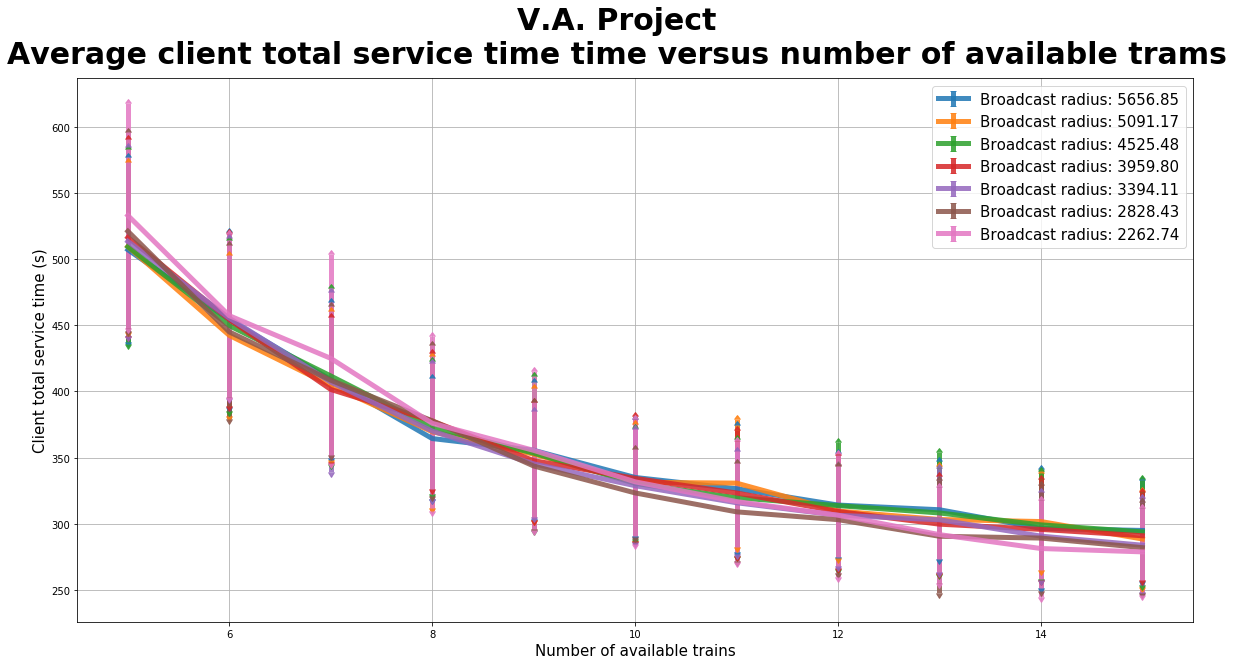

,5656 (1),5091 (0.9),4525 (0.8),3959 (0.7),3394 (0.6),2828 (0.5),2262 (0.4)
5,507.00 +- 69.85,509.43 +- 64.18,509.32 +- 73.71,516.29 +- 74.32,513.31 +- 71.13,520.95 +- 75.02,532.87 +- 84.99
6,454.25 +- 66.30,442.35 +- 60.51,449.72 +- 64.47,454.29 +- 65.43,455.35 +- 60.57,444.95 +- 65.74,457.22 +- 61.36
7,408.92 +- 58.77,404.55 +- 56.23,411.72 +- 66.40,401.53 +- 54.40,407.14 +- 67.83,408.49 +- 56.36,425.02 +- 78.92
8,364.45 +- 45.52,369.64 +- 57.35,372.73 +- 50.13,377.74 +- 51.37,370.13 +- 51.16,377.85 +- 57.13,375.98 +- 65.90
9,355.60 +- 51.84,352.72 +- 49.85,353.44 +- 58.00,347.78 +- 44.64,345.36 +- 39.80,343.75 +- 47.94,355.54 +- 59.85
10,335.08 +- 44.51,331.46 +- 44.32,330.64 +- 41.71,334.40 +- 47.02,328.87 +- 42.44,323.42 +- 33.43,331.81 +- 47.05
11,326.60 +- 47.87,330.82 +- 48.23,319.79 +- 44.02,323.35 +- 47.76,315.99 +- 38.93,309.13 +- 37.20,316.89 +- 45.98
12,314.26 +- 39.07,309.74 +- 35.10,313.81 +- 48.16,309.42 +- 42.84,306.53 +- 38.31,303.22 +- 40.20,306.57 +- 46.58
13,310.72 +- 36.97,303.36 +- 40.59,308.27 +- 46.36,299.83 +- 36.71,303.16 +- 39.10,290.70 +- 42.72,291.93 +- 36.33
14,296.62 +- 44.62,301.80 +- 36.89,299.31 +- 40.61,295.89 +- 38.26,290.80 +- 33.22,289.34 +- 39.74,281.44 +- 36.67


In [12]:
# Average delivery time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client total service time time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_del_time[clientRange][i], d_del_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_del_time[clientRange], yerr=d_del_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f}".format(map_size*clientRange))

plt.xlabel("Number of available trains", fontsize=15)
plt.ylabel("Client total service time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

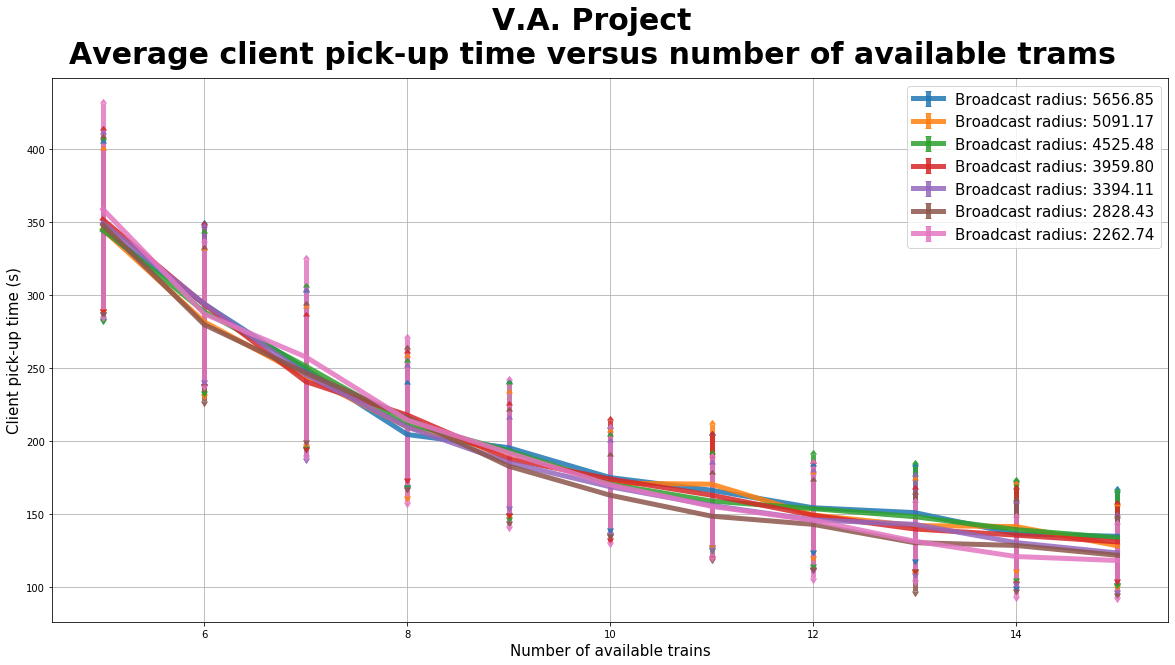

,5656 (1),5091 (0.9),4525 (0.8),3959 (0.7),3394 (0.6),2828 (0.5),2262 (0.4)
5,344.17 +- 59.98,344.95 +- 54.57,345.00 +- 61.17,351.77 +- 61.31,349.24 +- 61.01,348.09 +- 59.39,358.82 +- 72.88
6,293.78 +- 54.76,281.59 +- 49.59,288.53 +- 54.28,293.59 +- 54.74,294.11 +- 52.25,279.72 +- 52.01,287.11 +- 48.95
7,249.12 +- 53.02,244.35 +- 46.49,251.19 +- 54.60,240.71 +- 44.98,245.47 +- 57.30,246.74 +- 46.26,257.62 +- 67.32
8,204.46 +- 34.31,209.73 +- 47.67,212.10 +- 42.25,217.78 +- 42.88,209.56 +- 41.32,216.01 +- 47.35,214.38 +- 56.43
9,195.42 +- 44.68,191.74 +- 41.51,193.37 +- 45.41,187.78 +- 37.22,185.17 +- 29.81,182.76 +- 37.48,191.91 +- 49.91
10,174.96 +- 34.30,171.20 +- 35.00,170.50 +- 33.23,173.95 +- 40.27,168.66 +- 30.97,162.86 +- 26.89,169.97 +- 39.12
11,166.25 +- 37.72,170.41 +- 41.55,158.83 +- 32.14,162.87 +- 41.53,155.86 +- 28.45,148.50 +- 28.64,155.22 +- 34.01
12,154.26 +- 28.93,149.31 +- 27.86,153.65 +- 37.63,149.10 +- 35.87,145.97 +- 32.93,142.88 +- 29.43,145.69 +- 39.50
13,150.95 +- 31.88,142.06 +- 31.26,148.16 +- 35.86,139.70 +- 27.71,142.92 +- 33.06,130.34 +- 33.22,131.36 +- 26.62
14,136.41 +- 35.58,141.41 +- 29.31,139.30 +- 33.23,135.50 +- 31.55,130.39 +- 26.80,128.44 +- 30.15,120.84 +- 27.08


In [13]:
# Average total waiting time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client pick-up time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_wait_time[clientRange][i], d_wait_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_wait_time[clientRange], yerr=d_wait_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f}".format(map_size*clientRange))

plt.xlabel("Number of available trains", fontsize=15)
plt.ylabel("Client pick-up time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

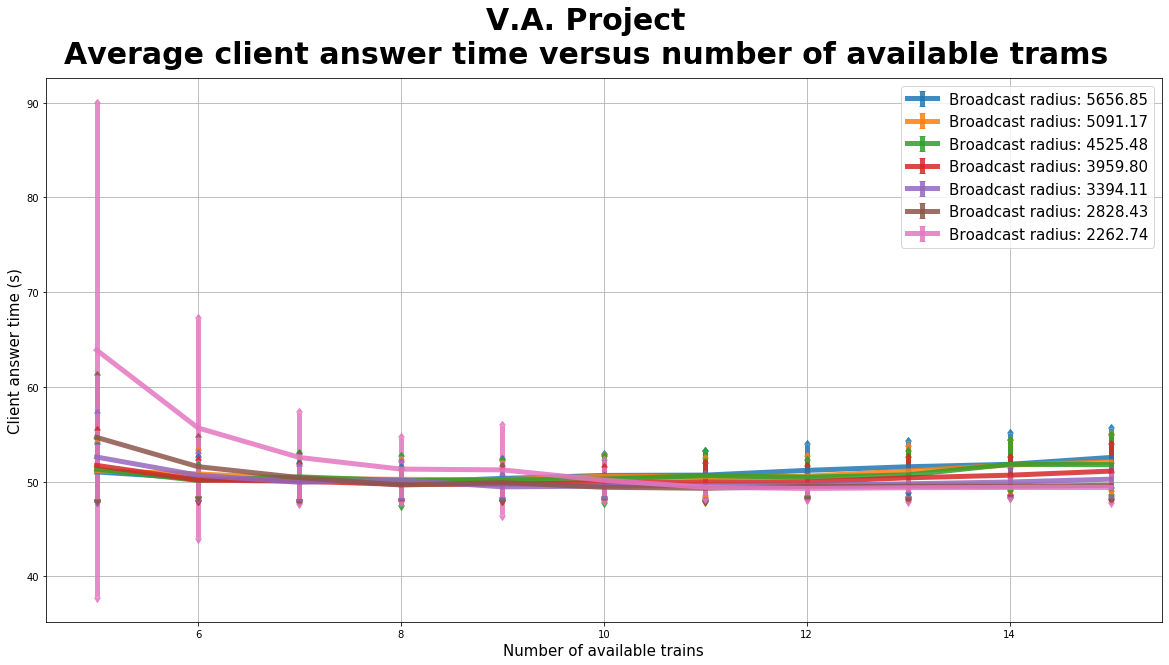

,5656 (1),5091 (0.9),4525 (0.8),3959 (0.7),3394 (0.6),2828 (0.5),2262 (0.4)
5,51.02 +- 2.95,51.13 +- 3.09,51.31 +- 3.20,51.71 +- 3.78,52.59 +- 4.67,54.67 +- 6.55,63.89 +- 26.09
6,50.34 +- 2.26,50.81 +- 2.48,50.12 +- 1.64,50.16 +- 2.07,50.67 +- 2.36,51.57 +- 3.14,55.67 +- 11.65
7,50.07 +- 1.94,50.32 +- 2.15,50.50 +- 2.56,50.04 +- 1.83,49.93 +- 1.72,50.42 +- 2.49,52.55 +- 4.85
8,49.92 +- 1.64,50.24 +- 2.04,50.11 +- 2.57,49.70 +- 1.55,50.17 +- 1.91,49.64 +- 1.54,51.32 +- 3.34
9,50.33 +- 2.01,50.19 +- 2.00,50.18 +- 2.11,49.71 +- 1.66,49.44 +- 1.21,49.89 +- 1.73,51.24 +- 4.75
10,50.65 +- 2.21,50.56 +- 2.21,50.26 +- 2.42,49.90 +- 1.65,49.52 +- 1.12,49.40 +- 1.22,50.14 +- 2.10
11,50.68 +- 2.53,50.52 +- 1.96,50.62 +- 2.66,49.99 +- 1.96,49.58 +- 1.22,49.29 +- 1.08,49.40 +- 1.09
12,51.18 +- 2.77,50.57 +- 2.11,50.46 +- 1.87,49.97 +- 1.68,49.62 +- 1.28,49.49 +- 0.98,49.27 +- 1.09
13,51.57 +- 2.69,51.12 +- 2.64,50.71 +- 2.47,50.40 +- 2.24,49.77 +- 1.30,49.52 +- 1.17,49.35 +- 1.45
14,51.82 +- 3.27,51.75 +- 2.65,51.83 +- 2.61,50.67 +- 1.94,49.95 +- 1.51,49.50 +- 1.15,49.38 +- 0.97


In [14]:
# Average train assignment time plot

fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nAverage client answer time versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "{:.2f} +- {:.2f}".format(m_answ_time[clientRange][i], d_answ_time[clientRange][i]) ]
    ax.errorbar(n_trains, m_answ_time[clientRange], yerr=d_answ_time[clientRange],
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f}".format(map_size*clientRange))

plt.xlabel("Number of available trains", fontsize=15)
plt.ylabel("Client answer time (s)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

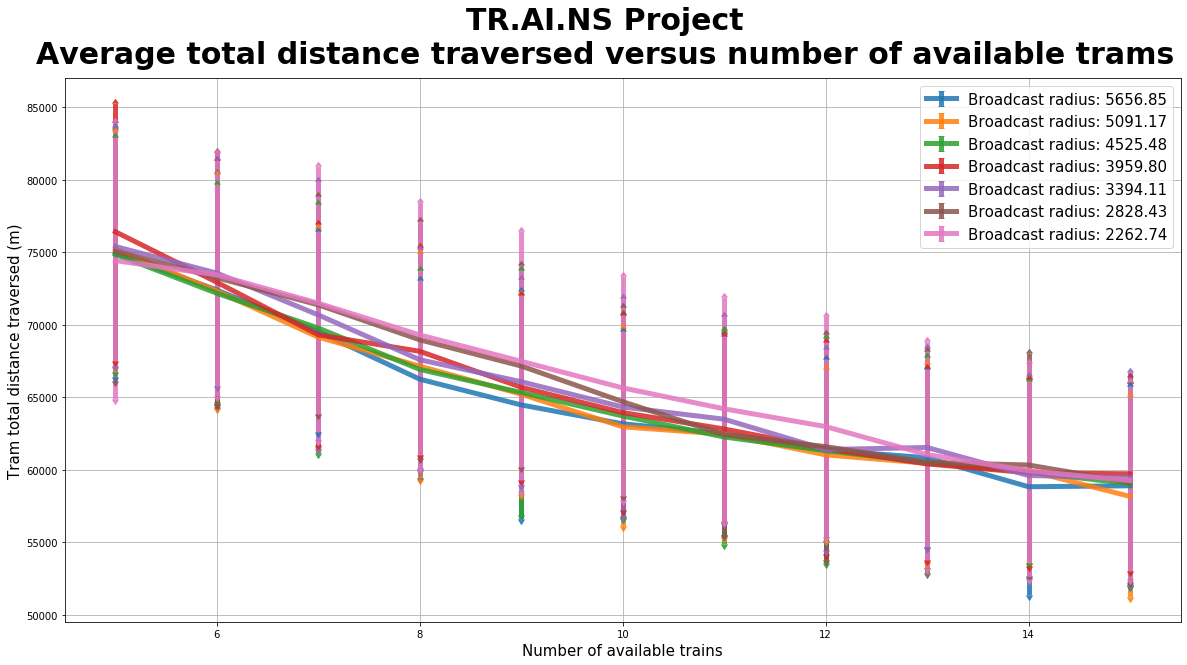

,5656 (1),5091 (0.9),4525 (0.8),3959 (0.7),3394 (0.6),2828 (0.5),2262 (0.4)
5,(74.9 +- 8.5) 10^3,(75.2 +- 8.1) 10^3,(74.8 +- 8.1) 10^3,(76.4 +- 8.9) 10^3,(75.4 +- 8.2) 10^3,(75.0 +- 8.9) 10^3,(74.4 +- 9.6) 10^3
6,(72.4 +- 8.1) 10^3,(72.3 +- 8.0) 10^3,(72.2 +- 7.5) 10^3,(72.9 +- 8.4) 10^3,(73.5 +- 7.8) 10^3,(73.2 +- 8.7) 10^3,(73.4 +- 8.4) 10^3
7,(69.5 +- 6.9) 10^3,(69.1 +- 7.6) 10^3,(69.8 +- 8.6) 10^3,(69.3 +- 7.6) 10^3,(70.7 +- 9.2) 10^3,(71.4 +- 7.5) 10^3,(71.5 +- 9.4) 10^3
8,(66.2 +- 6.8) 10^3,(67.1 +- 7.8) 10^3,(66.9 +- 6.9) 10^3,(68.2 +- 7.2) 10^3,(67.6 +- 7.6) 10^3,(69.0 +- 8.2) 10^3,(69.3 +- 9.2) 10^3
9,(64.5 +- 7.9) 10^3,(65.2 +- 6.9) 10^3,(65.3 +- 8.5) 10^3,(65.7 +- 6.4) 10^3,(66.1 +- 7.1) 10^3,(67.1 +- 7.0) 10^3,(67.5 +- 9.0) 10^3
10,(63.2 +- 6.4) 10^3,(63.0 +- 6.8) 10^3,(63.7 +- 7.0) 10^3,(63.9 +- 6.7) 10^3,(64.3 +- 7.5) 10^3,(64.7 +- 6.5) 10^3,(65.6 +- 7.7) 10^3
11,(62.5 +- 7.0) 10^3,(62.4 +- 7.1) 10^3,(62.2 +- 7.4) 10^3,(62.8 +- 6.4) 10^3,(63.5 +- 7.1) 10^3,(62.4 +- 6.9) 10^3,(64.2 +- 7.7) 10^3
12,(61.4 +- 6.3) 10^3,(61.0 +- 5.9) 10^3,(61.3 +- 7.7) 10^3,(61.5 +- 7.3) 10^3,(61.4 +- 7.0) 10^3,(61.6 +- 7.8) 10^3,(63.0 +- 7.6) 10^3
13,(60.8 +- 6.1) 10^3,(60.4 +- 6.8) 10^3,(60.5 +- 7.3) 10^3,(60.4 +- 6.6) 10^3,(61.5 +- 6.9) 10^3,(60.5 +- 7.7) 10^3,(61.0 +- 7.8) 10^3
14,(58.8 +- 7.4) 10^3,(59.9 +- 6.4) 10^3,(59.8 +- 6.3) 10^3,(59.8 +- 6.5) 10^3,(59.6 +- 6.9) 10^3,(60.3 +- 7.7) 10^3,(59.9 +- 7.4) 10^3


In [15]:
# Total distance run

fig = plt.figure(figsize=(20, 10))
fig.suptitle("TR.AI.NS Project\nAverage total distance traversed versus number of available trams", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)
table = {}

for clientRange in c_radius:
    idx = "{:02d} ({})".format( int(map_size*clientRange), clientRange )
    table[idx] = []
    for i in range(len(n_trains)):
        table[idx] += [ "({:.1f} +- {:.1f}) 10^3".\
                       format(m_train_dist[clientRange][i]/1000, d_train_dist[clientRange][i]/1000) ]
    ax.errorbar(n_trains, m_train_dist[clientRange], yerr=d_train_dist[clientRange], 
                linewidth=5, alpha=.85,
                # marker='o', ms=10, mec='k', mew=.5, 
                uplims=True, lolims=True,
                label = "Broadcast radius: {:.2f}".format(map_size*clientRange))

plt.xlabel("Number of available trains", fontsize=15)
plt.ylabel("Tram total distance traversed (m)", fontsize=15)
plt.grid(True)

plt.legend(loc=1, prop={'size': 15})
plt.show()

# Table
tab = pd.DataFrame(table, index=n_trains)
tab

<!--- What we can mostly observe by these graphs is that above a certain radius, the broadcast read does not have much influence over neither the distance overrun by trains nor the time waited by the clients. --->

<!--- The total waiting time until the client pick-up noticeably suffers performance when the radius decreases to 1400m and below. But over that threshold the difference in performances is heavily dwarfed by the measurement uncertainties, which are inherent in the system operation implemented. These results lead us to believe that a wide radius is not inherent for the system to function efficiently. Although not represented here, the tests made also point to the fact that a small radius is prohibitive to its functioning at all, since the non answer of a client is considered as a system failure. --->

<!--- The total waiting time until the client is answered does not appear to be highly dependent on neither the number of trains nor the broadcast radius, even though the small broadcast radius leads to a slight up drift in the curve. As in the case of the other time measurement, this can be explained by the supposition that some clients sometimes were left too far away from all the available trains for the smaller broadcast radius to reach them for an extended amount of time. --->

<!--- The total distance run by trains does not show apparent dependence on the broadcast radius data. However, is shows a slight decrease with the increase of the number of trains. There would need to be an analysis, though, of what would generate the smaller cost: higher number of trains that run a smaller distance or smaller number of trains that run a bigger distance. It is my belief that the most probable is the second case, since the distances are still subjected to such a high standard deviation that its gain is very much of a gamble as of right now. --->

<!--- #### Note: 
<!--- I would have assumed it's better to have less trains because they should be more expensive themselves than the costs involved in moving them. However this movement cost should consider that the train will be used for a very long time, and so using them less might just compensate the cost of acquiring a new train over the span of a long time. As I stated, a more detailed study would be needed to ascertain this. --->

---

# Otimização

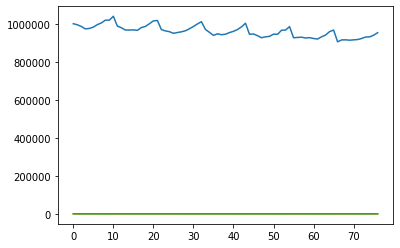

{'nT': 5, 'tR': 1.2000000000000002, 'value': 904616.2077777777}


In [124]:
## RASCUNHO

a0 = 0
a1 = 50
a2 = 20
a3 = 0.01

lambdas = [0.00000001, 0.0001, 1, 2]


# ---------
#cliR = 0.5
#nTrens = 8
l = 1000
# ---------


# Função de otimização

cost = []
quality = []
otmFunc = []

minValue = { 'nT': None, 'tR': None, 'value': 99999999999999 }

# for cliR in c_radius:
#    custo = 
#    for 

# otmFunc = 

#trR = 3*cliR
#custo = a0 + a1*trR + a2*nTrens + a3*m_train_dist[cliR][nTrens]
#for p in lambdas:
#    otmFunc += [m_del_time[cliR][nTrens] + p*custo]
#print(otmFunc)
#plt.plot(lambdas, otmFunc)
#plt.show()

# print(m_train_dist)


for cliR in c_radius:
    trR = 3*cliR
    for i in range(len(n_trains)):
        custo = a0 + a1*trR + a2*n_trains[i] + a3*m_train_dist[cliR][i]
        value = m_del_time[cliR][i] + l*custo
        
        cost += [custo]
        quality += [m_del_time[cliR][i]]
        otmFunc += [value]
        if value < minValue['value']:
            minValue['nT'] = n_trains[i]
            minValue['tR'] = trR
            minValue['value'] = value
    
plt.plot(otmFunc)
plt.plot(cost)
plt.plot(quality)
plt.show()

print(minValue)

{'lambda': [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20], 'nT': [15, 15, 15, 14, 14, 14, 13, 10, 10, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'cR': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'tR': [6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001, 6788.220000000001], 'value': [287.06611111111107, 319.66388888888883, 360.4111111111111, 521.29, 681.1899999999999, 921.04, 1078.8177777777778, 1468.1466666666665, 1846.9244444444444, 2601.6488888888894, 3343.537777777778, 5545.263333333333, 7693.43, 8409.485555555555, 9125.54111111111, 

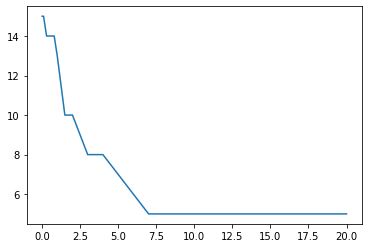

In [169]:
# Parâmetros de otimização

a0 = 0
a1 = 100
a2 = 20
a3 = 0.1

# lambdas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
lambdas = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]

# Otimização, para o modo "multiple clients" para os diferentes valores de lambda

otimizacao = {'lambda': [], 'nT': [], 'cR': [], 'tR': [], 'value': []}


for l in range(len(lambdas)):
    otimizacao['lambda'] += [lambdas[l]]
    otimizacao['nT'] += [None]
    otimizacao['cR'] += [None]
    otimizacao['tR'] += [None]
    otimizacao['value'] += [999999999999999999999]
    for cliR in c_radius:
        trR = 3*cliR
        for i in range(len(n_trains)):
            custo = a0 + a1*trR + a2*n_trains[i] + a3*m_train_dist[cliR][i]/float(total_clients_finished)
            qualidade = m_del_time[cliR][i]
            valor = qualidade + lambdas[l]*custo
            
            if valor < otimizacao['value'][l]:
                otimizacao['nT'][l] = n_trains[i]
                otimizacao['tR'][l] = trR*map_size
                otimizacao['cR'][l] = cliR
                otimizacao['value'][l] = valor
                
plt.plot(lambdas, otimizacao['nT'], label='Number of trams')
#plt.plot(lambdas, otimizacao['tR'], label='Tram broadcst radius')
print(otimizacao)

In [170]:
tab = pd.DataFrame(otimizacao)
tab

,lambda,nT,cR,tR,value
0,0.01,15,0.4,6788.22,287.066111
1,0.05,15,0.4,6788.22,319.663889
2,0.10,15,0.4,6788.22,360.411111
3,0.30,14,0.4,6788.22,521.290000
4,0.50,14,0.4,6788.22,681.190000
5,0.80,14,0.4,6788.22,921.040000
6,1.00,13,0.4,6788.22,1078.817778
7,1.50,10,0.4,6788.22,1468.146667
8,2.00,10,0.4,6788.22,1846.924444
9,3.00,8,0.4,6788.22,2601.648889


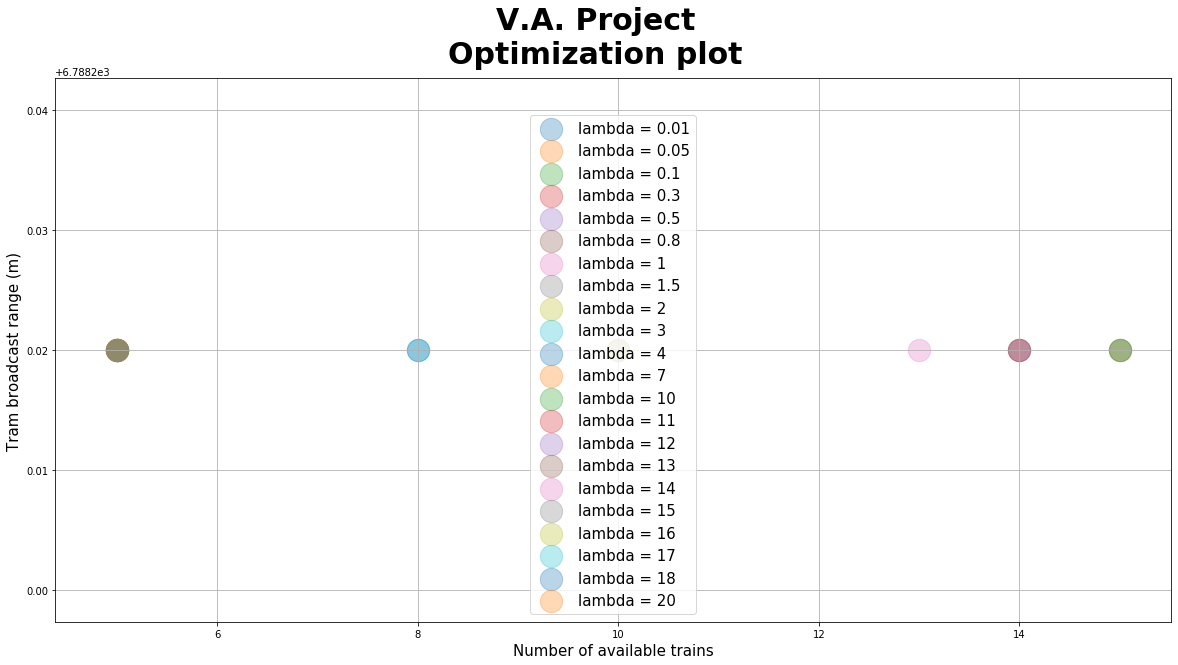

In [171]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nOptimization plot", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)

for l in range(len(lambdas)):
    ax.scatter(otimizacao['nT'][l], otimizacao['tR'][l], s=500, alpha=.3,
               label='lambda = {}'.format(lambdas[l]))
    
plt.xlabel("Number of available trains", fontsize=15)
plt.ylabel("Tram broadcast range (m)", fontsize=15)
plt.grid(True)
    
plt.legend(prop={'size': 15})
plt.show()

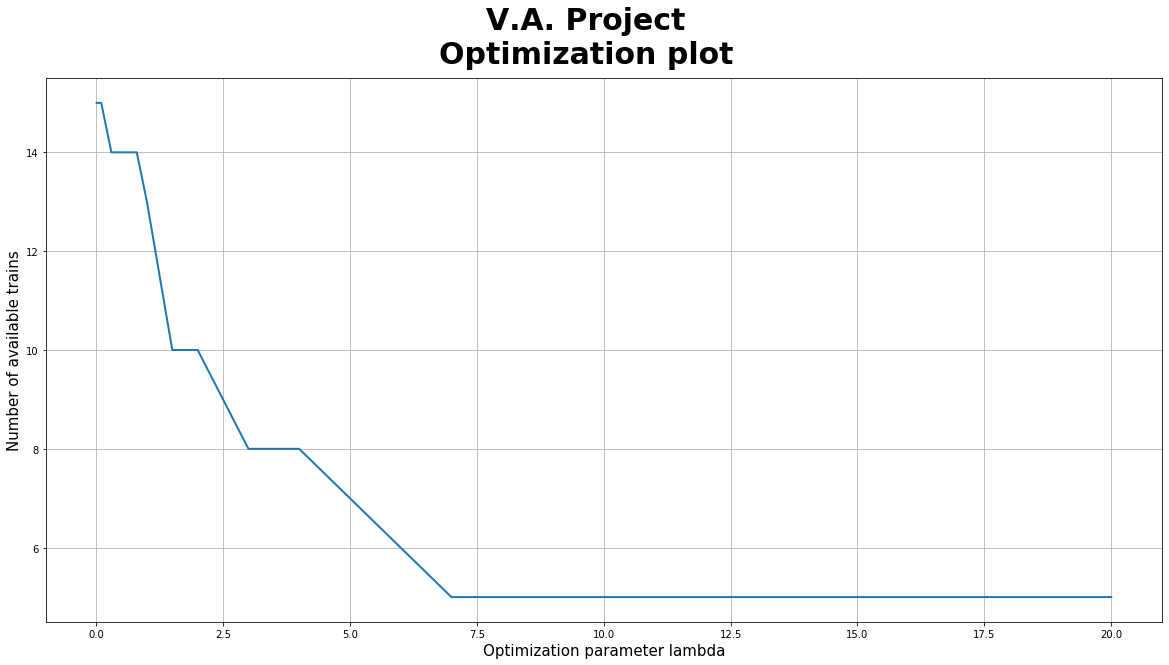

In [172]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("V.A. Project\nOptimization plot", fontweight='bold', fontsize=30)
ax = fig.add_subplot(1, 1, 1)

ax.plot(otimizacao['lambda'], otimizacao['nT'], lw=2)
    
plt.xlabel("Optimization parameter lambda", fontsize=15)
plt.ylabel("Number of available trains", fontsize=15)
plt.grid(True)

plt.show()

___

<!--- This final plots show the client arrival distribution along all the simulations performed ($7 \times 7 \times 60 = 2940$ simulation, each with 15 clients created before they stopped appearing). The left plot shows the time distribution and the right one the space distribution. --->

<!--- One can see that the distribution between the available stopping points is uniform. The time appearance, however, begins uniformly and then decreases with time. Such behavior can be explained due to the fact that the client arrival is artificially stopped after 15 clients are created for the purpose of these simulations. --->